In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
from matplotlib import patches

import os
import math
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import roc_curve, roc_auc_score, auc

import scipy.stats as st
from scipy.stats import poisson
from scipy.interpolate import interp1d
from scipy.stats import norm
from scipy.stats import multivariate_normal

In [2]:
from sklearn.neighbors import KernelDensity # paquete necesario
from sklearn.model_selection import GridSearchCV

import scipy.integrate as integrate

In [3]:
!pip install xgboost

import xgboost
from xgboost import XGBRegressor, XGBClassifier

You should consider upgrading via the '/home/andres/anaconda3/bin/python -m pip install --upgrade pip' command.


### FUNCTIONS

In [96]:
def XG(X_train, X_test, X_val, Y_train, Y_test, Y_val, n_estimators=500,
        learning_rate=0.1,
        reg_lambda=0.0,reg_alpha=0.0,
        gamma=0.0,objective='binary:logistic',
        max_depth=5,
        early_stopping_rounds=50):
    
    # CLASSIFIER
    classifier = XGBClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        reg_lambda=reg_lambda,reg_alpha=reg_alpha,
        gamma=gamma,objective='binary:logistic',
        max_depth=max_depth)

    # FIT
    classifier.fit(X_train,Y_train,eval_set=[(X_train, Y_train), (X_val, Y_val)],
            eval_metric='logloss',early_stopping_rounds=early_stopping_rounds,#early stopping
            verbose=True)

    # PREDICTIONS
    y_pred_xg = classifier.predict_proba(X_test).T[1]


    # ROC
    fpr_xg, tpr_xg, _ = roc_curve(Y_test, y_pred_xg)
    roc_auc_xg = auc(fpr_xg, tpr_xg)


    # PLOT THE ROC WITH AUC
    fig = plt.figure(figsize=(6, 6))
    gs = gridspec.GridSpec(1, 1) 
    ax0 = plt.subplot(gs[0])
    ax0.yaxis.set_ticks_position('both')
    ax0.xaxis.set_ticks_position('both')
    ax0.tick_params(direction="in",which="both")
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    ax0.minorticks_on()


    plt.plot(tpr_xg,1-fpr_xg,label="$f_{1}$, AUC = %0.2f" % roc_auc_xg,color="orange",ls=":",lw=4)
    plt.plot([1,0],[0,1],ls=":",color="grey")
    plt.xlabel("True Positive Rate",fontsize=16)
    plt.ylabel("1 $-$ False Positive Rate",fontsize=16)
    plt.legend()
    plt.title(r"XGBoost",fontsize=16)
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.yticks([0.2,0.4,0.6,0.8,1.])
    plt.legend(frameon=False,fontsize=16)
    plt.show()
    
    return roc_auc_xg, y_pred_xg

In [97]:
def ensembler(B_expected, S_expected, n_ensembles):
    
    # to construct ensembles B and S events are taken from Poisson distributions
    mu = S_expected + B_expected


    # Letś find the number of events per ensemble such that we get at least one ensemble populated if events are taken from a Poisson distribution

    # around the mean its populated so let's try (proposed range to be checked)
    list_events_per_ensembles = [i for i in range(int(mu*0.8),int(mu*1.2))]
    to_check = len(list_events_per_ensembles)

    # I want at least one ensemble populated
    list_nums_ensembles = [ round( poisson.pmf(list_events_per_ensembles[i],mu)*n_ensembles ) for i in range(len(list_events_per_ensembles)) ]



    # Remove from the list the elements without at least 1 ensemble possible
    for i in range(len(list_events_per_ensembles)):
        if list_nums_ensembles[i] > 1:
            list_events_per_ensembles = list_events_per_ensembles[i:]
            list_nums_ensembles = list_nums_ensembles[i:]
            break


    for i in range(len(list_events_per_ensembles)):
        if list_nums_ensembles[i] < 1:
            list_events_per_ensembles = list_events_per_ensembles[:i]
            list_nums_ensembles = list_nums_ensembles[:i]
            break

    print('\n If ', to_check, ' = ', len(list_events_per_ensembles), '   then the proposed range has to be extended')

    print('n_ensembles (actual): ', sum(list_nums_ensembles))



    # lists of S and B events per ensemble, w.r.t the total of number of events per ensemble found above:

    p_berno = S_expected/(S_expected+B_expected)

    list_S_per_ensembles = []
    list_B_per_ensembles = []

    for jj in range(len(list_events_per_ensembles)):
        list_S_per_ensembles.append( round(p_berno * list_events_per_ensembles[jj]) )
        list_B_per_ensembles.append( list_events_per_ensembles[jj] - round(p_berno * list_events_per_ensembles[jj]) )

    ######
    # NOW I HAVE 4 LISTS:
    # list_events_per_ensembles     list with the number of events per ensemble (its a range)
    # list_nums_ensembles           list with the number of ensembles, w.r.t the 1st list
    # list_S_per_ensembles          list with the number of signal events in each ensembles, w.r.t the 1st list
    # list_B_per_ensembles          list with the number of background events in each ensembles, w.r.t the 1st list
    ######
    
    return list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles

In [98]:
def jitter(a_series, noise_reduction=1000000):
    return (np.random.random(len(a_series))*a_series.std()/noise_reduction)-(a_series.std()/(2*noise_reduction))

In [99]:
def Z_BL_full(B_data, S_data, B_expected, S_expected, bins, ranges, linear_bins=True):
    
    # Les't use an integer number of possible ensembles
    N_ensembles_back = int(len(B_data) / B_expected)
    N_events_back = N_ensembles_back * B_expected

    N_ensembles_sig = int(len(S_data) / S_expected)
    N_events_sig = N_ensembles_sig * S_expected
    
    
    #Let's find out the expected number of B and S events in each bin:
    
    if linear_bins==False:
        # same number of B events per bin
        bin_edges_same = pd.qcut(pd.DataFrame(B_data[:N_events_back])[0] + jitter(pd.DataFrame(B_data[:N_events_back])[0]), q = bins, precision=0, retbins = True)[1]
        bins = [bin_edges_same]

    # bin the parameter space of all background events
    hist_back, binedges_back = np.histogramdd(B_data[:N_events_back], bins=bins, range = ranges)
    # now divide by the number of possible ensembles
    back_prom = hist_back.T.ravel()/N_ensembles_back

    # same for signal
    hist_sig, binedges_sig = np.histogramdd(S_data[:N_events_sig], bins=bins, range = ranges)
    sig_prom = hist_sig.T.ravel()/N_ensembles_sig
    
    
    # If a bins has no expected background events replace that zero for the minimum B_bin=/=0

    # find the minimum
    back_prom_noceros = []
    for i in range(len(back_prom)):
        if back_prom[i]!=0:
            back_prom_noceros.append(back_prom[i])

    min_back = min(back_prom_noceros)

    # replace the zeros
    for i in range(len(back_prom)):
        if back_prom[i]==0:
            back_prom[i] = min_back

    # then the signif Z^binned-Asimov:
    Z_bins = ( 2* sum( ( back_prom * np.log( back_prom/(sig_prom + back_prom) ) ) + sig_prom ) )**0.5
    
    return Z_bins

In [100]:
def KDE_finder(B_data, S_data, events_to_fit=20000, bandwidth_space=np.logspace(-3.0, 0.05, 20), set_kernel='epanechnikov'):

    kde = KernelDensity(kernel=set_kernel)
    grid = GridSearchCV(kde, {'bandwidth': bandwidth_space})
    grid.fit(np.c_[B_data[:events_to_fit]])

    B_bandwidth = grid.best_estimator_.bandwidth



    kde = KernelDensity(kernel=set_kernel)
    grid = GridSearchCV(kde, {'bandwidth': bandwidth_space})
    grid.fit(np.c_[S_data[:events_to_fit]])

    S_bandwidth = grid.best_estimator_.bandwidth



    # with each calculated bandwidth estimate the pdf with KDE to the classifier output (for background and signal)
    # notice: epanechnikov kernel
    kde_bkg = KernelDensity(kernel=set_kernel, bandwidth=B_bandwidth).fit(np.c_[B_data, np.zeros(len(B_data)) ])
    kde_sig = KernelDensity(kernel=set_kernel, bandwidth=S_bandwidth).fit(np.c_[S_data, np.ones(len(S_data)) ])

    print('KDE Kernel: ', set_kernel)
    print('Background bandwidth: ', B_bandwidth)
    print('Signal bandwidth: ', S_bandwidth)
    
    return kde_bkg, kde_sig, B_bandwidth, S_bandwidth

In [101]:
def Z_MLL(B_expected, S_expected, prob_B_given_B, prob_B_given_S, list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles):
    
    muhat_selected_list = []
    q_muhat = []
    q_muhat_mu0 = []
    
    for bb in range(len(list_nums_ensembles)):

        for kk in range(list_nums_ensembles[bb]):

            ran_ind = np.random.choice(indices, list_B_per_ensembles[bb])
            
            prob_B_given_B_shuf = []
            prob_B_given_S_shuf = []

            for i in ran_ind:
                prob_B_given_B_shuf.append(prob_B_given_B[i])
                prob_B_given_S_shuf.append(prob_B_given_S[i])

            prob_B_given_B_shuf  = prob_B_given_B_shuf
            prob_B_given_S_shuf  = prob_B_given_S_shuf

                

            # p_b(x_ensemble) =    concatenate: p_b(B_ensemble) and p_b(S_ensemble)
            prob_x_given_B = prob_B_given_B_shuf #+ prob_NP_given_B_shuf

            # p_s(x_ensemble) =    concatenate: p_s(B_ensemble) and p_s(S_ensemble)
            prob_x_given_S = prob_B_given_S_shuf #+ prob_NP_given_S_shuf
            



            
            # NOW WE HAVE p_{s,b}(x_ensemble) for this particular ensemble
            # WE NEED TO ESTIMATE mu_hat for this particular ensemble
            # we are going to obtain a mu_hat with a grid of values for this particular ensemble

            B_prob_x_given_B = [x * B_expected for x in prob_x_given_B]
            
            sum_muhat_zero = sum ( [(x*1.) / ( (x * 0. * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )
            sum_muhat_one = sum ( [(x*1.) / ( (x * 1. * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

            # grid, mu_hat is around 1
            muhat_test = np.arange(0., 1., 0.05).tolist()

            muhat_selected = 0.0

            if sum_muhat_zero < sum_muhat_one and sum_muhat_zero < 1:

                for vv in range(len(muhat_test)):

                    mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                    if mu_hat_condition_equal_1 > 1:
                        muhat_selected = muhat_test[vv]
                        break

            elif sum_muhat_zero > sum_muhat_one and sum_muhat_zero > 1:

                for vv in range(len(muhat_test)):

                    mu_hat_condition_equal_1 = sum ( [(x*1.) / ( (x * muhat_test[vv] * S_expected) + y ) for x, y in zip(prob_x_given_S, B_prob_x_given_B)] )

                    if mu_hat_condition_equal_1 < 1:
                        muhat_selected = muhat_test[vv]
                        break


            muhat_selected_list.append(muhat_selected)



            # NOW THAT WE HAVE mu_hat FOR THIS ENSEMBLE, CALCULATE THE TEST STATISTIC FOR THIS ENSEMBLE
            # and append it (we need the median over lots of ensembles)
            # DISCOVERY:
            #q_muhat.append( 2 * ( (-1.*muhat_selected * S_expected) + sum( [np.log( 1 + ( (muhat_selected*S_expected/B_expected) * (x / y) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
            # EXCLUSION:
            q_muhat.append( 2 * ( ( (1.-muhat_selected) * S_expected ) - sum( [np.log( ( (B_expected*y) + (S_expected*x) ) / ( (B_expected*y) + (muhat_selected*S_expected*x) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
            q_muhat_mu0.append( 2 * ( ( (1.-0.) * S_expected ) - sum( [np.log( ( (B_expected*y) + (S_expected*x) ) / ( (B_expected*y) + (0.*S_expected*x) ) ) for x, y in zip(prob_x_given_S, prob_x_given_B)] ) ) )
            
            
    # Finally calculate muhat_mean and Z
    muhat_mean = np.mean(muhat_selected_list)

    # Remove nan if any
    q_muhat = [x for x in q_muhat if x == x]
    for jk in range(len(q_muhat)):
        if q_muhat[jk] < 0:
            q_muhat[jk] = 0

    q_muhat_median = np.median(q_muhat)

    Z_nobin = abs(q_muhat_median)**0.5
    
    
    
    # Remove nan if any
    q_muhat_mu0 = [x for x in q_muhat_mu0 if x == x]
    for jk in range(len(q_muhat_mu0)):
        if q_muhat_mu0[jk] < 0:
            q_muhat_mu0[jk] = 0

    q_muhat_mu0_median = np.median(q_muhat_mu0)

    Z_nobin_mu0 = abs(q_muhat_mu0_median)**0.5
    
    
    return Z_nobin, muhat_mean, Z_nobin_mu0, muhat_selected_list, q_muhat, q_muhat_mu0

### GAUSSIAN

In [109]:
##############
# PARAMETERS #
##############

# gaussian, mean
epsilon = 0.3

# number of events
N = 1500000

# requested number of ensembles
n_ensembles = 10000

# number of expected background events per ensemble
B_expected = 50000

# ratio S_expected/B_expected (signal ratio)
SB_ratio = 0.01

# number of ML classifiers to do bagging
iterations_ML = 10



# SOME USEFUL DERIVATED PARAMETERS:

# S_expected:
S_expected = 500

# S/\sqrt{B}
SsqrtB = 500/(50000)**0.5

### COMPUTE

In [113]:
store_AUC = []

store_Z_bins_XG_10bins_1ML = []
store_Z_bins_XG_25bins_1ML = []
store_Z_bins_XG_50bins_1ML = []
store_Z_bins_XG_100bins_1ML = []

store_Z_bins_XG_10bins_eq_1ML = []
store_Z_bins_XG_25bins_eq_1ML = []
store_Z_bins_XG_50bins_eq_1ML = []
store_Z_bins_XG_100bins_eq_1ML = []

store_Z_bins_XG_10bins = []
store_Z_bins_XG_25bins = []
store_Z_bins_XG_50bins = []
store_Z_bins_XG_100bins = []

store_Z_bins_XG_10bins_eq = []
store_Z_bins_XG_25bins_eq = []
store_Z_bins_XG_50bins_eq = []
store_Z_bins_XG_100bins_eq = []

store_muhat_mean_gaussian = []
store_Z_gaussian = []
store_Z_gaussian_mu0 = []

store_muhat_mean_MLL_KDE = []
store_Z_MLL_KDE = []
store_Z_MLL_KDE_mu0 = []

store_muhat_mean_MLL_KDE_1ML = []
store_Z_MLL_KDE_1ML = []
store_Z_MLL_KDE_mu0_1ML = []


X_gauss_train :  (1000000, 1)
y_gauss_train :  (1000000, 1)
X_gauss_val :  (1000000, 1)
y_gauss_val :  (1000000, 1)
X_gauss_test :  (1000000, 1)
y_gauss_test :  (1000000, 1)



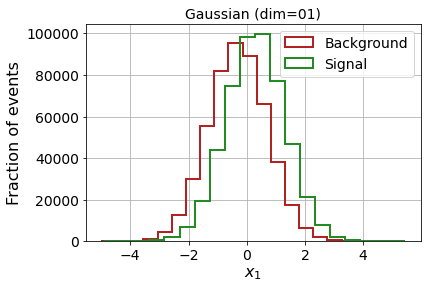

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.68535	validation_1-logloss:0.68534
[1]	validation_0-logloss:0.67900	validation_1-logloss:0.67897
[2]	validation_0-logloss:0.67384	validation_1-logloss:0.67379
[3]	validation_0-logloss:0.66962	validation_1-logloss:0.66955
[4]	validation_0-logloss:0.66615	validation_1-logloss:0.66606
[5]	validation_0-logloss:0.66331	validation_1-logloss:0.66321
[6]	validation_0-logloss:0.66095	validation_1-logloss:0.66084
[7]	validation_0-logloss:0.65900	validation_1-logloss:0.65888
[8]	validation_0-logloss:0.65749	validation_1-logloss:0.65735
[9]	validation_0-logloss:0.65618	validation_1-logloss:0.65604
[10]	validation_0-logloss:0.65512	validation_1-logloss:0.65497
[11]	validation_0-logloss:0.65427	validation_1-logloss:0.65412
[12]	validation_0-logloss:0.65352	validation_1-logloss:0.65337
[13]	validation_0-logloss:0.65293	validation_1-logloss:0.65277
[14]	validation_0-logloss:0.65244	validation_1-logloss:0.65228
[15]	validation_0-logloss:0.65202	validation_1-logloss:0.65187
[1

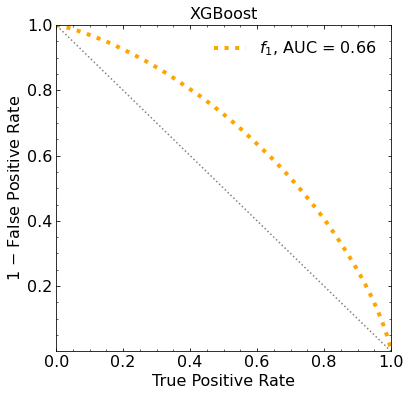

ML iteration 0
[0]	validation_0-logloss:0.68535	validation_1-logloss:0.68545


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	validation_0-logloss:0.67899	validation_1-logloss:0.67906
[2]	validation_0-logloss:0.67380	validation_1-logloss:0.67397
[3]	validation_0-logloss:0.66954	validation_1-logloss:0.66972
[4]	validation_0-logloss:0.66603	validation_1-logloss:0.66638
[5]	validation_0-logloss:0.66314	validation_1-logloss:0.66344
[6]	validation_0-logloss:0.66075	validation_1-logloss:0.66121
[7]	validation_0-logloss:0.65877	validation_1-logloss:0.65926
[8]	validation_0-logloss:0.65715	validation_1-logloss:0.65768
[9]	validation_0-logloss:0.65578	validation_1-logloss:0.65641
[10]	validation_0-logloss:0.65465	validation_1-logloss:0.65536
[11]	validation_0-logloss:0.65371	validation_1-logloss:0.65456
[12]	validation_0-logloss:0.65294	validation_1-logloss:0.65379
[13]	validation_0-logloss:0.65226	validation_1-logloss:0.65328
[14]	validation_0-logloss:0.65171	validation_1-logloss:0.65280
[15]	validation_0-logloss:0.65124	validation_1-logloss:0.65236
[16]	validation_0-logloss:0.65082	validation_1-logloss:0.65202
[

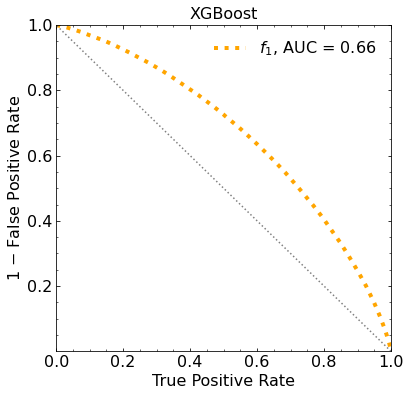

ML iteration  1
[0]	validation_0-logloss:0.68524	validation_1-logloss:0.68526


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	validation_0-logloss:0.67881	validation_1-logloss:0.67897
[2]	validation_0-logloss:0.67356	validation_1-logloss:0.67382
[3]	validation_0-logloss:0.66924	validation_1-logloss:0.66960
[4]	validation_0-logloss:0.66570	validation_1-logloss:0.66612
[5]	validation_0-logloss:0.66278	validation_1-logloss:0.66328
[6]	validation_0-logloss:0.66036	validation_1-logloss:0.66096
[7]	validation_0-logloss:0.65836	validation_1-logloss:0.65905
[8]	validation_0-logloss:0.65672	validation_1-logloss:0.65743
[9]	validation_0-logloss:0.65533	validation_1-logloss:0.65620
[10]	validation_0-logloss:0.65420	validation_1-logloss:0.65517
[11]	validation_0-logloss:0.65323	validation_1-logloss:0.65426
[12]	validation_0-logloss:0.65243	validation_1-logloss:0.65356
[13]	validation_0-logloss:0.65176	validation_1-logloss:0.65301
[14]	validation_0-logloss:0.65120	validation_1-logloss:0.65257
[15]	validation_0-logloss:0.65072	validation_1-logloss:0.65207
[16]	validation_0-logloss:0.65031	validation_1-logloss:0.65177
[

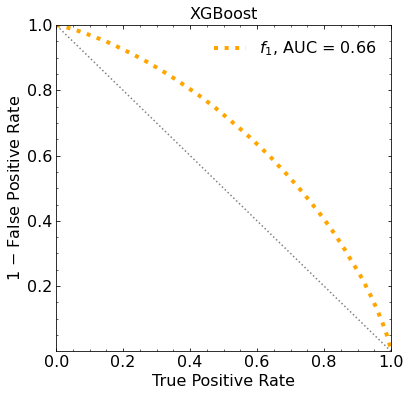

ML iteration  2
[0]	validation_0-logloss:0.68507	validation_1-logloss:0.68527
[1]	validation_0-logloss:0.67848	validation_1-logloss:0.67892
[2]	validation_0-logloss:0.67308	validation_1-logloss:0.67374


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[3]	validation_0-logloss:0.66868	validation_1-logloss:0.66940
[4]	validation_0-logloss:0.66505	validation_1-logloss:0.66601
[5]	validation_0-logloss:0.66205	validation_1-logloss:0.66315
[6]	validation_0-logloss:0.65958	validation_1-logloss:0.66082
[7]	validation_0-logloss:0.65753	validation_1-logloss:0.65890
[8]	validation_0-logloss:0.65585	validation_1-logloss:0.65734
[9]	validation_0-logloss:0.65444	validation_1-logloss:0.65611
[10]	validation_0-logloss:0.65327	validation_1-logloss:0.65509
[11]	validation_0-logloss:0.65229	validation_1-logloss:0.65419
[12]	validation_0-logloss:0.65147	validation_1-logloss:0.65353
[13]	validation_0-logloss:0.65080	validation_1-logloss:0.65296
[14]	validation_0-logloss:0.65022	validation_1-logloss:0.65251
[15]	validation_0-logloss:0.64972	validation_1-logloss:0.65210
[16]	validation_0-logloss:0.64931	validation_1-logloss:0.65183
[17]	validation_0-logloss:0.64897	validation_1-logloss:0.65155
[18]	validation_0-logloss:0.64867	validation_1-logloss:0.65131

ML iteration  3
[0]	validation_0-logloss:0.68499	validation_1-logloss:0.68532


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	validation_0-logloss:0.67835	validation_1-logloss:0.67891
[2]	validation_0-logloss:0.67294	validation_1-logloss:0.67360
[3]	validation_0-logloss:0.66848	validation_1-logloss:0.66940
[4]	validation_0-logloss:0.66481	validation_1-logloss:0.66591
[5]	validation_0-logloss:0.66181	validation_1-logloss:0.66310
[6]	validation_0-logloss:0.65933	validation_1-logloss:0.66077
[7]	validation_0-logloss:0.65725	validation_1-logloss:0.65891
[8]	validation_0-logloss:0.65556	validation_1-logloss:0.65727
[9]	validation_0-logloss:0.65415	validation_1-logloss:0.65605
[10]	validation_0-logloss:0.65297	validation_1-logloss:0.65488
[11]	validation_0-logloss:0.65199	validation_1-logloss:0.65414
[12]	validation_0-logloss:0.65115	validation_1-logloss:0.65338
[13]	validation_0-logloss:0.65047	validation_1-logloss:0.65280
[14]	validation_0-logloss:0.64987	validation_1-logloss:0.65241
[15]	validation_0-logloss:0.64938	validation_1-logloss:0.65200
[16]	validation_0-logloss:0.64897	validation_1-logloss:0.65170
[

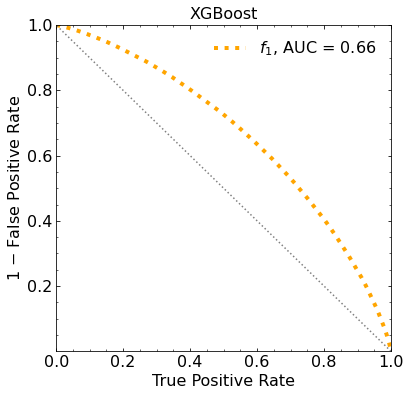

ML iteration  4
[0]	validation_0-logloss:0.68507	validation_1-logloss:0.68525
[1]	validation_0-logloss:0.67850	validation_1-logloss:0.67893


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[2]	validation_0-logloss:0.67315	validation_1-logloss:0.67367
[3]	validation_0-logloss:0.66875	validation_1-logloss:0.66944
[4]	validation_0-logloss:0.66514	validation_1-logloss:0.66594
[5]	validation_0-logloss:0.66217	validation_1-logloss:0.66309
[6]	validation_0-logloss:0.65970	validation_1-logloss:0.66084
[7]	validation_0-logloss:0.65768	validation_1-logloss:0.65891
[8]	validation_0-logloss:0.65602	validation_1-logloss:0.65732
[9]	validation_0-logloss:0.65462	validation_1-logloss:0.65600
[10]	validation_0-logloss:0.65347	validation_1-logloss:0.65494
[11]	validation_0-logloss:0.65250	validation_1-logloss:0.65415
[12]	validation_0-logloss:0.65170	validation_1-logloss:0.65338
[13]	validation_0-logloss:0.65102	validation_1-logloss:0.65279
[14]	validation_0-logloss:0.65044	validation_1-logloss:0.65235
[15]	validation_0-logloss:0.64996	validation_1-logloss:0.65200
[16]	validation_0-logloss:0.64955	validation_1-logloss:0.65171
[17]	validation_0-logloss:0.64921	validation_1-logloss:0.65138


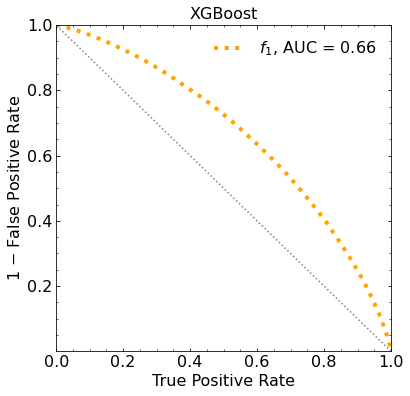

ML iteration  5
[0]	validation_0-logloss:0.68532	validation_1-logloss:0.68540


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	validation_0-logloss:0.67897	validation_1-logloss:0.67913
[2]	validation_0-logloss:0.67375	validation_1-logloss:0.67393
[3]	validation_0-logloss:0.66949	validation_1-logloss:0.66972
[4]	validation_0-logloss:0.66599	validation_1-logloss:0.66628
[5]	validation_0-logloss:0.66310	validation_1-logloss:0.66343
[6]	validation_0-logloss:0.66073	validation_1-logloss:0.66114
[7]	validation_0-logloss:0.65876	validation_1-logloss:0.65921
[8]	validation_0-logloss:0.65713	validation_1-logloss:0.65763
[9]	validation_0-logloss:0.65578	validation_1-logloss:0.65634
[10]	validation_0-logloss:0.65465	validation_1-logloss:0.65526
[11]	validation_0-logloss:0.65372	validation_1-logloss:0.65438
[12]	validation_0-logloss:0.65292	validation_1-logloss:0.65372
[13]	validation_0-logloss:0.65225	validation_1-logloss:0.65315
[14]	validation_0-logloss:0.65172	validation_1-logloss:0.65265
[15]	validation_0-logloss:0.65125	validation_1-logloss:0.65227
[16]	validation_0-logloss:0.65083	validation_1-logloss:0.65195
[

ML iteration  6
[0]	validation_0-logloss:0.68543	validation_1-logloss:0.68544
[1]	validation_0-logloss:0.67915	validation_1-logloss:0.67914
[2]	validation_0-logloss:0.67403	validation_1-logloss:0.67409


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[3]	validation_0-logloss:0.66983	validation_1-logloss:0.66989
[4]	validation_0-logloss:0.66638	validation_1-logloss:0.66645
[5]	validation_0-logloss:0.66354	validation_1-logloss:0.66367
[6]	validation_0-logloss:0.66120	validation_1-logloss:0.66138
[7]	validation_0-logloss:0.65926	validation_1-logloss:0.65942
[8]	validation_0-logloss:0.65765	validation_1-logloss:0.65795
[9]	validation_0-logloss:0.65631	validation_1-logloss:0.65667
[10]	validation_0-logloss:0.65522	validation_1-logloss:0.65555
[11]	validation_0-logloss:0.65429	validation_1-logloss:0.65468
[12]	validation_0-logloss:0.65351	validation_1-logloss:0.65402
[13]	validation_0-logloss:0.65286	validation_1-logloss:0.65345
[14]	validation_0-logloss:0.65231	validation_1-logloss:0.65293
[15]	validation_0-logloss:0.65186	validation_1-logloss:0.65255
[16]	validation_0-logloss:0.65149	validation_1-logloss:0.65218
[17]	validation_0-logloss:0.65116	validation_1-logloss:0.65192
[18]	validation_0-logloss:0.65087	validation_1-logloss:0.65174

ML iteration  7
[0]	validation_0-logloss:0.68524	validation_1-logloss:0.68539
[1]	validation_0-logloss:0.67882	validation_1-logloss:0.67898


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[2]	validation_0-logloss:0.67356	validation_1-logloss:0.67386
[3]	validation_0-logloss:0.66925	validation_1-logloss:0.66966
[4]	validation_0-logloss:0.66573	validation_1-logloss:0.66615
[5]	validation_0-logloss:0.66280	validation_1-logloss:0.66335
[6]	validation_0-logloss:0.66041	validation_1-logloss:0.66107
[7]	validation_0-logloss:0.65843	validation_1-logloss:0.65917
[8]	validation_0-logloss:0.65677	validation_1-logloss:0.65753
[9]	validation_0-logloss:0.65540	validation_1-logloss:0.65629
[10]	validation_0-logloss:0.65428	validation_1-logloss:0.65524
[11]	validation_0-logloss:0.65332	validation_1-logloss:0.65436
[12]	validation_0-logloss:0.65253	validation_1-logloss:0.65368
[13]	validation_0-logloss:0.65184	validation_1-logloss:0.65304
[14]	validation_0-logloss:0.65129	validation_1-logloss:0.65261
[15]	validation_0-logloss:0.65080	validation_1-logloss:0.65227
[16]	validation_0-logloss:0.65039	validation_1-logloss:0.65195
[17]	validation_0-logloss:0.65002	validation_1-logloss:0.65164


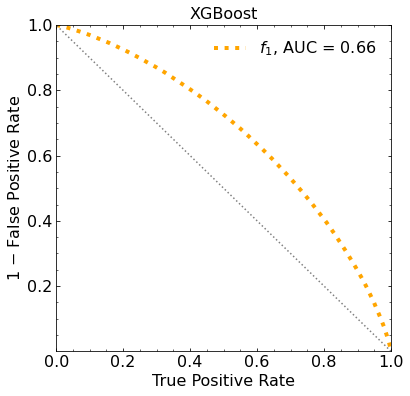

ML iteration  8
[0]	validation_0-logloss:0.68529	validation_1-logloss:0.68538


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	validation_0-logloss:0.67888	validation_1-logloss:0.67896
[2]	validation_0-logloss:0.67367	validation_1-logloss:0.67381
[3]	validation_0-logloss:0.66941	validation_1-logloss:0.66960
[4]	validation_0-logloss:0.66588	validation_1-logloss:0.66616
[5]	validation_0-logloss:0.66298	validation_1-logloss:0.66332
[6]	validation_0-logloss:0.66060	validation_1-logloss:0.66107
[7]	validation_0-logloss:0.65863	validation_1-logloss:0.65914
[8]	validation_0-logloss:0.65699	validation_1-logloss:0.65760
[9]	validation_0-logloss:0.65562	validation_1-logloss:0.65627
[10]	validation_0-logloss:0.65450	validation_1-logloss:0.65523
[11]	validation_0-logloss:0.65355	validation_1-logloss:0.65438
[12]	validation_0-logloss:0.65276	validation_1-logloss:0.65368
[13]	validation_0-logloss:0.65209	validation_1-logloss:0.65310
[14]	validation_0-logloss:0.65151	validation_1-logloss:0.65258
[15]	validation_0-logloss:0.65104	validation_1-logloss:0.65225
[16]	validation_0-logloss:0.65063	validation_1-logloss:0.65188
[

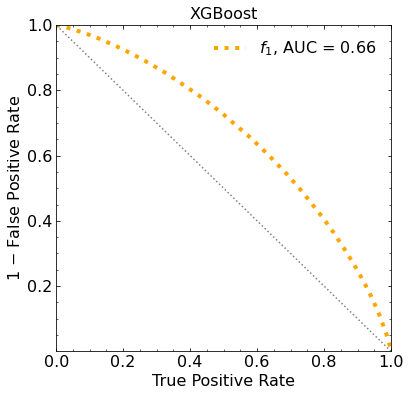

ML iteration  9
[0]	validation_0-logloss:0.68492	validation_1-logloss:0.68524
[1]	validation_0-logloss:0.67822	validation_1-logloss:0.67875


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[2]	validation_0-logloss:0.67275	validation_1-logloss:0.67362
[3]	validation_0-logloss:0.66824	validation_1-logloss:0.66938
[4]	validation_0-logloss:0.66456	validation_1-logloss:0.66582
[5]	validation_0-logloss:0.66150	validation_1-logloss:0.66296
[6]	validation_0-logloss:0.65898	validation_1-logloss:0.66076
[7]	validation_0-logloss:0.65690	validation_1-logloss:0.65882
[8]	validation_0-logloss:0.65518	validation_1-logloss:0.65727
[9]	validation_0-logloss:0.65375	validation_1-logloss:0.65597
[10]	validation_0-logloss:0.65254	validation_1-logloss:0.65494
[11]	validation_0-logloss:0.65154	validation_1-logloss:0.65413
[12]	validation_0-logloss:0.65070	validation_1-logloss:0.65341
[13]	validation_0-logloss:0.64999	validation_1-logloss:0.65285
[14]	validation_0-logloss:0.64938	validation_1-logloss:0.65245
[15]	validation_0-logloss:0.64888	validation_1-logloss:0.65200
[16]	validation_0-logloss:0.64843	validation_1-logloss:0.65174
[17]	validation_0-logloss:0.64806	validation_1-logloss:0.65145


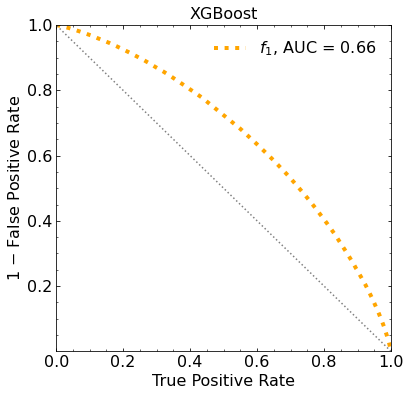

Classification score (1 ML):


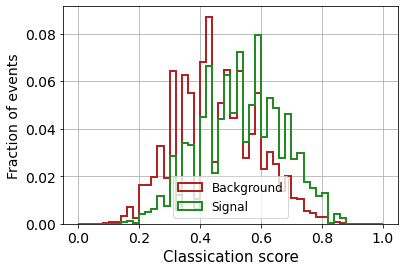

Classification score (10 ML):


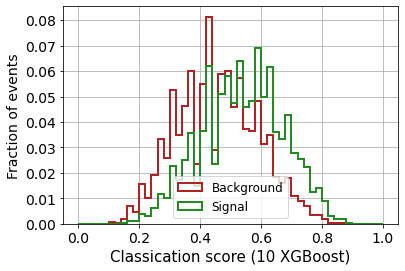


 ----------------------------------------- 

B_expected:  50000
S_expected:  500
S/$\sqrt{B}$:  2.23606797749979
 BINNED CLASSIFIER OUTPUT
  BL lineal bins, 1 ML
Z_XG 10 bins_1ML:  2.6376071686718165
Z_XG 25 bins_1ML:  2.6585020039390885
Z_XG 50 bins_1ML:  2.6614529625578567
Z_XG 100 bins_1ML:  2.663328107275102

 BL non-lineal bins, 1 ML
Z_XG 10 bins_eq_1ML:  2.609867949209768
Z_XG 25 bins_eq_1ML:  2.63893545441564
Z_XG 50 bins_eq_1ML:  2.647042121949209
Z_XG 100 bins_eq_1ML:  2.65469854623499

 BL lineal bins, 10 ML
Z_XG 10 bins:  2.6374984722271364
Z_XG 25 bins:  2.657196087042973
Z_XG 50 bins:  2.661572987384849
Z_XG 100 bins:  2.6632072736679375

 BL non-lineal bins, 10 ML
Z_XG 10 bins_eq:  2.6099464874382785
Z_XG 25 bins_eq:  2.6382266590596406
Z_XG 50 bins_eq:  2.6479234396276676
Z_XG 100 bins_eq:  2.6543276035393917

 ----------------------------------------- 


 If  20200  =  1101    then the proposed range has to be extended
n_ensembles (actual):  9863
TRUE PDF LIKELIHOOD (G

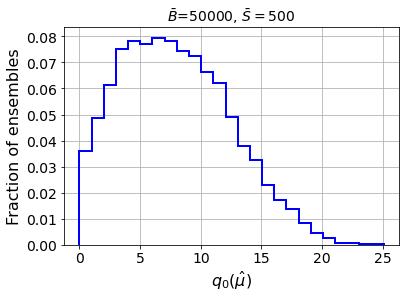

muhat mean:  0.13716921829058096
Z_gaussian:  2.7543357702550173
Z_gaussian_mu0:  2.7543357702550173

 ------------------------------------ 

 MLL + KDE (1ML) 


/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [         -inf          -inf          -inf          -inf 2428.62587855]
  warnings.warn(
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:929: RuntimeWarning: invalid value encountered in subtract
  array_stds = np.sqrt(np.average((array -
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [         -inf          -inf 2576.54887819 2479.70638518 2416.29741637]
  warnings.warn(
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:929: RuntimeWarning: invalid value encountered in subtract
  array_stds = np.sqrt(np.average((array -


KDE Kernel:  epanechnikov
Background bandwidth:  0.03162277660168379
Signal bandwidth:  0.01412537544622754


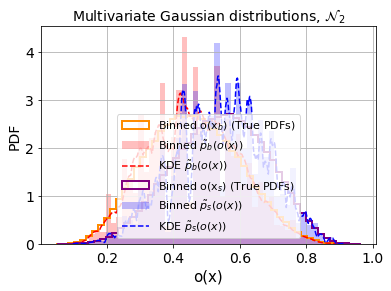

 MLL + KDE (10ML) 


/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [         -inf          -inf          -inf 2520.98396644 2467.77432718]
  warnings.warn(
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:929: RuntimeWarning: invalid value encountered in subtract
  array_stds = np.sqrt(np.average((array -
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [         -inf          -inf          -inf 2503.32705312 2462.4601645 ]
  warnings.warn(
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:929: RuntimeWarning: invalid value encountered in subtract
  array_stds = np.sqrt(np.average((array -


KDE Kernel:  epanechnikov
Background bandwidth:  0.021134890398366465
Signal bandwidth:  0.021134890398366465


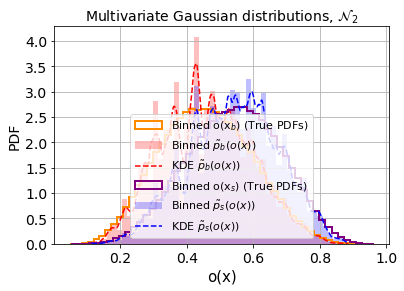

 Z MLL+KDE (1ML) 


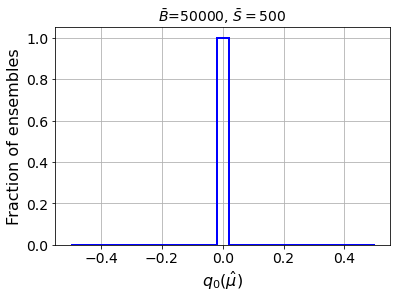

muhat mean_1ML:  0.0
Z_KDE_1ML:  0.0
Z_KDE mu=0_1ML:  0.0

 Z MLL+KDE (10ML) 


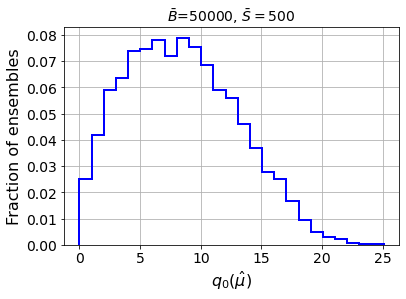

muhat mean:  0.11894454020075029
Z_KDE:  2.857584445428654
Z_KDE mu=0:  2.857584445428654

 ------------------------------------ 



In [138]:
dim=1

#######################
# generate the events #
#######################
    
mean_sig = epsilon*np.ones(dim)
mean_bkg = -1*mean_sig

#cov_sig = np.identity(dim)
cov_sig = np.identity(dim) + (0. * ( np.ones((dim,dim)) - np.identity(dim) ))
cov_bkg = cov_sig

signal_X_1 = np.random.multivariate_normal(mean_sig, cov_sig, N).T
background_X_1 = np.random.multivariate_normal(mean_bkg, cov_bkg, N).T

dim1 = np.concatenate((background_X_1,signal_X_1))

# labels
background_Y = np.zeros(N)
signal_Y = np.ones(N)

# DATA in a single matrix (features + labels)
df = pd.DataFrame()
df['dim1'] = dim1.reshape(-1)
df['Y'] = np.concatenate((background_Y.astype('int'),signal_Y.astype('int')))

X_gauss = df[['dim1']].values 
Y_gauss = df[['Y']].values

# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.5

X_gauss_aux, X_gauss_test, Y_gauss_aux, Y_gauss_test = train_test_split(X_gauss,
                                                                Y_gauss,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_gauss,
                                                                shuffle=True)


X_gauss_train, X_gauss_val, Y_gauss_train, Y_gauss_val = train_test_split(X_gauss_aux,
                                                                  Y_gauss_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_gauss_aux,
                                                                  shuffle=True)

print('')
print('X_gauss_train : ', X_gauss_train.shape)
print('y_gauss_train : ', Y_gauss_train.shape)
print('X_gauss_val : ', X_gauss_val.shape)
print('y_gauss_val : ', Y_gauss_val.shape)
print('X_gauss_test : ', X_gauss_test.shape)
print('y_gauss_test : ', Y_gauss_test.shape)
print('')


# PLOT (only 1st feature) to visualize the data
X_gauss_test_SM = []
X_gauss_test_NP = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] ==0:
        X_gauss_test_SM.append(X_gauss_test[i].tolist())
    else:
        X_gauss_test_NP.append(X_gauss_test[i].tolist())    


X_gauss_test_SM = np.array(X_gauss_test_SM)
X_gauss_test_NP = np.array(X_gauss_test_NP)


weights = np.ones_like(X_gauss_test_SM[:,0])/float(len(X_gauss_test_SM[:,0]))
plt.hist(X_gauss_test_SM[:,0], 20, histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(X_gauss_test_NP[:,0])/float(len(X_gauss_test_NP[:,0]))
plt.hist(X_gauss_test_NP[:,0], 20, histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$x_1$",fontsize=16)
plt.ylabel("Fraction of events",fontsize=16)
plt.grid()
plt.legend(fontsize=14)
plt.title(r"Gaussian (dim=%0.2d)" % dim,fontsize=14)
plt.show()  






################################
# the true pdfs (useful later) #
################################

sig_multi = multivariate_normal(mean_sig, cov_sig)
bkg_multi = multivariate_normal(mean_bkg, cov_bkg) 




#######################
# CLASSIFIER: XGBoost #
#######################

# only 1 ML
roc_auc_XG, y_pred_xg_1ML = XG(X_gauss_train, X_gauss_test, X_gauss_val, Y_gauss_train, Y_gauss_test, Y_gauss_val)

store_AUC.append(roc_auc_XG)


# Bagging

print('ML iteration 0')
roc_auc_XG, y_pred_xg_aux = XG(X_gauss_train[:100000], X_gauss_test, X_gauss_val, Y_gauss_train[:100000], Y_gauss_test, Y_gauss_val)
y_pred_xg_auxRE = np.reshape(y_pred_xg_aux, (1,len(y_pred_xg_aux)))

for it in range(1,iterations_ML):

    print('ML iteration ', it)
    roc_auc_XG, y_pred_xg_aux_it = XG(X_gauss_train[(100000*it):(100000*it)+100000], X_gauss_test, X_gauss_val, Y_gauss_train[(100000*it):(100000*it)+100000], Y_gauss_test, Y_gauss_val)
    
    y_pred_xg_auxRE_it = np.reshape(y_pred_xg_aux_it, (1,len(y_pred_xg_aux_it)))
    
    y_pred_xg_auxRE = np.concatenate([y_pred_xg_auxRE,y_pred_xg_auxRE_it])

# to smooth, mean of 10 predictions
y_pred_xg = np.mean(y_pred_xg_auxRE, axis=0)




########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

# 1 ML
pred_XG_SM_1ML = []
pred_XG_NP_1ML = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] == 0:
        pred_XG_SM_1ML.append(y_pred_xg_1ML[i])
    else:
        pred_XG_NP_1ML.append(y_pred_xg_1ML[i])
        
# Bagging  
pred_XG_SM = []
pred_XG_NP = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score (1 ML):')
        
weights = np.ones_like(pred_XG_SM_1ML)/float(len(pred_XG_SM_1ML))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM_1ML, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP_1ML)/float(len(pred_XG_NP_1ML))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP_1ML, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12, loc="lower center")
plt.show()


print('Classification score (10 ML):')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (10 XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12, loc="lower center")
plt.show()




ratio_ps_pb_true = sig_multi.pdf(X_gauss_test) / ( sig_multi.pdf(X_gauss_test) + bkg_multi.pdf(X_gauss_test) )
ratio_ps_pb_true_B = sig_multi.pdf(X_gauss_test_SM) / ( sig_multi.pdf(X_gauss_test_SM) + bkg_multi.pdf(X_gauss_test_SM) )
ratio_ps_pb_true_S = sig_multi.pdf(X_gauss_test_NP) / ( sig_multi.pdf(X_gauss_test_NP) + bkg_multi.pdf(X_gauss_test_NP) )

plt.scatter(y_pred_xg_1ML[:10000], ratio_ps_pb_true[:10000], color='green', label=r'o($\bar{x}$) (1 ML classifier)', s=10)
plt.scatter(y_pred_xg[:10000], ratio_ps_pb_true[:10000], color='blue', label=r'<o($\bar{x}$)> (10 ML classifiers)', s=10)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r"o($\bar{x}$)",fontsize=15)
plt.ylabel(r"$\frac{p_s(\bar{x})}{p_s(\bar{x})+p_b(\bar{x})}$",fontsize=16)
plt.grid()
plt.legend(fontsize=11)
#plt.savefig('images/' + 'optimalclass-vs-ox.pdf', format="pdf", bbox_inches="tight")
plt.show()

print('\n ----------------------------------------- \n')






###########
# METHODS #
###########

print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)



############################
# BINNED CLASSIFIER OUTPUT #
############################

print(' BINNED CLASSIFIER OUTPUT')

print('  BL lineal bins, 1 ML')

# 10 BINS
Z_bins_XG_10bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 10, [[0,1]], linear_bins=True)
store_Z_bins_XG_10bins_1ML.append(Z_bins_XG_10bins_1ML)
print('Z_XG 10 bins_1ML: ', Z_bins_XG_10bins_1ML)

# 25 BINS
Z_bins_XG_25bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 25, [[0,1]], linear_bins=True)
store_Z_bins_XG_25bins_1ML.append(Z_bins_XG_25bins_1ML)
print('Z_XG 25 bins_1ML: ', Z_bins_XG_25bins_1ML)

# 50 BINS
Z_bins_XG_50bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 50, [[0,1]], linear_bins=True)
store_Z_bins_XG_50bins_1ML.append(Z_bins_XG_50bins_1ML)
print('Z_XG 50 bins_1ML: ', Z_bins_XG_50bins_1ML)

# 100 BINS
Z_bins_XG_100bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 100, [[0,1]], linear_bins=True)
store_Z_bins_XG_100bins_1ML.append(Z_bins_XG_100bins_1ML)
print('Z_XG 100 bins_1ML: ', Z_bins_XG_100bins_1ML)


print('\n BL non-lineal bins, 1 ML')

# 10 BINS
Z_bins_XG_10bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 10, [[0,1]], linear_bins=False)
store_Z_bins_XG_10bins_eq_1ML.append(Z_bins_XG_10bins_eq_1ML)
print('Z_XG 10 bins_eq_1ML: ', Z_bins_XG_10bins_eq_1ML)

# 25 BINS
Z_bins_XG_25bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 25, [[0,1]], linear_bins=False)
store_Z_bins_XG_25bins_eq_1ML.append(Z_bins_XG_25bins_eq_1ML)
print('Z_XG 25 bins_eq_1ML: ', Z_bins_XG_25bins_eq_1ML)

# 50 BINS
Z_bins_XG_50bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 50, [[0,1]], linear_bins=False)
store_Z_bins_XG_50bins_eq_1ML.append(Z_bins_XG_50bins_eq_1ML)
print('Z_XG 50 bins_eq_1ML: ', Z_bins_XG_50bins_eq_1ML)

# 100 BINS
Z_bins_XG_100bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 100, [[0,1]], linear_bins=False)
store_Z_bins_XG_100bins_eq_1ML.append(Z_bins_XG_100bins_eq_1ML)
print('Z_XG 100 bins_eq_1ML: ', Z_bins_XG_100bins_eq_1ML)


print('\n BL lineal bins, 10 ML')

# 10 BINS
Z_bins_XG_10bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 10, [[0,1]], linear_bins=True)
store_Z_bins_XG_10bins.append(Z_bins_XG_10bins)
print('Z_XG 10 bins: ', Z_bins_XG_10bins)

# 25 BINS
Z_bins_XG_25bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 25, [[0,1]], linear_bins=True)
store_Z_bins_XG_25bins.append(Z_bins_XG_25bins)
print('Z_XG 25 bins: ', Z_bins_XG_25bins)

# 50 BINS
Z_bins_XG_50bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 50, [[0,1]], linear_bins=True)
store_Z_bins_XG_50bins.append(Z_bins_XG_50bins)
print('Z_XG 50 bins: ', Z_bins_XG_50bins)

# 100 BINS
Z_bins_XG_100bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 100, [[0,1]], linear_bins=True)
store_Z_bins_XG_100bins.append(Z_bins_XG_100bins)
print('Z_XG 100 bins: ', Z_bins_XG_100bins)


print('\n BL non-lineal bins, 10 ML')

# 10 BINS
Z_bins_XG_10bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 10, [[0,1]], linear_bins=False)
store_Z_bins_XG_10bins_eq.append(Z_bins_XG_10bins_eq)
print('Z_XG 10 bins_eq: ', Z_bins_XG_10bins_eq)

# 25 BINS
Z_bins_XG_25bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 25, [[0,1]], linear_bins=False)
store_Z_bins_XG_25bins_eq.append(Z_bins_XG_25bins_eq)
print('Z_XG 25 bins_eq: ', Z_bins_XG_25bins_eq)

# 50 BINS
Z_bins_XG_50bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 50, [[0,1]], linear_bins=False)
store_Z_bins_XG_50bins_eq.append(Z_bins_XG_50bins_eq)
print('Z_XG 50 bins_eq: ', Z_bins_XG_50bins_eq)

# 100 BINS
Z_bins_XG_100bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 100, [[0,1]], linear_bins=False)
store_Z_bins_XG_100bins_eq.append(Z_bins_XG_100bins_eq)
print('Z_XG 100 bins_eq: ', Z_bins_XG_100bins_eq)


print('\n ----------------------------------------- \n')






###########################
# SET THE TOY EXPERIMENTS #
###########################

list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles = ensembler(B_expected, S_expected, n_ensembles)






###################################
# TRUE PDF LIKELIHOOD (GAUSSIANS) #
###################################

indices = [i for i in range(len(X_gauss_test_SM))]

prob_B_given_B = bkg_multi.pdf(X_gauss_test_SM)
prob_B_given_S = sig_multi.pdf(X_gauss_test_SM)



print('TRUE PDF LIKELIHOOD (GAUSSIANS):')

print('n_ensembles (initial): ', n_ensembles)

Z_gaussian, muhat_mean_gaussian, Z_gaussian_mu0, muhat_selected_list, q_muhat, q_muhat_mu0 = Z_MLL(B_expected, S_expected, prob_B_given_B, prob_B_given_S, list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles)

# Histogram of q_muhats

weights = np.ones_like(q_muhat)/float(len(q_muhat))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()

store_muhat_mean_gaussian.append(muhat_mean_gaussian)
store_Z_gaussian.append(Z_gaussian)

store_Z_gaussian_mu0.append(Z_gaussian_mu0)

print('muhat mean: ', muhat_mean_gaussian)
print('Z_gaussian: ', Z_gaussian)
print('Z_gaussian_mu0: ', Z_gaussian_mu0)


print('\n ------------------------------------ \n')







#########
#  KDE  #
#########  

print(' MLL + KDE (1ML) ')

kde_bkg_1ML, kde_sig_1ML, B_bandwidth_1ML, S_bandwidth_1ML = KDE_finder(pred_XG_SM_1ML, pred_XG_NP_1ML, events_to_fit=20000, bandwidth_space=np.logspace(-2.2, -1.5, 5))


# range (~between 0 and 1)
min_val_1ML = np.min([np.min(pred_XG_SM_1ML),np.min(pred_XG_NP_1ML)])
max_val_1ML = np.max([np.max(pred_XG_SM_1ML),np.max(pred_XG_NP_1ML)])

s_vals_1ML = np.linspace(min_val_1ML,max_val_1ML,1000)



# evaluate the densities for each value of s (~bins)
dens_bkg_1ML = np.exp(kde_bkg_1ML.score_samples(np.c_[s_vals_1ML, np.zeros(len(s_vals_1ML)) ]) )
dens_sig_1ML = np.exp(kde_sig_1ML.score_samples(np.c_[s_vals_1ML, np.ones(len(s_vals_1ML)) ]) )



# Normalize to 1
# Area
factor_aux_SM_1ML = sum(dens_bkg_1ML*(s_vals_1ML[1]-s_vals_1ML[0]))
factor_aux_NP_1ML = sum(dens_sig_1ML*(s_vals_1ML[1]-s_vals_1ML[0]))

# normalize
dens_bkg_1ML = dens_bkg_1ML / factor_aux_SM_1ML
dens_sig_1ML = dens_sig_1ML / factor_aux_NP_1ML





# plot to check the estimation

plt.figure()

plt.hist(ratio_ps_pb_true_B,density=True,bins=50,lw=2,histtype='step',color='darkorange',alpha=1,label=r'Binned o(x$_b$) (True PDFs)')
plt.hist(pred_XG_SM_1ML,density=True,bins=50,color='red',alpha=0.25,label=r'Binned $\tilde{p}_{b}(o(x))$');
plt.plot(s_vals_1ML,dens_bkg_1ML,color='red',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');

plt.hist(ratio_ps_pb_true_S,density=True,bins=50,lw=2,histtype='step',color='purple',alpha=1,label=r'Binned o(x$_s$) (True PDFs)');
plt.hist(pred_XG_NP_1ML,density=True,bins=50,color='blue',alpha=0.25,label=r'Binned $\tilde{p}_{s}(o(x))$');
plt.plot(s_vals_1ML,dens_sig_1ML,color='blue',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("o(x)",fontsize=15)
plt.ylabel("PDF",fontsize=14)
plt.grid()
plt.legend(loc="lower center", fontsize=11, handlelength=2.5)
plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{2}$', fontsize=14)
#plt.savefig('images/' + '2gaussian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()





print(' MLL + KDE (10ML) ')

kde_bkg, kde_sig, B_bandwidth, S_bandwidth = KDE_finder(pred_XG_SM, pred_XG_NP, events_to_fit=20000, bandwidth_space=np.logspace(-2.2, -1.5, 5))


# range (~between 0 and 1)
min_val = np.min([np.min(pred_XG_SM),np.min(pred_XG_NP)])
max_val = np.max([np.max(pred_XG_SM),np.max(pred_XG_NP)])

s_vals = np.linspace(min_val,max_val,1000)



# evaluate the densities for each value of s (~bins)
dens_bkg = np.exp(kde_bkg.score_samples(np.c_[s_vals, np.zeros(len(s_vals)) ]) )
dens_sig = np.exp(kde_sig.score_samples(np.c_[s_vals, np.ones(len(s_vals)) ]) )



# Normalize to 1
# Area
factor_aux_SM = sum(dens_bkg*(s_vals[1]-s_vals[0]))
factor_aux_NP = sum(dens_sig*(s_vals[1]-s_vals[0]))

# normalize
dens_bkg = dens_bkg / factor_aux_SM
dens_sig = dens_sig / factor_aux_NP





# plot to check the estimation

plt.figure()

plt.hist(ratio_ps_pb_true_B,density=True,bins=50,lw=2,histtype='step',color='darkorange',alpha=1,label=r'Binned o(x$_b$) (True PDFs)')
plt.hist(pred_XG_SM,density=True,bins=50,color='red',alpha=0.25,label=r'Binned $\tilde{p}_{b}(o(x))$');
plt.plot(s_vals,dens_bkg,color='red',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');

plt.hist(ratio_ps_pb_true_S,density=True,bins=50,lw=2,histtype='step',color='purple',alpha=1,label=r'Binned o(x$_s$) (True PDFs)');
plt.hist(pred_XG_NP,density=True,bins=50,color='blue',alpha=0.25,label=r'Binned $\tilde{p}_{s}(o(x))$');
plt.plot(s_vals,dens_sig,color='blue',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("o(x)",fontsize=15)
plt.ylabel("PDF",fontsize=14)
plt.grid()
plt.legend(loc="lower center", fontsize=11, handlelength=2.5)
plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{2}$', fontsize=14)
#plt.savefig('images/' + '2gaussian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()






#############
# MLL + KDE #
#############

print(' Z MLL+KDE (1ML) ')
# FOR EXCLUSION:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

KDE_SM_pred_SM_1ML = np.exp(kde_bkg_1ML.score_samples(np.c_[pred_XG_SM_1ML, np.zeros(len(pred_XG_SM_1ML)) ]) )
KDE_NP_pred_SM_1ML = np.exp(kde_sig_1ML.score_samples(np.c_[pred_XG_SM_1ML, np.ones(len(pred_XG_SM_1ML)) ]) )

# Normalize

KDE_SM_pred_SM_1ML = KDE_SM_pred_SM_1ML / factor_aux_SM_1ML
KDE_NP_pred_SM_1ML = KDE_NP_pred_SM_1ML / factor_aux_NP_1ML


indices_1ML = [i for i in range(len(KDE_NP_pred_SM_1ML))]

prob_B_given_B_1ML = KDE_SM_pred_SM_1ML
prob_B_given_S_1ML = KDE_NP_pred_SM_1ML

Z_KDE_1ML, muhat_mean_MLL_KDE_1ML, Z_KDE_mu0_1ML, muhat_selected_list_1ML, q_muhat_1ML, q_muhat_mu0_1ML = Z_MLL(B_expected, S_expected, prob_B_given_B_1ML, prob_B_given_S_1ML, list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles)
    
    
# Histogram of q_muhats

weights = np.ones_like(q_muhat_1ML)/float(len(q_muhat_1ML))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat_1ML, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()


store_muhat_mean_MLL_KDE_1ML.append(muhat_mean_MLL_KDE_1ML)
store_Z_MLL_KDE_1ML.append(Z_KDE_1ML)

store_Z_MLL_KDE_mu0_1ML.append(Z_KDE_mu0_1ML)

print('muhat mean_1ML: ', muhat_mean_MLL_KDE_1ML)
print('Z_KDE_1ML: ', Z_KDE_1ML)
print('Z_KDE mu=0_1ML: ', Z_KDE_mu0_1ML)



print('\n Z MLL+KDE (10ML) ')
# FOR EXCLUSION:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

KDE_SM_pred_SM = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
KDE_NP_pred_SM = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )

# Normalize

KDE_SM_pred_SM = KDE_SM_pred_SM / factor_aux_SM
KDE_NP_pred_SM = KDE_NP_pred_SM / factor_aux_NP


indices = [i for i in range(len(KDE_NP_pred_SM))]

prob_B_given_B = KDE_SM_pred_SM
prob_B_given_S = KDE_NP_pred_SM

Z_KDE, muhat_mean_MLL_KDE, Z_KDE_mu0, muhat_selected_list, q_muhat, q_muhat_mu0 = Z_MLL(B_expected, S_expected, prob_B_given_B, prob_B_given_S, list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles)
    
    
# Histogram of q_muhats

weights = np.ones_like(q_muhat)/float(len(q_muhat))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()


store_muhat_mean_MLL_KDE.append(muhat_mean_MLL_KDE)
store_Z_MLL_KDE.append(Z_KDE)

store_Z_MLL_KDE_mu0.append(Z_KDE_mu0)

print('muhat mean: ', muhat_mean_MLL_KDE)
print('Z_KDE: ', Z_KDE)
print('Z_KDE mu=0: ', Z_KDE_mu0)

print('\n ------------------------------------ \n')

In [139]:
print(roc_auc_XG)

print(Z_bins_XG_10bins_1ML)
print(Z_bins_XG_25bins_1ML)
print(Z_bins_XG_50bins_1ML)
print(Z_bins_XG_100bins_1ML)

print(Z_bins_XG_10bins_eq_1ML)
print(Z_bins_XG_25bins_eq_1ML)
print(Z_bins_XG_50bins_eq_1ML)
print(Z_bins_XG_100bins_eq_1ML)

print(Z_bins_XG_10bins)
print(Z_bins_XG_25bins)
print(Z_bins_XG_50bins)
print(Z_bins_XG_100bins)

print(Z_bins_XG_10bins_eq)
print(Z_bins_XG_25bins_eq)
print(Z_bins_XG_50bins_eq)
print(Z_bins_XG_100bins_eq)

print(muhat_mean_gaussian)
print(Z_gaussian)
print(Z_gaussian_mu0)

print(muhat_mean_MLL_KDE)
print(Z_KDE)
print(Z_KDE_mu0)

print(muhat_mean_MLL_KDE_1ML)
print(Z_KDE_1ML)
print(Z_KDE_mu0_1ML)

0.6640419761453911
2.6376071686718165
2.6585020039390885
2.6614529625578567
2.663328107275102
2.609867949209768
2.63893545441564
2.647042121949209
2.65469854623499
2.6374984722271364
2.657196087042973
2.661572987384849
2.6632072736679375
2.6099464874382785
2.6382266590596406
2.6479234396276676
2.6543276035393917
0.13716921829058096
2.7543357702550173
2.7543357702550173
0.11894454020075029
2.857584445428654
2.857584445428654
0.0
0.0
0.0


In [ ]:
store_AUC.append()

store_Z_bins_XG_10bins_1ML.append()
store_Z_bins_XG_25bins_1ML.append()
store_Z_bins_XG_50bins_1ML.append()
store_Z_bins_XG_100bins_1ML.append()

store_Z_bins_XG_10bins_eq_1ML.append()
store_Z_bins_XG_25bins_eq_1ML.append()
store_Z_bins_XG_50bins_eq_1ML.append()
store_Z_bins_XG_100bins_eq_1ML.append()

store_Z_bins_XG_10bins.append()
store_Z_bins_XG_25bins.append()
store_Z_bins_XG_50bins.append()
store_Z_bins_XG_100bins.append()

store_Z_bins_XG_10bins_eq.append()
store_Z_bins_XG_25bins_eq.append()
store_Z_bins_XG_50bins_eq.append()
store_Z_bins_XG_100bins_eq.append()

store_muhat_mean_gaussian.append()
store_Z_gaussian.append()
store_Z_gaussian_mu0.append()

store_muhat_mean_MLL_KDE.append()
store_Z_MLL_KDE.append()
store_Z_MLL_KDE_mu0.append()

store_muhat_mean_MLL_KDE_1ML.append()
store_Z_MLL_KDE_1ML.append()
store_Z_MLL_KDE_mu0_1ML.append()


X_gauss_train :  (1000000, 2)
y_gauss_train :  (1000000, 1)
X_gauss_val :  (1000000, 2)
y_gauss_val :  (1000000, 1)
X_gauss_test :  (1000000, 2)
y_gauss_test :  (1000000, 1)



/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.67907	validation_1-logloss:0.67922
[1]	validation_0-logloss:0.66753	validation_1-logloss:0.66781
[2]	validation_0-logloss:0.65801	validation_1-logloss:0.65840
[3]	validation_0-logloss:0.65012	validation_1-logloss:0.65063
[4]	validation_0-logloss:0.64353	validation_1-logloss:0.64412
[5]	validation_0-logloss:0.63806	validation_1-logloss:0.63874
[6]	validation_0-logloss:0.63348	validation_1-logloss:0.63424
[7]	validation_0-logloss:0.62965	validation_1-logloss:0.63049
[8]	validation_0-logloss:0.62638	validation_1-logloss:0.62729
[9]	validation_0-logloss:0.62366	validation_1-logloss:0.62463
[10]	validation_0-logloss:0.62138	validation_1-logloss:0.62242
[11]	validation_0-logloss:0.61947	validation_1-logloss:0.62056
[12]	validation_0-logloss:0.61787	validation_1-logloss:0.61901
[13]	validation_0-logloss:0.61652	validation_1-logloss:0.61772
[14]	validation_0-logloss:0.61538	validation_1-logloss:0.61662
[15]	validation_0-logloss:0.61442	validation_1-logloss:0.61571
[1

ML iteration 0


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.67882	validation_1-logloss:0.67908
[1]	validation_0-logloss:0.66711	validation_1-logloss:0.66766
[2]	validation_0-logloss:0.65738	validation_1-logloss:0.65821
[3]	validation_0-logloss:0.64937	validation_1-logloss:0.65037
[4]	validation_0-logloss:0.64263	validation_1-logloss:0.64392
[5]	validation_0-logloss:0.63705	validation_1-logloss:0.63855
[6]	validation_0-logloss:0.63237	validation_1-logloss:0.63407
[7]	validation_0-logloss:0.62844	validation_1-logloss:0.63033
[8]	validation_0-logloss:0.62511	validation_1-logloss:0.62721
[9]	validation_0-logloss:0.62234	validation_1-logloss:0.62462
[10]	validation_0-logloss:0.62001	validation_1-logloss:0.62245
[11]	validation_0-logloss:0.61804	validation_1-logloss:0.62065
[12]	validation_0-logloss:0.61637	validation_1-logloss:0.61913
[13]	validation_0-logloss:0.61495	validation_1-logloss:0.61788
[14]	validation_0-logloss:0.61374	validation_1-logloss:0.61687
[15]	validation_0-logloss:0.61273	validation_1-logloss:0.61603
[1

ML iteration  1


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.67882	validation_1-logloss:0.67912
[1]	validation_0-logloss:0.66703	validation_1-logloss:0.66773
[2]	validation_0-logloss:0.65732	validation_1-logloss:0.65834
[3]	validation_0-logloss:0.64925	validation_1-logloss:0.65052
[4]	validation_0-logloss:0.64255	validation_1-logloss:0.64405
[5]	validation_0-logloss:0.63698	validation_1-logloss:0.63870
[6]	validation_0-logloss:0.63231	validation_1-logloss:0.63421
[7]	validation_0-logloss:0.62834	validation_1-logloss:0.63043
[8]	validation_0-logloss:0.62507	validation_1-logloss:0.62732
[9]	validation_0-logloss:0.62229	validation_1-logloss:0.62467
[10]	validation_0-logloss:0.61995	validation_1-logloss:0.62251
[11]	validation_0-logloss:0.61797	validation_1-logloss:0.62068
[12]	validation_0-logloss:0.61631	validation_1-logloss:0.61916
[13]	validation_0-logloss:0.61487	validation_1-logloss:0.61787
[14]	validation_0-logloss:0.61368	validation_1-logloss:0.61684
[15]	validation_0-logloss:0.61264	validation_1-logloss:0.61594
[1

ML iteration  2


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.67884	validation_1-logloss:0.67924
[1]	validation_0-logloss:0.66711	validation_1-logloss:0.66772
[2]	validation_0-logloss:0.65740	validation_1-logloss:0.65831
[3]	validation_0-logloss:0.64940	validation_1-logloss:0.65058
[4]	validation_0-logloss:0.64274	validation_1-logloss:0.64410
[5]	validation_0-logloss:0.63711	validation_1-logloss:0.63868
[6]	validation_0-logloss:0.63245	validation_1-logloss:0.63421
[7]	validation_0-logloss:0.62853	validation_1-logloss:0.63044
[8]	validation_0-logloss:0.62523	validation_1-logloss:0.62734
[9]	validation_0-logloss:0.62247	validation_1-logloss:0.62473
[10]	validation_0-logloss:0.62013	validation_1-logloss:0.62252
[11]	validation_0-logloss:0.61816	validation_1-logloss:0.62073
[12]	validation_0-logloss:0.61646	validation_1-logloss:0.61922
[13]	validation_0-logloss:0.61505	validation_1-logloss:0.61792
[14]	validation_0-logloss:0.61385	validation_1-logloss:0.61686
[15]	validation_0-logloss:0.61282	validation_1-logloss:0.61599
[1

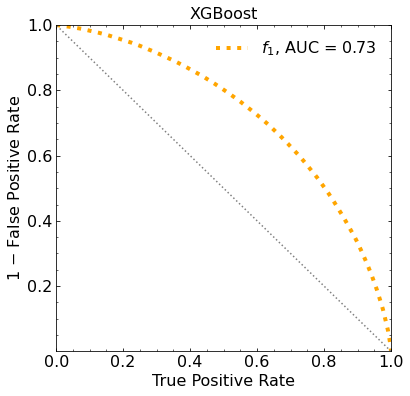

ML iteration  3
[0]	validation_0-logloss:0.67880	validation_1-logloss:0.67918


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	validation_0-logloss:0.66705	validation_1-logloss:0.66783
[2]	validation_0-logloss:0.65729	validation_1-logloss:0.65834
[3]	validation_0-logloss:0.64923	validation_1-logloss:0.65051
[4]	validation_0-logloss:0.64253	validation_1-logloss:0.64408
[5]	validation_0-logloss:0.63691	validation_1-logloss:0.63868
[6]	validation_0-logloss:0.63218	validation_1-logloss:0.63417
[7]	validation_0-logloss:0.62826	validation_1-logloss:0.63044
[8]	validation_0-logloss:0.62494	validation_1-logloss:0.62731
[9]	validation_0-logloss:0.62217	validation_1-logloss:0.62469
[10]	validation_0-logloss:0.61982	validation_1-logloss:0.62249
[11]	validation_0-logloss:0.61785	validation_1-logloss:0.62072
[12]	validation_0-logloss:0.61617	validation_1-logloss:0.61921
[13]	validation_0-logloss:0.61476	validation_1-logloss:0.61791
[14]	validation_0-logloss:0.61356	validation_1-logloss:0.61685
[15]	validation_0-logloss:0.61253	validation_1-logloss:0.61596
[16]	validation_0-logloss:0.61166	validation_1-logloss:0.61525
[

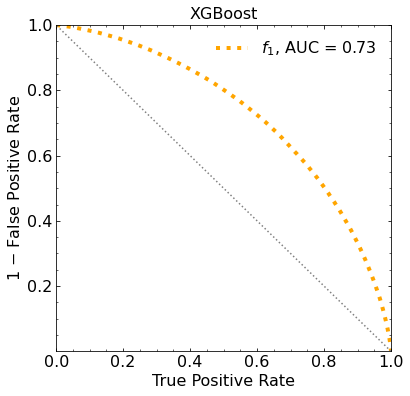

ML iteration  4


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.67884	validation_1-logloss:0.67920
[1]	validation_0-logloss:0.66709	validation_1-logloss:0.66784
[2]	validation_0-logloss:0.65736	validation_1-logloss:0.65835
[3]	validation_0-logloss:0.64933	validation_1-logloss:0.65066
[4]	validation_0-logloss:0.64263	validation_1-logloss:0.64421
[5]	validation_0-logloss:0.63701	validation_1-logloss:0.63877
[6]	validation_0-logloss:0.63234	validation_1-logloss:0.63430
[7]	validation_0-logloss:0.62839	validation_1-logloss:0.63056
[8]	validation_0-logloss:0.62508	validation_1-logloss:0.62741
[9]	validation_0-logloss:0.62230	validation_1-logloss:0.62480
[10]	validation_0-logloss:0.61995	validation_1-logloss:0.62263
[11]	validation_0-logloss:0.61798	validation_1-logloss:0.62079
[12]	validation_0-logloss:0.61630	validation_1-logloss:0.61927
[13]	validation_0-logloss:0.61488	validation_1-logloss:0.61803
[14]	validation_0-logloss:0.61367	validation_1-logloss:0.61696
[15]	validation_0-logloss:0.61264	validation_1-logloss:0.61608
[1

ML iteration  5


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.67844	validation_1-logloss:0.67896
[1]	validation_0-logloss:0.66634	validation_1-logloss:0.66736
[2]	validation_0-logloss:0.65643	validation_1-logloss:0.65795
[3]	validation_0-logloss:0.64816	validation_1-logloss:0.65010
[4]	validation_0-logloss:0.64127	validation_1-logloss:0.64357
[5]	validation_0-logloss:0.63550	validation_1-logloss:0.63813
[6]	validation_0-logloss:0.63072	validation_1-logloss:0.63364
[7]	validation_0-logloss:0.62669	validation_1-logloss:0.62987
[8]	validation_0-logloss:0.62330	validation_1-logloss:0.62680
[9]	validation_0-logloss:0.62047	validation_1-logloss:0.62421
[10]	validation_0-logloss:0.61806	validation_1-logloss:0.62203
[11]	validation_0-logloss:0.61604	validation_1-logloss:0.62023
[12]	validation_0-logloss:0.61436	validation_1-logloss:0.61873
[13]	validation_0-logloss:0.61290	validation_1-logloss:0.61750
[14]	validation_0-logloss:0.61167	validation_1-logloss:0.61648
[15]	validation_0-logloss:0.61064	validation_1-logloss:0.61565
[1

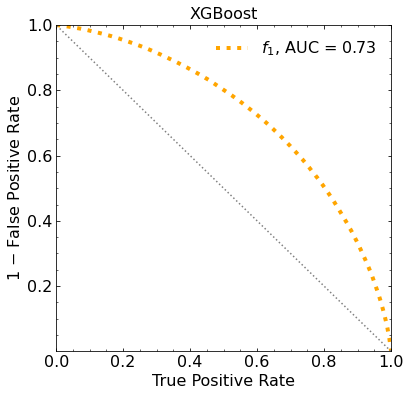

ML iteration  6


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.67856	validation_1-logloss:0.67903
[1]	validation_0-logloss:0.66658	validation_1-logloss:0.66758
[2]	validation_0-logloss:0.65675	validation_1-logloss:0.65809
[3]	validation_0-logloss:0.64854	validation_1-logloss:0.65031
[4]	validation_0-logloss:0.64170	validation_1-logloss:0.64384
[5]	validation_0-logloss:0.63601	validation_1-logloss:0.63841
[6]	validation_0-logloss:0.63122	validation_1-logloss:0.63389
[7]	validation_0-logloss:0.62719	validation_1-logloss:0.63011
[8]	validation_0-logloss:0.62382	validation_1-logloss:0.62694
[9]	validation_0-logloss:0.62100	validation_1-logloss:0.62438
[10]	validation_0-logloss:0.61860	validation_1-logloss:0.62219
[11]	validation_0-logloss:0.61658	validation_1-logloss:0.62039
[12]	validation_0-logloss:0.61488	validation_1-logloss:0.61888
[13]	validation_0-logloss:0.61345	validation_1-logloss:0.61764
[14]	validation_0-logloss:0.61222	validation_1-logloss:0.61658
[15]	validation_0-logloss:0.61117	validation_1-logloss:0.61574
[1

ML iteration  7


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.67878	validation_1-logloss:0.67913
[1]	validation_0-logloss:0.66698	validation_1-logloss:0.66765
[2]	validation_0-logloss:0.65728	validation_1-logloss:0.65820
[3]	validation_0-logloss:0.64919	validation_1-logloss:0.65038
[4]	validation_0-logloss:0.64241	validation_1-logloss:0.64381
[5]	validation_0-logloss:0.63680	validation_1-logloss:0.63844
[6]	validation_0-logloss:0.63207	validation_1-logloss:0.63394
[7]	validation_0-logloss:0.62809	validation_1-logloss:0.63016
[8]	validation_0-logloss:0.62477	validation_1-logloss:0.62706
[9]	validation_0-logloss:0.62196	validation_1-logloss:0.62441
[10]	validation_0-logloss:0.61963	validation_1-logloss:0.62225
[11]	validation_0-logloss:0.61765	validation_1-logloss:0.62045
[12]	validation_0-logloss:0.61596	validation_1-logloss:0.61891
[13]	validation_0-logloss:0.61455	validation_1-logloss:0.61762
[14]	validation_0-logloss:0.61336	validation_1-logloss:0.61658
[15]	validation_0-logloss:0.61234	validation_1-logloss:0.61569
[1

ML iteration  8


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.67887	validation_1-logloss:0.67924
[1]	validation_0-logloss:0.66718	validation_1-logloss:0.66772
[2]	validation_0-logloss:0.65753	validation_1-logloss:0.65834
[3]	validation_0-logloss:0.64952	validation_1-logloss:0.65059
[4]	validation_0-logloss:0.64282	validation_1-logloss:0.64407
[5]	validation_0-logloss:0.63723	validation_1-logloss:0.63872
[6]	validation_0-logloss:0.63258	validation_1-logloss:0.63421
[7]	validation_0-logloss:0.62865	validation_1-logloss:0.63047
[8]	validation_0-logloss:0.62538	validation_1-logloss:0.62734
[9]	validation_0-logloss:0.62259	validation_1-logloss:0.62467
[10]	validation_0-logloss:0.62026	validation_1-logloss:0.62249
[11]	validation_0-logloss:0.61829	validation_1-logloss:0.62068
[12]	validation_0-logloss:0.61662	validation_1-logloss:0.61916
[13]	validation_0-logloss:0.61521	validation_1-logloss:0.61788
[14]	validation_0-logloss:0.61401	validation_1-logloss:0.61682
[15]	validation_0-logloss:0.61299	validation_1-logloss:0.61595
[1

ML iteration  9


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.67884	validation_1-logloss:0.67910
[1]	validation_0-logloss:0.66716	validation_1-logloss:0.66771
[2]	validation_0-logloss:0.65751	validation_1-logloss:0.65822
[3]	validation_0-logloss:0.64950	validation_1-logloss:0.65044
[4]	validation_0-logloss:0.64281	validation_1-logloss:0.64400
[5]	validation_0-logloss:0.63721	validation_1-logloss:0.63860
[6]	validation_0-logloss:0.63255	validation_1-logloss:0.63412
[7]	validation_0-logloss:0.62864	validation_1-logloss:0.63038
[8]	validation_0-logloss:0.62534	validation_1-logloss:0.62724
[9]	validation_0-logloss:0.62256	validation_1-logloss:0.62462
[10]	validation_0-logloss:0.62021	validation_1-logloss:0.62245
[11]	validation_0-logloss:0.61823	validation_1-logloss:0.62060
[12]	validation_0-logloss:0.61655	validation_1-logloss:0.61909
[13]	validation_0-logloss:0.61515	validation_1-logloss:0.61780
[14]	validation_0-logloss:0.61396	validation_1-logloss:0.61674
[15]	validation_0-logloss:0.61292	validation_1-logloss:0.61584
[1

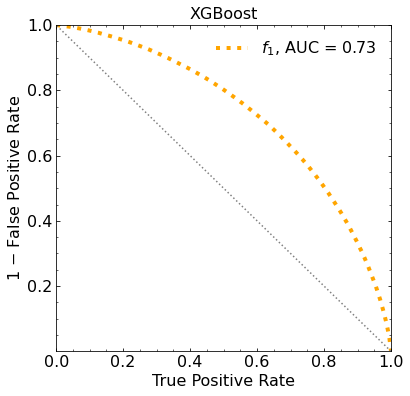

Classification score (1 ML):


Classification score (10 ML):


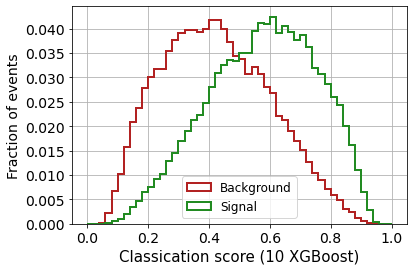

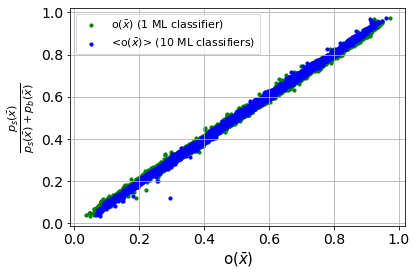


 ----------------------------------------- 

B_expected:  50000
S_expected:  500
S/$\sqrt{B}$:  2.23606797749979
 BINNED CLASSIFIER OUTPUT
  BL lineal bins, 1 ML
Z_XG 10 bins_1ML:  3.127256173861559
Z_XG 25 bins_1ML:  3.1603969647572003
Z_XG 50 bins_1ML:  3.1665998078382493
Z_XG 100 bins_1ML:  3.169263004226458

 BL non-lineal bins, 1 ML
Z_XG 10 bins_eq_1ML:  2.9786146625898646
Z_XG 25 bins_eq_1ML:  3.0723570930912936
Z_XG 50 bins_eq_1ML:  3.111430197890423
Z_XG 100 bins_eq_1ML:  3.1344187813492432

 BL lineal bins, 10 ML
Z_XG 10 bins:  3.127008761301311
Z_XG 25 bins:  3.1632042727504666
Z_XG 50 bins:  3.1698087291809154
Z_XG 100 bins:  3.1729035462054873

 BL non-lineal bins, 10 ML
Z_XG 10 bins_eq:  2.979540076824839
Z_XG 25 bins_eq:  3.072683903955418
Z_XG 50 bins_eq:  3.111430249737402
Z_XG 100 bins_eq:  3.136040746726077

 ----------------------------------------- 


 If  20200  =  1101    then the proposed range has to be extended
n_ensembles (actual):  9863
TRUE PDF LIKELIHOOD (

muhat mean:  0.07904288755956607
Z_gaussian:  3.5228059607744817
Z_gaussian_mu0:  3.5228059607744817

 ------------------------------------ 

 MLL + KDE (1ML) 


/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf  1351.85620801
  1348.41488141  1345.74689495  1342.87062746  1338.32273514
  1326.41212367  1300.99573666  1244.23080287  1119.36006435
   854.33123217   323.04747851  -595.56480747 -1822.78705512]
  warnings.warn(
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:929: RuntimeWarning: invalid value encountered in subtract
  array_stds = np.sqrt(np.average((array -
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf  1393.79230569  1372.98933387  1361.36260164
  1357.60511387  1356.11030565  1352.73011849  1346.98827515
  13

KDE Kernel:  epanechnikov
Background bandwidth:  0.01329487353451575
Signal bandwidth:  0.0063479219593504735


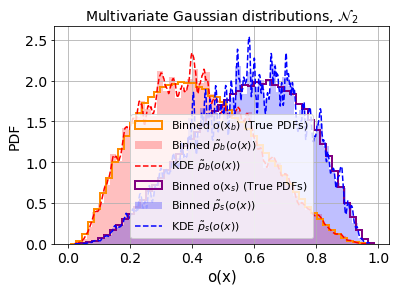

 MLL + KDE (10ML) 


/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf  1417.31305651  1419.61282771
  1421.29686625  1420.03111299  1417.76360696  1412.56709934
  1400.33692615  1371.32012947  1309.2485724   1178.2886777
   903.6970216    356.82175734  -579.14336464 -1815.61543598]
  warnings.warn(
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:929: RuntimeWarning: invalid value encountered in subtract
  array_stds = np.sqrt(np.average((array -
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf           -inf  1421.3575727
  1421.80177853  1420.72652614  1419.52133169  1415.24013197
  1403

KDE Kernel:  epanechnikov
Background bandwidth:  0.01924024182760239
Signal bandwidth:  0.01924024182760239


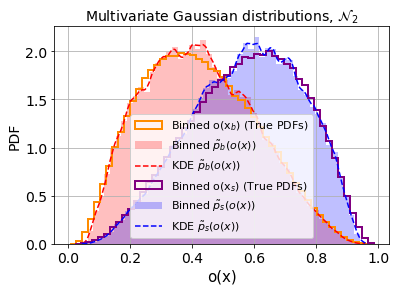

 Z MLL+KDE (1ML) 


muhat mean_1ML:  0.4598093886241509
Z_KDE_1ML:  1.4556556156811518
Z_KDE mu=0_1ML:  0.0

 Z MLL+KDE (10ML) 


muhat mean:  0.10365000506945149
Z_KDE:  3.356690481027089
Z_KDE mu=0:  3.356690481027089

 ------------------------------------ 



In [118]:
dim=2

#######################
# generate the events #
#######################
    
mean_sig = epsilon*np.ones(dim)
mean_bkg = -1*mean_sig

#cov_sig = np.identity(dim)
cov_sig = np.identity(dim) + (0. * ( np.ones((dim,dim)) - np.identity(dim) ))
cov_bkg = cov_sig

signal_X_1, signal_X_2 = np.random.multivariate_normal(mean_sig, cov_sig, N).T
background_X_1, background_X_2 = np.random.multivariate_normal(mean_bkg, cov_bkg, N).T

dim1 = np.concatenate((background_X_1,signal_X_1))
dim2 = np.concatenate((background_X_2,signal_X_2))

# labels
background_Y = np.zeros(N)
signal_Y = np.ones(N)

# DATA in a single matrix (features + labels)
df = pd.DataFrame()
df['dim1'] = dim1.reshape(-1)
df['dim2'] = dim2.reshape(-1)
df['Y'] = np.concatenate((background_Y.astype('int'),signal_Y.astype('int')))

X_gauss = df[['dim1','dim2']].values 
Y_gauss = df[['Y']].values

# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.5

X_gauss_aux, X_gauss_test, Y_gauss_aux, Y_gauss_test = train_test_split(X_gauss,
                                                                Y_gauss,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_gauss,
                                                                shuffle=True)


X_gauss_train, X_gauss_val, Y_gauss_train, Y_gauss_val = train_test_split(X_gauss_aux,
                                                                  Y_gauss_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_gauss_aux,
                                                                  shuffle=True)

print('')
print('X_gauss_train : ', X_gauss_train.shape)
print('y_gauss_train : ', Y_gauss_train.shape)
print('X_gauss_val : ', X_gauss_val.shape)
print('y_gauss_val : ', Y_gauss_val.shape)
print('X_gauss_test : ', X_gauss_test.shape)
print('y_gauss_test : ', Y_gauss_test.shape)
print('')


# PLOT (only 1st feature) to visualize the data
X_gauss_test_SM = []
X_gauss_test_NP = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] ==0:
        X_gauss_test_SM.append(X_gauss_test[i].tolist())
    else:
        X_gauss_test_NP.append(X_gauss_test[i].tolist())    


X_gauss_test_SM = np.array(X_gauss_test_SM)
X_gauss_test_NP = np.array(X_gauss_test_NP)


weights = np.ones_like(X_gauss_test_SM[:,0])/float(len(X_gauss_test_SM[:,0]))
plt.hist(X_gauss_test_SM[:,0], 20, histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(X_gauss_test_NP[:,0])/float(len(X_gauss_test_NP[:,0]))
plt.hist(X_gauss_test_NP[:,0], 20, histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$x_1$",fontsize=16)
plt.ylabel("Fraction of events",fontsize=16)
plt.grid()
plt.legend(fontsize=14)
plt.title(r"Gaussian (dim=%0.2d)" % dim,fontsize=14)
plt.show()  






################################
# the true pdfs (useful later) #
################################

sig_multi = multivariate_normal(mean_sig, cov_sig)
bkg_multi = multivariate_normal(mean_bkg, cov_bkg) 




#######################
# CLASSIFIER: XGBoost #
#######################

# only 1 ML
roc_auc_XG, y_pred_xg_1ML = XG(X_gauss_train, X_gauss_test, X_gauss_val, Y_gauss_train, Y_gauss_test, Y_gauss_val)

store_AUC.append(roc_auc_XG)


# Bagging

print('ML iteration 0')
roc_auc_XG, y_pred_xg_aux = XG(X_gauss_train[:100000], X_gauss_test, X_gauss_val, Y_gauss_train[:100000], Y_gauss_test, Y_gauss_val)
y_pred_xg_auxRE = np.reshape(y_pred_xg_aux, (1,len(y_pred_xg_aux)))

for it in range(1,iterations_ML):

    print('ML iteration ', it)
    roc_auc_XG, y_pred_xg_aux_it = XG(X_gauss_train[(100000*it):(100000*it)+100000], X_gauss_test, X_gauss_val, Y_gauss_train[(100000*it):(100000*it)+100000], Y_gauss_test, Y_gauss_val)
    
    y_pred_xg_auxRE_it = np.reshape(y_pred_xg_aux_it, (1,len(y_pred_xg_aux_it)))
    
    y_pred_xg_auxRE = np.concatenate([y_pred_xg_auxRE,y_pred_xg_auxRE_it])

# to smooth, mean of 10 predictions
y_pred_xg = np.mean(y_pred_xg_auxRE, axis=0)




########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

# 1 ML
pred_XG_SM_1ML = []
pred_XG_NP_1ML = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] == 0:
        pred_XG_SM_1ML.append(y_pred_xg_1ML[i])
    else:
        pred_XG_NP_1ML.append(y_pred_xg_1ML[i])
        
# Bagging  
pred_XG_SM = []
pred_XG_NP = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score (1 ML):')
        
weights = np.ones_like(pred_XG_SM_1ML)/float(len(pred_XG_SM_1ML))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM_1ML, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP_1ML)/float(len(pred_XG_NP_1ML))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP_1ML, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12, loc="lower center")
plt.show()


print('Classification score (10 ML):')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (10 XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12, loc="lower center")
plt.show()




ratio_ps_pb_true = sig_multi.pdf(X_gauss_test) / ( sig_multi.pdf(X_gauss_test) + bkg_multi.pdf(X_gauss_test) )
ratio_ps_pb_true_B = sig_multi.pdf(X_gauss_test_SM) / ( sig_multi.pdf(X_gauss_test_SM) + bkg_multi.pdf(X_gauss_test_SM) )
ratio_ps_pb_true_S = sig_multi.pdf(X_gauss_test_NP) / ( sig_multi.pdf(X_gauss_test_NP) + bkg_multi.pdf(X_gauss_test_NP) )

plt.scatter(y_pred_xg_1ML[:10000], ratio_ps_pb_true[:10000], color='green', label=r'o($\bar{x}$) (1 ML classifier)', s=10)
plt.scatter(y_pred_xg[:10000], ratio_ps_pb_true[:10000], color='blue', label=r'<o($\bar{x}$)> (10 ML classifiers)', s=10)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r"o($\bar{x}$)",fontsize=15)
plt.ylabel(r"$\frac{p_s(\bar{x})}{p_s(\bar{x})+p_b(\bar{x})}$",fontsize=16)
plt.grid()
plt.legend(fontsize=11)
#plt.savefig('images/' + 'optimalclass-vs-ox.pdf', format="pdf", bbox_inches="tight")
plt.show()

print('\n ----------------------------------------- \n')






###########
# METHODS #
###########

print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)



############################
# BINNED CLASSIFIER OUTPUT #
############################

print(' BINNED CLASSIFIER OUTPUT')

print('  BL lineal bins, 1 ML')

# 10 BINS
Z_bins_XG_10bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 10, [[0,1]], linear_bins=True)
store_Z_bins_XG_10bins_1ML.append(Z_bins_XG_10bins_1ML)
print('Z_XG 10 bins_1ML: ', Z_bins_XG_10bins_1ML)

# 25 BINS
Z_bins_XG_25bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 25, [[0,1]], linear_bins=True)
store_Z_bins_XG_25bins_1ML.append(Z_bins_XG_25bins_1ML)
print('Z_XG 25 bins_1ML: ', Z_bins_XG_25bins_1ML)

# 50 BINS
Z_bins_XG_50bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 50, [[0,1]], linear_bins=True)
store_Z_bins_XG_50bins_1ML.append(Z_bins_XG_50bins_1ML)
print('Z_XG 50 bins_1ML: ', Z_bins_XG_50bins_1ML)

# 100 BINS
Z_bins_XG_100bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 100, [[0,1]], linear_bins=True)
store_Z_bins_XG_100bins_1ML.append(Z_bins_XG_100bins_1ML)
print('Z_XG 100 bins_1ML: ', Z_bins_XG_100bins_1ML)


print('\n BL non-lineal bins, 1 ML')

# 10 BINS
Z_bins_XG_10bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 10, [[0,1]], linear_bins=False)
store_Z_bins_XG_10bins_eq_1ML.append(Z_bins_XG_10bins_eq_1ML)
print('Z_XG 10 bins_eq_1ML: ', Z_bins_XG_10bins_eq_1ML)

# 25 BINS
Z_bins_XG_25bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 25, [[0,1]], linear_bins=False)
store_Z_bins_XG_25bins_eq_1ML.append(Z_bins_XG_25bins_eq_1ML)
print('Z_XG 25 bins_eq_1ML: ', Z_bins_XG_25bins_eq_1ML)

# 50 BINS
Z_bins_XG_50bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 50, [[0,1]], linear_bins=False)
store_Z_bins_XG_50bins_eq_1ML.append(Z_bins_XG_50bins_eq_1ML)
print('Z_XG 50 bins_eq_1ML: ', Z_bins_XG_50bins_eq_1ML)

# 100 BINS
Z_bins_XG_100bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 100, [[0,1]], linear_bins=False)
store_Z_bins_XG_100bins_eq_1ML.append(Z_bins_XG_100bins_eq_1ML)
print('Z_XG 100 bins_eq_1ML: ', Z_bins_XG_100bins_eq_1ML)


print('\n BL lineal bins, 10 ML')

# 10 BINS
Z_bins_XG_10bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 10, [[0,1]], linear_bins=True)
store_Z_bins_XG_10bins.append(Z_bins_XG_10bins)
print('Z_XG 10 bins: ', Z_bins_XG_10bins)

# 25 BINS
Z_bins_XG_25bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 25, [[0,1]], linear_bins=True)
store_Z_bins_XG_25bins.append(Z_bins_XG_25bins)
print('Z_XG 25 bins: ', Z_bins_XG_25bins)

# 50 BINS
Z_bins_XG_50bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 50, [[0,1]], linear_bins=True)
store_Z_bins_XG_50bins.append(Z_bins_XG_50bins)
print('Z_XG 50 bins: ', Z_bins_XG_50bins)

# 100 BINS
Z_bins_XG_100bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 100, [[0,1]], linear_bins=True)
store_Z_bins_XG_100bins.append(Z_bins_XG_100bins)
print('Z_XG 100 bins: ', Z_bins_XG_100bins)


print('\n BL non-lineal bins, 10 ML')

# 10 BINS
Z_bins_XG_10bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 10, [[0,1]], linear_bins=False)
store_Z_bins_XG_10bins_eq.append(Z_bins_XG_10bins_eq)
print('Z_XG 10 bins_eq: ', Z_bins_XG_10bins_eq)

# 25 BINS
Z_bins_XG_25bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 25, [[0,1]], linear_bins=False)
store_Z_bins_XG_25bins_eq.append(Z_bins_XG_25bins_eq)
print('Z_XG 25 bins_eq: ', Z_bins_XG_25bins_eq)

# 50 BINS
Z_bins_XG_50bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 50, [[0,1]], linear_bins=False)
store_Z_bins_XG_50bins_eq.append(Z_bins_XG_50bins_eq)
print('Z_XG 50 bins_eq: ', Z_bins_XG_50bins_eq)

# 100 BINS
Z_bins_XG_100bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 100, [[0,1]], linear_bins=False)
store_Z_bins_XG_100bins_eq.append(Z_bins_XG_100bins_eq)
print('Z_XG 100 bins_eq: ', Z_bins_XG_100bins_eq)


print('\n ----------------------------------------- \n')






###########################
# SET THE TOY EXPERIMENTS #
###########################

list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles = ensembler(B_expected, S_expected, n_ensembles)






###################################
# TRUE PDF LIKELIHOOD (GAUSSIANS) #
###################################

indices = [i for i in range(len(X_gauss_test_SM))]

prob_B_given_B = bkg_multi.pdf(X_gauss_test_SM)
prob_B_given_S = sig_multi.pdf(X_gauss_test_SM)



print('TRUE PDF LIKELIHOOD (GAUSSIANS):')

print('n_ensembles (initial): ', n_ensembles)

Z_gaussian, muhat_mean_gaussian, Z_gaussian_mu0, muhat_selected_list, q_muhat, q_muhat_mu0 = Z_MLL(B_expected, S_expected, prob_B_given_B, prob_B_given_S, list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles)

# Histogram of q_muhats

weights = np.ones_like(q_muhat)/float(len(q_muhat))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()

store_muhat_mean_gaussian.append(muhat_mean_gaussian)
store_Z_gaussian.append(Z_gaussian)

store_Z_gaussian_mu0.append(Z_gaussian_mu0)

print('muhat mean: ', muhat_mean_gaussian)
print('Z_gaussian: ', Z_gaussian)
print('Z_gaussian_mu0: ', Z_gaussian_mu0)


print('\n ------------------------------------ \n')







#########
#  KDE  #
#########  

print(' MLL + KDE (1ML) ')

kde_bkg_1ML, kde_sig_1ML, B_bandwidth_1ML, S_bandwidth_1ML = KDE_finder(pred_XG_SM_1ML, pred_XG_NP_1ML, events_to_fit=20000, bandwidth_space=np.logspace(-2.2, -1.5, 5))


# range (~between 0 and 1)
min_val_1ML = np.min([np.min(pred_XG_SM_1ML),np.min(pred_XG_NP_1ML)])
max_val_1ML = np.max([np.max(pred_XG_SM_1ML),np.max(pred_XG_NP_1ML)])

s_vals_1ML = np.linspace(min_val_1ML,max_val_1ML,1000)



# evaluate the densities for each value of s (~bins)
dens_bkg_1ML = np.exp(kde_bkg_1ML.score_samples(np.c_[s_vals_1ML, np.zeros(len(s_vals_1ML)) ]) )
dens_sig_1ML = np.exp(kde_sig_1ML.score_samples(np.c_[s_vals_1ML, np.ones(len(s_vals_1ML)) ]) )



# Normalize to 1
# Area
factor_aux_SM_1ML = sum(dens_bkg_1ML*(s_vals_1ML[1]-s_vals_1ML[0]))
factor_aux_NP_1ML = sum(dens_sig_1ML*(s_vals_1ML[1]-s_vals_1ML[0]))

# normalize
dens_bkg_1ML = dens_bkg_1ML / factor_aux_SM_1ML
dens_sig_1ML = dens_sig_1ML / factor_aux_NP_1ML





# plot to check the estimation

plt.figure()

plt.hist(ratio_ps_pb_true_B,density=True,bins=50,lw=2,histtype='step',color='darkorange',alpha=1,label=r'Binned o(x$_b$) (True PDFs)')
plt.hist(pred_XG_SM_1ML,density=True,bins=50,color='red',alpha=0.25,label=r'Binned $\tilde{p}_{b}(o(x))$');
plt.plot(s_vals_1ML,dens_bkg_1ML,color='red',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');

plt.hist(ratio_ps_pb_true_S,density=True,bins=50,lw=2,histtype='step',color='purple',alpha=1,label=r'Binned o(x$_s$) (True PDFs)');
plt.hist(pred_XG_NP_1ML,density=True,bins=50,color='blue',alpha=0.25,label=r'Binned $\tilde{p}_{s}(o(x))$');
plt.plot(s_vals_1ML,dens_sig_1ML,color='blue',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("o(x)",fontsize=15)
plt.ylabel("PDF",fontsize=14)
plt.grid()
plt.legend(loc="lower center", fontsize=11, handlelength=2.5)
plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{2}$', fontsize=14)
#plt.savefig('images/' + '2gaussian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()





print(' MLL + KDE (10ML) ')

kde_bkg, kde_sig, B_bandwidth, S_bandwidth = KDE_finder(pred_XG_SM, pred_XG_NP, events_to_fit=20000, bandwidth_space=np.logspace(-2.2, -1.5, 5))


# range (~between 0 and 1)
min_val = np.min([np.min(pred_XG_SM),np.min(pred_XG_NP)])
max_val = np.max([np.max(pred_XG_SM),np.max(pred_XG_NP)])

s_vals = np.linspace(min_val,max_val,1000)



# evaluate the densities for each value of s (~bins)
dens_bkg = np.exp(kde_bkg.score_samples(np.c_[s_vals, np.zeros(len(s_vals)) ]) )
dens_sig = np.exp(kde_sig.score_samples(np.c_[s_vals, np.ones(len(s_vals)) ]) )



# Normalize to 1
# Area
factor_aux_SM = sum(dens_bkg*(s_vals[1]-s_vals[0]))
factor_aux_NP = sum(dens_sig*(s_vals[1]-s_vals[0]))

# normalize
dens_bkg = dens_bkg / factor_aux_SM
dens_sig = dens_sig / factor_aux_NP





# plot to check the estimation

plt.figure()

plt.hist(ratio_ps_pb_true_B,density=True,bins=50,lw=2,histtype='step',color='darkorange',alpha=1,label=r'Binned o(x$_b$) (True PDFs)')
plt.hist(pred_XG_SM,density=True,bins=50,color='red',alpha=0.25,label=r'Binned $\tilde{p}_{b}(o(x))$');
plt.plot(s_vals,dens_bkg,color='red',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');

plt.hist(ratio_ps_pb_true_S,density=True,bins=50,lw=2,histtype='step',color='purple',alpha=1,label=r'Binned o(x$_s$) (True PDFs)');
plt.hist(pred_XG_NP,density=True,bins=50,color='blue',alpha=0.25,label=r'Binned $\tilde{p}_{s}(o(x))$');
plt.plot(s_vals,dens_sig,color='blue',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("o(x)",fontsize=15)
plt.ylabel("PDF",fontsize=14)
plt.grid()
plt.legend(loc="lower center", fontsize=11, handlelength=2.5)
plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{2}$', fontsize=14)
#plt.savefig('images/' + '2gaussian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()






#############
# MLL + KDE #
#############

print(' Z MLL+KDE (1ML) ')
# FOR EXCLUSION:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

KDE_SM_pred_SM_1ML = np.exp(kde_bkg_1ML.score_samples(np.c_[pred_XG_SM_1ML, np.zeros(len(pred_XG_SM_1ML)) ]) )
KDE_NP_pred_SM_1ML = np.exp(kde_sig_1ML.score_samples(np.c_[pred_XG_SM_1ML, np.ones(len(pred_XG_SM_1ML)) ]) )

# Normalize

KDE_SM_pred_SM_1ML = KDE_SM_pred_SM_1ML / factor_aux_SM_1ML
KDE_NP_pred_SM_1ML = KDE_NP_pred_SM_1ML / factor_aux_NP_1ML


indices_1ML = [i for i in range(len(KDE_NP_pred_SM_1ML))]

prob_B_given_B_1ML = KDE_SM_pred_SM_1ML
prob_B_given_S_1ML = KDE_NP_pred_SM_1ML

Z_KDE_1ML, muhat_mean_MLL_KDE_1ML, Z_KDE_mu0_1ML, muhat_selected_list_1ML, q_muhat_1ML, q_muhat_mu0_1ML = Z_MLL(B_expected, S_expected, prob_B_given_B_1ML, prob_B_given_S_1ML, list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles)
    
    
# Histogram of q_muhats

weights = np.ones_like(q_muhat_1ML)/float(len(q_muhat_1ML))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat_1ML, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()


store_muhat_mean_MLL_KDE_1ML.append(muhat_mean_MLL_KDE_1ML)
store_Z_MLL_KDE_1ML.append(Z_KDE_1ML)

store_Z_MLL_KDE_mu0_1ML.append(Z_KDE_mu0_1ML)

print('muhat mean_1ML: ', muhat_mean_MLL_KDE_1ML)
print('Z_KDE_1ML: ', Z_KDE_1ML)
print('Z_KDE mu=0_1ML: ', Z_KDE_mu0_1ML)



print('\n Z MLL+KDE (10ML) ')
# FOR EXCLUSION:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

KDE_SM_pred_SM = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
KDE_NP_pred_SM = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )

# Normalize

KDE_SM_pred_SM = KDE_SM_pred_SM / factor_aux_SM
KDE_NP_pred_SM = KDE_NP_pred_SM / factor_aux_NP


indices = [i for i in range(len(KDE_NP_pred_SM))]

prob_B_given_B = KDE_SM_pred_SM
prob_B_given_S = KDE_NP_pred_SM

Z_KDE, muhat_mean_MLL_KDE, Z_KDE_mu0, muhat_selected_list, q_muhat, q_muhat_mu0 = Z_MLL(B_expected, S_expected, prob_B_given_B, prob_B_given_S, list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles)
    
    
# Histogram of q_muhats

weights = np.ones_like(q_muhat)/float(len(q_muhat))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()


store_muhat_mean_MLL_KDE.append(muhat_mean_MLL_KDE)
store_Z_MLL_KDE.append(Z_KDE)

store_Z_MLL_KDE_mu0.append(Z_KDE_mu0)

print('muhat mean: ', muhat_mean_MLL_KDE)
print('Z_KDE: ', Z_KDE)
print('Z_KDE mu=0: ', Z_KDE_mu0)

print('\n ------------------------------------ \n')

In [140]:
print(roc_auc_XG)

print(Z_bins_XG_10bins_1ML)
print(Z_bins_XG_25bins_1ML)
print(Z_bins_XG_50bins_1ML)
print(Z_bins_XG_100bins_1ML)

print(Z_bins_XG_10bins_eq_1ML)
print(Z_bins_XG_25bins_eq_1ML)
print(Z_bins_XG_50bins_eq_1ML)
print(Z_bins_XG_100bins_eq_1ML)

print(Z_bins_XG_10bins)
print(Z_bins_XG_25bins)
print(Z_bins_XG_50bins)
print(Z_bins_XG_100bins)

print(Z_bins_XG_10bins_eq)
print(Z_bins_XG_25bins_eq)
print(Z_bins_XG_50bins_eq)
print(Z_bins_XG_100bins_eq)

print(muhat_mean_gaussian)
print(Z_gaussian)
print(Z_gaussian_mu0)

print(muhat_mean_MLL_KDE)
print(Z_KDE)
print(Z_KDE_mu0)

print(muhat_mean_MLL_KDE_1ML)
print(Z_KDE_1ML)
print(Z_KDE_mu0_1ML)

0.6640419761453911
2.6376071686718165
2.6585020039390885
2.6614529625578567
2.663328107275102
2.609867949209768
2.63893545441564
2.647042121949209
2.65469854623499
2.6374984722271364
2.657196087042973
2.661572987384849
2.6632072736679375
2.6099464874382785
2.6382266590596406
2.6479234396276676
2.6543276035393917
0.13716921829058096
2.7543357702550173
2.7543357702550173
0.11894454020075029
2.857584445428654
2.857584445428654
0.0
0.0
0.0


In [ ]:
store_AUC.append()

store_Z_bins_XG_10bins_1ML.append()
store_Z_bins_XG_25bins_1ML.append()
store_Z_bins_XG_50bins_1ML.append()
store_Z_bins_XG_100bins_1ML.append()

store_Z_bins_XG_10bins_eq_1ML.append()
store_Z_bins_XG_25bins_eq_1ML.append()
store_Z_bins_XG_50bins_eq_1ML.append()
store_Z_bins_XG_100bins_eq_1ML.append()

store_Z_bins_XG_10bins.append()
store_Z_bins_XG_25bins.append()
store_Z_bins_XG_50bins.append()
store_Z_bins_XG_100bins.append()

store_Z_bins_XG_10bins_eq.append()
store_Z_bins_XG_25bins_eq.append()
store_Z_bins_XG_50bins_eq.append()
store_Z_bins_XG_100bins_eq.append()

store_muhat_mean_gaussian.append()
store_Z_gaussian.append()
store_Z_gaussian_mu0.append()

store_muhat_mean_MLL_KDE.append()
store_Z_MLL_KDE.append()
store_Z_MLL_KDE_mu0.append()

store_muhat_mean_MLL_KDE_1ML.append()
store_Z_MLL_KDE_1ML.append()
store_Z_MLL_KDE_mu0_1ML.append()


X_gauss_train :  (1000000, 3)
y_gauss_train :  (1000000, 1)
X_gauss_val :  (1000000, 3)
y_gauss_val :  (1000000, 1)
X_gauss_test :  (1000000, 3)
y_gauss_test :  (1000000, 1)



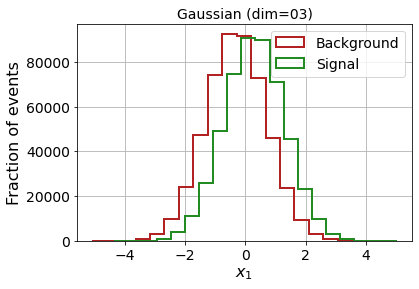

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.67558	validation_1-logloss:0.67572
[1]	validation_0-logloss:0.66085	validation_1-logloss:0.66109
[2]	validation_0-logloss:0.64855	validation_1-logloss:0.64885
[3]	validation_0-logloss:0.63821	validation_1-logloss:0.63858
[4]	validation_0-logloss:0.62937	validation_1-logloss:0.62982
[5]	validation_0-logloss:0.62188	validation_1-logloss:0.62238
[6]	validation_0-logloss:0.61543	validation_1-logloss:0.61600
[7]	validation_0-logloss:0.60993	validation_1-logloss:0.61058
[8]	validation_0-logloss:0.60518	validation_1-logloss:0.60590
[9]	validation_0-logloss:0.60111	validation_1-logloss:0.60188
[10]	validation_0-logloss:0.59754	validation_1-logloss:0.59838
[11]	validation_0-logloss:0.59447	validation_1-logloss:0.59535
[12]	validation_0-logloss:0.59179	validation_1-logloss:0.59271
[13]	validation_0-logloss:0.58944	validation_1-logloss:0.59042
[14]	validation_0-logloss:0.58740	validation_1-logloss:0.58843
[15]	validation_0-logloss:0.58563	validation_1-logloss:0.58669
[1

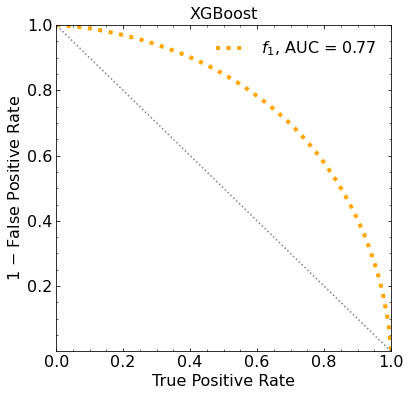

ML iteration 0
[0]	validation_0-logloss:0.67497	validation_1-logloss:0.67543


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	validation_0-logloss:0.65978	validation_1-logloss:0.66075
[2]	validation_0-logloss:0.64708	validation_1-logloss:0.64845
[3]	validation_0-logloss:0.63630	validation_1-logloss:0.63812
[4]	validation_0-logloss:0.62719	validation_1-logloss:0.62938
[5]	validation_0-logloss:0.61930	validation_1-logloss:0.62186
[6]	validation_0-logloss:0.61264	validation_1-logloss:0.61554
[7]	validation_0-logloss:0.60692	validation_1-logloss:0.61007
[8]	validation_0-logloss:0.60197	validation_1-logloss:0.60541
[9]	validation_0-logloss:0.59769	validation_1-logloss:0.60141
[10]	validation_0-logloss:0.59401	validation_1-logloss:0.59798
[11]	validation_0-logloss:0.59077	validation_1-logloss:0.59498
[12]	validation_0-logloss:0.58795	validation_1-logloss:0.59239
[13]	validation_0-logloss:0.58550	validation_1-logloss:0.59014
[14]	validation_0-logloss:0.58335	validation_1-logloss:0.58816
[15]	validation_0-logloss:0.58145	validation_1-logloss:0.58649
[16]	validation_0-logloss:0.57981	validation_1-logloss:0.58504
[

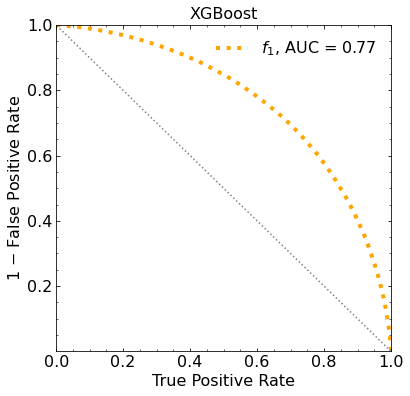

ML iteration  1
[0]	validation_0-logloss:0.67503	validation_1-logloss:0.67538


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	validation_0-logloss:0.66007	validation_1-logloss:0.66095
[2]	validation_0-logloss:0.64749	validation_1-logloss:0.64867
[3]	validation_0-logloss:0.63689	validation_1-logloss:0.63847
[4]	validation_0-logloss:0.62790	validation_1-logloss:0.62970
[5]	validation_0-logloss:0.62009	validation_1-logloss:0.62224
[6]	validation_0-logloss:0.61346	validation_1-logloss:0.61581
[7]	validation_0-logloss:0.60781	validation_1-logloss:0.61041
[8]	validation_0-logloss:0.60291	validation_1-logloss:0.60574
[9]	validation_0-logloss:0.59869	validation_1-logloss:0.60175
[10]	validation_0-logloss:0.59504	validation_1-logloss:0.59827
[11]	validation_0-logloss:0.59187	validation_1-logloss:0.59529
[12]	validation_0-logloss:0.58910	validation_1-logloss:0.59270
[13]	validation_0-logloss:0.58667	validation_1-logloss:0.59045
[14]	validation_0-logloss:0.58457	validation_1-logloss:0.58851
[15]	validation_0-logloss:0.58272	validation_1-logloss:0.58680
[16]	validation_0-logloss:0.58110	validation_1-logloss:0.58533
[

ML iteration  2


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.67496	validation_1-logloss:0.67550
[1]	validation_0-logloss:0.65991	validation_1-logloss:0.66087
[2]	validation_0-logloss:0.64721	validation_1-logloss:0.64863
[3]	validation_0-logloss:0.63642	validation_1-logloss:0.63823
[4]	validation_0-logloss:0.62726	validation_1-logloss:0.62944
[5]	validation_0-logloss:0.61947	validation_1-logloss:0.62195
[6]	validation_0-logloss:0.61270	validation_1-logloss:0.61550
[7]	validation_0-logloss:0.60695	validation_1-logloss:0.61003
[8]	validation_0-logloss:0.60200	validation_1-logloss:0.60538
[9]	validation_0-logloss:0.59775	validation_1-logloss:0.60137
[10]	validation_0-logloss:0.59406	validation_1-logloss:0.59789
[11]	validation_0-logloss:0.59087	validation_1-logloss:0.59493
[12]	validation_0-logloss:0.58805	validation_1-logloss:0.59235
[13]	validation_0-logloss:0.58561	validation_1-logloss:0.59010
[14]	validation_0-logloss:0.58348	validation_1-logloss:0.58816
[15]	validation_0-logloss:0.58162	validation_1-logloss:0.58649
[1

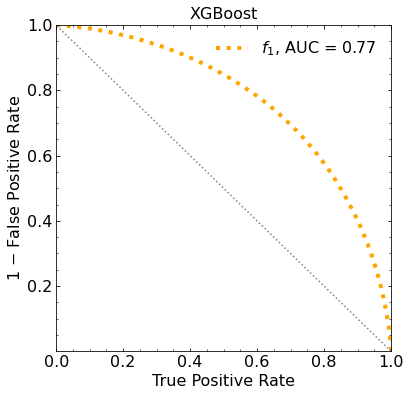

ML iteration  3
[0]	validation_0-logloss:0.67495	validation_1-logloss:0.67549


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	validation_0-logloss:0.65998	validation_1-logloss:0.66088
[2]	validation_0-logloss:0.64731	validation_1-logloss:0.64870
[3]	validation_0-logloss:0.63668	validation_1-logloss:0.63835
[4]	validation_0-logloss:0.62765	validation_1-logloss:0.62965
[5]	validation_0-logloss:0.61999	validation_1-logloss:0.62227
[6]	validation_0-logloss:0.61337	validation_1-logloss:0.61589
[7]	validation_0-logloss:0.60768	validation_1-logloss:0.61046
[8]	validation_0-logloss:0.60277	validation_1-logloss:0.60585
[9]	validation_0-logloss:0.59854	validation_1-logloss:0.60184
[10]	validation_0-logloss:0.59487	validation_1-logloss:0.59838
[11]	validation_0-logloss:0.59169	validation_1-logloss:0.59539
[12]	validation_0-logloss:0.58892	validation_1-logloss:0.59280
[13]	validation_0-logloss:0.58652	validation_1-logloss:0.59058
[14]	validation_0-logloss:0.58438	validation_1-logloss:0.58863
[15]	validation_0-logloss:0.58254	validation_1-logloss:0.58695
[16]	validation_0-logloss:0.58092	validation_1-logloss:0.58546
[

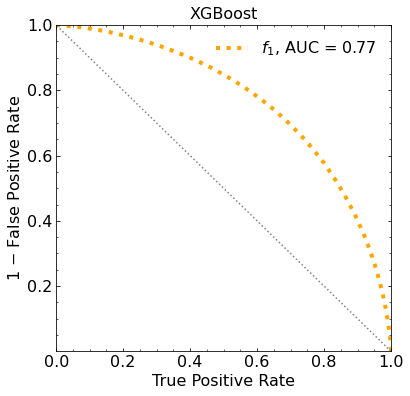

ML iteration  4


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.67506	validation_1-logloss:0.67541
[1]	validation_0-logloss:0.65999	validation_1-logloss:0.66073
[2]	validation_0-logloss:0.64743	validation_1-logloss:0.64845
[3]	validation_0-logloss:0.63676	validation_1-logloss:0.63811
[4]	validation_0-logloss:0.62770	validation_1-logloss:0.62933
[5]	validation_0-logloss:0.61996	validation_1-logloss:0.62187
[6]	validation_0-logloss:0.61335	validation_1-logloss:0.61560
[7]	validation_0-logloss:0.60765	validation_1-logloss:0.61020
[8]	validation_0-logloss:0.60276	validation_1-logloss:0.60553
[9]	validation_0-logloss:0.59846	validation_1-logloss:0.60146
[10]	validation_0-logloss:0.59475	validation_1-logloss:0.59797
[11]	validation_0-logloss:0.59150	validation_1-logloss:0.59497
[12]	validation_0-logloss:0.58871	validation_1-logloss:0.59239
[13]	validation_0-logloss:0.58627	validation_1-logloss:0.59013
[14]	validation_0-logloss:0.58413	validation_1-logloss:0.58818
[15]	validation_0-logloss:0.58225	validation_1-logloss:0.58652
[1

ML iteration  5


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.67488	validation_1-logloss:0.67535
[1]	validation_0-logloss:0.65968	validation_1-logloss:0.66060
[2]	validation_0-logloss:0.64704	validation_1-logloss:0.64832
[3]	validation_0-logloss:0.63632	validation_1-logloss:0.63804
[4]	validation_0-logloss:0.62725	validation_1-logloss:0.62930
[5]	validation_0-logloss:0.61953	validation_1-logloss:0.62187
[6]	validation_0-logloss:0.61289	validation_1-logloss:0.61559
[7]	validation_0-logloss:0.60719	validation_1-logloss:0.61014
[8]	validation_0-logloss:0.60223	validation_1-logloss:0.60549
[9]	validation_0-logloss:0.59797	validation_1-logloss:0.60145
[10]	validation_0-logloss:0.59427	validation_1-logloss:0.59798
[11]	validation_0-logloss:0.59103	validation_1-logloss:0.59499
[12]	validation_0-logloss:0.58825	validation_1-logloss:0.59247
[13]	validation_0-logloss:0.58580	validation_1-logloss:0.59022
[14]	validation_0-logloss:0.58364	validation_1-logloss:0.58826
[15]	validation_0-logloss:0.58176	validation_1-logloss:0.58653
[1

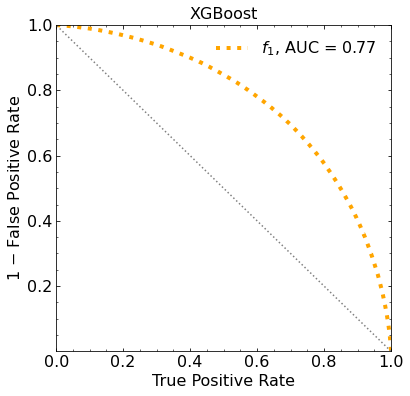

ML iteration  6


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.67502	validation_1-logloss:0.67556
[1]	validation_0-logloss:0.66002	validation_1-logloss:0.66080
[2]	validation_0-logloss:0.64745	validation_1-logloss:0.64861
[3]	validation_0-logloss:0.63683	validation_1-logloss:0.63828
[4]	validation_0-logloss:0.62777	validation_1-logloss:0.62949
[5]	validation_0-logloss:0.62009	validation_1-logloss:0.62213
[6]	validation_0-logloss:0.61347	validation_1-logloss:0.61582
[7]	validation_0-logloss:0.60777	validation_1-logloss:0.61038
[8]	validation_0-logloss:0.60288	validation_1-logloss:0.60573
[9]	validation_0-logloss:0.59864	validation_1-logloss:0.60169
[10]	validation_0-logloss:0.59498	validation_1-logloss:0.59827
[11]	validation_0-logloss:0.59179	validation_1-logloss:0.59529
[12]	validation_0-logloss:0.58900	validation_1-logloss:0.59268
[13]	validation_0-logloss:0.58657	validation_1-logloss:0.59045
[14]	validation_0-logloss:0.58447	validation_1-logloss:0.58852
[15]	validation_0-logloss:0.58263	validation_1-logloss:0.58683
[1

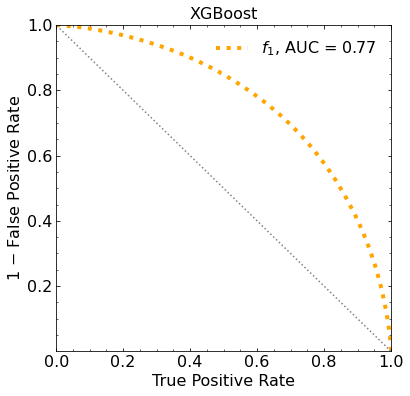

ML iteration  7


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.67516	validation_1-logloss:0.67548
[1]	validation_0-logloss:0.66009	validation_1-logloss:0.66088
[2]	validation_0-logloss:0.64743	validation_1-logloss:0.64854
[3]	validation_0-logloss:0.63680	validation_1-logloss:0.63826
[4]	validation_0-logloss:0.62772	validation_1-logloss:0.62954
[5]	validation_0-logloss:0.61998	validation_1-logloss:0.62211
[6]	validation_0-logloss:0.61334	validation_1-logloss:0.61574
[7]	validation_0-logloss:0.60769	validation_1-logloss:0.61031
[8]	validation_0-logloss:0.60276	validation_1-logloss:0.60565
[9]	validation_0-logloss:0.59849	validation_1-logloss:0.60163
[10]	validation_0-logloss:0.59480	validation_1-logloss:0.59816
[11]	validation_0-logloss:0.59156	validation_1-logloss:0.59517
[12]	validation_0-logloss:0.58875	validation_1-logloss:0.59252
[13]	validation_0-logloss:0.58631	validation_1-logloss:0.59030
[14]	validation_0-logloss:0.58417	validation_1-logloss:0.58835
[15]	validation_0-logloss:0.58226	validation_1-logloss:0.58664
[1

ML iteration  8


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.67469	validation_1-logloss:0.67533
[1]	validation_0-logloss:0.65947	validation_1-logloss:0.66059
[2]	validation_0-logloss:0.64654	validation_1-logloss:0.64818
[3]	validation_0-logloss:0.63573	validation_1-logloss:0.63788
[4]	validation_0-logloss:0.62656	validation_1-logloss:0.62916
[5]	validation_0-logloss:0.61864	validation_1-logloss:0.62166
[6]	validation_0-logloss:0.61187	validation_1-logloss:0.61531
[7]	validation_0-logloss:0.60606	validation_1-logloss:0.60982
[8]	validation_0-logloss:0.60108	validation_1-logloss:0.60522
[9]	validation_0-logloss:0.59676	validation_1-logloss:0.60118
[10]	validation_0-logloss:0.59300	validation_1-logloss:0.59772
[11]	validation_0-logloss:0.58975	validation_1-logloss:0.59480
[12]	validation_0-logloss:0.58688	validation_1-logloss:0.59219
[13]	validation_0-logloss:0.58439	validation_1-logloss:0.58997
[14]	validation_0-logloss:0.58223	validation_1-logloss:0.58801
[15]	validation_0-logloss:0.58032	validation_1-logloss:0.58635
[1

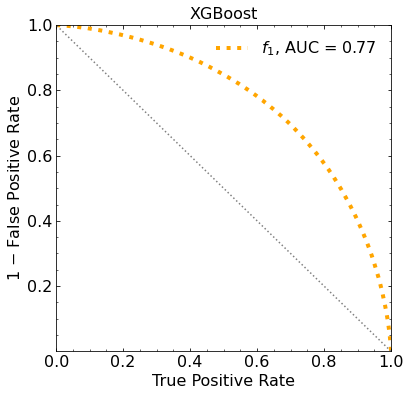

ML iteration  9


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.67511	validation_1-logloss:0.67544
[1]	validation_0-logloss:0.66023	validation_1-logloss:0.66095
[2]	validation_0-logloss:0.64762	validation_1-logloss:0.64872
[3]	validation_0-logloss:0.63699	validation_1-logloss:0.63843
[4]	validation_0-logloss:0.62790	validation_1-logloss:0.62962
[5]	validation_0-logloss:0.62016	validation_1-logloss:0.62216
[6]	validation_0-logloss:0.61355	validation_1-logloss:0.61579
[7]	validation_0-logloss:0.60785	validation_1-logloss:0.61034
[8]	validation_0-logloss:0.60296	validation_1-logloss:0.60566
[9]	validation_0-logloss:0.59871	validation_1-logloss:0.60164
[10]	validation_0-logloss:0.59504	validation_1-logloss:0.59819
[11]	validation_0-logloss:0.59182	validation_1-logloss:0.59520
[12]	validation_0-logloss:0.58905	validation_1-logloss:0.59264
[13]	validation_0-logloss:0.58664	validation_1-logloss:0.59039
[14]	validation_0-logloss:0.58449	validation_1-logloss:0.58840
[15]	validation_0-logloss:0.58262	validation_1-logloss:0.58672
[1

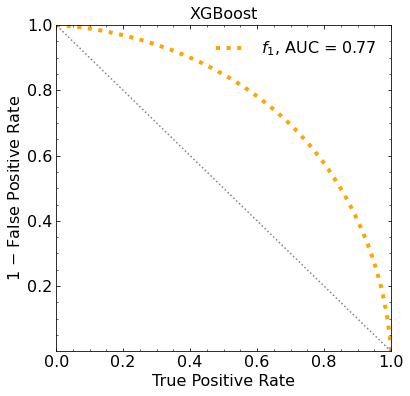

Classification score (1 ML):


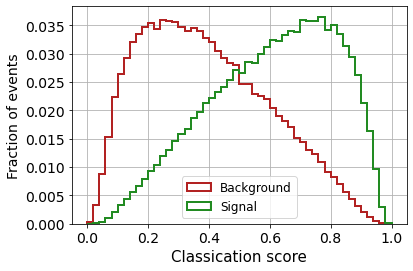

Classification score (10 ML):


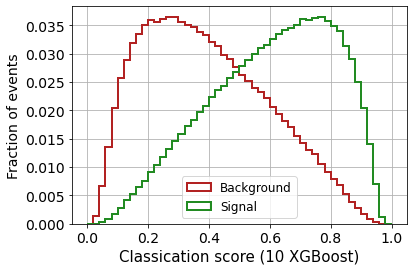

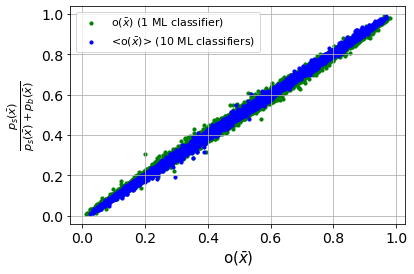


 ----------------------------------------- 

B_expected:  50000
S_expected:  500
S/$\sqrt{B}$:  2.23606797749979
 BINNED CLASSIFIER OUTPUT
  BL lineal bins, 1 ML
Z_XG 10 bins_1ML:  3.6186182377219027
Z_XG 25 bins_1ML:  3.684451018207055
Z_XG 50 bins_1ML:  3.699278919634694
Z_XG 100 bins_1ML:  3.704341377272036

 BL non-lineal bins, 1 ML
Z_XG 10 bins_eq_1ML:  3.315274204014894
Z_XG 25 bins_eq_1ML:  3.481771392644934
Z_XG 50 bins_eq_1ML:  3.564518119983484
Z_XG 100 bins_eq_1ML:  3.6226621975719664

 BL lineal bins, 10 ML
Z_XG 10 bins:  3.6317971790738617
Z_XG 25 bins:  3.6909200773652944
Z_XG 50 bins:  3.7101433606390652
Z_XG 100 bins:  3.7157498288285735

 BL non-lineal bins, 10 ML
Z_XG 10 bins_eq:  3.3161193903381267
Z_XG 25 bins_eq:  3.4865936421504546
Z_XG 50 bins_eq:  3.5690364251625515
Z_XG 100 bins_eq:  3.6296237076865596

 ----------------------------------------- 


 If  20200  =  1101    then the proposed range has to be extended
n_ensembles (actual):  9863
TRUE PDF LIKELIHOOD

muhat mean:  0.12176822467808983
Z_gaussian:  3.7125694172592456
Z_gaussian_mu0:  3.7140944816905868

 ------------------------------------ 

 MLL + KDE (1ML) 


/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
   947.25972749   949.67565562   952.21328564   953.75019912
   954.40243887   953.83644065   951.57313347   945.06360215
   929.51103314   894.50655329   823.79468942   690.58395838
   446.49395324    10.54766898  -754.11704795 -1891.24110504]
  warnings.warn(
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:929: RuntimeWarning: invalid value encountered in subtract
  array_stds = np.sqrt(np.average((array -
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf   947.92373231   951.22649188   954.25160814
   954.61252199   953.78924128   950.86381082   943.39605287
   9

KDE Kernel:  epanechnikov
Background bandwidth:  0.01924024182760239
Signal bandwidth:  0.01924024182760239


 MLL + KDE (10ML) 


/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf  1014.15219     1017.54930648  1019.22633639
  1021.54395054  1021.76593317  1019.53005873  1012.25689064
   995.20931774   958.32985117   885.35742743   748.39976305
   497.37953322    50.5281224   -731.83652472 -1881.7048847 ]
  warnings.warn(
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:929: RuntimeWarning: invalid value encountered in subtract
  array_stds = np.sqrt(np.average((array -
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf  1020.11295294  1023.60331001
  1024.21303235  1022.9638745   1020.17018156  1012.18801948
   9

KDE Kernel:  epanechnikov
Background bandwidth:  0.02784433448152421
Signal bandwidth:  0.01924024182760239


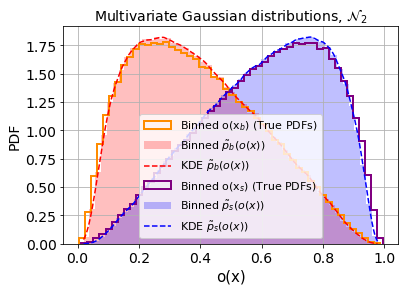

 Z MLL+KDE (1ML) 


muhat mean_1ML:  0.08256108689039847
Z_KDE_1ML:  3.934037231597511
Z_KDE mu=0_1ML:  3.934037231597511

 Z MLL+KDE (10ML) 


muhat mean:  0.0609855013687519
Z_KDE:  4.102493383384613
Z_KDE mu=0:  4.102493383384613

 ------------------------------------ 



In [119]:
dim=3

#######################
# generate the events #
#######################
    
mean_sig = epsilon*np.ones(dim)
mean_bkg = -1*mean_sig

#cov_sig = np.identity(dim)
cov_sig = np.identity(dim) + (0. * ( np.ones((dim,dim)) - np.identity(dim) ))
cov_bkg = cov_sig

signal_X_1, signal_X_2, signal_X_3 = np.random.multivariate_normal(mean_sig, cov_sig, N).T
background_X_1, background_X_2, background_X_3 = np.random.multivariate_normal(mean_bkg, cov_bkg, N).T

dim1 = np.concatenate((background_X_1,signal_X_1))
dim2 = np.concatenate((background_X_2,signal_X_2))
dim3 = np.concatenate((background_X_3,signal_X_3))

# labels
background_Y = np.zeros(N)
signal_Y = np.ones(N)

# DATA in a single matrix (features + labels)
df = pd.DataFrame()
df['dim1'] = dim1.reshape(-1)
df['dim2'] = dim2.reshape(-1)
df['dim3'] = dim3.reshape(-1)
df['Y'] = np.concatenate((background_Y.astype('int'),signal_Y.astype('int')))

X_gauss = df[['dim1','dim2','dim3']].values 
Y_gauss = df[['Y']].values

# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.5

X_gauss_aux, X_gauss_test, Y_gauss_aux, Y_gauss_test = train_test_split(X_gauss,
                                                                Y_gauss,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_gauss,
                                                                shuffle=True)


X_gauss_train, X_gauss_val, Y_gauss_train, Y_gauss_val = train_test_split(X_gauss_aux,
                                                                  Y_gauss_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_gauss_aux,
                                                                  shuffle=True)

print('')
print('X_gauss_train : ', X_gauss_train.shape)
print('y_gauss_train : ', Y_gauss_train.shape)
print('X_gauss_val : ', X_gauss_val.shape)
print('y_gauss_val : ', Y_gauss_val.shape)
print('X_gauss_test : ', X_gauss_test.shape)
print('y_gauss_test : ', Y_gauss_test.shape)
print('')


# PLOT (only 1st feature) to visualize the data
X_gauss_test_SM = []
X_gauss_test_NP = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] ==0:
        X_gauss_test_SM.append(X_gauss_test[i].tolist())
    else:
        X_gauss_test_NP.append(X_gauss_test[i].tolist())    


X_gauss_test_SM = np.array(X_gauss_test_SM)
X_gauss_test_NP = np.array(X_gauss_test_NP)


weights = np.ones_like(X_gauss_test_SM[:,0])/float(len(X_gauss_test_SM[:,0]))
plt.hist(X_gauss_test_SM[:,0], 20, histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(X_gauss_test_NP[:,0])/float(len(X_gauss_test_NP[:,0]))
plt.hist(X_gauss_test_NP[:,0], 20, histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$x_1$",fontsize=16)
plt.ylabel("Fraction of events",fontsize=16)
plt.grid()
plt.legend(fontsize=14)
plt.title(r"Gaussian (dim=%0.2d)" % dim,fontsize=14)
plt.show()  






################################
# the true pdfs (useful later) #
################################

sig_multi = multivariate_normal(mean_sig, cov_sig)
bkg_multi = multivariate_normal(mean_bkg, cov_bkg) 




#######################
# CLASSIFIER: XGBoost #
#######################

# only 1 ML
roc_auc_XG, y_pred_xg_1ML = XG(X_gauss_train, X_gauss_test, X_gauss_val, Y_gauss_train, Y_gauss_test, Y_gauss_val)

store_AUC.append(roc_auc_XG)


# Bagging

print('ML iteration 0')
roc_auc_XG, y_pred_xg_aux = XG(X_gauss_train[:100000], X_gauss_test, X_gauss_val, Y_gauss_train[:100000], Y_gauss_test, Y_gauss_val)
y_pred_xg_auxRE = np.reshape(y_pred_xg_aux, (1,len(y_pred_xg_aux)))

for it in range(1,iterations_ML):

    print('ML iteration ', it)
    roc_auc_XG, y_pred_xg_aux_it = XG(X_gauss_train[(100000*it):(100000*it)+100000], X_gauss_test, X_gauss_val, Y_gauss_train[(100000*it):(100000*it)+100000], Y_gauss_test, Y_gauss_val)
    
    y_pred_xg_auxRE_it = np.reshape(y_pred_xg_aux_it, (1,len(y_pred_xg_aux_it)))
    
    y_pred_xg_auxRE = np.concatenate([y_pred_xg_auxRE,y_pred_xg_auxRE_it])

# to smooth, mean of 10 predictions
y_pred_xg = np.mean(y_pred_xg_auxRE, axis=0)




########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

# 1 ML
pred_XG_SM_1ML = []
pred_XG_NP_1ML = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] == 0:
        pred_XG_SM_1ML.append(y_pred_xg_1ML[i])
    else:
        pred_XG_NP_1ML.append(y_pred_xg_1ML[i])
        
# Bagging  
pred_XG_SM = []
pred_XG_NP = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score (1 ML):')
        
weights = np.ones_like(pred_XG_SM_1ML)/float(len(pred_XG_SM_1ML))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM_1ML, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP_1ML)/float(len(pred_XG_NP_1ML))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP_1ML, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12, loc="lower center")
plt.show()


print('Classification score (10 ML):')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (10 XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12, loc="lower center")
plt.show()




ratio_ps_pb_true = sig_multi.pdf(X_gauss_test) / ( sig_multi.pdf(X_gauss_test) + bkg_multi.pdf(X_gauss_test) )
ratio_ps_pb_true_B = sig_multi.pdf(X_gauss_test_SM) / ( sig_multi.pdf(X_gauss_test_SM) + bkg_multi.pdf(X_gauss_test_SM) )
ratio_ps_pb_true_S = sig_multi.pdf(X_gauss_test_NP) / ( sig_multi.pdf(X_gauss_test_NP) + bkg_multi.pdf(X_gauss_test_NP) )

plt.scatter(y_pred_xg_1ML[:10000], ratio_ps_pb_true[:10000], color='green', label=r'o($\bar{x}$) (1 ML classifier)', s=10)
plt.scatter(y_pred_xg[:10000], ratio_ps_pb_true[:10000], color='blue', label=r'<o($\bar{x}$)> (10 ML classifiers)', s=10)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r"o($\bar{x}$)",fontsize=15)
plt.ylabel(r"$\frac{p_s(\bar{x})}{p_s(\bar{x})+p_b(\bar{x})}$",fontsize=16)
plt.grid()
plt.legend(fontsize=11)
#plt.savefig('images/' + 'optimalclass-vs-ox.pdf', format="pdf", bbox_inches="tight")
plt.show()

print('\n ----------------------------------------- \n')






###########
# METHODS #
###########

print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)



############################
# BINNED CLASSIFIER OUTPUT #
############################

print(' BINNED CLASSIFIER OUTPUT')

print('  BL lineal bins, 1 ML')

# 10 BINS
Z_bins_XG_10bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 10, [[0,1]], linear_bins=True)
store_Z_bins_XG_10bins_1ML.append(Z_bins_XG_10bins_1ML)
print('Z_XG 10 bins_1ML: ', Z_bins_XG_10bins_1ML)

# 25 BINS
Z_bins_XG_25bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 25, [[0,1]], linear_bins=True)
store_Z_bins_XG_25bins_1ML.append(Z_bins_XG_25bins_1ML)
print('Z_XG 25 bins_1ML: ', Z_bins_XG_25bins_1ML)

# 50 BINS
Z_bins_XG_50bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 50, [[0,1]], linear_bins=True)
store_Z_bins_XG_50bins_1ML.append(Z_bins_XG_50bins_1ML)
print('Z_XG 50 bins_1ML: ', Z_bins_XG_50bins_1ML)

# 100 BINS
Z_bins_XG_100bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 100, [[0,1]], linear_bins=True)
store_Z_bins_XG_100bins_1ML.append(Z_bins_XG_100bins_1ML)
print('Z_XG 100 bins_1ML: ', Z_bins_XG_100bins_1ML)


print('\n BL non-lineal bins, 1 ML')

# 10 BINS
Z_bins_XG_10bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 10, [[0,1]], linear_bins=False)
store_Z_bins_XG_10bins_eq_1ML.append(Z_bins_XG_10bins_eq_1ML)
print('Z_XG 10 bins_eq_1ML: ', Z_bins_XG_10bins_eq_1ML)

# 25 BINS
Z_bins_XG_25bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 25, [[0,1]], linear_bins=False)
store_Z_bins_XG_25bins_eq_1ML.append(Z_bins_XG_25bins_eq_1ML)
print('Z_XG 25 bins_eq_1ML: ', Z_bins_XG_25bins_eq_1ML)

# 50 BINS
Z_bins_XG_50bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 50, [[0,1]], linear_bins=False)
store_Z_bins_XG_50bins_eq_1ML.append(Z_bins_XG_50bins_eq_1ML)
print('Z_XG 50 bins_eq_1ML: ', Z_bins_XG_50bins_eq_1ML)

# 100 BINS
Z_bins_XG_100bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 100, [[0,1]], linear_bins=False)
store_Z_bins_XG_100bins_eq_1ML.append(Z_bins_XG_100bins_eq_1ML)
print('Z_XG 100 bins_eq_1ML: ', Z_bins_XG_100bins_eq_1ML)


print('\n BL lineal bins, 10 ML')

# 10 BINS
Z_bins_XG_10bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 10, [[0,1]], linear_bins=True)
store_Z_bins_XG_10bins.append(Z_bins_XG_10bins)
print('Z_XG 10 bins: ', Z_bins_XG_10bins)

# 25 BINS
Z_bins_XG_25bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 25, [[0,1]], linear_bins=True)
store_Z_bins_XG_25bins.append(Z_bins_XG_25bins)
print('Z_XG 25 bins: ', Z_bins_XG_25bins)

# 50 BINS
Z_bins_XG_50bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 50, [[0,1]], linear_bins=True)
store_Z_bins_XG_50bins.append(Z_bins_XG_50bins)
print('Z_XG 50 bins: ', Z_bins_XG_50bins)

# 100 BINS
Z_bins_XG_100bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 100, [[0,1]], linear_bins=True)
store_Z_bins_XG_100bins.append(Z_bins_XG_100bins)
print('Z_XG 100 bins: ', Z_bins_XG_100bins)


print('\n BL non-lineal bins, 10 ML')

# 10 BINS
Z_bins_XG_10bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 10, [[0,1]], linear_bins=False)
store_Z_bins_XG_10bins_eq.append(Z_bins_XG_10bins_eq)
print('Z_XG 10 bins_eq: ', Z_bins_XG_10bins_eq)

# 25 BINS
Z_bins_XG_25bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 25, [[0,1]], linear_bins=False)
store_Z_bins_XG_25bins_eq.append(Z_bins_XG_25bins_eq)
print('Z_XG 25 bins_eq: ', Z_bins_XG_25bins_eq)

# 50 BINS
Z_bins_XG_50bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 50, [[0,1]], linear_bins=False)
store_Z_bins_XG_50bins_eq.append(Z_bins_XG_50bins_eq)
print('Z_XG 50 bins_eq: ', Z_bins_XG_50bins_eq)

# 100 BINS
Z_bins_XG_100bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 100, [[0,1]], linear_bins=False)
store_Z_bins_XG_100bins_eq.append(Z_bins_XG_100bins_eq)
print('Z_XG 100 bins_eq: ', Z_bins_XG_100bins_eq)


print('\n ----------------------------------------- \n')






###########################
# SET THE TOY EXPERIMENTS #
###########################

list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles = ensembler(B_expected, S_expected, n_ensembles)






###################################
# TRUE PDF LIKELIHOOD (GAUSSIANS) #
###################################

indices = [i for i in range(len(X_gauss_test_SM))]

prob_B_given_B = bkg_multi.pdf(X_gauss_test_SM)
prob_B_given_S = sig_multi.pdf(X_gauss_test_SM)



print('TRUE PDF LIKELIHOOD (GAUSSIANS):')

print('n_ensembles (initial): ', n_ensembles)

Z_gaussian, muhat_mean_gaussian, Z_gaussian_mu0, muhat_selected_list, q_muhat, q_muhat_mu0 = Z_MLL(B_expected, S_expected, prob_B_given_B, prob_B_given_S, list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles)

# Histogram of q_muhats

weights = np.ones_like(q_muhat)/float(len(q_muhat))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()

store_muhat_mean_gaussian.append(muhat_mean_gaussian)
store_Z_gaussian.append(Z_gaussian)

store_Z_gaussian_mu0.append(Z_gaussian_mu0)

print('muhat mean: ', muhat_mean_gaussian)
print('Z_gaussian: ', Z_gaussian)
print('Z_gaussian_mu0: ', Z_gaussian_mu0)


print('\n ------------------------------------ \n')







#########
#  KDE  #
#########  

print(' MLL + KDE (1ML) ')

kde_bkg_1ML, kde_sig_1ML, B_bandwidth_1ML, S_bandwidth_1ML = KDE_finder(pred_XG_SM_1ML, pred_XG_NP_1ML)


# range (~between 0 and 1)
min_val_1ML = np.min([np.min(pred_XG_SM_1ML),np.min(pred_XG_NP_1ML)])
max_val_1ML = np.max([np.max(pred_XG_SM_1ML),np.max(pred_XG_NP_1ML)])

s_vals_1ML = np.linspace(min_val_1ML,max_val_1ML,1000)



# evaluate the densities for each value of s (~bins)
dens_bkg_1ML = np.exp(kde_bkg_1ML.score_samples(np.c_[s_vals_1ML, np.zeros(len(s_vals_1ML)) ]) )
dens_sig_1ML = np.exp(kde_sig_1ML.score_samples(np.c_[s_vals_1ML, np.ones(len(s_vals_1ML)) ]) )



# Normalize to 1
# Area
factor_aux_SM_1ML = sum(dens_bkg_1ML*(s_vals_1ML[1]-s_vals_1ML[0]))
factor_aux_NP_1ML = sum(dens_sig_1ML*(s_vals_1ML[1]-s_vals_1ML[0]))

# normalize
dens_bkg_1ML = dens_bkg_1ML / factor_aux_SM_1ML
dens_sig_1ML = dens_sig_1ML / factor_aux_NP_1ML





# plot to check the estimation

plt.figure()

plt.hist(ratio_ps_pb_true_B,density=True,bins=50,lw=2,histtype='step',color='darkorange',alpha=1,label=r'Binned o(x$_b$) (True PDFs)')
plt.hist(pred_XG_SM_1ML,density=True,bins=50,color='red',alpha=0.25,label=r'Binned $\tilde{p}_{b}(o(x))$');
plt.plot(s_vals_1ML,dens_bkg_1ML,color='red',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');

plt.hist(ratio_ps_pb_true_S,density=True,bins=50,lw=2,histtype='step',color='purple',alpha=1,label=r'Binned o(x$_s$) (True PDFs)');
plt.hist(pred_XG_NP_1ML,density=True,bins=50,color='blue',alpha=0.25,label=r'Binned $\tilde{p}_{s}(o(x))$');
plt.plot(s_vals_1ML,dens_sig_1ML,color='blue',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("o(x)",fontsize=15)
plt.ylabel("PDF",fontsize=14)
plt.grid()
plt.legend(loc="lower center", fontsize=11, handlelength=2.5)
plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{2}$', fontsize=14)
#plt.savefig('images/' + '2gaussian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()





print(' MLL + KDE (10ML) ')

kde_bkg, kde_sig, B_bandwidth, S_bandwidth = KDE_finder(pred_XG_SM, pred_XG_NP)


# range (~between 0 and 1)
min_val = np.min([np.min(pred_XG_SM),np.min(pred_XG_NP)])
max_val = np.max([np.max(pred_XG_SM),np.max(pred_XG_NP)])

s_vals = np.linspace(min_val,max_val,1000)



# evaluate the densities for each value of s (~bins)
dens_bkg = np.exp(kde_bkg.score_samples(np.c_[s_vals, np.zeros(len(s_vals)) ]) )
dens_sig = np.exp(kde_sig.score_samples(np.c_[s_vals, np.ones(len(s_vals)) ]) )



# Normalize to 1
# Area
factor_aux_SM = sum(dens_bkg*(s_vals[1]-s_vals[0]))
factor_aux_NP = sum(dens_sig*(s_vals[1]-s_vals[0]))

# normalize
dens_bkg = dens_bkg / factor_aux_SM
dens_sig = dens_sig / factor_aux_NP





# plot to check the estimation

plt.figure()

plt.hist(ratio_ps_pb_true_B,density=True,bins=50,lw=2,histtype='step',color='darkorange',alpha=1,label=r'Binned o(x$_b$) (True PDFs)')
plt.hist(pred_XG_SM,density=True,bins=50,color='red',alpha=0.25,label=r'Binned $\tilde{p}_{b}(o(x))$');
plt.plot(s_vals,dens_bkg,color='red',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');

plt.hist(ratio_ps_pb_true_S,density=True,bins=50,lw=2,histtype='step',color='purple',alpha=1,label=r'Binned o(x$_s$) (True PDFs)');
plt.hist(pred_XG_NP,density=True,bins=50,color='blue',alpha=0.25,label=r'Binned $\tilde{p}_{s}(o(x))$');
plt.plot(s_vals,dens_sig,color='blue',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("o(x)",fontsize=15)
plt.ylabel("PDF",fontsize=14)
plt.grid()
plt.legend(loc="lower center", fontsize=11, handlelength=2.5)
plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{2}$', fontsize=14)
#plt.savefig('images/' + '2gaussian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()






#############
# MLL + KDE #
#############

print(' Z MLL+KDE (1ML) ')
# FOR EXCLUSION:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

KDE_SM_pred_SM_1ML = np.exp(kde_bkg_1ML.score_samples(np.c_[pred_XG_SM_1ML, np.zeros(len(pred_XG_SM_1ML)) ]) )
KDE_NP_pred_SM_1ML = np.exp(kde_sig_1ML.score_samples(np.c_[pred_XG_SM_1ML, np.ones(len(pred_XG_SM_1ML)) ]) )

# Normalize

KDE_SM_pred_SM_1ML = KDE_SM_pred_SM_1ML / factor_aux_SM_1ML
KDE_NP_pred_SM_1ML = KDE_NP_pred_SM_1ML / factor_aux_NP_1ML


indices_1ML = [i for i in range(len(KDE_NP_pred_SM_1ML))]

prob_B_given_B_1ML = KDE_SM_pred_SM_1ML
prob_B_given_S_1ML = KDE_NP_pred_SM_1ML

Z_KDE_1ML, muhat_mean_MLL_KDE_1ML, Z_KDE_mu0_1ML, muhat_selected_list_1ML, q_muhat_1ML, q_muhat_mu0_1ML = Z_MLL(B_expected, S_expected, prob_B_given_B_1ML, prob_B_given_S_1ML, list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles)
    
    
# Histogram of q_muhats

weights = np.ones_like(q_muhat_1ML)/float(len(q_muhat_1ML))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat_1ML, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()


store_muhat_mean_MLL_KDE_1ML.append(muhat_mean_MLL_KDE_1ML)
store_Z_MLL_KDE_1ML.append(Z_KDE_1ML)

store_Z_MLL_KDE_mu0_1ML.append(Z_KDE_mu0_1ML)

print('muhat mean_1ML: ', muhat_mean_MLL_KDE_1ML)
print('Z_KDE_1ML: ', Z_KDE_1ML)
print('Z_KDE mu=0_1ML: ', Z_KDE_mu0_1ML)



print('\n Z MLL+KDE (10ML) ')
# FOR EXCLUSION:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

KDE_SM_pred_SM = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
KDE_NP_pred_SM = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )

# Normalize

KDE_SM_pred_SM = KDE_SM_pred_SM / factor_aux_SM
KDE_NP_pred_SM = KDE_NP_pred_SM / factor_aux_NP


indices = [i for i in range(len(KDE_NP_pred_SM))]

prob_B_given_B = KDE_SM_pred_SM
prob_B_given_S = KDE_NP_pred_SM

Z_KDE, muhat_mean_MLL_KDE, Z_KDE_mu0, muhat_selected_list, q_muhat, q_muhat_mu0 = Z_MLL(B_expected, S_expected, prob_B_given_B, prob_B_given_S, list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles)
    
    
# Histogram of q_muhats

weights = np.ones_like(q_muhat)/float(len(q_muhat))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()


store_muhat_mean_MLL_KDE.append(muhat_mean_MLL_KDE)
store_Z_MLL_KDE.append(Z_KDE)

store_Z_MLL_KDE_mu0.append(Z_KDE_mu0)

print('muhat mean: ', muhat_mean_MLL_KDE)
print('Z_KDE: ', Z_KDE)
print('Z_KDE mu=0: ', Z_KDE_mu0)

print('\n ------------------------------------ \n')

In [ ]:
print(roc_auc_XG)

print(Z_bins_XG_10bins_1ML)
print(Z_bins_XG_25bins_1ML)
print(Z_bins_XG_50bins_1ML)
print(Z_bins_XG_100bins_1ML)

print(Z_bins_XG_10bins_eq_1ML)
print(Z_bins_XG_25bins_eq_1ML)
print(Z_bins_XG_50bins_eq_1ML)
print(Z_bins_XG_100bins_eq_1ML)

print(Z_bins_XG_10bins)
print(Z_bins_XG_25bins)
print(Z_bins_XG_50bins)
print(Z_bins_XG_100bins)

print(Z_bins_XG_10bins_eq)
print(Z_bins_XG_25bins_eq)
print(Z_bins_XG_50bins_eq)
print(Z_bins_XG_100bins_eq)

print(muhat_mean_gaussian)
print(Z_gaussian)
print(Z_gaussian_mu0)

print(muhat_mean_MLL_KDE)
print(Z_KDE)
print(Z_KDE_mu0)

print(muhat_mean_MLL_KDE_1ML)
print(Z_KDE_1ML)
print(Z_KDE_mu0_1ML)

In [ ]:
store_AUC.append()

store_Z_bins_XG_10bins_1ML.append()
store_Z_bins_XG_25bins_1ML.append()
store_Z_bins_XG_50bins_1ML.append()
store_Z_bins_XG_100bins_1ML.append()

store_Z_bins_XG_10bins_eq_1ML.append()
store_Z_bins_XG_25bins_eq_1ML.append()
store_Z_bins_XG_50bins_eq_1ML.append()
store_Z_bins_XG_100bins_eq_1ML.append()

store_Z_bins_XG_10bins.append()
store_Z_bins_XG_25bins.append()
store_Z_bins_XG_50bins.append()
store_Z_bins_XG_100bins.append()

store_Z_bins_XG_10bins_eq.append()
store_Z_bins_XG_25bins_eq.append()
store_Z_bins_XG_50bins_eq.append()
store_Z_bins_XG_100bins_eq.append()

store_muhat_mean_gaussian.append()
store_Z_gaussian.append()
store_Z_gaussian_mu0.append()

store_muhat_mean_MLL_KDE.append()
store_Z_MLL_KDE.append()
store_Z_MLL_KDE_mu0.append()

store_muhat_mean_MLL_KDE_1ML.append()
store_Z_MLL_KDE_1ML.append()
store_Z_MLL_KDE_mu0_1ML.append()


X_gauss_train :  (1000000, 4)
y_gauss_train :  (1000000, 1)
X_gauss_val :  (1000000, 4)
y_gauss_val :  (1000000, 1)
X_gauss_test :  (1000000, 4)
y_gauss_test :  (1000000, 1)



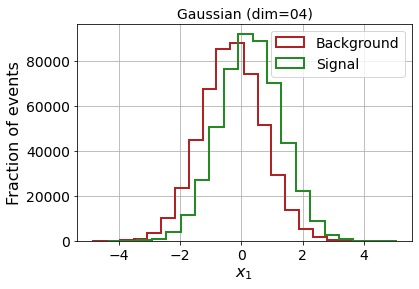

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.67324	validation_1-logloss:0.67332
[1]	validation_0-logloss:0.65659	validation_1-logloss:0.65674
[2]	validation_0-logloss:0.64246	validation_1-logloss:0.64268
[3]	validation_0-logloss:0.63040	validation_1-logloss:0.63066
[4]	validation_0-logloss:0.62009	validation_1-logloss:0.62043
[5]	validation_0-logloss:0.61113	validation_1-logloss:0.61151
[6]	validation_0-logloss:0.60335	validation_1-logloss:0.60382
[7]	validation_0-logloss:0.59656	validation_1-logloss:0.59708
[8]	validation_0-logloss:0.59059	validation_1-logloss:0.59120
[9]	validation_0-logloss:0.58535	validation_1-logloss:0.58601
[10]	validation_0-logloss:0.58068	validation_1-logloss:0.58139
[11]	validation_0-logloss:0.57654	validation_1-logloss:0.57729
[12]	validation_0-logloss:0.57290	validation_1-logloss:0.57369
[13]	validation_0-logloss:0.56960	validation_1-logloss:0.57046
[14]	validation_0-logloss:0.56666	validation_1-logloss:0.56755
[15]	validation_0-logloss:0.56404	validation_1-logloss:0.56498
[1

[130]	validation_0-logloss:0.53777	validation_1-logloss:0.54062
[131]	validation_0-logloss:0.53776	validation_1-logloss:0.54062
[132]	validation_0-logloss:0.53776	validation_1-logloss:0.54062
[133]	validation_0-logloss:0.53774	validation_1-logloss:0.54062
[134]	validation_0-logloss:0.53774	validation_1-logloss:0.54062
[135]	validation_0-logloss:0.53773	validation_1-logloss:0.54062
[136]	validation_0-logloss:0.53772	validation_1-logloss:0.54062
[137]	validation_0-logloss:0.53770	validation_1-logloss:0.54062
[138]	validation_0-logloss:0.53770	validation_1-logloss:0.54062
[139]	validation_0-logloss:0.53768	validation_1-logloss:0.54062
[140]	validation_0-logloss:0.53768	validation_1-logloss:0.54062
[141]	validation_0-logloss:0.53768	validation_1-logloss:0.54062
[142]	validation_0-logloss:0.53767	validation_1-logloss:0.54062


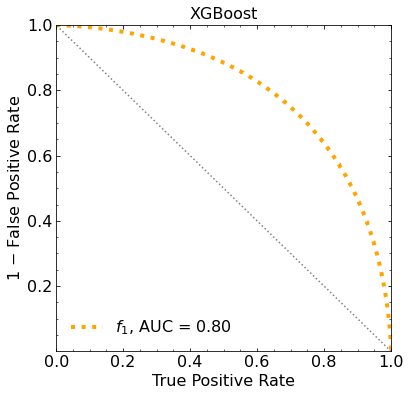

ML iteration 0
[0]	validation_0-logloss:0.67299	validation_1-logloss:0.67332


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	validation_0-logloss:0.65608	validation_1-logloss:0.65671
[2]	validation_0-logloss:0.64179	validation_1-logloss:0.64267
[3]	validation_0-logloss:0.62956	validation_1-logloss:0.63064
[4]	validation_0-logloss:0.61892	validation_1-logloss:0.62027
[5]	validation_0-logloss:0.60973	validation_1-logloss:0.61142
[6]	validation_0-logloss:0.60176	validation_1-logloss:0.60369
[7]	validation_0-logloss:0.59475	validation_1-logloss:0.59691
[8]	validation_0-logloss:0.58861	validation_1-logloss:0.59094
[9]	validation_0-logloss:0.58317	validation_1-logloss:0.58580
[10]	validation_0-logloss:0.57835	validation_1-logloss:0.58113
[11]	validation_0-logloss:0.57408	validation_1-logloss:0.57710
[12]	validation_0-logloss:0.57026	validation_1-logloss:0.57351
[13]	validation_0-logloss:0.56684	validation_1-logloss:0.57029
[14]	validation_0-logloss:0.56380	validation_1-logloss:0.56746
[15]	validation_0-logloss:0.56103	validation_1-logloss:0.56486
[16]	validation_0-logloss:0.55856	validation_1-logloss:0.56259
[

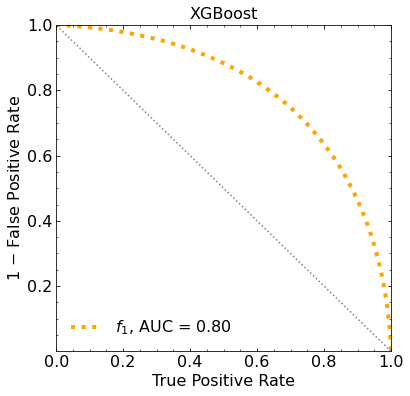

ML iteration  1


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.67237	validation_1-logloss:0.67297
[1]	validation_0-logloss:0.65507	validation_1-logloss:0.65632
[2]	validation_0-logloss:0.64034	validation_1-logloss:0.64203
[3]	validation_0-logloss:0.62767	validation_1-logloss:0.62991
[4]	validation_0-logloss:0.61685	validation_1-logloss:0.61958
[5]	validation_0-logloss:0.60738	validation_1-logloss:0.61055
[6]	validation_0-logloss:0.59918	validation_1-logloss:0.60275
[7]	validation_0-logloss:0.59200	validation_1-logloss:0.59598
[8]	validation_0-logloss:0.58573	validation_1-logloss:0.59009
[9]	validation_0-logloss:0.58013	validation_1-logloss:0.58491
[10]	validation_0-logloss:0.57524	validation_1-logloss:0.58034
[11]	validation_0-logloss:0.57084	validation_1-logloss:0.57631
[12]	validation_0-logloss:0.56696	validation_1-logloss:0.57270
[13]	validation_0-logloss:0.56348	validation_1-logloss:0.56949
[14]	validation_0-logloss:0.56034	validation_1-logloss:0.56668
[15]	validation_0-logloss:0.55754	validation_1-logloss:0.56413
[1

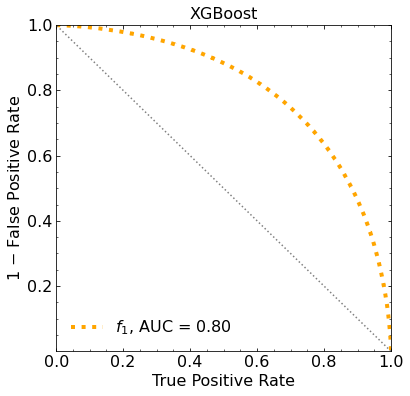

ML iteration  2


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.67276	validation_1-logloss:0.67332
[1]	validation_0-logloss:0.65578	validation_1-logloss:0.65668
[2]	validation_0-logloss:0.64136	validation_1-logloss:0.64265
[3]	validation_0-logloss:0.62901	validation_1-logloss:0.63059
[4]	validation_0-logloss:0.61830	validation_1-logloss:0.62022
[5]	validation_0-logloss:0.60913	validation_1-logloss:0.61140
[6]	validation_0-logloss:0.60113	validation_1-logloss:0.60374
[7]	validation_0-logloss:0.59409	validation_1-logloss:0.59695
[8]	validation_0-logloss:0.58786	validation_1-logloss:0.59102
[9]	validation_0-logloss:0.58240	validation_1-logloss:0.58580
[10]	validation_0-logloss:0.57751	validation_1-logloss:0.58118
[11]	validation_0-logloss:0.57320	validation_1-logloss:0.57712
[12]	validation_0-logloss:0.56940	validation_1-logloss:0.57352
[13]	validation_0-logloss:0.56593	validation_1-logloss:0.57028
[14]	validation_0-logloss:0.56281	validation_1-logloss:0.56742
[15]	validation_0-logloss:0.56004	validation_1-logloss:0.56485
[1

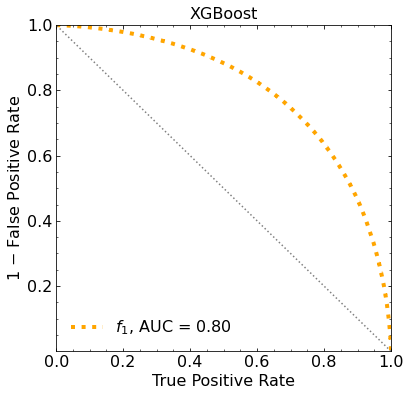

ML iteration  3


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.67273	validation_1-logloss:0.67314
[1]	validation_0-logloss:0.65574	validation_1-logloss:0.65644
[2]	validation_0-logloss:0.64123	validation_1-logloss:0.64232
[3]	validation_0-logloss:0.62877	validation_1-logloss:0.63022
[4]	validation_0-logloss:0.61802	validation_1-logloss:0.61984
[5]	validation_0-logloss:0.60862	validation_1-logloss:0.61084
[6]	validation_0-logloss:0.60056	validation_1-logloss:0.60310
[7]	validation_0-logloss:0.59352	validation_1-logloss:0.59636
[8]	validation_0-logloss:0.58731	validation_1-logloss:0.59046
[9]	validation_0-logloss:0.58180	validation_1-logloss:0.58532
[10]	validation_0-logloss:0.57696	validation_1-logloss:0.58079
[11]	validation_0-logloss:0.57266	validation_1-logloss:0.57670
[12]	validation_0-logloss:0.56880	validation_1-logloss:0.57312
[13]	validation_0-logloss:0.56540	validation_1-logloss:0.56997
[14]	validation_0-logloss:0.56231	validation_1-logloss:0.56710
[15]	validation_0-logloss:0.55950	validation_1-logloss:0.56452
[1

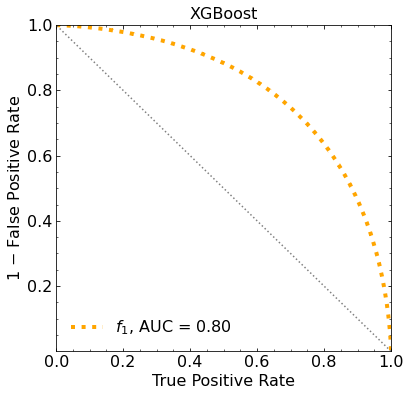

ML iteration  4


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.67243	validation_1-logloss:0.67305
[1]	validation_0-logloss:0.65507	validation_1-logloss:0.65620
[2]	validation_0-logloss:0.64040	validation_1-logloss:0.64203
[3]	validation_0-logloss:0.62777	validation_1-logloss:0.62997
[4]	validation_0-logloss:0.61701	validation_1-logloss:0.61962
[5]	validation_0-logloss:0.60760	validation_1-logloss:0.61068
[6]	validation_0-logloss:0.59937	validation_1-logloss:0.60290
[7]	validation_0-logloss:0.59227	validation_1-logloss:0.59619
[8]	validation_0-logloss:0.58597	validation_1-logloss:0.59030
[9]	validation_0-logloss:0.58044	validation_1-logloss:0.58508
[10]	validation_0-logloss:0.57551	validation_1-logloss:0.58054
[11]	validation_0-logloss:0.57114	validation_1-logloss:0.57646
[12]	validation_0-logloss:0.56725	validation_1-logloss:0.57288
[13]	validation_0-logloss:0.56371	validation_1-logloss:0.56965
[14]	validation_0-logloss:0.56058	validation_1-logloss:0.56681
[15]	validation_0-logloss:0.55777	validation_1-logloss:0.56423
[1

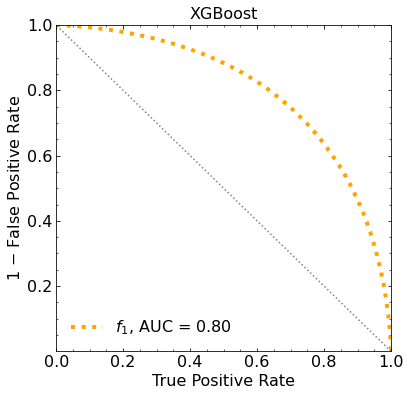

ML iteration  5


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.67252	validation_1-logloss:0.67307
[1]	validation_0-logloss:0.65532	validation_1-logloss:0.65637
[2]	validation_0-logloss:0.64073	validation_1-logloss:0.64214
[3]	validation_0-logloss:0.62823	validation_1-logloss:0.63007
[4]	validation_0-logloss:0.61755	validation_1-logloss:0.61978
[5]	validation_0-logloss:0.60833	validation_1-logloss:0.61087
[6]	validation_0-logloss:0.60028	validation_1-logloss:0.60311
[7]	validation_0-logloss:0.59320	validation_1-logloss:0.59638
[8]	validation_0-logloss:0.58702	validation_1-logloss:0.59053
[9]	validation_0-logloss:0.58162	validation_1-logloss:0.58542
[10]	validation_0-logloss:0.57683	validation_1-logloss:0.58083
[11]	validation_0-logloss:0.57246	validation_1-logloss:0.57673
[12]	validation_0-logloss:0.56866	validation_1-logloss:0.57315
[13]	validation_0-logloss:0.56523	validation_1-logloss:0.56997
[14]	validation_0-logloss:0.56216	validation_1-logloss:0.56714
[15]	validation_0-logloss:0.55944	validation_1-logloss:0.56468
[1

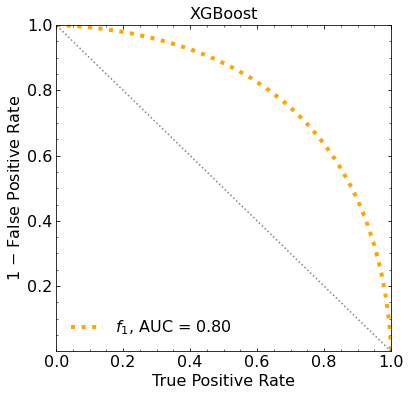

ML iteration  6


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.67271	validation_1-logloss:0.67321
[1]	validation_0-logloss:0.65540	validation_1-logloss:0.65650
[2]	validation_0-logloss:0.64093	validation_1-logloss:0.64248
[3]	validation_0-logloss:0.62865	validation_1-logloss:0.63058
[4]	validation_0-logloss:0.61795	validation_1-logloss:0.62024
[5]	validation_0-logloss:0.60869	validation_1-logloss:0.61125
[6]	validation_0-logloss:0.60068	validation_1-logloss:0.60361
[7]	validation_0-logloss:0.59368	validation_1-logloss:0.59690
[8]	validation_0-logloss:0.58753	validation_1-logloss:0.59098
[9]	validation_0-logloss:0.58208	validation_1-logloss:0.58582
[10]	validation_0-logloss:0.57729	validation_1-logloss:0.58130
[11]	validation_0-logloss:0.57299	validation_1-logloss:0.57730
[12]	validation_0-logloss:0.56916	validation_1-logloss:0.57370
[13]	validation_0-logloss:0.56577	validation_1-logloss:0.57058
[14]	validation_0-logloss:0.56269	validation_1-logloss:0.56767
[15]	validation_0-logloss:0.55998	validation_1-logloss:0.56517
[1

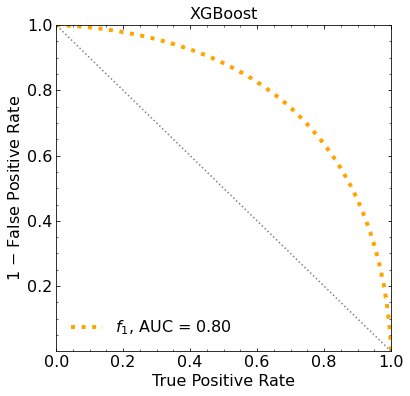

ML iteration  7


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.67234	validation_1-logloss:0.67292
[1]	validation_0-logloss:0.65504	validation_1-logloss:0.65615
[2]	validation_0-logloss:0.64047	validation_1-logloss:0.64206
[3]	validation_0-logloss:0.62792	validation_1-logloss:0.62991
[4]	validation_0-logloss:0.61716	validation_1-logloss:0.61959
[5]	validation_0-logloss:0.60786	validation_1-logloss:0.61071
[6]	validation_0-logloss:0.59968	validation_1-logloss:0.60296
[7]	validation_0-logloss:0.59257	validation_1-logloss:0.59626
[8]	validation_0-logloss:0.58625	validation_1-logloss:0.59028
[9]	validation_0-logloss:0.58073	validation_1-logloss:0.58509
[10]	validation_0-logloss:0.57583	validation_1-logloss:0.58052
[11]	validation_0-logloss:0.57143	validation_1-logloss:0.57640
[12]	validation_0-logloss:0.56751	validation_1-logloss:0.57281
[13]	validation_0-logloss:0.56402	validation_1-logloss:0.56963
[14]	validation_0-logloss:0.56091	validation_1-logloss:0.56677
[15]	validation_0-logloss:0.55809	validation_1-logloss:0.56426
[1

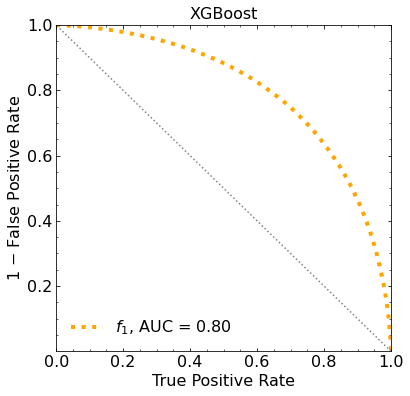

ML iteration  8


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.67222	validation_1-logloss:0.67302
[1]	validation_0-logloss:0.65490	validation_1-logloss:0.65617
[2]	validation_0-logloss:0.64030	validation_1-logloss:0.64212
[3]	validation_0-logloss:0.62769	validation_1-logloss:0.63014
[4]	validation_0-logloss:0.61687	validation_1-logloss:0.61970
[5]	validation_0-logloss:0.60745	validation_1-logloss:0.61072
[6]	validation_0-logloss:0.59930	validation_1-logloss:0.60297
[7]	validation_0-logloss:0.59217	validation_1-logloss:0.59627
[8]	validation_0-logloss:0.58588	validation_1-logloss:0.59035
[9]	validation_0-logloss:0.58034	validation_1-logloss:0.58511
[10]	validation_0-logloss:0.57546	validation_1-logloss:0.58052
[11]	validation_0-logloss:0.57115	validation_1-logloss:0.57651
[12]	validation_0-logloss:0.56728	validation_1-logloss:0.57295
[13]	validation_0-logloss:0.56378	validation_1-logloss:0.56968
[14]	validation_0-logloss:0.56069	validation_1-logloss:0.56687
[15]	validation_0-logloss:0.55789	validation_1-logloss:0.56432
[1

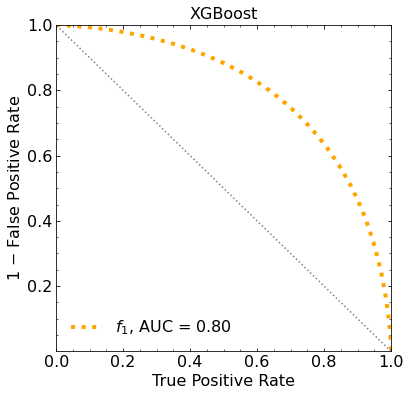

ML iteration  9


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.67256	validation_1-logloss:0.67312
[1]	validation_0-logloss:0.65539	validation_1-logloss:0.65643
[2]	validation_0-logloss:0.64088	validation_1-logloss:0.64233
[3]	validation_0-logloss:0.62837	validation_1-logloss:0.63027
[4]	validation_0-logloss:0.61766	validation_1-logloss:0.61984
[5]	validation_0-logloss:0.60840	validation_1-logloss:0.61092
[6]	validation_0-logloss:0.60040	validation_1-logloss:0.60318
[7]	validation_0-logloss:0.59337	validation_1-logloss:0.59648
[8]	validation_0-logloss:0.58723	validation_1-logloss:0.59062
[9]	validation_0-logloss:0.58178	validation_1-logloss:0.58541
[10]	validation_0-logloss:0.57695	validation_1-logloss:0.58085
[11]	validation_0-logloss:0.57269	validation_1-logloss:0.57682
[12]	validation_0-logloss:0.56885	validation_1-logloss:0.57325
[13]	validation_0-logloss:0.56542	validation_1-logloss:0.57002
[14]	validation_0-logloss:0.56233	validation_1-logloss:0.56717
[15]	validation_0-logloss:0.55959	validation_1-logloss:0.56460
[1

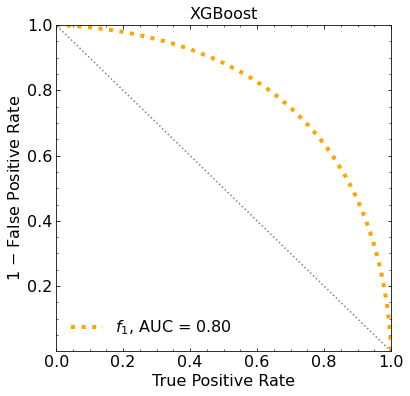

Classification score (1 ML):


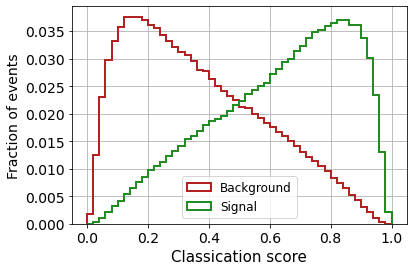

Classification score (10 ML):


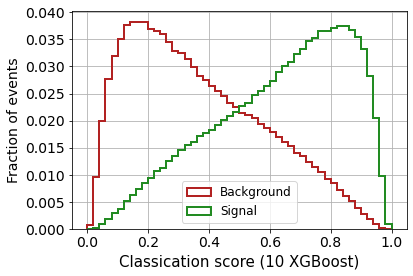

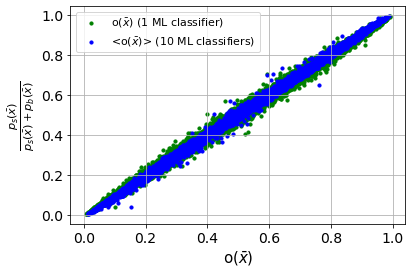


 ----------------------------------------- 

B_expected:  50000
S_expected:  500
S/$\sqrt{B}$:  2.23606797749979
 BINNED CLASSIFIER OUTPUT
  BL lineal bins, 1 ML
Z_XG 10 bins_1ML:  4.176035162741282
Z_XG 25 bins_1ML:  4.339277741551528
Z_XG 50 bins_1ML:  4.36880691412018
Z_XG 100 bins_1ML:  4.381895194220259

 BL non-lineal bins, 1 ML
Z_XG 10 bins_eq_1ML:  3.645525516962761
Z_XG 25 bins_eq_1ML:  3.921266619805339
Z_XG 50 bins_eq_1ML:  4.067548014015153
Z_XG 100 bins_eq_1ML:  4.178055444088994

 BL lineal bins, 10 ML
Z_XG 10 bins:  4.194509764415176
Z_XG 25 bins:  4.36463446148186
Z_XG 50 bins:  4.394428972391493
Z_XG 100 bins:  4.403647069609455

 BL non-lineal bins, 10 ML
Z_XG 10 bins_eq:  3.6473957170376563
Z_XG 25 bins_eq:  3.9277289183792576
Z_XG 50 bins_eq:  4.074225398966449
Z_XG 100 bins_eq:  4.183677737750608

 ----------------------------------------- 


 If  20200  =  1101    then the proposed range has to be extended
n_ensembles (actual):  9863
TRUE PDF LIKELIHOOD (GAUSSIAN

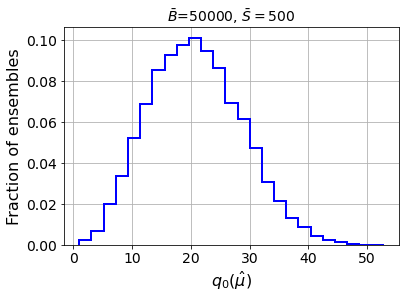

muhat mean:  0.07981344418533914
Z_gaussian:  4.52905318279023
Z_gaussian_mu0:  4.52905318279023

 ------------------------------------ 

 MLL + KDE (1ML) 


/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf   834.49407655
   839.92381609   844.45843754   848.70605123   850.02921779
   850.84757289   848.67741364   841.24588051   825.49777015
   796.05196072   742.45419374   649.50172383   493.02628684
   235.72560706  -180.72062683  -868.11438479 -1939.10169343]
  warnings.warn(
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:929: RuntimeWarning: invalid value encountered in subtract
  array_stds = np.sqrt(np.average((array -
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf   812.0982911    816.21211378   816.71575974
   815.52555043   813.78830954   807.88111959   793.95467165
   7

KDE Kernel:  epanechnikov
Background bandwidth:  0.01924024182760239
Signal bandwidth:  0.01329487353451575


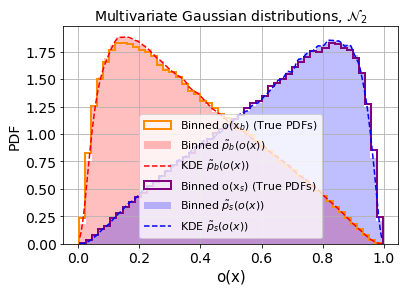

 MLL + KDE (10ML) 


/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf   898.52237416   902.43911771   904.47053116
   904.91492716   902.41961835   895.20034031   879.93956583
   851.35582336   799.54395059   707.25543393   548.56116764
   284.08461895  -142.05758745  -843.66426494 -1928.65754015]
  warnings.warn(
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:929: RuntimeWarning: invalid value encountered in subtract
  array_stds = np.sqrt(np.average((array -
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf   864.954181     867.81189022
   868.61757025   867.150968     861.47079083   848.10923377
   8

KDE Kernel:  epanechnikov
Background bandwidth:  0.01924024182760239
Signal bandwidth:  0.01924024182760239


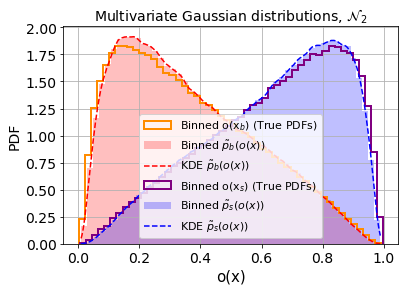

 Z MLL+KDE (1ML) 


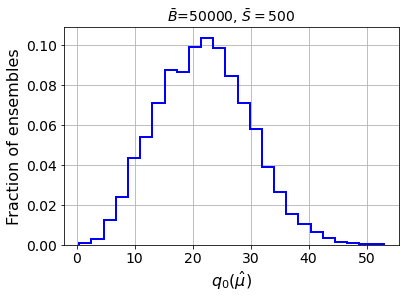

muhat mean_1ML:  0.06009834735881578
Z_KDE_1ML:  4.67065113279329
Z_KDE mu=0_1ML:  4.67065113279329

 Z MLL+KDE (10ML) 


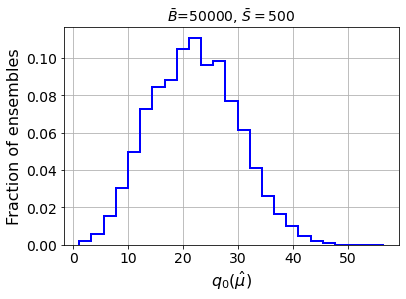

muhat mean:  0.05823278921220725
Z_KDE:  4.693621023338206
Z_KDE mu=0:  4.693621023338206

 ------------------------------------ 



In [120]:
dim=4

#######################
# generate the events #
#######################
    
mean_sig = epsilon*np.ones(dim)
mean_bkg = -1*mean_sig

#cov_sig = np.identity(dim)
cov_sig = np.identity(dim) + (0. * ( np.ones((dim,dim)) - np.identity(dim) ))
cov_bkg = cov_sig

signal_X_1, signal_X_2, signal_X_3, signal_X_4 = np.random.multivariate_normal(mean_sig, cov_sig, N).T
background_X_1, background_X_2, background_X_3, background_X_4 = np.random.multivariate_normal(mean_bkg, cov_bkg, N).T

dim1 = np.concatenate((background_X_1,signal_X_1))
dim2 = np.concatenate((background_X_2,signal_X_2))
dim3 = np.concatenate((background_X_3,signal_X_3))
dim4 = np.concatenate((background_X_4,signal_X_4))

# labels
background_Y = np.zeros(N)
signal_Y = np.ones(N)

# DATA in a single matrix (features + labels)
df = pd.DataFrame()
df['dim1'] = dim1.reshape(-1)
df['dim2'] = dim2.reshape(-1)
df['dim3'] = dim3.reshape(-1)
df['dim4'] = dim4.reshape(-1)
df['Y'] = np.concatenate((background_Y.astype('int'),signal_Y.astype('int')))

X_gauss = df[['dim1','dim2','dim3','dim4']].values 
Y_gauss = df[['Y']].values

# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.5

X_gauss_aux, X_gauss_test, Y_gauss_aux, Y_gauss_test = train_test_split(X_gauss,
                                                                Y_gauss,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_gauss,
                                                                shuffle=True)


X_gauss_train, X_gauss_val, Y_gauss_train, Y_gauss_val = train_test_split(X_gauss_aux,
                                                                  Y_gauss_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_gauss_aux,
                                                                  shuffle=True)

print('')
print('X_gauss_train : ', X_gauss_train.shape)
print('y_gauss_train : ', Y_gauss_train.shape)
print('X_gauss_val : ', X_gauss_val.shape)
print('y_gauss_val : ', Y_gauss_val.shape)
print('X_gauss_test : ', X_gauss_test.shape)
print('y_gauss_test : ', Y_gauss_test.shape)
print('')


# PLOT (only 1st feature) to visualize the data
X_gauss_test_SM = []
X_gauss_test_NP = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] ==0:
        X_gauss_test_SM.append(X_gauss_test[i].tolist())
    else:
        X_gauss_test_NP.append(X_gauss_test[i].tolist())    


X_gauss_test_SM = np.array(X_gauss_test_SM)
X_gauss_test_NP = np.array(X_gauss_test_NP)


weights = np.ones_like(X_gauss_test_SM[:,0])/float(len(X_gauss_test_SM[:,0]))
plt.hist(X_gauss_test_SM[:,0], 20, histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(X_gauss_test_NP[:,0])/float(len(X_gauss_test_NP[:,0]))
plt.hist(X_gauss_test_NP[:,0], 20, histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$x_1$",fontsize=16)
plt.ylabel("Fraction of events",fontsize=16)
plt.grid()
plt.legend(fontsize=14)
plt.title(r"Gaussian (dim=%0.2d)" % dim,fontsize=14)
plt.show()  






################################
# the true pdfs (useful later) #
################################

sig_multi = multivariate_normal(mean_sig, cov_sig)
bkg_multi = multivariate_normal(mean_bkg, cov_bkg) 




#######################
# CLASSIFIER: XGBoost #
#######################

# only 1 ML
roc_auc_XG, y_pred_xg_1ML = XG(X_gauss_train, X_gauss_test, X_gauss_val, Y_gauss_train, Y_gauss_test, Y_gauss_val)

store_AUC.append(roc_auc_XG)


# Bagging

print('ML iteration 0')
roc_auc_XG, y_pred_xg_aux = XG(X_gauss_train[:100000], X_gauss_test, X_gauss_val, Y_gauss_train[:100000], Y_gauss_test, Y_gauss_val)
y_pred_xg_auxRE = np.reshape(y_pred_xg_aux, (1,len(y_pred_xg_aux)))

for it in range(1,iterations_ML):

    print('ML iteration ', it)
    roc_auc_XG, y_pred_xg_aux_it = XG(X_gauss_train[(100000*it):(100000*it)+100000], X_gauss_test, X_gauss_val, Y_gauss_train[(100000*it):(100000*it)+100000], Y_gauss_test, Y_gauss_val)
    
    y_pred_xg_auxRE_it = np.reshape(y_pred_xg_aux_it, (1,len(y_pred_xg_aux_it)))
    
    y_pred_xg_auxRE = np.concatenate([y_pred_xg_auxRE,y_pred_xg_auxRE_it])

# to smooth, mean of 10 predictions
y_pred_xg = np.mean(y_pred_xg_auxRE, axis=0)




########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

# 1 ML
pred_XG_SM_1ML = []
pred_XG_NP_1ML = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] == 0:
        pred_XG_SM_1ML.append(y_pred_xg_1ML[i])
    else:
        pred_XG_NP_1ML.append(y_pred_xg_1ML[i])
        
# Bagging  
pred_XG_SM = []
pred_XG_NP = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score (1 ML):')
        
weights = np.ones_like(pred_XG_SM_1ML)/float(len(pred_XG_SM_1ML))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM_1ML, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP_1ML)/float(len(pred_XG_NP_1ML))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP_1ML, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12, loc="lower center")
plt.show()


print('Classification score (10 ML):')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (10 XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12, loc="lower center")
plt.show()




ratio_ps_pb_true = sig_multi.pdf(X_gauss_test) / ( sig_multi.pdf(X_gauss_test) + bkg_multi.pdf(X_gauss_test) )
ratio_ps_pb_true_B = sig_multi.pdf(X_gauss_test_SM) / ( sig_multi.pdf(X_gauss_test_SM) + bkg_multi.pdf(X_gauss_test_SM) )
ratio_ps_pb_true_S = sig_multi.pdf(X_gauss_test_NP) / ( sig_multi.pdf(X_gauss_test_NP) + bkg_multi.pdf(X_gauss_test_NP) )

plt.scatter(y_pred_xg_1ML[:10000], ratio_ps_pb_true[:10000], color='green', label=r'o($\bar{x}$) (1 ML classifier)', s=10)
plt.scatter(y_pred_xg[:10000], ratio_ps_pb_true[:10000], color='blue', label=r'<o($\bar{x}$)> (10 ML classifiers)', s=10)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r"o($\bar{x}$)",fontsize=15)
plt.ylabel(r"$\frac{p_s(\bar{x})}{p_s(\bar{x})+p_b(\bar{x})}$",fontsize=16)
plt.grid()
plt.legend(fontsize=11)
#plt.savefig('images/' + 'optimalclass-vs-ox.pdf', format="pdf", bbox_inches="tight")
plt.show()

print('\n ----------------------------------------- \n')






###########
# METHODS #
###########

print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)



############################
# BINNED CLASSIFIER OUTPUT #
############################

print(' BINNED CLASSIFIER OUTPUT')

print('  BL lineal bins, 1 ML')

# 10 BINS
Z_bins_XG_10bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 10, [[0,1]], linear_bins=True)
store_Z_bins_XG_10bins_1ML.append(Z_bins_XG_10bins_1ML)
print('Z_XG 10 bins_1ML: ', Z_bins_XG_10bins_1ML)

# 25 BINS
Z_bins_XG_25bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 25, [[0,1]], linear_bins=True)
store_Z_bins_XG_25bins_1ML.append(Z_bins_XG_25bins_1ML)
print('Z_XG 25 bins_1ML: ', Z_bins_XG_25bins_1ML)

# 50 BINS
Z_bins_XG_50bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 50, [[0,1]], linear_bins=True)
store_Z_bins_XG_50bins_1ML.append(Z_bins_XG_50bins_1ML)
print('Z_XG 50 bins_1ML: ', Z_bins_XG_50bins_1ML)

# 100 BINS
Z_bins_XG_100bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 100, [[0,1]], linear_bins=True)
store_Z_bins_XG_100bins_1ML.append(Z_bins_XG_100bins_1ML)
print('Z_XG 100 bins_1ML: ', Z_bins_XG_100bins_1ML)


print('\n BL non-lineal bins, 1 ML')

# 10 BINS
Z_bins_XG_10bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 10, [[0,1]], linear_bins=False)
store_Z_bins_XG_10bins_eq_1ML.append(Z_bins_XG_10bins_eq_1ML)
print('Z_XG 10 bins_eq_1ML: ', Z_bins_XG_10bins_eq_1ML)

# 25 BINS
Z_bins_XG_25bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 25, [[0,1]], linear_bins=False)
store_Z_bins_XG_25bins_eq_1ML.append(Z_bins_XG_25bins_eq_1ML)
print('Z_XG 25 bins_eq_1ML: ', Z_bins_XG_25bins_eq_1ML)

# 50 BINS
Z_bins_XG_50bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 50, [[0,1]], linear_bins=False)
store_Z_bins_XG_50bins_eq_1ML.append(Z_bins_XG_50bins_eq_1ML)
print('Z_XG 50 bins_eq_1ML: ', Z_bins_XG_50bins_eq_1ML)

# 100 BINS
Z_bins_XG_100bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 100, [[0,1]], linear_bins=False)
store_Z_bins_XG_100bins_eq_1ML.append(Z_bins_XG_100bins_eq_1ML)
print('Z_XG 100 bins_eq_1ML: ', Z_bins_XG_100bins_eq_1ML)


print('\n BL lineal bins, 10 ML')

# 10 BINS
Z_bins_XG_10bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 10, [[0,1]], linear_bins=True)
store_Z_bins_XG_10bins.append(Z_bins_XG_10bins)
print('Z_XG 10 bins: ', Z_bins_XG_10bins)

# 25 BINS
Z_bins_XG_25bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 25, [[0,1]], linear_bins=True)
store_Z_bins_XG_25bins.append(Z_bins_XG_25bins)
print('Z_XG 25 bins: ', Z_bins_XG_25bins)

# 50 BINS
Z_bins_XG_50bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 50, [[0,1]], linear_bins=True)
store_Z_bins_XG_50bins.append(Z_bins_XG_50bins)
print('Z_XG 50 bins: ', Z_bins_XG_50bins)

# 100 BINS
Z_bins_XG_100bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 100, [[0,1]], linear_bins=True)
store_Z_bins_XG_100bins.append(Z_bins_XG_100bins)
print('Z_XG 100 bins: ', Z_bins_XG_100bins)


print('\n BL non-lineal bins, 10 ML')

# 10 BINS
Z_bins_XG_10bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 10, [[0,1]], linear_bins=False)
store_Z_bins_XG_10bins_eq.append(Z_bins_XG_10bins_eq)
print('Z_XG 10 bins_eq: ', Z_bins_XG_10bins_eq)

# 25 BINS
Z_bins_XG_25bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 25, [[0,1]], linear_bins=False)
store_Z_bins_XG_25bins_eq.append(Z_bins_XG_25bins_eq)
print('Z_XG 25 bins_eq: ', Z_bins_XG_25bins_eq)

# 50 BINS
Z_bins_XG_50bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 50, [[0,1]], linear_bins=False)
store_Z_bins_XG_50bins_eq.append(Z_bins_XG_50bins_eq)
print('Z_XG 50 bins_eq: ', Z_bins_XG_50bins_eq)

# 100 BINS
Z_bins_XG_100bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 100, [[0,1]], linear_bins=False)
store_Z_bins_XG_100bins_eq.append(Z_bins_XG_100bins_eq)
print('Z_XG 100 bins_eq: ', Z_bins_XG_100bins_eq)


print('\n ----------------------------------------- \n')






###########################
# SET THE TOY EXPERIMENTS #
###########################

list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles = ensembler(B_expected, S_expected, n_ensembles)






###################################
# TRUE PDF LIKELIHOOD (GAUSSIANS) #
###################################

indices = [i for i in range(len(X_gauss_test_SM))]

prob_B_given_B = bkg_multi.pdf(X_gauss_test_SM)
prob_B_given_S = sig_multi.pdf(X_gauss_test_SM)



print('TRUE PDF LIKELIHOOD (GAUSSIANS):')

print('n_ensembles (initial): ', n_ensembles)

Z_gaussian, muhat_mean_gaussian, Z_gaussian_mu0, muhat_selected_list, q_muhat, q_muhat_mu0 = Z_MLL(B_expected, S_expected, prob_B_given_B, prob_B_given_S, list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles)

# Histogram of q_muhats

weights = np.ones_like(q_muhat)/float(len(q_muhat))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()

store_muhat_mean_gaussian.append(muhat_mean_gaussian)
store_Z_gaussian.append(Z_gaussian)

store_Z_gaussian_mu0.append(Z_gaussian_mu0)

print('muhat mean: ', muhat_mean_gaussian)
print('Z_gaussian: ', Z_gaussian)
print('Z_gaussian_mu0: ', Z_gaussian_mu0)


print('\n ------------------------------------ \n')







#########
#  KDE  #
#########  

print(' MLL + KDE (1ML) ')

kde_bkg_1ML, kde_sig_1ML, B_bandwidth_1ML, S_bandwidth_1ML = KDE_finder(pred_XG_SM_1ML, pred_XG_NP_1ML)


# range (~between 0 and 1)
min_val_1ML = np.min([np.min(pred_XG_SM_1ML),np.min(pred_XG_NP_1ML)])
max_val_1ML = np.max([np.max(pred_XG_SM_1ML),np.max(pred_XG_NP_1ML)])

s_vals_1ML = np.linspace(min_val_1ML,max_val_1ML,1000)



# evaluate the densities for each value of s (~bins)
dens_bkg_1ML = np.exp(kde_bkg_1ML.score_samples(np.c_[s_vals_1ML, np.zeros(len(s_vals_1ML)) ]) )
dens_sig_1ML = np.exp(kde_sig_1ML.score_samples(np.c_[s_vals_1ML, np.ones(len(s_vals_1ML)) ]) )



# Normalize to 1
# Area
factor_aux_SM_1ML = sum(dens_bkg_1ML*(s_vals_1ML[1]-s_vals_1ML[0]))
factor_aux_NP_1ML = sum(dens_sig_1ML*(s_vals_1ML[1]-s_vals_1ML[0]))

# normalize
dens_bkg_1ML = dens_bkg_1ML / factor_aux_SM_1ML
dens_sig_1ML = dens_sig_1ML / factor_aux_NP_1ML





# plot to check the estimation

plt.figure()

plt.hist(ratio_ps_pb_true_B,density=True,bins=50,lw=2,histtype='step',color='darkorange',alpha=1,label=r'Binned o(x$_b$) (True PDFs)')
plt.hist(pred_XG_SM_1ML,density=True,bins=50,color='red',alpha=0.25,label=r'Binned $\tilde{p}_{b}(o(x))$');
plt.plot(s_vals_1ML,dens_bkg_1ML,color='red',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');

plt.hist(ratio_ps_pb_true_S,density=True,bins=50,lw=2,histtype='step',color='purple',alpha=1,label=r'Binned o(x$_s$) (True PDFs)');
plt.hist(pred_XG_NP_1ML,density=True,bins=50,color='blue',alpha=0.25,label=r'Binned $\tilde{p}_{s}(o(x))$');
plt.plot(s_vals_1ML,dens_sig_1ML,color='blue',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("o(x)",fontsize=15)
plt.ylabel("PDF",fontsize=14)
plt.grid()
plt.legend(loc="lower center", fontsize=11, handlelength=2.5)
plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{2}$', fontsize=14)
#plt.savefig('images/' + '2gaussian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()





print(' MLL + KDE (10ML) ')

kde_bkg, kde_sig, B_bandwidth, S_bandwidth = KDE_finder(pred_XG_SM, pred_XG_NP)


# range (~between 0 and 1)
min_val = np.min([np.min(pred_XG_SM),np.min(pred_XG_NP)])
max_val = np.max([np.max(pred_XG_SM),np.max(pred_XG_NP)])

s_vals = np.linspace(min_val,max_val,1000)



# evaluate the densities for each value of s (~bins)
dens_bkg = np.exp(kde_bkg.score_samples(np.c_[s_vals, np.zeros(len(s_vals)) ]) )
dens_sig = np.exp(kde_sig.score_samples(np.c_[s_vals, np.ones(len(s_vals)) ]) )



# Normalize to 1
# Area
factor_aux_SM = sum(dens_bkg*(s_vals[1]-s_vals[0]))
factor_aux_NP = sum(dens_sig*(s_vals[1]-s_vals[0]))

# normalize
dens_bkg = dens_bkg / factor_aux_SM
dens_sig = dens_sig / factor_aux_NP





# plot to check the estimation

plt.figure()

plt.hist(ratio_ps_pb_true_B,density=True,bins=50,lw=2,histtype='step',color='darkorange',alpha=1,label=r'Binned o(x$_b$) (True PDFs)')
plt.hist(pred_XG_SM,density=True,bins=50,color='red',alpha=0.25,label=r'Binned $\tilde{p}_{b}(o(x))$');
plt.plot(s_vals,dens_bkg,color='red',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');

plt.hist(ratio_ps_pb_true_S,density=True,bins=50,lw=2,histtype='step',color='purple',alpha=1,label=r'Binned o(x$_s$) (True PDFs)');
plt.hist(pred_XG_NP,density=True,bins=50,color='blue',alpha=0.25,label=r'Binned $\tilde{p}_{s}(o(x))$');
plt.plot(s_vals,dens_sig,color='blue',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("o(x)",fontsize=15)
plt.ylabel("PDF",fontsize=14)
plt.grid()
plt.legend(loc="lower center", fontsize=11, handlelength=2.5)
plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{2}$', fontsize=14)
#plt.savefig('images/' + '2gaussian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()






#############
# MLL + KDE #
#############

print(' Z MLL+KDE (1ML) ')
# FOR EXCLUSION:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

KDE_SM_pred_SM_1ML = np.exp(kde_bkg_1ML.score_samples(np.c_[pred_XG_SM_1ML, np.zeros(len(pred_XG_SM_1ML)) ]) )
KDE_NP_pred_SM_1ML = np.exp(kde_sig_1ML.score_samples(np.c_[pred_XG_SM_1ML, np.ones(len(pred_XG_SM_1ML)) ]) )

# Normalize

KDE_SM_pred_SM_1ML = KDE_SM_pred_SM_1ML / factor_aux_SM_1ML
KDE_NP_pred_SM_1ML = KDE_NP_pred_SM_1ML / factor_aux_NP_1ML


indices_1ML = [i for i in range(len(KDE_NP_pred_SM_1ML))]

prob_B_given_B_1ML = KDE_SM_pred_SM_1ML
prob_B_given_S_1ML = KDE_NP_pred_SM_1ML

Z_KDE_1ML, muhat_mean_MLL_KDE_1ML, Z_KDE_mu0_1ML, muhat_selected_list_1ML, q_muhat_1ML, q_muhat_mu0_1ML = Z_MLL(B_expected, S_expected, prob_B_given_B_1ML, prob_B_given_S_1ML, list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles)
    
    
# Histogram of q_muhats

weights = np.ones_like(q_muhat_1ML)/float(len(q_muhat_1ML))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat_1ML, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()


store_muhat_mean_MLL_KDE_1ML.append(muhat_mean_MLL_KDE_1ML)
store_Z_MLL_KDE_1ML.append(Z_KDE_1ML)

store_Z_MLL_KDE_mu0_1ML.append(Z_KDE_mu0_1ML)

print('muhat mean_1ML: ', muhat_mean_MLL_KDE_1ML)
print('Z_KDE_1ML: ', Z_KDE_1ML)
print('Z_KDE mu=0_1ML: ', Z_KDE_mu0_1ML)



print('\n Z MLL+KDE (10ML) ')
# FOR EXCLUSION:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

KDE_SM_pred_SM = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
KDE_NP_pred_SM = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )

# Normalize

KDE_SM_pred_SM = KDE_SM_pred_SM / factor_aux_SM
KDE_NP_pred_SM = KDE_NP_pred_SM / factor_aux_NP


indices = [i for i in range(len(KDE_NP_pred_SM))]

prob_B_given_B = KDE_SM_pred_SM
prob_B_given_S = KDE_NP_pred_SM

Z_KDE, muhat_mean_MLL_KDE, Z_KDE_mu0, muhat_selected_list, q_muhat, q_muhat_mu0 = Z_MLL(B_expected, S_expected, prob_B_given_B, prob_B_given_S, list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles)
    
    
# Histogram of q_muhats

weights = np.ones_like(q_muhat)/float(len(q_muhat))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()


store_muhat_mean_MLL_KDE.append(muhat_mean_MLL_KDE)
store_Z_MLL_KDE.append(Z_KDE)

store_Z_MLL_KDE_mu0.append(Z_KDE_mu0)

print('muhat mean: ', muhat_mean_MLL_KDE)
print('Z_KDE: ', Z_KDE)
print('Z_KDE mu=0: ', Z_KDE_mu0)

print('\n ------------------------------------ \n')

In [ ]:
print(roc_auc_XG)

print(Z_bins_XG_10bins_1ML)
print(Z_bins_XG_25bins_1ML)
print(Z_bins_XG_50bins_1ML)
print(Z_bins_XG_100bins_1ML)

print(Z_bins_XG_10bins_eq_1ML)
print(Z_bins_XG_25bins_eq_1ML)
print(Z_bins_XG_50bins_eq_1ML)
print(Z_bins_XG_100bins_eq_1ML)

print(Z_bins_XG_10bins)
print(Z_bins_XG_25bins)
print(Z_bins_XG_50bins)
print(Z_bins_XG_100bins)

print(Z_bins_XG_10bins_eq)
print(Z_bins_XG_25bins_eq)
print(Z_bins_XG_50bins_eq)
print(Z_bins_XG_100bins_eq)

print(muhat_mean_gaussian)
print(Z_gaussian)
print(Z_gaussian_mu0)

print(muhat_mean_MLL_KDE)
print(Z_KDE)
print(Z_KDE_mu0)

print(muhat_mean_MLL_KDE_1ML)
print(Z_KDE_1ML)
print(Z_KDE_mu0_1ML)

In [ ]:
store_AUC.append()

store_Z_bins_XG_10bins_1ML.append()
store_Z_bins_XG_25bins_1ML.append()
store_Z_bins_XG_50bins_1ML.append()
store_Z_bins_XG_100bins_1ML.append()

store_Z_bins_XG_10bins_eq_1ML.append()
store_Z_bins_XG_25bins_eq_1ML.append()
store_Z_bins_XG_50bins_eq_1ML.append()
store_Z_bins_XG_100bins_eq_1ML.append()

store_Z_bins_XG_10bins.append()
store_Z_bins_XG_25bins.append()
store_Z_bins_XG_50bins.append()
store_Z_bins_XG_100bins.append()

store_Z_bins_XG_10bins_eq.append()
store_Z_bins_XG_25bins_eq.append()
store_Z_bins_XG_50bins_eq.append()
store_Z_bins_XG_100bins_eq.append()

store_muhat_mean_gaussian.append()
store_Z_gaussian.append()
store_Z_gaussian_mu0.append()

store_muhat_mean_MLL_KDE.append()
store_Z_MLL_KDE.append()
store_Z_MLL_KDE_mu0.append()

store_muhat_mean_MLL_KDE_1ML.append()
store_Z_MLL_KDE_1ML.append()
store_Z_MLL_KDE_mu0_1ML.append()


X_gauss_train :  (1000000, 5)
y_gauss_train :  (1000000, 1)
X_gauss_val :  (1000000, 5)
y_gauss_val :  (1000000, 1)
X_gauss_test :  (1000000, 5)
y_gauss_test :  (1000000, 1)



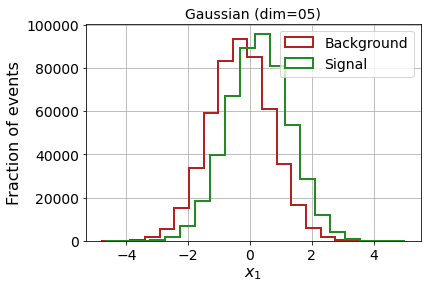

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.67107	validation_1-logloss:0.67110
[1]	validation_0-logloss:0.65263	validation_1-logloss:0.65260
[2]	validation_0-logloss:0.63704	validation_1-logloss:0.63704
[3]	validation_0-logloss:0.62373	validation_1-logloss:0.62374
[4]	validation_0-logloss:0.61213	validation_1-logloss:0.61222
[5]	validation_0-logloss:0.60205	validation_1-logloss:0.60218
[6]	validation_0-logloss:0.59321	validation_1-logloss:0.59337
[7]	validation_0-logloss:0.58538	validation_1-logloss:0.58560
[8]	validation_0-logloss:0.57851	validation_1-logloss:0.57877
[9]	validation_0-logloss:0.57236	validation_1-logloss:0.57263
[10]	validation_0-logloss:0.56688	validation_1-logloss:0.56719
[11]	validation_0-logloss:0.56196	validation_1-logloss:0.56231
[12]	validation_0-logloss:0.55753	validation_1-logloss:0.55792
[13]	validation_0-logloss:0.55354	validation_1-logloss:0.55397
[14]	validation_0-logloss:0.54984	validation_1-logloss:0.55028
[15]	validation_0-logloss:0.54657	validation_1-logloss:0.54705
[1

[130]	validation_0-logloss:0.50627	validation_1-logloss:0.50883
[131]	validation_0-logloss:0.50625	validation_1-logloss:0.50883
[132]	validation_0-logloss:0.50624	validation_1-logloss:0.50883
[133]	validation_0-logloss:0.50623	validation_1-logloss:0.50883
[134]	validation_0-logloss:0.50622	validation_1-logloss:0.50883
[135]	validation_0-logloss:0.50621	validation_1-logloss:0.50883
[136]	validation_0-logloss:0.50620	validation_1-logloss:0.50883
[137]	validation_0-logloss:0.50619	validation_1-logloss:0.50883
[138]	validation_0-logloss:0.50618	validation_1-logloss:0.50883
[139]	validation_0-logloss:0.50617	validation_1-logloss:0.50883
[140]	validation_0-logloss:0.50616	validation_1-logloss:0.50883
[141]	validation_0-logloss:0.50614	validation_1-logloss:0.50883
[142]	validation_0-logloss:0.50614	validation_1-logloss:0.50883
[143]	validation_0-logloss:0.50613	validation_1-logloss:0.50883
[144]	validation_0-logloss:0.50611	validation_1-logloss:0.50883
[145]	validation_0-logloss:0.50611	valid

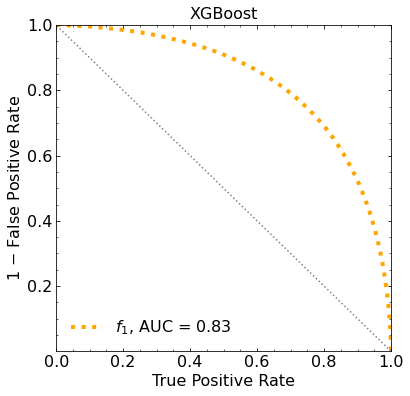

ML iteration 0


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.67046	validation_1-logloss:0.67083
[1]	validation_0-logloss:0.65143	validation_1-logloss:0.65225
[2]	validation_0-logloss:0.63540	validation_1-logloss:0.63665
[3]	validation_0-logloss:0.62162	validation_1-logloss:0.62323
[4]	validation_0-logloss:0.60953	validation_1-logloss:0.61160
[5]	validation_0-logloss:0.59904	validation_1-logloss:0.60154
[6]	validation_0-logloss:0.58984	validation_1-logloss:0.59266
[7]	validation_0-logloss:0.58172	validation_1-logloss:0.58493
[8]	validation_0-logloss:0.57444	validation_1-logloss:0.57801
[9]	validation_0-logloss:0.56792	validation_1-logloss:0.57183
[10]	validation_0-logloss:0.56212	validation_1-logloss:0.56637
[11]	validation_0-logloss:0.55689	validation_1-logloss:0.56155
[12]	validation_0-logloss:0.55223	validation_1-logloss:0.55710
[13]	validation_0-logloss:0.54799	validation_1-logloss:0.55316
[14]	validation_0-logloss:0.54414	validation_1-logloss:0.54967
[15]	validation_0-logloss:0.54064	validation_1-logloss:0.54646
[1

[130]	validation_0-logloss:0.49179	validation_1-logloss:0.51135
[131]	validation_0-logloss:0.49176	validation_1-logloss:0.51135
[132]	validation_0-logloss:0.49170	validation_1-logloss:0.51136
[133]	validation_0-logloss:0.49164	validation_1-logloss:0.51136
[134]	validation_0-logloss:0.49153	validation_1-logloss:0.51138
[135]	validation_0-logloss:0.49149	validation_1-logloss:0.51138
[136]	validation_0-logloss:0.49139	validation_1-logloss:0.51139
[137]	validation_0-logloss:0.49130	validation_1-logloss:0.51140
[138]	validation_0-logloss:0.49128	validation_1-logloss:0.51141
[139]	validation_0-logloss:0.49127	validation_1-logloss:0.51142
[140]	validation_0-logloss:0.49119	validation_1-logloss:0.51143


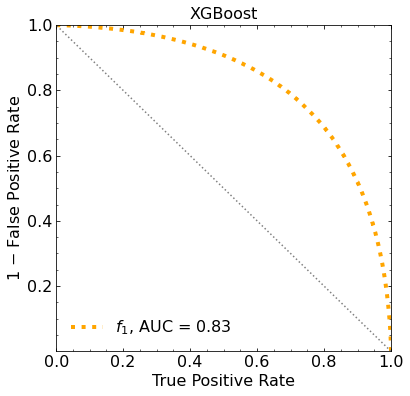

ML iteration  1


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.67070	validation_1-logloss:0.67090
[1]	validation_0-logloss:0.65185	validation_1-logloss:0.65243
[2]	validation_0-logloss:0.63599	validation_1-logloss:0.63691
[3]	validation_0-logloss:0.62233	validation_1-logloss:0.62355
[4]	validation_0-logloss:0.61048	validation_1-logloss:0.61197
[5]	validation_0-logloss:0.60007	validation_1-logloss:0.60191
[6]	validation_0-logloss:0.59093	validation_1-logloss:0.59306
[7]	validation_0-logloss:0.58287	validation_1-logloss:0.58522
[8]	validation_0-logloss:0.57576	validation_1-logloss:0.57849
[9]	validation_0-logloss:0.56937	validation_1-logloss:0.57236
[10]	validation_0-logloss:0.56358	validation_1-logloss:0.56683
[11]	validation_0-logloss:0.55845	validation_1-logloss:0.56200
[12]	validation_0-logloss:0.55383	validation_1-logloss:0.55758
[13]	validation_0-logloss:0.54958	validation_1-logloss:0.55360
[14]	validation_0-logloss:0.54577	validation_1-logloss:0.55002
[15]	validation_0-logloss:0.54230	validation_1-logloss:0.54676
[1

[130]	validation_0-logloss:0.49308	validation_1-logloss:0.51133
[131]	validation_0-logloss:0.49305	validation_1-logloss:0.51134
[132]	validation_0-logloss:0.49297	validation_1-logloss:0.51134
[133]	validation_0-logloss:0.49291	validation_1-logloss:0.51134
[134]	validation_0-logloss:0.49280	validation_1-logloss:0.51136
[135]	validation_0-logloss:0.49273	validation_1-logloss:0.51136
[136]	validation_0-logloss:0.49267	validation_1-logloss:0.51137
[137]	validation_0-logloss:0.49257	validation_1-logloss:0.51137


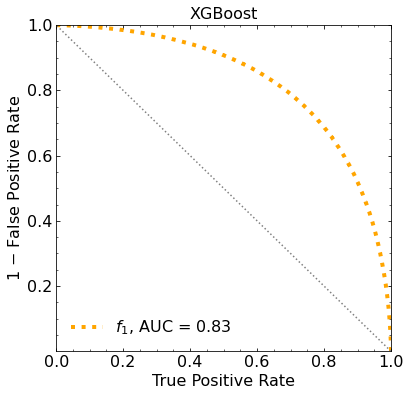

ML iteration  2
[0]	validation_0-logloss:0.67035	validation_1-logloss:0.67091


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	validation_0-logloss:0.65113	validation_1-logloss:0.65214
[2]	validation_0-logloss:0.63477	validation_1-logloss:0.63633
[3]	validation_0-logloss:0.62079	validation_1-logloss:0.62301
[4]	validation_0-logloss:0.60874	validation_1-logloss:0.61141
[5]	validation_0-logloss:0.59818	validation_1-logloss:0.60129
[6]	validation_0-logloss:0.58895	validation_1-logloss:0.59250
[7]	validation_0-logloss:0.58073	validation_1-logloss:0.58464
[8]	validation_0-logloss:0.57346	validation_1-logloss:0.57779
[9]	validation_0-logloss:0.56697	validation_1-logloss:0.57169
[10]	validation_0-logloss:0.56116	validation_1-logloss:0.56624
[11]	validation_0-logloss:0.55584	validation_1-logloss:0.56136
[12]	validation_0-logloss:0.55114	validation_1-logloss:0.55702
[13]	validation_0-logloss:0.54678	validation_1-logloss:0.55300
[14]	validation_0-logloss:0.54285	validation_1-logloss:0.54938
[15]	validation_0-logloss:0.53929	validation_1-logloss:0.54610
[16]	validation_0-logloss:0.53609	validation_1-logloss:0.54319
[

[131]	validation_0-logloss:0.49032	validation_1-logloss:0.51131
[132]	validation_0-logloss:0.49031	validation_1-logloss:0.51131
[133]	validation_0-logloss:0.49030	validation_1-logloss:0.51131
[134]	validation_0-logloss:0.49028	validation_1-logloss:0.51131
[135]	validation_0-logloss:0.49020	validation_1-logloss:0.51132
[136]	validation_0-logloss:0.49011	validation_1-logloss:0.51132
[137]	validation_0-logloss:0.49006	validation_1-logloss:0.51133
[138]	validation_0-logloss:0.49005	validation_1-logloss:0.51133
[139]	validation_0-logloss:0.48996	validation_1-logloss:0.51134


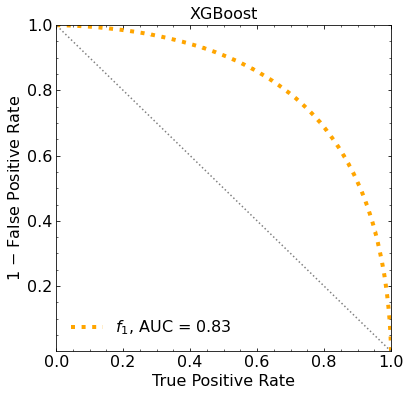

ML iteration  3


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.67071	validation_1-logloss:0.67106
[1]	validation_0-logloss:0.65194	validation_1-logloss:0.65269
[2]	validation_0-logloss:0.63596	validation_1-logloss:0.63704
[3]	validation_0-logloss:0.62218	validation_1-logloss:0.62362
[4]	validation_0-logloss:0.61025	validation_1-logloss:0.61200
[5]	validation_0-logloss:0.59976	validation_1-logloss:0.60197
[6]	validation_0-logloss:0.59058	validation_1-logloss:0.59304
[7]	validation_0-logloss:0.58255	validation_1-logloss:0.58534
[8]	validation_0-logloss:0.57531	validation_1-logloss:0.57842
[9]	validation_0-logloss:0.56888	validation_1-logloss:0.57228
[10]	validation_0-logloss:0.56314	validation_1-logloss:0.56680
[11]	validation_0-logloss:0.55794	validation_1-logloss:0.56190
[12]	validation_0-logloss:0.55327	validation_1-logloss:0.55749
[13]	validation_0-logloss:0.54902	validation_1-logloss:0.55359
[14]	validation_0-logloss:0.54507	validation_1-logloss:0.54995
[15]	validation_0-logloss:0.54160	validation_1-logloss:0.54673
[1

[130]	validation_0-logloss:0.49270	validation_1-logloss:0.51125
[131]	validation_0-logloss:0.49265	validation_1-logloss:0.51125
[132]	validation_0-logloss:0.49264	validation_1-logloss:0.51125
[133]	validation_0-logloss:0.49263	validation_1-logloss:0.51125
[134]	validation_0-logloss:0.49252	validation_1-logloss:0.51126
[135]	validation_0-logloss:0.49243	validation_1-logloss:0.51127
[136]	validation_0-logloss:0.49228	validation_1-logloss:0.51128
[137]	validation_0-logloss:0.49219	validation_1-logloss:0.51128
[138]	validation_0-logloss:0.49216	validation_1-logloss:0.51129
[139]	validation_0-logloss:0.49209	validation_1-logloss:0.51129
[140]	validation_0-logloss:0.49199	validation_1-logloss:0.51130
[141]	validation_0-logloss:0.49194	validation_1-logloss:0.51131


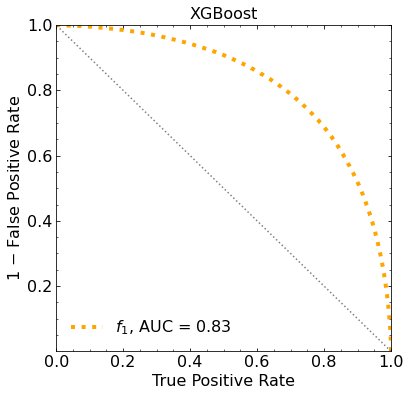

ML iteration  4


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.67051	validation_1-logloss:0.67080
[1]	validation_0-logloss:0.65155	validation_1-logloss:0.65227
[2]	validation_0-logloss:0.63552	validation_1-logloss:0.63664
[3]	validation_0-logloss:0.62180	validation_1-logloss:0.62322
[4]	validation_0-logloss:0.60984	validation_1-logloss:0.61164
[5]	validation_0-logloss:0.59940	validation_1-logloss:0.60159
[6]	validation_0-logloss:0.59019	validation_1-logloss:0.59276
[7]	validation_0-logloss:0.58206	validation_1-logloss:0.58500
[8]	validation_0-logloss:0.57484	validation_1-logloss:0.57812
[9]	validation_0-logloss:0.56840	validation_1-logloss:0.57199
[10]	validation_0-logloss:0.56254	validation_1-logloss:0.56653
[11]	validation_0-logloss:0.55733	validation_1-logloss:0.56160
[12]	validation_0-logloss:0.55269	validation_1-logloss:0.55722
[13]	validation_0-logloss:0.54844	validation_1-logloss:0.55323
[14]	validation_0-logloss:0.54452	validation_1-logloss:0.54961
[15]	validation_0-logloss:0.54101	validation_1-logloss:0.54631
[1

[130]	validation_0-logloss:0.49193	validation_1-logloss:0.51110
[131]	validation_0-logloss:0.49188	validation_1-logloss:0.51110
[132]	validation_0-logloss:0.49177	validation_1-logloss:0.51112
[133]	validation_0-logloss:0.49170	validation_1-logloss:0.51113
[134]	validation_0-logloss:0.49162	validation_1-logloss:0.51113
[135]	validation_0-logloss:0.49157	validation_1-logloss:0.51114
[136]	validation_0-logloss:0.49148	validation_1-logloss:0.51115
[137]	validation_0-logloss:0.49143	validation_1-logloss:0.51115
[138]	validation_0-logloss:0.49139	validation_1-logloss:0.51115
[139]	validation_0-logloss:0.49128	validation_1-logloss:0.51115


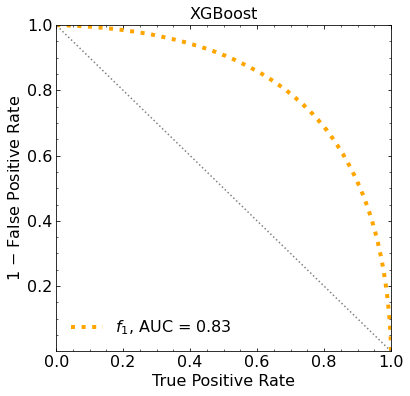

ML iteration  5
[0]	validation_0-logloss:0.67035	validation_1-logloss:0.67073


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	validation_0-logloss:0.65127	validation_1-logloss:0.65220
[2]	validation_0-logloss:0.63508	validation_1-logloss:0.63648
[3]	validation_0-logloss:0.62119	validation_1-logloss:0.62305
[4]	validation_0-logloss:0.60908	validation_1-logloss:0.61139
[5]	validation_0-logloss:0.59856	validation_1-logloss:0.60136
[6]	validation_0-logloss:0.58930	validation_1-logloss:0.59255
[7]	validation_0-logloss:0.58107	validation_1-logloss:0.58474
[8]	validation_0-logloss:0.57376	validation_1-logloss:0.57781
[9]	validation_0-logloss:0.56724	validation_1-logloss:0.57167
[10]	validation_0-logloss:0.56140	validation_1-logloss:0.56620
[11]	validation_0-logloss:0.55615	validation_1-logloss:0.56137
[12]	validation_0-logloss:0.55140	validation_1-logloss:0.55695
[13]	validation_0-logloss:0.54717	validation_1-logloss:0.55303
[14]	validation_0-logloss:0.54320	validation_1-logloss:0.54936
[15]	validation_0-logloss:0.53966	validation_1-logloss:0.54614
[16]	validation_0-logloss:0.53645	validation_1-logloss:0.54320
[

[131]	validation_0-logloss:0.48952	validation_1-logloss:0.51114
[132]	validation_0-logloss:0.48940	validation_1-logloss:0.51115
[133]	validation_0-logloss:0.48934	validation_1-logloss:0.51116
[134]	validation_0-logloss:0.48931	validation_1-logloss:0.51116


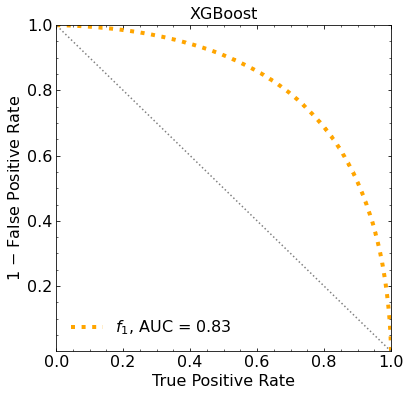

ML iteration  6


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.67062	validation_1-logloss:0.67110
[1]	validation_0-logloss:0.65174	validation_1-logloss:0.65251
[2]	validation_0-logloss:0.63585	validation_1-logloss:0.63700
[3]	validation_0-logloss:0.62207	validation_1-logloss:0.62360
[4]	validation_0-logloss:0.61028	validation_1-logloss:0.61211
[5]	validation_0-logloss:0.59990	validation_1-logloss:0.60208
[6]	validation_0-logloss:0.59084	validation_1-logloss:0.59327
[7]	validation_0-logloss:0.58278	validation_1-logloss:0.58551
[8]	validation_0-logloss:0.57562	validation_1-logloss:0.57863
[9]	validation_0-logloss:0.56929	validation_1-logloss:0.57264
[10]	validation_0-logloss:0.56356	validation_1-logloss:0.56720
[11]	validation_0-logloss:0.55830	validation_1-logloss:0.56225
[12]	validation_0-logloss:0.55365	validation_1-logloss:0.55789
[13]	validation_0-logloss:0.54940	validation_1-logloss:0.55396
[14]	validation_0-logloss:0.54560	validation_1-logloss:0.55037
[15]	validation_0-logloss:0.54204	validation_1-logloss:0.54701
[1

[130]	validation_0-logloss:0.49383	validation_1-logloss:0.51132
[131]	validation_0-logloss:0.49373	validation_1-logloss:0.51132
[132]	validation_0-logloss:0.49362	validation_1-logloss:0.51133
[133]	validation_0-logloss:0.49357	validation_1-logloss:0.51133
[134]	validation_0-logloss:0.49352	validation_1-logloss:0.51134
[135]	validation_0-logloss:0.49351	validation_1-logloss:0.51134
[136]	validation_0-logloss:0.49344	validation_1-logloss:0.51134
[137]	validation_0-logloss:0.49335	validation_1-logloss:0.51135
[138]	validation_0-logloss:0.49327	validation_1-logloss:0.51135
[139]	validation_0-logloss:0.49325	validation_1-logloss:0.51136
[140]	validation_0-logloss:0.49315	validation_1-logloss:0.51137


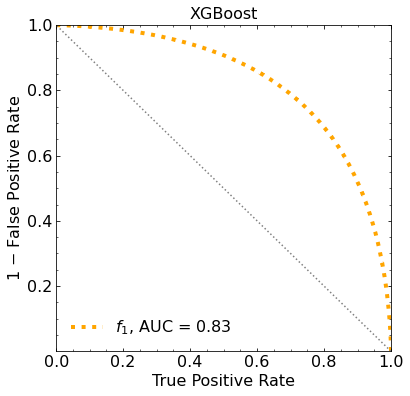

ML iteration  7


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.67075	validation_1-logloss:0.67105
[1]	validation_0-logloss:0.65211	validation_1-logloss:0.65261
[2]	validation_0-logloss:0.63601	validation_1-logloss:0.63698
[3]	validation_0-logloss:0.62213	validation_1-logloss:0.62338
[4]	validation_0-logloss:0.61013	validation_1-logloss:0.61176
[5]	validation_0-logloss:0.59968	validation_1-logloss:0.60171
[6]	validation_0-logloss:0.59052	validation_1-logloss:0.59289
[7]	validation_0-logloss:0.58239	validation_1-logloss:0.58516
[8]	validation_0-logloss:0.57509	validation_1-logloss:0.57823
[9]	validation_0-logloss:0.56861	validation_1-logloss:0.57209
[10]	validation_0-logloss:0.56285	validation_1-logloss:0.56667
[11]	validation_0-logloss:0.55761	validation_1-logloss:0.56178
[12]	validation_0-logloss:0.55292	validation_1-logloss:0.55740
[13]	validation_0-logloss:0.54866	validation_1-logloss:0.55348
[14]	validation_0-logloss:0.54478	validation_1-logloss:0.54991
[15]	validation_0-logloss:0.54127	validation_1-logloss:0.54668
[1

[130]	validation_0-logloss:0.49267	validation_1-logloss:0.51139
[131]	validation_0-logloss:0.49265	validation_1-logloss:0.51140
[132]	validation_0-logloss:0.49255	validation_1-logloss:0.51140
[133]	validation_0-logloss:0.49251	validation_1-logloss:0.51141
[134]	validation_0-logloss:0.49249	validation_1-logloss:0.51141
[135]	validation_0-logloss:0.49247	validation_1-logloss:0.51142
[136]	validation_0-logloss:0.49244	validation_1-logloss:0.51143


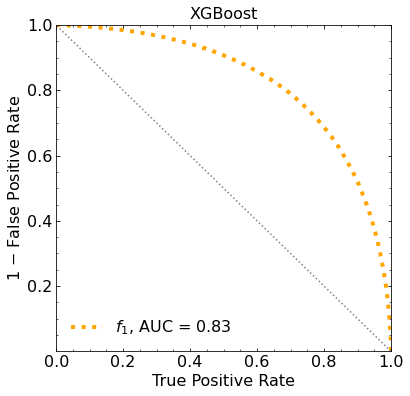

ML iteration  8
[0]	validation_0-logloss:0.67007	validation_1-logloss:0.67071


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	validation_0-logloss:0.65080	validation_1-logloss:0.65201
[2]	validation_0-logloss:0.63438	validation_1-logloss:0.63605
[3]	validation_0-logloss:0.62039	validation_1-logloss:0.62264
[4]	validation_0-logloss:0.60834	validation_1-logloss:0.61109
[5]	validation_0-logloss:0.59782	validation_1-logloss:0.60102
[6]	validation_0-logloss:0.58861	validation_1-logloss:0.59220
[7]	validation_0-logloss:0.58038	validation_1-logloss:0.58445
[8]	validation_0-logloss:0.57307	validation_1-logloss:0.57756
[9]	validation_0-logloss:0.56652	validation_1-logloss:0.57142
[10]	validation_0-logloss:0.56062	validation_1-logloss:0.56590
[11]	validation_0-logloss:0.55540	validation_1-logloss:0.56104
[12]	validation_0-logloss:0.55068	validation_1-logloss:0.55665
[13]	validation_0-logloss:0.54642	validation_1-logloss:0.55274
[14]	validation_0-logloss:0.54257	validation_1-logloss:0.54921
[15]	validation_0-logloss:0.53903	validation_1-logloss:0.54591
[16]	validation_0-logloss:0.53585	validation_1-logloss:0.54299
[

[131]	validation_0-logloss:0.48972	validation_1-logloss:0.51108
[132]	validation_0-logloss:0.48957	validation_1-logloss:0.51109
[133]	validation_0-logloss:0.48947	validation_1-logloss:0.51110
[134]	validation_0-logloss:0.48936	validation_1-logloss:0.51111
[135]	validation_0-logloss:0.48933	validation_1-logloss:0.51112
[136]	validation_0-logloss:0.48928	validation_1-logloss:0.51113
[137]	validation_0-logloss:0.48927	validation_1-logloss:0.51112
[138]	validation_0-logloss:0.48926	validation_1-logloss:0.51113
[139]	validation_0-logloss:0.48920	validation_1-logloss:0.51112
[140]	validation_0-logloss:0.48917	validation_1-logloss:0.51114
[141]	validation_0-logloss:0.48904	validation_1-logloss:0.51115
[142]	validation_0-logloss:0.48895	validation_1-logloss:0.51115


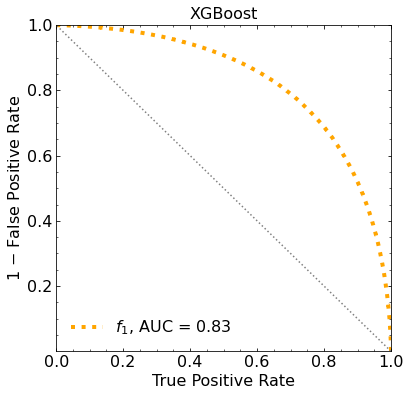

ML iteration  9
[0]	validation_0-logloss:0.67046	validation_1-logloss:0.67095


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	validation_0-logloss:0.65141	validation_1-logloss:0.65232
[2]	validation_0-logloss:0.63537	validation_1-logloss:0.63667
[3]	validation_0-logloss:0.62141	validation_1-logloss:0.62314
[4]	validation_0-logloss:0.60936	validation_1-logloss:0.61147
[5]	validation_0-logloss:0.59874	validation_1-logloss:0.60130
[6]	validation_0-logloss:0.58954	validation_1-logloss:0.59253
[7]	validation_0-logloss:0.58131	validation_1-logloss:0.58471
[8]	validation_0-logloss:0.57402	validation_1-logloss:0.57789
[9]	validation_0-logloss:0.56749	validation_1-logloss:0.57178
[10]	validation_0-logloss:0.56162	validation_1-logloss:0.56626
[11]	validation_0-logloss:0.55635	validation_1-logloss:0.56136
[12]	validation_0-logloss:0.55161	validation_1-logloss:0.55703
[13]	validation_0-logloss:0.54720	validation_1-logloss:0.55299
[14]	validation_0-logloss:0.54334	validation_1-logloss:0.54947
[15]	validation_0-logloss:0.53975	validation_1-logloss:0.54621
[16]	validation_0-logloss:0.53646	validation_1-logloss:0.54324
[

[131]	validation_0-logloss:0.48980	validation_1-logloss:0.51155
[132]	validation_0-logloss:0.48977	validation_1-logloss:0.51157
[133]	validation_0-logloss:0.48966	validation_1-logloss:0.51158


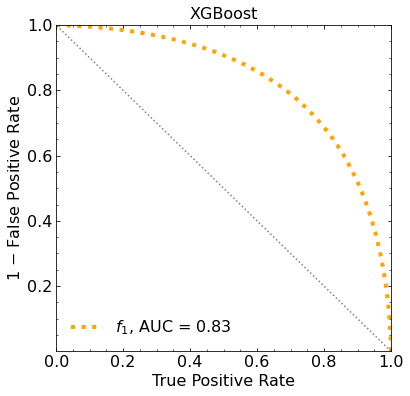

Classification score (1 ML):


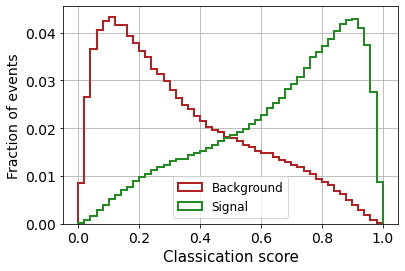

Classification score (10 ML):


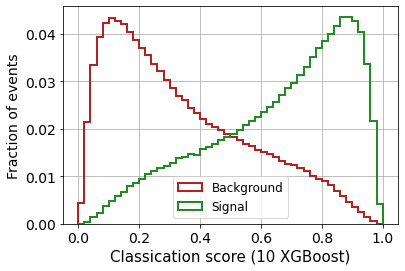

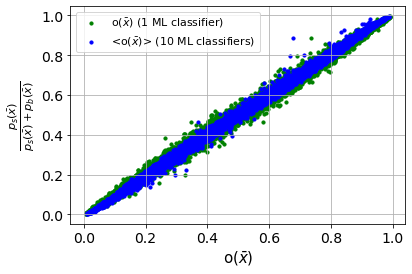


 ----------------------------------------- 

B_expected:  50000
S_expected:  500
S/$\sqrt{B}$:  2.23606797749979
 BINNED CLASSIFIER OUTPUT
  BL lineal bins, 1 ML
Z_XG 10 bins_1ML:  4.660390826388115
Z_XG 25 bins_1ML:  4.899357656695719
Z_XG 50 bins_1ML:  4.968508071289059
Z_XG 100 bins_1ML:  5.010463484741467

 BL non-lineal bins, 1 ML
Z_XG 10 bins_eq_1ML:  3.9370617003304536
Z_XG 25 bins_eq_1ML:  4.327588186033238
Z_XG 50 bins_eq_1ML:  4.552883445339372
Z_XG 100 bins_eq_1ML:  4.701700116407922

 BL lineal bins, 10 ML
Z_XG 10 bins:  4.696246349720171
Z_XG 25 bins:  4.949552822596091
Z_XG 50 bins:  5.007025259384875
Z_XG 100 bins:  5.029011051718

 BL non-lineal bins, 10 ML
Z_XG 10 bins_eq:  3.941220069775295
Z_XG 25 bins_eq:  4.3333976183059635
Z_XG 50 bins_eq:  4.567425361557609
Z_XG 100 bins_eq:  4.714365409482607

 ----------------------------------------- 


 If  20200  =  1101    then the proposed range has to be extended
n_ensembles (actual):  9863
TRUE PDF LIKELIHOOD (GAUSSIANS

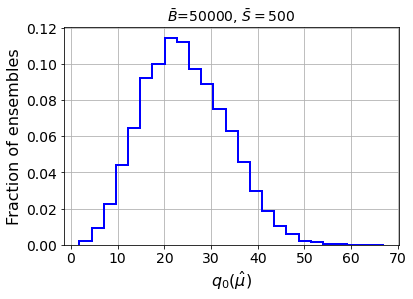

muhat mean:  0.11790023319476832
Z_gaussian:  4.883007366491196
Z_gaussian_mu0:  4.87101483319213

 ------------------------------------ 

 MLL + KDE (1ML) 


/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf   812.98291869
   820.33601263   825.21390664   827.44448001   828.44823467
   826.70332723   821.80425404   810.96877894   788.69931756
   748.75686545   680.25180687   563.59228735   373.76768188
    80.52604587  -345.22030921  -976.55478349 -1984.38910304]
  warnings.warn(
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:929: RuntimeWarning: invalid value encountered in subtract
  array_stds = np.sqrt(np.average((array -
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
   850.42437787   855.62430144   858.0539142    859.5089969
   857.23010168   850.87015335   838.1586278    815.41619498
   77

KDE Kernel:  epanechnikov
Background bandwidth:  0.01329487353451575
Signal bandwidth:  0.01329487353451575


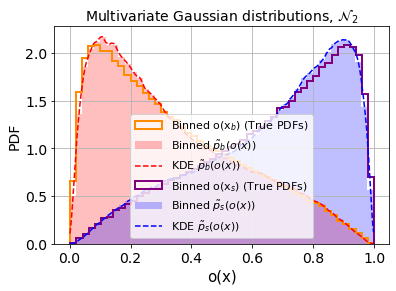

 MLL + KDE (10ML) 


/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf   859.15625073
   866.55363283   870.54484691   872.74249053   873.39167151
   872.4249792    868.96122848   859.41413653   838.95868926
   800.79680948   733.75864521   616.92938914   425.61204906
   130.25414327  -300.3125843   -945.97393658 -1971.23339495]
  warnings.warn(
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:929: RuntimeWarning: invalid value encountered in subtract
  array_stds = np.sqrt(np.average((array -
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf   905.73557999   908.01077226
   906.9961127    902.15346064   891.91408078   871.43930175
   8

KDE Kernel:  epanechnikov
Background bandwidth:  0.01329487353451575
Signal bandwidth:  0.01329487353451575


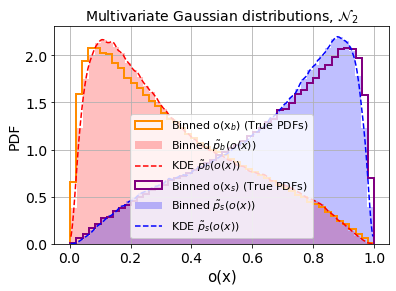

 Z MLL+KDE (1ML) 


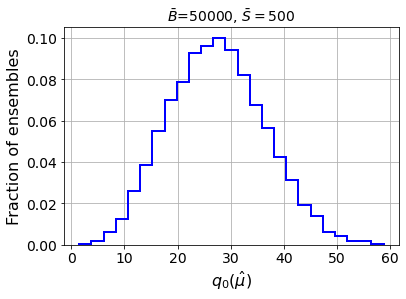

muhat mean_1ML:  0.059277096218189204
Z_KDE_1ML:  5.216105483108124
Z_KDE mu=0_1ML:  5.216105483108124

 Z MLL+KDE (10ML) 


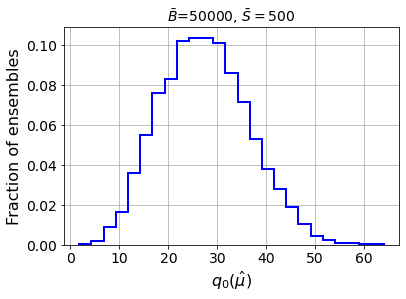

muhat mean:  0.06136064077866775
Z_KDE:  5.209005219310739
Z_KDE mu=0:  5.209076263291725

 ------------------------------------ 



In [121]:
dim=5

#######################
# generate the events #
#######################
    
mean_sig = epsilon*np.ones(dim)
mean_bkg = -1*mean_sig

#cov_sig = np.identity(dim)
cov_sig = np.identity(dim) + (0. * ( np.ones((dim,dim)) - np.identity(dim) ))
cov_bkg = cov_sig

signal_X_1, signal_X_2, signal_X_3, signal_X_4, signal_X_5 = np.random.multivariate_normal(mean_sig, cov_sig, N).T
background_X_1, background_X_2, background_X_3, background_X_4, background_X_5 = np.random.multivariate_normal(mean_bkg, cov_bkg, N).T


dim1 = np.concatenate((background_X_1,signal_X_1))
dim2 = np.concatenate((background_X_2,signal_X_2))
dim3 = np.concatenate((background_X_3,signal_X_3))
dim4 = np.concatenate((background_X_4,signal_X_4))
dim5 = np.concatenate((background_X_5,signal_X_5))


# labels
background_Y = np.zeros(N)
signal_Y = np.ones(N)

# DATA in a single matrix (features + labels)
df = pd.DataFrame()
df['dim1'] = dim1.reshape(-1)
df['dim2'] = dim2.reshape(-1)
df['dim3'] = dim3.reshape(-1)
df['dim4'] = dim4.reshape(-1)
df['dim5'] = dim5.reshape(-1)
df['Y'] = np.concatenate((background_Y.astype('int'),signal_Y.astype('int')))

X_gauss = df[['dim1','dim2','dim3','dim4','dim5']].values 
Y_gauss = df[['Y']].values

# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.5

X_gauss_aux, X_gauss_test, Y_gauss_aux, Y_gauss_test = train_test_split(X_gauss,
                                                                Y_gauss,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_gauss,
                                                                shuffle=True)


X_gauss_train, X_gauss_val, Y_gauss_train, Y_gauss_val = train_test_split(X_gauss_aux,
                                                                  Y_gauss_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_gauss_aux,
                                                                  shuffle=True)

print('')
print('X_gauss_train : ', X_gauss_train.shape)
print('y_gauss_train : ', Y_gauss_train.shape)
print('X_gauss_val : ', X_gauss_val.shape)
print('y_gauss_val : ', Y_gauss_val.shape)
print('X_gauss_test : ', X_gauss_test.shape)
print('y_gauss_test : ', Y_gauss_test.shape)
print('')


# PLOT (only 1st feature) to visualize the data
X_gauss_test_SM = []
X_gauss_test_NP = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] ==0:
        X_gauss_test_SM.append(X_gauss_test[i].tolist())
    else:
        X_gauss_test_NP.append(X_gauss_test[i].tolist())    


X_gauss_test_SM = np.array(X_gauss_test_SM)
X_gauss_test_NP = np.array(X_gauss_test_NP)


weights = np.ones_like(X_gauss_test_SM[:,0])/float(len(X_gauss_test_SM[:,0]))
plt.hist(X_gauss_test_SM[:,0], 20, histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(X_gauss_test_NP[:,0])/float(len(X_gauss_test_NP[:,0]))
plt.hist(X_gauss_test_NP[:,0], 20, histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$x_1$",fontsize=16)
plt.ylabel("Fraction of events",fontsize=16)
plt.grid()
plt.legend(fontsize=14)
plt.title(r"Gaussian (dim=%0.2d)" % dim,fontsize=14)
plt.show()  






################################
# the true pdfs (useful later) #
################################

sig_multi = multivariate_normal(mean_sig, cov_sig)
bkg_multi = multivariate_normal(mean_bkg, cov_bkg) 




#######################
# CLASSIFIER: XGBoost #
#######################

# only 1 ML
roc_auc_XG, y_pred_xg_1ML = XG(X_gauss_train, X_gauss_test, X_gauss_val, Y_gauss_train, Y_gauss_test, Y_gauss_val)

store_AUC.append(roc_auc_XG)


# Bagging

print('ML iteration 0')
roc_auc_XG, y_pred_xg_aux = XG(X_gauss_train[:100000], X_gauss_test, X_gauss_val, Y_gauss_train[:100000], Y_gauss_test, Y_gauss_val)
y_pred_xg_auxRE = np.reshape(y_pred_xg_aux, (1,len(y_pred_xg_aux)))

for it in range(1,iterations_ML):

    print('ML iteration ', it)
    roc_auc_XG, y_pred_xg_aux_it = XG(X_gauss_train[(100000*it):(100000*it)+100000], X_gauss_test, X_gauss_val, Y_gauss_train[(100000*it):(100000*it)+100000], Y_gauss_test, Y_gauss_val)
    
    y_pred_xg_auxRE_it = np.reshape(y_pred_xg_aux_it, (1,len(y_pred_xg_aux_it)))
    
    y_pred_xg_auxRE = np.concatenate([y_pred_xg_auxRE,y_pred_xg_auxRE_it])

# to smooth, mean of 10 predictions
y_pred_xg = np.mean(y_pred_xg_auxRE, axis=0)




########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

# 1 ML
pred_XG_SM_1ML = []
pred_XG_NP_1ML = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] == 0:
        pred_XG_SM_1ML.append(y_pred_xg_1ML[i])
    else:
        pred_XG_NP_1ML.append(y_pred_xg_1ML[i])
        
# Bagging  
pred_XG_SM = []
pred_XG_NP = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score (1 ML):')
        
weights = np.ones_like(pred_XG_SM_1ML)/float(len(pred_XG_SM_1ML))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM_1ML, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP_1ML)/float(len(pred_XG_NP_1ML))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP_1ML, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12, loc="lower center")
plt.show()


print('Classification score (10 ML):')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (10 XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12, loc="lower center")
plt.show()




ratio_ps_pb_true = sig_multi.pdf(X_gauss_test) / ( sig_multi.pdf(X_gauss_test) + bkg_multi.pdf(X_gauss_test) )
ratio_ps_pb_true_B = sig_multi.pdf(X_gauss_test_SM) / ( sig_multi.pdf(X_gauss_test_SM) + bkg_multi.pdf(X_gauss_test_SM) )
ratio_ps_pb_true_S = sig_multi.pdf(X_gauss_test_NP) / ( sig_multi.pdf(X_gauss_test_NP) + bkg_multi.pdf(X_gauss_test_NP) )

plt.scatter(y_pred_xg_1ML[:10000], ratio_ps_pb_true[:10000], color='green', label=r'o($\bar{x}$) (1 ML classifier)', s=10)
plt.scatter(y_pred_xg[:10000], ratio_ps_pb_true[:10000], color='blue', label=r'<o($\bar{x}$)> (10 ML classifiers)', s=10)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r"o($\bar{x}$)",fontsize=15)
plt.ylabel(r"$\frac{p_s(\bar{x})}{p_s(\bar{x})+p_b(\bar{x})}$",fontsize=16)
plt.grid()
plt.legend(fontsize=11)
#plt.savefig('images/' + 'optimalclass-vs-ox.pdf', format="pdf", bbox_inches="tight")
plt.show()

print('\n ----------------------------------------- \n')






###########
# METHODS #
###########

print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)



############################
# BINNED CLASSIFIER OUTPUT #
############################

print(' BINNED CLASSIFIER OUTPUT')

print('  BL lineal bins, 1 ML')

# 10 BINS
Z_bins_XG_10bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 10, [[0,1]], linear_bins=True)
store_Z_bins_XG_10bins_1ML.append(Z_bins_XG_10bins_1ML)
print('Z_XG 10 bins_1ML: ', Z_bins_XG_10bins_1ML)

# 25 BINS
Z_bins_XG_25bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 25, [[0,1]], linear_bins=True)
store_Z_bins_XG_25bins_1ML.append(Z_bins_XG_25bins_1ML)
print('Z_XG 25 bins_1ML: ', Z_bins_XG_25bins_1ML)

# 50 BINS
Z_bins_XG_50bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 50, [[0,1]], linear_bins=True)
store_Z_bins_XG_50bins_1ML.append(Z_bins_XG_50bins_1ML)
print('Z_XG 50 bins_1ML: ', Z_bins_XG_50bins_1ML)

# 100 BINS
Z_bins_XG_100bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 100, [[0,1]], linear_bins=True)
store_Z_bins_XG_100bins_1ML.append(Z_bins_XG_100bins_1ML)
print('Z_XG 100 bins_1ML: ', Z_bins_XG_100bins_1ML)


print('\n BL non-lineal bins, 1 ML')

# 10 BINS
Z_bins_XG_10bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 10, [[0,1]], linear_bins=False)
store_Z_bins_XG_10bins_eq_1ML.append(Z_bins_XG_10bins_eq_1ML)
print('Z_XG 10 bins_eq_1ML: ', Z_bins_XG_10bins_eq_1ML)

# 25 BINS
Z_bins_XG_25bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 25, [[0,1]], linear_bins=False)
store_Z_bins_XG_25bins_eq_1ML.append(Z_bins_XG_25bins_eq_1ML)
print('Z_XG 25 bins_eq_1ML: ', Z_bins_XG_25bins_eq_1ML)

# 50 BINS
Z_bins_XG_50bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 50, [[0,1]], linear_bins=False)
store_Z_bins_XG_50bins_eq_1ML.append(Z_bins_XG_50bins_eq_1ML)
print('Z_XG 50 bins_eq_1ML: ', Z_bins_XG_50bins_eq_1ML)

# 100 BINS
Z_bins_XG_100bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 100, [[0,1]], linear_bins=False)
store_Z_bins_XG_100bins_eq_1ML.append(Z_bins_XG_100bins_eq_1ML)
print('Z_XG 100 bins_eq_1ML: ', Z_bins_XG_100bins_eq_1ML)


print('\n BL lineal bins, 10 ML')

# 10 BINS
Z_bins_XG_10bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 10, [[0,1]], linear_bins=True)
store_Z_bins_XG_10bins.append(Z_bins_XG_10bins)
print('Z_XG 10 bins: ', Z_bins_XG_10bins)

# 25 BINS
Z_bins_XG_25bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 25, [[0,1]], linear_bins=True)
store_Z_bins_XG_25bins.append(Z_bins_XG_25bins)
print('Z_XG 25 bins: ', Z_bins_XG_25bins)

# 50 BINS
Z_bins_XG_50bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 50, [[0,1]], linear_bins=True)
store_Z_bins_XG_50bins.append(Z_bins_XG_50bins)
print('Z_XG 50 bins: ', Z_bins_XG_50bins)

# 100 BINS
Z_bins_XG_100bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 100, [[0,1]], linear_bins=True)
store_Z_bins_XG_100bins.append(Z_bins_XG_100bins)
print('Z_XG 100 bins: ', Z_bins_XG_100bins)


print('\n BL non-lineal bins, 10 ML')

# 10 BINS
Z_bins_XG_10bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 10, [[0,1]], linear_bins=False)
store_Z_bins_XG_10bins_eq.append(Z_bins_XG_10bins_eq)
print('Z_XG 10 bins_eq: ', Z_bins_XG_10bins_eq)

# 25 BINS
Z_bins_XG_25bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 25, [[0,1]], linear_bins=False)
store_Z_bins_XG_25bins_eq.append(Z_bins_XG_25bins_eq)
print('Z_XG 25 bins_eq: ', Z_bins_XG_25bins_eq)

# 50 BINS
Z_bins_XG_50bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 50, [[0,1]], linear_bins=False)
store_Z_bins_XG_50bins_eq.append(Z_bins_XG_50bins_eq)
print('Z_XG 50 bins_eq: ', Z_bins_XG_50bins_eq)

# 100 BINS
Z_bins_XG_100bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 100, [[0,1]], linear_bins=False)
store_Z_bins_XG_100bins_eq.append(Z_bins_XG_100bins_eq)
print('Z_XG 100 bins_eq: ', Z_bins_XG_100bins_eq)


print('\n ----------------------------------------- \n')






###########################
# SET THE TOY EXPERIMENTS #
###########################

list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles = ensembler(B_expected, S_expected, n_ensembles)






###################################
# TRUE PDF LIKELIHOOD (GAUSSIANS) #
###################################

indices = [i for i in range(len(X_gauss_test_SM))]

prob_B_given_B = bkg_multi.pdf(X_gauss_test_SM)
prob_B_given_S = sig_multi.pdf(X_gauss_test_SM)



print('TRUE PDF LIKELIHOOD (GAUSSIANS):')

print('n_ensembles (initial): ', n_ensembles)

Z_gaussian, muhat_mean_gaussian, Z_gaussian_mu0, muhat_selected_list, q_muhat, q_muhat_mu0 = Z_MLL(B_expected, S_expected, prob_B_given_B, prob_B_given_S, list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles)

# Histogram of q_muhats

weights = np.ones_like(q_muhat)/float(len(q_muhat))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()

store_muhat_mean_gaussian.append(muhat_mean_gaussian)
store_Z_gaussian.append(Z_gaussian)

store_Z_gaussian_mu0.append(Z_gaussian_mu0)

print('muhat mean: ', muhat_mean_gaussian)
print('Z_gaussian: ', Z_gaussian)
print('Z_gaussian_mu0: ', Z_gaussian_mu0)


print('\n ------------------------------------ \n')







#########
#  KDE  #
#########  

print(' MLL + KDE (1ML) ')

kde_bkg_1ML, kde_sig_1ML, B_bandwidth_1ML, S_bandwidth_1ML = KDE_finder(pred_XG_SM_1ML, pred_XG_NP_1ML)


# range (~between 0 and 1)
min_val_1ML = np.min([np.min(pred_XG_SM_1ML),np.min(pred_XG_NP_1ML)])
max_val_1ML = np.max([np.max(pred_XG_SM_1ML),np.max(pred_XG_NP_1ML)])

s_vals_1ML = np.linspace(min_val_1ML,max_val_1ML,1000)



# evaluate the densities for each value of s (~bins)
dens_bkg_1ML = np.exp(kde_bkg_1ML.score_samples(np.c_[s_vals_1ML, np.zeros(len(s_vals_1ML)) ]) )
dens_sig_1ML = np.exp(kde_sig_1ML.score_samples(np.c_[s_vals_1ML, np.ones(len(s_vals_1ML)) ]) )



# Normalize to 1
# Area
factor_aux_SM_1ML = sum(dens_bkg_1ML*(s_vals_1ML[1]-s_vals_1ML[0]))
factor_aux_NP_1ML = sum(dens_sig_1ML*(s_vals_1ML[1]-s_vals_1ML[0]))

# normalize
dens_bkg_1ML = dens_bkg_1ML / factor_aux_SM_1ML
dens_sig_1ML = dens_sig_1ML / factor_aux_NP_1ML





# plot to check the estimation

plt.figure()

plt.hist(ratio_ps_pb_true_B,density=True,bins=50,lw=2,histtype='step',color='darkorange',alpha=1,label=r'Binned o(x$_b$) (True PDFs)')
plt.hist(pred_XG_SM_1ML,density=True,bins=50,color='red',alpha=0.25,label=r'Binned $\tilde{p}_{b}(o(x))$');
plt.plot(s_vals_1ML,dens_bkg_1ML,color='red',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');

plt.hist(ratio_ps_pb_true_S,density=True,bins=50,lw=2,histtype='step',color='purple',alpha=1,label=r'Binned o(x$_s$) (True PDFs)');
plt.hist(pred_XG_NP_1ML,density=True,bins=50,color='blue',alpha=0.25,label=r'Binned $\tilde{p}_{s}(o(x))$');
plt.plot(s_vals_1ML,dens_sig_1ML,color='blue',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("o(x)",fontsize=15)
plt.ylabel("PDF",fontsize=14)
plt.grid()
plt.legend(loc="lower center", fontsize=11, handlelength=2.5)
plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{2}$', fontsize=14)
#plt.savefig('images/' + '2gaussian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()





print(' MLL + KDE (10ML) ')

kde_bkg, kde_sig, B_bandwidth, S_bandwidth = KDE_finder(pred_XG_SM, pred_XG_NP)


# range (~between 0 and 1)
min_val = np.min([np.min(pred_XG_SM),np.min(pred_XG_NP)])
max_val = np.max([np.max(pred_XG_SM),np.max(pred_XG_NP)])

s_vals = np.linspace(min_val,max_val,1000)



# evaluate the densities for each value of s (~bins)
dens_bkg = np.exp(kde_bkg.score_samples(np.c_[s_vals, np.zeros(len(s_vals)) ]) )
dens_sig = np.exp(kde_sig.score_samples(np.c_[s_vals, np.ones(len(s_vals)) ]) )



# Normalize to 1
# Area
factor_aux_SM = sum(dens_bkg*(s_vals[1]-s_vals[0]))
factor_aux_NP = sum(dens_sig*(s_vals[1]-s_vals[0]))

# normalize
dens_bkg = dens_bkg / factor_aux_SM
dens_sig = dens_sig / factor_aux_NP





# plot to check the estimation

plt.figure()

plt.hist(ratio_ps_pb_true_B,density=True,bins=50,lw=2,histtype='step',color='darkorange',alpha=1,label=r'Binned o(x$_b$) (True PDFs)')
plt.hist(pred_XG_SM,density=True,bins=50,color='red',alpha=0.25,label=r'Binned $\tilde{p}_{b}(o(x))$');
plt.plot(s_vals,dens_bkg,color='red',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');

plt.hist(ratio_ps_pb_true_S,density=True,bins=50,lw=2,histtype='step',color='purple',alpha=1,label=r'Binned o(x$_s$) (True PDFs)');
plt.hist(pred_XG_NP,density=True,bins=50,color='blue',alpha=0.25,label=r'Binned $\tilde{p}_{s}(o(x))$');
plt.plot(s_vals,dens_sig,color='blue',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("o(x)",fontsize=15)
plt.ylabel("PDF",fontsize=14)
plt.grid()
plt.legend(loc="lower center", fontsize=11, handlelength=2.5)
plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{2}$', fontsize=14)
#plt.savefig('images/' + '2gaussian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()






#############
# MLL + KDE #
#############

print(' Z MLL+KDE (1ML) ')
# FOR EXCLUSION:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

KDE_SM_pred_SM_1ML = np.exp(kde_bkg_1ML.score_samples(np.c_[pred_XG_SM_1ML, np.zeros(len(pred_XG_SM_1ML)) ]) )
KDE_NP_pred_SM_1ML = np.exp(kde_sig_1ML.score_samples(np.c_[pred_XG_SM_1ML, np.ones(len(pred_XG_SM_1ML)) ]) )

# Normalize

KDE_SM_pred_SM_1ML = KDE_SM_pred_SM_1ML / factor_aux_SM_1ML
KDE_NP_pred_SM_1ML = KDE_NP_pred_SM_1ML / factor_aux_NP_1ML


indices_1ML = [i for i in range(len(KDE_NP_pred_SM_1ML))]

prob_B_given_B_1ML = KDE_SM_pred_SM_1ML
prob_B_given_S_1ML = KDE_NP_pred_SM_1ML

Z_KDE_1ML, muhat_mean_MLL_KDE_1ML, Z_KDE_mu0_1ML, muhat_selected_list_1ML, q_muhat_1ML, q_muhat_mu0_1ML = Z_MLL(B_expected, S_expected, prob_B_given_B_1ML, prob_B_given_S_1ML, list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles)
    
    
# Histogram of q_muhats

weights = np.ones_like(q_muhat_1ML)/float(len(q_muhat_1ML))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat_1ML, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()


store_muhat_mean_MLL_KDE_1ML.append(muhat_mean_MLL_KDE_1ML)
store_Z_MLL_KDE_1ML.append(Z_KDE_1ML)

store_Z_MLL_KDE_mu0_1ML.append(Z_KDE_mu0_1ML)

print('muhat mean_1ML: ', muhat_mean_MLL_KDE_1ML)
print('Z_KDE_1ML: ', Z_KDE_1ML)
print('Z_KDE mu=0_1ML: ', Z_KDE_mu0_1ML)



print('\n Z MLL+KDE (10ML) ')
# FOR EXCLUSION:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

KDE_SM_pred_SM = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
KDE_NP_pred_SM = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )

# Normalize

KDE_SM_pred_SM = KDE_SM_pred_SM / factor_aux_SM
KDE_NP_pred_SM = KDE_NP_pred_SM / factor_aux_NP


indices = [i for i in range(len(KDE_NP_pred_SM))]

prob_B_given_B = KDE_SM_pred_SM
prob_B_given_S = KDE_NP_pred_SM

Z_KDE, muhat_mean_MLL_KDE, Z_KDE_mu0, muhat_selected_list, q_muhat, q_muhat_mu0 = Z_MLL(B_expected, S_expected, prob_B_given_B, prob_B_given_S, list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles)
    
    
# Histogram of q_muhats

weights = np.ones_like(q_muhat)/float(len(q_muhat))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()


store_muhat_mean_MLL_KDE.append(muhat_mean_MLL_KDE)
store_Z_MLL_KDE.append(Z_KDE)

store_Z_MLL_KDE_mu0.append(Z_KDE_mu0)

print('muhat mean: ', muhat_mean_MLL_KDE)
print('Z_KDE: ', Z_KDE)
print('Z_KDE mu=0: ', Z_KDE_mu0)

print('\n ------------------------------------ \n')

In [ ]:
print(roc_auc_XG)

print(Z_bins_XG_10bins_1ML)
print(Z_bins_XG_25bins_1ML)
print(Z_bins_XG_50bins_1ML)
print(Z_bins_XG_100bins_1ML)

print(Z_bins_XG_10bins_eq_1ML)
print(Z_bins_XG_25bins_eq_1ML)
print(Z_bins_XG_50bins_eq_1ML)
print(Z_bins_XG_100bins_eq_1ML)

print(Z_bins_XG_10bins)
print(Z_bins_XG_25bins)
print(Z_bins_XG_50bins)
print(Z_bins_XG_100bins)

print(Z_bins_XG_10bins_eq)
print(Z_bins_XG_25bins_eq)
print(Z_bins_XG_50bins_eq)
print(Z_bins_XG_100bins_eq)

print(muhat_mean_gaussian)
print(Z_gaussian)
print(Z_gaussian_mu0)

print(muhat_mean_MLL_KDE)
print(Z_KDE)
print(Z_KDE_mu0)

print(muhat_mean_MLL_KDE_1ML)
print(Z_KDE_1ML)
print(Z_KDE_mu0_1ML)

In [ ]:
store_AUC.append()

store_Z_bins_XG_10bins_1ML.append()
store_Z_bins_XG_25bins_1ML.append()
store_Z_bins_XG_50bins_1ML.append()
store_Z_bins_XG_100bins_1ML.append()

store_Z_bins_XG_10bins_eq_1ML.append()
store_Z_bins_XG_25bins_eq_1ML.append()
store_Z_bins_XG_50bins_eq_1ML.append()
store_Z_bins_XG_100bins_eq_1ML.append()

store_Z_bins_XG_10bins.append()
store_Z_bins_XG_25bins.append()
store_Z_bins_XG_50bins.append()
store_Z_bins_XG_100bins.append()

store_Z_bins_XG_10bins_eq.append()
store_Z_bins_XG_25bins_eq.append()
store_Z_bins_XG_50bins_eq.append()
store_Z_bins_XG_100bins_eq.append()

store_muhat_mean_gaussian.append()
store_Z_gaussian.append()
store_Z_gaussian_mu0.append()

store_muhat_mean_MLL_KDE.append()
store_Z_MLL_KDE.append()
store_Z_MLL_KDE_mu0.append()

store_muhat_mean_MLL_KDE_1ML.append()
store_Z_MLL_KDE_1ML.append()
store_Z_MLL_KDE_mu0_1ML.append()


X_gauss_train :  (1000000, 6)
y_gauss_train :  (1000000, 1)
X_gauss_val :  (1000000, 6)
y_gauss_val :  (1000000, 1)
X_gauss_test :  (1000000, 6)
y_gauss_test :  (1000000, 1)



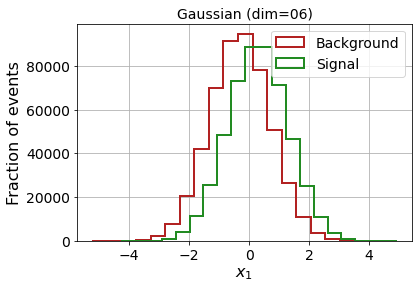

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.67088	validation_1-logloss:0.67114
[1]	validation_0-logloss:0.65147	validation_1-logloss:0.65192
[2]	validation_0-logloss:0.63506	validation_1-logloss:0.63567
[3]	validation_0-logloss:0.62066	validation_1-logloss:0.62149
[4]	validation_0-logloss:0.60795	validation_1-logloss:0.60897
[5]	validation_0-logloss:0.59669	validation_1-logloss:0.59790
[6]	validation_0-logloss:0.58673	validation_1-logloss:0.58805
[7]	validation_0-logloss:0.57792	validation_1-logloss:0.57935
[8]	validation_0-logloss:0.56998	validation_1-logloss:0.57159
[9]	validation_0-logloss:0.56283	validation_1-logloss:0.56456
[10]	validation_0-logloss:0.55636	validation_1-logloss:0.55822
[11]	validation_0-logloss:0.55052	validation_1-logloss:0.55253
[12]	validation_0-logloss:0.54521	validation_1-logloss:0.54731
[13]	validation_0-logloss:0.54036	validation_1-logloss:0.54261
[14]	validation_0-logloss:0.53595	validation_1-logloss:0.53826
[15]	validation_0-logloss:0.53194	validation_1-logloss:0.53437
[1

[130]	validation_0-logloss:0.47536	validation_1-logloss:0.48147
[131]	validation_0-logloss:0.47534	validation_1-logloss:0.48147
[132]	validation_0-logloss:0.47532	validation_1-logloss:0.48147
[133]	validation_0-logloss:0.47530	validation_1-logloss:0.48147
[134]	validation_0-logloss:0.47529	validation_1-logloss:0.48147
[135]	validation_0-logloss:0.47528	validation_1-logloss:0.48147
[136]	validation_0-logloss:0.47526	validation_1-logloss:0.48146
[137]	validation_0-logloss:0.47525	validation_1-logloss:0.48146
[138]	validation_0-logloss:0.47524	validation_1-logloss:0.48146
[139]	validation_0-logloss:0.47521	validation_1-logloss:0.48146
[140]	validation_0-logloss:0.47520	validation_1-logloss:0.48146
[141]	validation_0-logloss:0.47519	validation_1-logloss:0.48146
[142]	validation_0-logloss:0.47518	validation_1-logloss:0.48146
[143]	validation_0-logloss:0.47517	validation_1-logloss:0.48146
[144]	validation_0-logloss:0.47515	validation_1-logloss:0.48146
[145]	validation_0-logloss:0.47514	valid

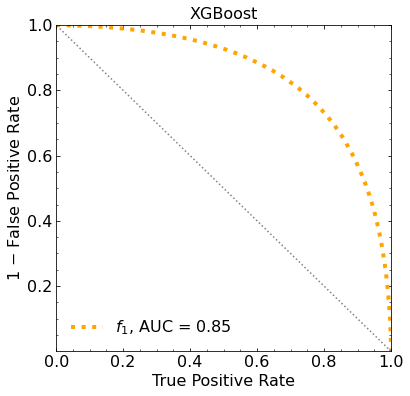

ML iteration 0


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.66988	validation_1-logloss:0.67061
[1]	validation_0-logloss:0.65008	validation_1-logloss:0.65164
[2]	validation_0-logloss:0.63283	validation_1-logloss:0.63508
[3]	validation_0-logloss:0.61771	validation_1-logloss:0.62053
[4]	validation_0-logloss:0.60448	validation_1-logloss:0.60784
[5]	validation_0-logloss:0.59270	validation_1-logloss:0.59670
[6]	validation_0-logloss:0.58212	validation_1-logloss:0.58674
[7]	validation_0-logloss:0.57260	validation_1-logloss:0.57794
[8]	validation_0-logloss:0.56417	validation_1-logloss:0.57005
[9]	validation_0-logloss:0.55663	validation_1-logloss:0.56301
[10]	validation_0-logloss:0.54980	validation_1-logloss:0.55669
[11]	validation_0-logloss:0.54359	validation_1-logloss:0.55094
[12]	validation_0-logloss:0.53792	validation_1-logloss:0.54570
[13]	validation_0-logloss:0.53274	validation_1-logloss:0.54103
[14]	validation_0-logloss:0.52807	validation_1-logloss:0.53674
[15]	validation_0-logloss:0.52372	validation_1-logloss:0.53284
[1

[130]	validation_0-logloss:0.45661	validation_1-logloss:0.48417
[131]	validation_0-logloss:0.45646	validation_1-logloss:0.48417
[132]	validation_0-logloss:0.45639	validation_1-logloss:0.48417
[133]	validation_0-logloss:0.45626	validation_1-logloss:0.48419
[134]	validation_0-logloss:0.45625	validation_1-logloss:0.48419
[135]	validation_0-logloss:0.45620	validation_1-logloss:0.48420
[136]	validation_0-logloss:0.45612	validation_1-logloss:0.48420
[137]	validation_0-logloss:0.45599	validation_1-logloss:0.48422
[138]	validation_0-logloss:0.45590	validation_1-logloss:0.48422
[139]	validation_0-logloss:0.45582	validation_1-logloss:0.48423
[140]	validation_0-logloss:0.45574	validation_1-logloss:0.48423
[141]	validation_0-logloss:0.45568	validation_1-logloss:0.48423
[142]	validation_0-logloss:0.45564	validation_1-logloss:0.48424
[143]	validation_0-logloss:0.45558	validation_1-logloss:0.48425
[144]	validation_0-logloss:0.45551	validation_1-logloss:0.48426
[145]	validation_0-logloss:0.45538	valid

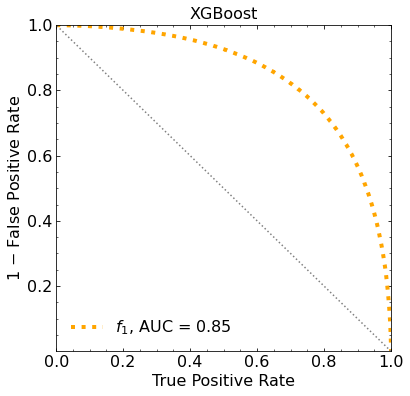

ML iteration  1


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.66997	validation_1-logloss:0.67073
[1]	validation_0-logloss:0.65014	validation_1-logloss:0.65186
[2]	validation_0-logloss:0.63296	validation_1-logloss:0.63532
[3]	validation_0-logloss:0.61805	validation_1-logloss:0.62091
[4]	validation_0-logloss:0.60489	validation_1-logloss:0.60836
[5]	validation_0-logloss:0.59323	validation_1-logloss:0.59728
[6]	validation_0-logloss:0.58279	validation_1-logloss:0.58731
[7]	validation_0-logloss:0.57353	validation_1-logloss:0.57851
[8]	validation_0-logloss:0.56527	validation_1-logloss:0.57082
[9]	validation_0-logloss:0.55772	validation_1-logloss:0.56373
[10]	validation_0-logloss:0.55094	validation_1-logloss:0.55744
[11]	validation_0-logloss:0.54475	validation_1-logloss:0.55176
[12]	validation_0-logloss:0.53913	validation_1-logloss:0.54654
[13]	validation_0-logloss:0.53395	validation_1-logloss:0.54178
[14]	validation_0-logloss:0.52927	validation_1-logloss:0.53744
[15]	validation_0-logloss:0.52492	validation_1-logloss:0.53349
[1

[130]	validation_0-logloss:0.45861	validation_1-logloss:0.48427
[131]	validation_0-logloss:0.45851	validation_1-logloss:0.48428
[132]	validation_0-logloss:0.45842	validation_1-logloss:0.48428
[133]	validation_0-logloss:0.45832	validation_1-logloss:0.48428
[134]	validation_0-logloss:0.45828	validation_1-logloss:0.48429
[135]	validation_0-logloss:0.45820	validation_1-logloss:0.48429
[136]	validation_0-logloss:0.45809	validation_1-logloss:0.48430
[137]	validation_0-logloss:0.45796	validation_1-logloss:0.48430
[138]	validation_0-logloss:0.45792	validation_1-logloss:0.48430
[139]	validation_0-logloss:0.45781	validation_1-logloss:0.48431
[140]	validation_0-logloss:0.45778	validation_1-logloss:0.48431
[141]	validation_0-logloss:0.45772	validation_1-logloss:0.48431
[142]	validation_0-logloss:0.45767	validation_1-logloss:0.48431
[143]	validation_0-logloss:0.45759	validation_1-logloss:0.48433
[144]	validation_0-logloss:0.45755	validation_1-logloss:0.48433
[145]	validation_0-logloss:0.45753	valid

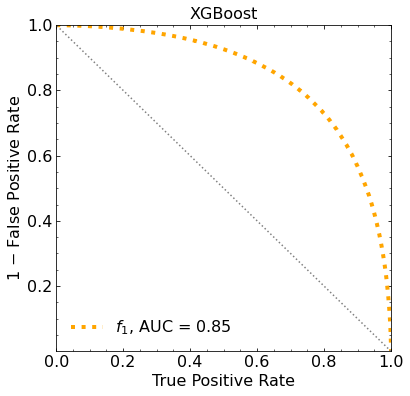

ML iteration  2


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.67020	validation_1-logloss:0.67082
[1]	validation_0-logloss:0.65047	validation_1-logloss:0.65169
[2]	validation_0-logloss:0.63349	validation_1-logloss:0.63544
[3]	validation_0-logloss:0.61871	validation_1-logloss:0.62117
[4]	validation_0-logloss:0.60571	validation_1-logloss:0.60860
[5]	validation_0-logloss:0.59420	validation_1-logloss:0.59752
[6]	validation_0-logloss:0.58383	validation_1-logloss:0.58765
[7]	validation_0-logloss:0.57454	validation_1-logloss:0.57879
[8]	validation_0-logloss:0.56633	validation_1-logloss:0.57095
[9]	validation_0-logloss:0.55885	validation_1-logloss:0.56398
[10]	validation_0-logloss:0.55209	validation_1-logloss:0.55768
[11]	validation_0-logloss:0.54600	validation_1-logloss:0.55196
[12]	validation_0-logloss:0.54045	validation_1-logloss:0.54678
[13]	validation_0-logloss:0.53532	validation_1-logloss:0.54207
[14]	validation_0-logloss:0.53070	validation_1-logloss:0.53780
[15]	validation_0-logloss:0.52645	validation_1-logloss:0.53388
[1

[130]	validation_0-logloss:0.46101	validation_1-logloss:0.48428
[131]	validation_0-logloss:0.46090	validation_1-logloss:0.48428
[132]	validation_0-logloss:0.46087	validation_1-logloss:0.48429
[133]	validation_0-logloss:0.46081	validation_1-logloss:0.48429
[134]	validation_0-logloss:0.46068	validation_1-logloss:0.48430
[135]	validation_0-logloss:0.46061	validation_1-logloss:0.48429
[136]	validation_0-logloss:0.46053	validation_1-logloss:0.48430
[137]	validation_0-logloss:0.46050	validation_1-logloss:0.48430
[138]	validation_0-logloss:0.46044	validation_1-logloss:0.48430
[139]	validation_0-logloss:0.46037	validation_1-logloss:0.48431
[140]	validation_0-logloss:0.46032	validation_1-logloss:0.48431
[141]	validation_0-logloss:0.46029	validation_1-logloss:0.48432
[142]	validation_0-logloss:0.46020	validation_1-logloss:0.48432
[143]	validation_0-logloss:0.46013	validation_1-logloss:0.48432
[144]	validation_0-logloss:0.46011	validation_1-logloss:0.48432
[145]	validation_0-logloss:0.46002	valid

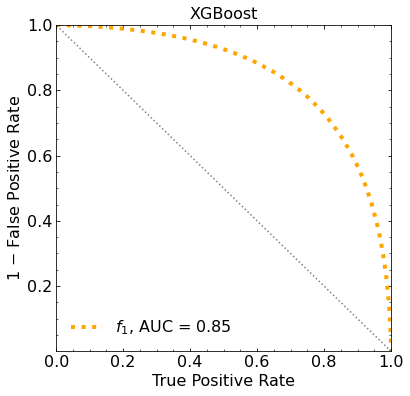

ML iteration  3


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.66992	validation_1-logloss:0.67070
[1]	validation_0-logloss:0.65018	validation_1-logloss:0.65160
[2]	validation_0-logloss:0.63314	validation_1-logloss:0.63519
[3]	validation_0-logloss:0.61811	validation_1-logloss:0.62090
[4]	validation_0-logloss:0.60490	validation_1-logloss:0.60821
[5]	validation_0-logloss:0.59323	validation_1-logloss:0.59706
[6]	validation_0-logloss:0.58285	validation_1-logloss:0.58717
[7]	validation_0-logloss:0.57352	validation_1-logloss:0.57835
[8]	validation_0-logloss:0.56518	validation_1-logloss:0.57052
[9]	validation_0-logloss:0.55772	validation_1-logloss:0.56355
[10]	validation_0-logloss:0.55084	validation_1-logloss:0.55717
[11]	validation_0-logloss:0.54468	validation_1-logloss:0.55141
[12]	validation_0-logloss:0.53908	validation_1-logloss:0.54622
[13]	validation_0-logloss:0.53398	validation_1-logloss:0.54159
[14]	validation_0-logloss:0.52926	validation_1-logloss:0.53724
[15]	validation_0-logloss:0.52496	validation_1-logloss:0.53335
[1

[130]	validation_0-logloss:0.45832	validation_1-logloss:0.48435
[131]	validation_0-logloss:0.45822	validation_1-logloss:0.48435
[132]	validation_0-logloss:0.45817	validation_1-logloss:0.48436
[133]	validation_0-logloss:0.45810	validation_1-logloss:0.48437
[134]	validation_0-logloss:0.45801	validation_1-logloss:0.48439
[135]	validation_0-logloss:0.45792	validation_1-logloss:0.48439
[136]	validation_0-logloss:0.45779	validation_1-logloss:0.48440
[137]	validation_0-logloss:0.45771	validation_1-logloss:0.48440
[138]	validation_0-logloss:0.45763	validation_1-logloss:0.48441
[139]	validation_0-logloss:0.45754	validation_1-logloss:0.48442
[140]	validation_0-logloss:0.45751	validation_1-logloss:0.48442
[141]	validation_0-logloss:0.45741	validation_1-logloss:0.48443
[142]	validation_0-logloss:0.45733	validation_1-logloss:0.48443
[143]	validation_0-logloss:0.45724	validation_1-logloss:0.48444
[144]	validation_0-logloss:0.45713	validation_1-logloss:0.48446
[145]	validation_0-logloss:0.45710	valid

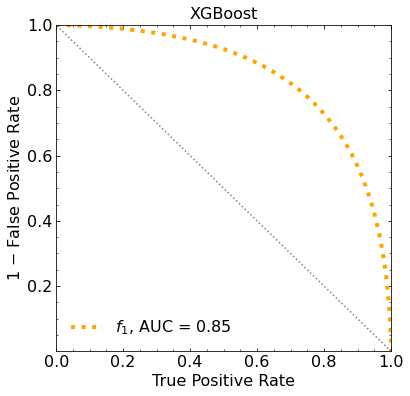

ML iteration  4


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.66992	validation_1-logloss:0.67068
[1]	validation_0-logloss:0.65015	validation_1-logloss:0.65167
[2]	validation_0-logloss:0.63291	validation_1-logloss:0.63511
[3]	validation_0-logloss:0.61792	validation_1-logloss:0.62078
[4]	validation_0-logloss:0.60469	validation_1-logloss:0.60812
[5]	validation_0-logloss:0.59302	validation_1-logloss:0.59707
[6]	validation_0-logloss:0.58264	validation_1-logloss:0.58714
[7]	validation_0-logloss:0.57325	validation_1-logloss:0.57829
[8]	validation_0-logloss:0.56493	validation_1-logloss:0.57056
[9]	validation_0-logloss:0.55742	validation_1-logloss:0.56356
[10]	validation_0-logloss:0.55058	validation_1-logloss:0.55719
[11]	validation_0-logloss:0.54448	validation_1-logloss:0.55153
[12]	validation_0-logloss:0.53890	validation_1-logloss:0.54635
[13]	validation_0-logloss:0.53379	validation_1-logloss:0.54159
[14]	validation_0-logloss:0.52913	validation_1-logloss:0.53731
[15]	validation_0-logloss:0.52473	validation_1-logloss:0.53331
[1

[130]	validation_0-logloss:0.45729	validation_1-logloss:0.48429
[131]	validation_0-logloss:0.45724	validation_1-logloss:0.48429
[132]	validation_0-logloss:0.45718	validation_1-logloss:0.48429
[133]	validation_0-logloss:0.45709	validation_1-logloss:0.48429
[134]	validation_0-logloss:0.45697	validation_1-logloss:0.48430
[135]	validation_0-logloss:0.45690	validation_1-logloss:0.48430
[136]	validation_0-logloss:0.45688	validation_1-logloss:0.48430
[137]	validation_0-logloss:0.45682	validation_1-logloss:0.48430
[138]	validation_0-logloss:0.45680	validation_1-logloss:0.48431
[139]	validation_0-logloss:0.45670	validation_1-logloss:0.48432
[140]	validation_0-logloss:0.45660	validation_1-logloss:0.48433
[141]	validation_0-logloss:0.45656	validation_1-logloss:0.48434
[142]	validation_0-logloss:0.45648	validation_1-logloss:0.48435
[143]	validation_0-logloss:0.45639	validation_1-logloss:0.48436
[144]	validation_0-logloss:0.45626	validation_1-logloss:0.48437


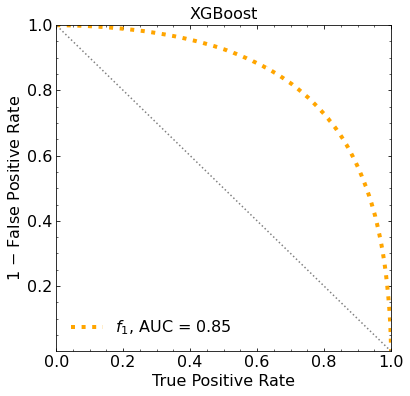

ML iteration  5


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.67015	validation_1-logloss:0.67097
[1]	validation_0-logloss:0.65056	validation_1-logloss:0.65181
[2]	validation_0-logloss:0.63348	validation_1-logloss:0.63537
[3]	validation_0-logloss:0.61872	validation_1-logloss:0.62113
[4]	validation_0-logloss:0.60553	validation_1-logloss:0.60850
[5]	validation_0-logloss:0.59388	validation_1-logloss:0.59739
[6]	validation_0-logloss:0.58370	validation_1-logloss:0.58759
[7]	validation_0-logloss:0.57447	validation_1-logloss:0.57882
[8]	validation_0-logloss:0.56612	validation_1-logloss:0.57097
[9]	validation_0-logloss:0.55866	validation_1-logloss:0.56394
[10]	validation_0-logloss:0.55195	validation_1-logloss:0.55765
[11]	validation_0-logloss:0.54579	validation_1-logloss:0.55193
[12]	validation_0-logloss:0.54029	validation_1-logloss:0.54674
[13]	validation_0-logloss:0.53522	validation_1-logloss:0.54203
[14]	validation_0-logloss:0.53058	validation_1-logloss:0.53772
[15]	validation_0-logloss:0.52633	validation_1-logloss:0.53381
[1

[130]	validation_0-logloss:0.46003	validation_1-logloss:0.48424
[131]	validation_0-logloss:0.45997	validation_1-logloss:0.48424
[132]	validation_0-logloss:0.45987	validation_1-logloss:0.48424
[133]	validation_0-logloss:0.45982	validation_1-logloss:0.48425
[134]	validation_0-logloss:0.45981	validation_1-logloss:0.48425
[135]	validation_0-logloss:0.45978	validation_1-logloss:0.48425
[136]	validation_0-logloss:0.45975	validation_1-logloss:0.48425
[137]	validation_0-logloss:0.45968	validation_1-logloss:0.48426
[138]	validation_0-logloss:0.45956	validation_1-logloss:0.48426
[139]	validation_0-logloss:0.45944	validation_1-logloss:0.48427
[140]	validation_0-logloss:0.45942	validation_1-logloss:0.48428
[141]	validation_0-logloss:0.45938	validation_1-logloss:0.48428
[142]	validation_0-logloss:0.45935	validation_1-logloss:0.48429
[143]	validation_0-logloss:0.45925	validation_1-logloss:0.48429
[144]	validation_0-logloss:0.45921	validation_1-logloss:0.48429
[145]	validation_0-logloss:0.45920	valid

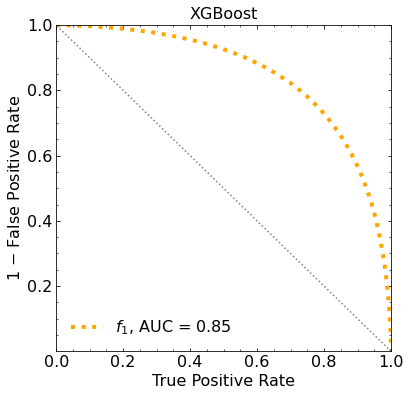

ML iteration  6


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.66963	validation_1-logloss:0.67059
[1]	validation_0-logloss:0.64958	validation_1-logloss:0.65139
[2]	validation_0-logloss:0.63220	validation_1-logloss:0.63479
[3]	validation_0-logloss:0.61709	validation_1-logloss:0.62041
[4]	validation_0-logloss:0.60380	validation_1-logloss:0.60787
[5]	validation_0-logloss:0.59202	validation_1-logloss:0.59671
[6]	validation_0-logloss:0.58160	validation_1-logloss:0.58691
[7]	validation_0-logloss:0.57213	validation_1-logloss:0.57809
[8]	validation_0-logloss:0.56368	validation_1-logloss:0.57015
[9]	validation_0-logloss:0.55612	validation_1-logloss:0.56318
[10]	validation_0-logloss:0.54918	validation_1-logloss:0.55677
[11]	validation_0-logloss:0.54294	validation_1-logloss:0.55111
[12]	validation_0-logloss:0.53720	validation_1-logloss:0.54589
[13]	validation_0-logloss:0.53204	validation_1-logloss:0.54116
[14]	validation_0-logloss:0.52731	validation_1-logloss:0.53685
[15]	validation_0-logloss:0.52298	validation_1-logloss:0.53291
[1

[130]	validation_0-logloss:0.45663	validation_1-logloss:0.48395
[131]	validation_0-logloss:0.45649	validation_1-logloss:0.48396
[132]	validation_0-logloss:0.45637	validation_1-logloss:0.48396
[133]	validation_0-logloss:0.45633	validation_1-logloss:0.48396
[134]	validation_0-logloss:0.45628	validation_1-logloss:0.48396
[135]	validation_0-logloss:0.45617	validation_1-logloss:0.48397
[136]	validation_0-logloss:0.45614	validation_1-logloss:0.48398
[137]	validation_0-logloss:0.45604	validation_1-logloss:0.48398
[138]	validation_0-logloss:0.45599	validation_1-logloss:0.48399
[139]	validation_0-logloss:0.45593	validation_1-logloss:0.48399
[140]	validation_0-logloss:0.45590	validation_1-logloss:0.48400
[141]	validation_0-logloss:0.45583	validation_1-logloss:0.48400
[142]	validation_0-logloss:0.45575	validation_1-logloss:0.48400
[143]	validation_0-logloss:0.45571	validation_1-logloss:0.48401
[144]	validation_0-logloss:0.45562	validation_1-logloss:0.48401
[145]	validation_0-logloss:0.45556	valid

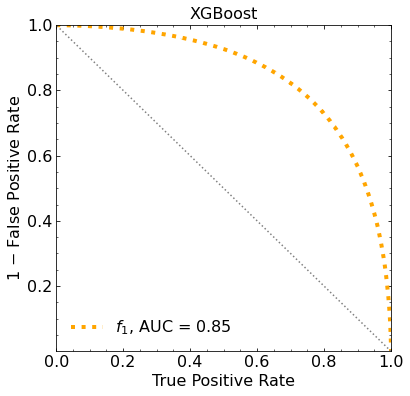

ML iteration  7


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.66965	validation_1-logloss:0.67063
[1]	validation_0-logloss:0.64960	validation_1-logloss:0.65149
[2]	validation_0-logloss:0.63242	validation_1-logloss:0.63510
[3]	validation_0-logloss:0.61729	validation_1-logloss:0.62060
[4]	validation_0-logloss:0.60419	validation_1-logloss:0.60799
[5]	validation_0-logloss:0.59252	validation_1-logloss:0.59695
[6]	validation_0-logloss:0.58213	validation_1-logloss:0.58706
[7]	validation_0-logloss:0.57295	validation_1-logloss:0.57835
[8]	validation_0-logloss:0.56457	validation_1-logloss:0.57057
[9]	validation_0-logloss:0.55713	validation_1-logloss:0.56351
[10]	validation_0-logloss:0.55039	validation_1-logloss:0.55725
[11]	validation_0-logloss:0.54429	validation_1-logloss:0.55163
[12]	validation_0-logloss:0.53871	validation_1-logloss:0.54641
[13]	validation_0-logloss:0.53369	validation_1-logloss:0.54169
[14]	validation_0-logloss:0.52897	validation_1-logloss:0.53737
[15]	validation_0-logloss:0.52474	validation_1-logloss:0.53347
[1

[130]	validation_0-logloss:0.46025	validation_1-logloss:0.48445
[131]	validation_0-logloss:0.46021	validation_1-logloss:0.48445
[132]	validation_0-logloss:0.46015	validation_1-logloss:0.48445
[133]	validation_0-logloss:0.46004	validation_1-logloss:0.48445
[134]	validation_0-logloss:0.45989	validation_1-logloss:0.48446
[135]	validation_0-logloss:0.45984	validation_1-logloss:0.48447
[136]	validation_0-logloss:0.45980	validation_1-logloss:0.48447
[137]	validation_0-logloss:0.45977	validation_1-logloss:0.48447
[138]	validation_0-logloss:0.45974	validation_1-logloss:0.48448
[139]	validation_0-logloss:0.45972	validation_1-logloss:0.48448
[140]	validation_0-logloss:0.45969	validation_1-logloss:0.48447
[141]	validation_0-logloss:0.45964	validation_1-logloss:0.48448
[142]	validation_0-logloss:0.45956	validation_1-logloss:0.48448
[143]	validation_0-logloss:0.45950	validation_1-logloss:0.48449
[144]	validation_0-logloss:0.45946	validation_1-logloss:0.48450
[145]	validation_0-logloss:0.45936	valid

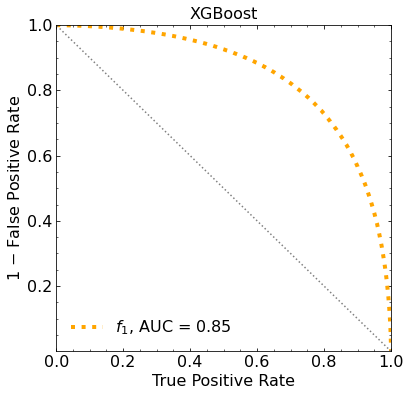

ML iteration  8


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.66951	validation_1-logloss:0.67062
[1]	validation_0-logloss:0.64927	validation_1-logloss:0.65131
[2]	validation_0-logloss:0.63173	validation_1-logloss:0.63475
[3]	validation_0-logloss:0.61642	validation_1-logloss:0.62020
[4]	validation_0-logloss:0.60284	validation_1-logloss:0.60740
[5]	validation_0-logloss:0.59099	validation_1-logloss:0.59624
[6]	validation_0-logloss:0.58047	validation_1-logloss:0.58635
[7]	validation_0-logloss:0.57113	validation_1-logloss:0.57763
[8]	validation_0-logloss:0.56275	validation_1-logloss:0.56984
[9]	validation_0-logloss:0.55500	validation_1-logloss:0.56275
[10]	validation_0-logloss:0.54809	validation_1-logloss:0.55639
[11]	validation_0-logloss:0.54194	validation_1-logloss:0.55072
[12]	validation_0-logloss:0.53632	validation_1-logloss:0.54556
[13]	validation_0-logloss:0.53117	validation_1-logloss:0.54079
[14]	validation_0-logloss:0.52650	validation_1-logloss:0.53658
[15]	validation_0-logloss:0.52217	validation_1-logloss:0.53265
[1

[130]	validation_0-logloss:0.45616	validation_1-logloss:0.48413
[131]	validation_0-logloss:0.45607	validation_1-logloss:0.48414
[132]	validation_0-logloss:0.45598	validation_1-logloss:0.48416
[133]	validation_0-logloss:0.45588	validation_1-logloss:0.48417
[134]	validation_0-logloss:0.45583	validation_1-logloss:0.48417
[135]	validation_0-logloss:0.45581	validation_1-logloss:0.48417
[136]	validation_0-logloss:0.45580	validation_1-logloss:0.48418
[137]	validation_0-logloss:0.45570	validation_1-logloss:0.48419
[138]	validation_0-logloss:0.45566	validation_1-logloss:0.48418
[139]	validation_0-logloss:0.45557	validation_1-logloss:0.48419
[140]	validation_0-logloss:0.45542	validation_1-logloss:0.48419
[141]	validation_0-logloss:0.45533	validation_1-logloss:0.48420
[142]	validation_0-logloss:0.45528	validation_1-logloss:0.48420
[143]	validation_0-logloss:0.45523	validation_1-logloss:0.48422
[144]	validation_0-logloss:0.45520	validation_1-logloss:0.48422
[145]	validation_0-logloss:0.45513	valid

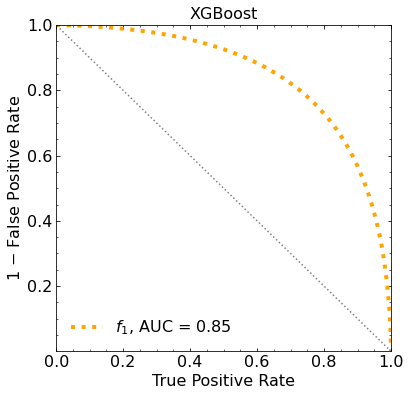

ML iteration  9


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.66980	validation_1-logloss:0.67066
[1]	validation_0-logloss:0.64990	validation_1-logloss:0.65154
[2]	validation_0-logloss:0.63269	validation_1-logloss:0.63509
[3]	validation_0-logloss:0.61764	validation_1-logloss:0.62061
[4]	validation_0-logloss:0.60451	validation_1-logloss:0.60803
[5]	validation_0-logloss:0.59287	validation_1-logloss:0.59698
[6]	validation_0-logloss:0.58248	validation_1-logloss:0.58716
[7]	validation_0-logloss:0.57306	validation_1-logloss:0.57838
[8]	validation_0-logloss:0.56473	validation_1-logloss:0.57053
[9]	validation_0-logloss:0.55715	validation_1-logloss:0.56346
[10]	validation_0-logloss:0.55023	validation_1-logloss:0.55710
[11]	validation_0-logloss:0.54409	validation_1-logloss:0.55137
[12]	validation_0-logloss:0.53854	validation_1-logloss:0.54618
[13]	validation_0-logloss:0.53350	validation_1-logloss:0.54158
[14]	validation_0-logloss:0.52876	validation_1-logloss:0.53729
[15]	validation_0-logloss:0.52443	validation_1-logloss:0.53333
[1

[130]	validation_0-logloss:0.45847	validation_1-logloss:0.48420
[131]	validation_0-logloss:0.45836	validation_1-logloss:0.48422
[132]	validation_0-logloss:0.45833	validation_1-logloss:0.48422
[133]	validation_0-logloss:0.45822	validation_1-logloss:0.48422
[134]	validation_0-logloss:0.45817	validation_1-logloss:0.48423
[135]	validation_0-logloss:0.45803	validation_1-logloss:0.48423
[136]	validation_0-logloss:0.45791	validation_1-logloss:0.48424
[137]	validation_0-logloss:0.45787	validation_1-logloss:0.48424
[138]	validation_0-logloss:0.45777	validation_1-logloss:0.48425
[139]	validation_0-logloss:0.45775	validation_1-logloss:0.48425
[140]	validation_0-logloss:0.45765	validation_1-logloss:0.48426
[141]	validation_0-logloss:0.45761	validation_1-logloss:0.48425
[142]	validation_0-logloss:0.45753	validation_1-logloss:0.48427
[143]	validation_0-logloss:0.45740	validation_1-logloss:0.48428
[144]	validation_0-logloss:0.45730	validation_1-logloss:0.48428
[145]	validation_0-logloss:0.45720	valid

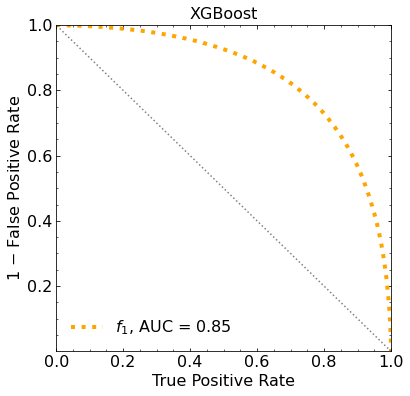

Classification score (1 ML):


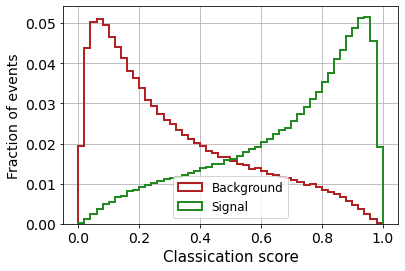

Classification score (10 ML):


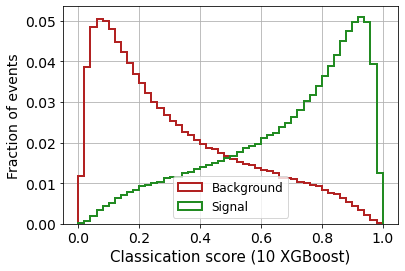

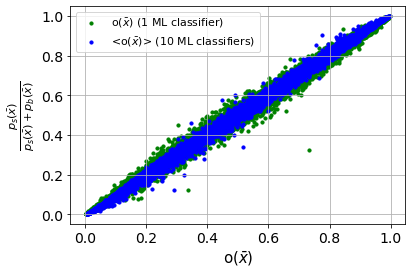


 ----------------------------------------- 

B_expected:  50000
S_expected:  500
S/$\sqrt{B}$:  2.23606797749979
 BINNED CLASSIFIER OUTPUT
  BL lineal bins, 1 ML
Z_XG 10 bins_1ML:  5.1704153512498685
Z_XG 25 bins_1ML:  5.5621327739289095
Z_XG 50 bins_1ML:  5.65027343509079
Z_XG 100 bins_1ML:  5.711426014439749

 BL non-lineal bins, 1 ML
Z_XG 10 bins_eq_1ML:  4.194668380290204
Z_XG 25 bins_eq_1ML:  4.713263097397533
Z_XG 50 bins_eq_1ML:  5.012206197927772
Z_XG 100 bins_eq_1ML:  5.230392686568209

 BL lineal bins, 10 ML
Z_XG 10 bins:  5.232634363914122
Z_XG 25 bins:  5.628817420871836
Z_XG 50 bins:  5.720516203289839
Z_XG 100 bins:  5.678670560417235

 BL non-lineal bins, 10 ML
Z_XG 10 bins_eq:  4.205160368301365
Z_XG 25 bins_eq:  4.734760326749989
Z_XG 50 bins_eq:  5.034351837444014
Z_XG 100 bins_eq:  5.25209294633809

 ----------------------------------------- 


 If  20200  =  1101    then the proposed range has to be extended
n_ensembles (actual):  9863
TRUE PDF LIKELIHOOD (GAUSSIAN

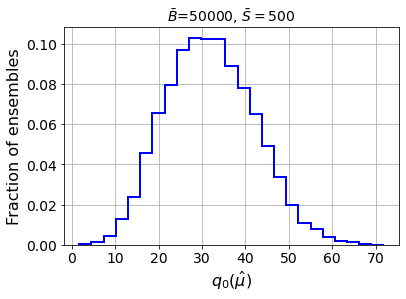

muhat mean:  0.09449457568691068
Z_gaussian:  5.617478777958667
Z_gaussian_mu0:  5.615171031059931

 ------------------------------------ 

 MLL + KDE (1ML) 


/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
   965.65925777   970.41422505   972.45511701   970.87592478
   966.2071131    957.96515204   940.57753799   907.53439981
   849.6283803    754.16123347   605.6184879    381.63729557
    55.78628036  -396.76968732 -1026.09847003 -2004.31269334]
  warnings.warn(
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:929: RuntimeWarning: invalid value encountered in subtract
  array_stds = np.sqrt(np.average((array -
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf   961.81471087
   969.16315065   972.92653838   974.49370797   973.68105679
   968.68634825   958.26819476   937.09630327   898.90367076
   8

KDE Kernel:  epanechnikov
Background bandwidth:  0.0091866653175426
Signal bandwidth:  0.0091866653175426


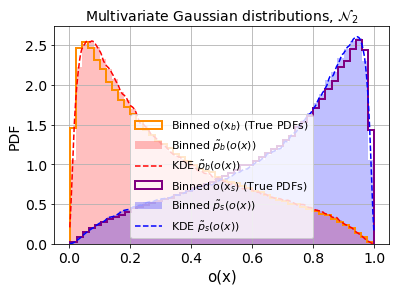

 MLL + KDE (10ML) 


/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf   982.38335762
   990.63442985   995.52501144   997.95481173   997.59876014
   994.77300185   987.70314612   971.96887086   942.06736793
   886.87165437   794.12276254   648.298228     425.64269958
   101.12614253  -354.35026657  -995.02464391 -1990.89847637]
  warnings.warn(
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:929: RuntimeWarning: invalid value encountered in subtract
  array_stds = np.sqrt(np.average((array -
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
   989.52704846   994.5216519    995.4309541    995.2666981
   992.85260709   984.5707121    966.6113666    932.32227477
   87

KDE Kernel:  epanechnikov
Background bandwidth:  0.0091866653175426
Signal bandwidth:  0.0091866653175426


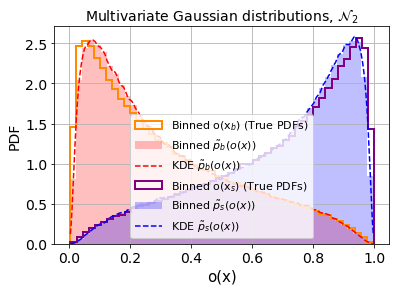

 Z MLL+KDE (1ML) 


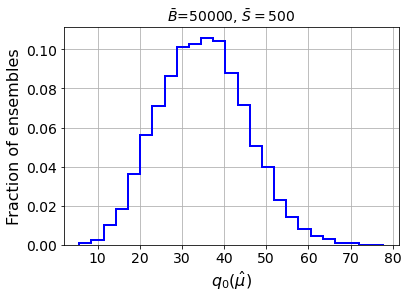

muhat mean_1ML:  0.05575382743587145
Z_KDE_1ML:  5.907676420716397
Z_KDE mu=0_1ML:  5.907676420716397

 Z MLL+KDE (10ML) 


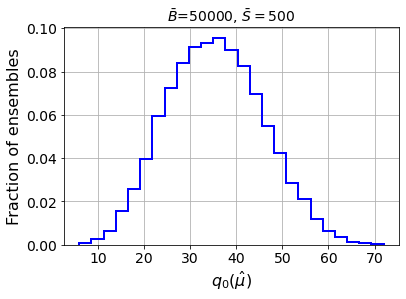

muhat mean:  0.0556879245665619
Z_KDE:  5.939953278097014
Z_KDE mu=0:  5.939953278097014

 ------------------------------------ 



In [122]:
dim=6

#######################
# generate the events #
#######################
    
mean_sig = epsilon*np.ones(dim)
mean_bkg = -1*mean_sig

#cov_sig = np.identity(dim)
cov_sig = np.identity(dim) + (0. * ( np.ones((dim,dim)) - np.identity(dim) ))
cov_bkg = cov_sig

signal_X_1, signal_X_2, signal_X_3, signal_X_4, signal_X_5, signal_X_6 = np.random.multivariate_normal(mean_sig, cov_sig, N).T
background_X_1, background_X_2, background_X_3, background_X_4, background_X_5, background_X_6 = np.random.multivariate_normal(mean_bkg, cov_bkg, N).T


dim1 = np.concatenate((background_X_1,signal_X_1))
dim2 = np.concatenate((background_X_2,signal_X_2))
dim3 = np.concatenate((background_X_3,signal_X_3))
dim4 = np.concatenate((background_X_4,signal_X_4))
dim5 = np.concatenate((background_X_5,signal_X_5))
dim6 = np.concatenate((background_X_6,signal_X_6))

# labels
background_Y = np.zeros(N)
signal_Y = np.ones(N)

# DATA in a single matrix (features + labels)
df = pd.DataFrame()
df['dim1'] = dim1.reshape(-1)
df['dim2'] = dim2.reshape(-1)
df['dim3'] = dim3.reshape(-1)
df['dim4'] = dim4.reshape(-1)
df['dim5'] = dim5.reshape(-1)
df['dim6'] = dim6.reshape(-1)
df['Y'] = np.concatenate((background_Y.astype('int'),signal_Y.astype('int')))

X_gauss = df[['dim1','dim2','dim3','dim4','dim5','dim6']].values 
Y_gauss = df[['Y']].values

# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.5

X_gauss_aux, X_gauss_test, Y_gauss_aux, Y_gauss_test = train_test_split(X_gauss,
                                                                Y_gauss,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_gauss,
                                                                shuffle=True)


X_gauss_train, X_gauss_val, Y_gauss_train, Y_gauss_val = train_test_split(X_gauss_aux,
                                                                  Y_gauss_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_gauss_aux,
                                                                  shuffle=True)

print('')
print('X_gauss_train : ', X_gauss_train.shape)
print('y_gauss_train : ', Y_gauss_train.shape)
print('X_gauss_val : ', X_gauss_val.shape)
print('y_gauss_val : ', Y_gauss_val.shape)
print('X_gauss_test : ', X_gauss_test.shape)
print('y_gauss_test : ', Y_gauss_test.shape)
print('')


# PLOT (only 1st feature) to visualize the data
X_gauss_test_SM = []
X_gauss_test_NP = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] ==0:
        X_gauss_test_SM.append(X_gauss_test[i].tolist())
    else:
        X_gauss_test_NP.append(X_gauss_test[i].tolist())    


X_gauss_test_SM = np.array(X_gauss_test_SM)
X_gauss_test_NP = np.array(X_gauss_test_NP)


weights = np.ones_like(X_gauss_test_SM[:,0])/float(len(X_gauss_test_SM[:,0]))
plt.hist(X_gauss_test_SM[:,0], 20, histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(X_gauss_test_NP[:,0])/float(len(X_gauss_test_NP[:,0]))
plt.hist(X_gauss_test_NP[:,0], 20, histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$x_1$",fontsize=16)
plt.ylabel("Fraction of events",fontsize=16)
plt.grid()
plt.legend(fontsize=14)
plt.title(r"Gaussian (dim=%0.2d)" % dim,fontsize=14)
plt.show()  






################################
# the true pdfs (useful later) #
################################

sig_multi = multivariate_normal(mean_sig, cov_sig)
bkg_multi = multivariate_normal(mean_bkg, cov_bkg) 




#######################
# CLASSIFIER: XGBoost #
#######################

# only 1 ML
roc_auc_XG, y_pred_xg_1ML = XG(X_gauss_train, X_gauss_test, X_gauss_val, Y_gauss_train, Y_gauss_test, Y_gauss_val)

store_AUC.append(roc_auc_XG)


# Bagging

print('ML iteration 0')
roc_auc_XG, y_pred_xg_aux = XG(X_gauss_train[:100000], X_gauss_test, X_gauss_val, Y_gauss_train[:100000], Y_gauss_test, Y_gauss_val)
y_pred_xg_auxRE = np.reshape(y_pred_xg_aux, (1,len(y_pred_xg_aux)))

for it in range(1,iterations_ML):

    print('ML iteration ', it)
    roc_auc_XG, y_pred_xg_aux_it = XG(X_gauss_train[(100000*it):(100000*it)+100000], X_gauss_test, X_gauss_val, Y_gauss_train[(100000*it):(100000*it)+100000], Y_gauss_test, Y_gauss_val)
    
    y_pred_xg_auxRE_it = np.reshape(y_pred_xg_aux_it, (1,len(y_pred_xg_aux_it)))
    
    y_pred_xg_auxRE = np.concatenate([y_pred_xg_auxRE,y_pred_xg_auxRE_it])

# to smooth, mean of 10 predictions
y_pred_xg = np.mean(y_pred_xg_auxRE, axis=0)




########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

# 1 ML
pred_XG_SM_1ML = []
pred_XG_NP_1ML = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] == 0:
        pred_XG_SM_1ML.append(y_pred_xg_1ML[i])
    else:
        pred_XG_NP_1ML.append(y_pred_xg_1ML[i])
        
# Bagging  
pred_XG_SM = []
pred_XG_NP = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score (1 ML):')
        
weights = np.ones_like(pred_XG_SM_1ML)/float(len(pred_XG_SM_1ML))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM_1ML, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP_1ML)/float(len(pred_XG_NP_1ML))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP_1ML, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12, loc="lower center")
plt.show()


print('Classification score (10 ML):')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (10 XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12, loc="lower center")
plt.show()




ratio_ps_pb_true = sig_multi.pdf(X_gauss_test) / ( sig_multi.pdf(X_gauss_test) + bkg_multi.pdf(X_gauss_test) )
ratio_ps_pb_true_B = sig_multi.pdf(X_gauss_test_SM) / ( sig_multi.pdf(X_gauss_test_SM) + bkg_multi.pdf(X_gauss_test_SM) )
ratio_ps_pb_true_S = sig_multi.pdf(X_gauss_test_NP) / ( sig_multi.pdf(X_gauss_test_NP) + bkg_multi.pdf(X_gauss_test_NP) )

plt.scatter(y_pred_xg_1ML[:10000], ratio_ps_pb_true[:10000], color='green', label=r'o($\bar{x}$) (1 ML classifier)', s=10)
plt.scatter(y_pred_xg[:10000], ratio_ps_pb_true[:10000], color='blue', label=r'<o($\bar{x}$)> (10 ML classifiers)', s=10)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r"o($\bar{x}$)",fontsize=15)
plt.ylabel(r"$\frac{p_s(\bar{x})}{p_s(\bar{x})+p_b(\bar{x})}$",fontsize=16)
plt.grid()
plt.legend(fontsize=11)
#plt.savefig('images/' + 'optimalclass-vs-ox.pdf', format="pdf", bbox_inches="tight")
plt.show()

print('\n ----------------------------------------- \n')






###########
# METHODS #
###########

print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)



############################
# BINNED CLASSIFIER OUTPUT #
############################

print(' BINNED CLASSIFIER OUTPUT')

print('  BL lineal bins, 1 ML')

# 10 BINS
Z_bins_XG_10bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 10, [[0,1]], linear_bins=True)
store_Z_bins_XG_10bins_1ML.append(Z_bins_XG_10bins_1ML)
print('Z_XG 10 bins_1ML: ', Z_bins_XG_10bins_1ML)

# 25 BINS
Z_bins_XG_25bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 25, [[0,1]], linear_bins=True)
store_Z_bins_XG_25bins_1ML.append(Z_bins_XG_25bins_1ML)
print('Z_XG 25 bins_1ML: ', Z_bins_XG_25bins_1ML)

# 50 BINS
Z_bins_XG_50bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 50, [[0,1]], linear_bins=True)
store_Z_bins_XG_50bins_1ML.append(Z_bins_XG_50bins_1ML)
print('Z_XG 50 bins_1ML: ', Z_bins_XG_50bins_1ML)

# 100 BINS
Z_bins_XG_100bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 100, [[0,1]], linear_bins=True)
store_Z_bins_XG_100bins_1ML.append(Z_bins_XG_100bins_1ML)
print('Z_XG 100 bins_1ML: ', Z_bins_XG_100bins_1ML)


print('\n BL non-lineal bins, 1 ML')

# 10 BINS
Z_bins_XG_10bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 10, [[0,1]], linear_bins=False)
store_Z_bins_XG_10bins_eq_1ML.append(Z_bins_XG_10bins_eq_1ML)
print('Z_XG 10 bins_eq_1ML: ', Z_bins_XG_10bins_eq_1ML)

# 25 BINS
Z_bins_XG_25bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 25, [[0,1]], linear_bins=False)
store_Z_bins_XG_25bins_eq_1ML.append(Z_bins_XG_25bins_eq_1ML)
print('Z_XG 25 bins_eq_1ML: ', Z_bins_XG_25bins_eq_1ML)

# 50 BINS
Z_bins_XG_50bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 50, [[0,1]], linear_bins=False)
store_Z_bins_XG_50bins_eq_1ML.append(Z_bins_XG_50bins_eq_1ML)
print('Z_XG 50 bins_eq_1ML: ', Z_bins_XG_50bins_eq_1ML)

# 100 BINS
Z_bins_XG_100bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 100, [[0,1]], linear_bins=False)
store_Z_bins_XG_100bins_eq_1ML.append(Z_bins_XG_100bins_eq_1ML)
print('Z_XG 100 bins_eq_1ML: ', Z_bins_XG_100bins_eq_1ML)


print('\n BL lineal bins, 10 ML')

# 10 BINS
Z_bins_XG_10bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 10, [[0,1]], linear_bins=True)
store_Z_bins_XG_10bins.append(Z_bins_XG_10bins)
print('Z_XG 10 bins: ', Z_bins_XG_10bins)

# 25 BINS
Z_bins_XG_25bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 25, [[0,1]], linear_bins=True)
store_Z_bins_XG_25bins.append(Z_bins_XG_25bins)
print('Z_XG 25 bins: ', Z_bins_XG_25bins)

# 50 BINS
Z_bins_XG_50bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 50, [[0,1]], linear_bins=True)
store_Z_bins_XG_50bins.append(Z_bins_XG_50bins)
print('Z_XG 50 bins: ', Z_bins_XG_50bins)

# 100 BINS
Z_bins_XG_100bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 100, [[0,1]], linear_bins=True)
store_Z_bins_XG_100bins.append(Z_bins_XG_100bins)
print('Z_XG 100 bins: ', Z_bins_XG_100bins)


print('\n BL non-lineal bins, 10 ML')

# 10 BINS
Z_bins_XG_10bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 10, [[0,1]], linear_bins=False)
store_Z_bins_XG_10bins_eq.append(Z_bins_XG_10bins_eq)
print('Z_XG 10 bins_eq: ', Z_bins_XG_10bins_eq)

# 25 BINS
Z_bins_XG_25bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 25, [[0,1]], linear_bins=False)
store_Z_bins_XG_25bins_eq.append(Z_bins_XG_25bins_eq)
print('Z_XG 25 bins_eq: ', Z_bins_XG_25bins_eq)

# 50 BINS
Z_bins_XG_50bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 50, [[0,1]], linear_bins=False)
store_Z_bins_XG_50bins_eq.append(Z_bins_XG_50bins_eq)
print('Z_XG 50 bins_eq: ', Z_bins_XG_50bins_eq)

# 100 BINS
Z_bins_XG_100bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 100, [[0,1]], linear_bins=False)
store_Z_bins_XG_100bins_eq.append(Z_bins_XG_100bins_eq)
print('Z_XG 100 bins_eq: ', Z_bins_XG_100bins_eq)


print('\n ----------------------------------------- \n')






###########################
# SET THE TOY EXPERIMENTS #
###########################

list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles = ensembler(B_expected, S_expected, n_ensembles)






###################################
# TRUE PDF LIKELIHOOD (GAUSSIANS) #
###################################

indices = [i for i in range(len(X_gauss_test_SM))]

prob_B_given_B = bkg_multi.pdf(X_gauss_test_SM)
prob_B_given_S = sig_multi.pdf(X_gauss_test_SM)



print('TRUE PDF LIKELIHOOD (GAUSSIANS):')

print('n_ensembles (initial): ', n_ensembles)

Z_gaussian, muhat_mean_gaussian, Z_gaussian_mu0, muhat_selected_list, q_muhat, q_muhat_mu0 = Z_MLL(B_expected, S_expected, prob_B_given_B, prob_B_given_S, list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles)

# Histogram of q_muhats

weights = np.ones_like(q_muhat)/float(len(q_muhat))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()

store_muhat_mean_gaussian.append(muhat_mean_gaussian)
store_Z_gaussian.append(Z_gaussian)

store_Z_gaussian_mu0.append(Z_gaussian_mu0)

print('muhat mean: ', muhat_mean_gaussian)
print('Z_gaussian: ', Z_gaussian)
print('Z_gaussian_mu0: ', Z_gaussian_mu0)


print('\n ------------------------------------ \n')







#########
#  KDE  #
#########  

print(' MLL + KDE (1ML) ')

kde_bkg_1ML, kde_sig_1ML, B_bandwidth_1ML, S_bandwidth_1ML = KDE_finder(pred_XG_SM_1ML, pred_XG_NP_1ML)


# range (~between 0 and 1)
min_val_1ML = np.min([np.min(pred_XG_SM_1ML),np.min(pred_XG_NP_1ML)])
max_val_1ML = np.max([np.max(pred_XG_SM_1ML),np.max(pred_XG_NP_1ML)])

s_vals_1ML = np.linspace(min_val_1ML,max_val_1ML,1000)



# evaluate the densities for each value of s (~bins)
dens_bkg_1ML = np.exp(kde_bkg_1ML.score_samples(np.c_[s_vals_1ML, np.zeros(len(s_vals_1ML)) ]) )
dens_sig_1ML = np.exp(kde_sig_1ML.score_samples(np.c_[s_vals_1ML, np.ones(len(s_vals_1ML)) ]) )



# Normalize to 1
# Area
factor_aux_SM_1ML = sum(dens_bkg_1ML*(s_vals_1ML[1]-s_vals_1ML[0]))
factor_aux_NP_1ML = sum(dens_sig_1ML*(s_vals_1ML[1]-s_vals_1ML[0]))

# normalize
dens_bkg_1ML = dens_bkg_1ML / factor_aux_SM_1ML
dens_sig_1ML = dens_sig_1ML / factor_aux_NP_1ML





# plot to check the estimation

plt.figure()

plt.hist(ratio_ps_pb_true_B,density=True,bins=50,lw=2,histtype='step',color='darkorange',alpha=1,label=r'Binned o(x$_b$) (True PDFs)')
plt.hist(pred_XG_SM_1ML,density=True,bins=50,color='red',alpha=0.25,label=r'Binned $\tilde{p}_{b}(o(x))$');
plt.plot(s_vals_1ML,dens_bkg_1ML,color='red',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');

plt.hist(ratio_ps_pb_true_S,density=True,bins=50,lw=2,histtype='step',color='purple',alpha=1,label=r'Binned o(x$_s$) (True PDFs)');
plt.hist(pred_XG_NP_1ML,density=True,bins=50,color='blue',alpha=0.25,label=r'Binned $\tilde{p}_{s}(o(x))$');
plt.plot(s_vals_1ML,dens_sig_1ML,color='blue',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("o(x)",fontsize=15)
plt.ylabel("PDF",fontsize=14)
plt.grid()
plt.legend(loc="lower center", fontsize=11, handlelength=2.5)
plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{2}$', fontsize=14)
#plt.savefig('images/' + '2gaussian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()





print(' MLL + KDE (10ML) ')

kde_bkg, kde_sig, B_bandwidth, S_bandwidth = KDE_finder(pred_XG_SM, pred_XG_NP)


# range (~between 0 and 1)
min_val = np.min([np.min(pred_XG_SM),np.min(pred_XG_NP)])
max_val = np.max([np.max(pred_XG_SM),np.max(pred_XG_NP)])

s_vals = np.linspace(min_val,max_val,1000)



# evaluate the densities for each value of s (~bins)
dens_bkg = np.exp(kde_bkg.score_samples(np.c_[s_vals, np.zeros(len(s_vals)) ]) )
dens_sig = np.exp(kde_sig.score_samples(np.c_[s_vals, np.ones(len(s_vals)) ]) )



# Normalize to 1
# Area
factor_aux_SM = sum(dens_bkg*(s_vals[1]-s_vals[0]))
factor_aux_NP = sum(dens_sig*(s_vals[1]-s_vals[0]))

# normalize
dens_bkg = dens_bkg / factor_aux_SM
dens_sig = dens_sig / factor_aux_NP





# plot to check the estimation

plt.figure()

plt.hist(ratio_ps_pb_true_B,density=True,bins=50,lw=2,histtype='step',color='darkorange',alpha=1,label=r'Binned o(x$_b$) (True PDFs)')
plt.hist(pred_XG_SM,density=True,bins=50,color='red',alpha=0.25,label=r'Binned $\tilde{p}_{b}(o(x))$');
plt.plot(s_vals,dens_bkg,color='red',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');

plt.hist(ratio_ps_pb_true_S,density=True,bins=50,lw=2,histtype='step',color='purple',alpha=1,label=r'Binned o(x$_s$) (True PDFs)');
plt.hist(pred_XG_NP,density=True,bins=50,color='blue',alpha=0.25,label=r'Binned $\tilde{p}_{s}(o(x))$');
plt.plot(s_vals,dens_sig,color='blue',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("o(x)",fontsize=15)
plt.ylabel("PDF",fontsize=14)
plt.grid()
plt.legend(loc="lower center", fontsize=11, handlelength=2.5)
plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{2}$', fontsize=14)
#plt.savefig('images/' + '2gaussian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()






#############
# MLL + KDE #
#############

print(' Z MLL+KDE (1ML) ')
# FOR EXCLUSION:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

KDE_SM_pred_SM_1ML = np.exp(kde_bkg_1ML.score_samples(np.c_[pred_XG_SM_1ML, np.zeros(len(pred_XG_SM_1ML)) ]) )
KDE_NP_pred_SM_1ML = np.exp(kde_sig_1ML.score_samples(np.c_[pred_XG_SM_1ML, np.ones(len(pred_XG_SM_1ML)) ]) )

# Normalize

KDE_SM_pred_SM_1ML = KDE_SM_pred_SM_1ML / factor_aux_SM_1ML
KDE_NP_pred_SM_1ML = KDE_NP_pred_SM_1ML / factor_aux_NP_1ML


indices_1ML = [i for i in range(len(KDE_NP_pred_SM_1ML))]

prob_B_given_B_1ML = KDE_SM_pred_SM_1ML
prob_B_given_S_1ML = KDE_NP_pred_SM_1ML

Z_KDE_1ML, muhat_mean_MLL_KDE_1ML, Z_KDE_mu0_1ML, muhat_selected_list_1ML, q_muhat_1ML, q_muhat_mu0_1ML = Z_MLL(B_expected, S_expected, prob_B_given_B_1ML, prob_B_given_S_1ML, list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles)
    
    
# Histogram of q_muhats

weights = np.ones_like(q_muhat_1ML)/float(len(q_muhat_1ML))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat_1ML, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()


store_muhat_mean_MLL_KDE_1ML.append(muhat_mean_MLL_KDE_1ML)
store_Z_MLL_KDE_1ML.append(Z_KDE_1ML)

store_Z_MLL_KDE_mu0_1ML.append(Z_KDE_mu0_1ML)

print('muhat mean_1ML: ', muhat_mean_MLL_KDE_1ML)
print('Z_KDE_1ML: ', Z_KDE_1ML)
print('Z_KDE mu=0_1ML: ', Z_KDE_mu0_1ML)



print('\n Z MLL+KDE (10ML) ')
# FOR EXCLUSION:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

KDE_SM_pred_SM = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
KDE_NP_pred_SM = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )

# Normalize

KDE_SM_pred_SM = KDE_SM_pred_SM / factor_aux_SM
KDE_NP_pred_SM = KDE_NP_pred_SM / factor_aux_NP


indices = [i for i in range(len(KDE_NP_pred_SM))]

prob_B_given_B = KDE_SM_pred_SM
prob_B_given_S = KDE_NP_pred_SM

Z_KDE, muhat_mean_MLL_KDE, Z_KDE_mu0, muhat_selected_list, q_muhat, q_muhat_mu0 = Z_MLL(B_expected, S_expected, prob_B_given_B, prob_B_given_S, list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles)
    
    
# Histogram of q_muhats

weights = np.ones_like(q_muhat)/float(len(q_muhat))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()


store_muhat_mean_MLL_KDE.append(muhat_mean_MLL_KDE)
store_Z_MLL_KDE.append(Z_KDE)

store_Z_MLL_KDE_mu0.append(Z_KDE_mu0)

print('muhat mean: ', muhat_mean_MLL_KDE)
print('Z_KDE: ', Z_KDE)
print('Z_KDE mu=0: ', Z_KDE_mu0)

print('\n ------------------------------------ \n')

In [ ]:
print(roc_auc_XG)

print(Z_bins_XG_10bins_1ML)
print(Z_bins_XG_25bins_1ML)
print(Z_bins_XG_50bins_1ML)
print(Z_bins_XG_100bins_1ML)

print(Z_bins_XG_10bins_eq_1ML)
print(Z_bins_XG_25bins_eq_1ML)
print(Z_bins_XG_50bins_eq_1ML)
print(Z_bins_XG_100bins_eq_1ML)

print(Z_bins_XG_10bins)
print(Z_bins_XG_25bins)
print(Z_bins_XG_50bins)
print(Z_bins_XG_100bins)

print(Z_bins_XG_10bins_eq)
print(Z_bins_XG_25bins_eq)
print(Z_bins_XG_50bins_eq)
print(Z_bins_XG_100bins_eq)

print(muhat_mean_gaussian)
print(Z_gaussian)
print(Z_gaussian_mu0)

print(muhat_mean_MLL_KDE)
print(Z_KDE)
print(Z_KDE_mu0)

print(muhat_mean_MLL_KDE_1ML)
print(Z_KDE_1ML)
print(Z_KDE_mu0_1ML)

In [ ]:
store_AUC.append()

store_Z_bins_XG_10bins_1ML.append()
store_Z_bins_XG_25bins_1ML.append()
store_Z_bins_XG_50bins_1ML.append()
store_Z_bins_XG_100bins_1ML.append()

store_Z_bins_XG_10bins_eq_1ML.append()
store_Z_bins_XG_25bins_eq_1ML.append()
store_Z_bins_XG_50bins_eq_1ML.append()
store_Z_bins_XG_100bins_eq_1ML.append()

store_Z_bins_XG_10bins.append()
store_Z_bins_XG_25bins.append()
store_Z_bins_XG_50bins.append()
store_Z_bins_XG_100bins.append()

store_Z_bins_XG_10bins_eq.append()
store_Z_bins_XG_25bins_eq.append()
store_Z_bins_XG_50bins_eq.append()
store_Z_bins_XG_100bins_eq.append()

store_muhat_mean_gaussian.append()
store_Z_gaussian.append()
store_Z_gaussian_mu0.append()

store_muhat_mean_MLL_KDE.append()
store_Z_MLL_KDE.append()
store_Z_MLL_KDE_mu0.append()

store_muhat_mean_MLL_KDE_1ML.append()
store_Z_MLL_KDE_1ML.append()
store_Z_MLL_KDE_mu0_1ML.append()


X_gauss_train :  (1000000, 7)
y_gauss_train :  (1000000, 1)
X_gauss_val :  (1000000, 7)
y_gauss_val :  (1000000, 1)
X_gauss_test :  (1000000, 7)
y_gauss_test :  (1000000, 1)



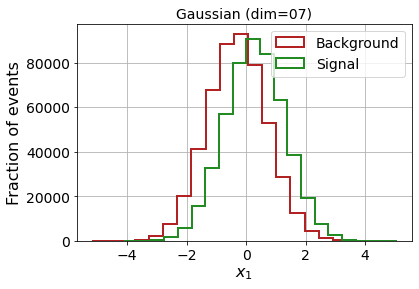

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.67069	validation_1-logloss:0.67093
[1]	validation_0-logloss:0.65121	validation_1-logloss:0.65153
[2]	validation_0-logloss:0.63411	validation_1-logloss:0.63449
[3]	validation_0-logloss:0.61907	validation_1-logloss:0.61951
[4]	validation_0-logloss:0.60567	validation_1-logloss:0.60618
[5]	validation_0-logloss:0.59371	validation_1-logloss:0.59431
[6]	validation_0-logloss:0.58307	validation_1-logloss:0.58378
[7]	validation_0-logloss:0.57336	validation_1-logloss:0.57416
[8]	validation_0-logloss:0.56462	validation_1-logloss:0.56554
[9]	validation_0-logloss:0.55676	validation_1-logloss:0.55774
[10]	validation_0-logloss:0.54957	validation_1-logloss:0.55064
[11]	validation_0-logloss:0.54297	validation_1-logloss:0.54410
[12]	validation_0-logloss:0.53692	validation_1-logloss:0.53814
[13]	validation_0-logloss:0.53137	validation_1-logloss:0.53269
[14]	validation_0-logloss:0.52627	validation_1-logloss:0.52768
[15]	validation_0-logloss:0.52160	validation_1-logloss:0.52308
[1

[130]	validation_0-logloss:0.44921	validation_1-logloss:0.45393
[131]	validation_0-logloss:0.44919	validation_1-logloss:0.45393
[132]	validation_0-logloss:0.44916	validation_1-logloss:0.45392
[133]	validation_0-logloss:0.44913	validation_1-logloss:0.45391
[134]	validation_0-logloss:0.44912	validation_1-logloss:0.45390
[135]	validation_0-logloss:0.44909	validation_1-logloss:0.45390
[136]	validation_0-logloss:0.44907	validation_1-logloss:0.45389
[137]	validation_0-logloss:0.44905	validation_1-logloss:0.45388
[138]	validation_0-logloss:0.44903	validation_1-logloss:0.45388
[139]	validation_0-logloss:0.44901	validation_1-logloss:0.45387
[140]	validation_0-logloss:0.44900	validation_1-logloss:0.45387
[141]	validation_0-logloss:0.44897	validation_1-logloss:0.45386
[142]	validation_0-logloss:0.44896	validation_1-logloss:0.45386
[143]	validation_0-logloss:0.44894	validation_1-logloss:0.45385
[144]	validation_0-logloss:0.44892	validation_1-logloss:0.45385
[145]	validation_0-logloss:0.44890	valid

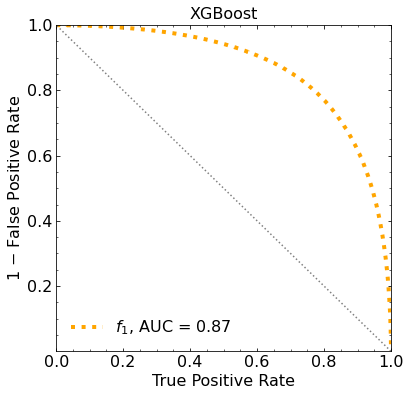

ML iteration 0


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.66948	validation_1-logloss:0.67039
[1]	validation_0-logloss:0.64908	validation_1-logloss:0.65076
[2]	validation_0-logloss:0.63138	validation_1-logloss:0.63372
[3]	validation_0-logloss:0.61562	validation_1-logloss:0.61855
[4]	validation_0-logloss:0.60159	validation_1-logloss:0.60522
[5]	validation_0-logloss:0.58908	validation_1-logloss:0.59333
[6]	validation_0-logloss:0.57772	validation_1-logloss:0.58262
[7]	validation_0-logloss:0.56745	validation_1-logloss:0.57278
[8]	validation_0-logloss:0.55815	validation_1-logloss:0.56407
[9]	validation_0-logloss:0.54978	validation_1-logloss:0.55609
[10]	validation_0-logloss:0.54209	validation_1-logloss:0.54888
[11]	validation_0-logloss:0.53515	validation_1-logloss:0.54230
[12]	validation_0-logloss:0.52870	validation_1-logloss:0.53632
[13]	validation_0-logloss:0.52276	validation_1-logloss:0.53087
[14]	validation_0-logloss:0.51736	validation_1-logloss:0.52587
[15]	validation_0-logloss:0.51239	validation_1-logloss:0.52131
[1

[130]	validation_0-logloss:0.42920	validation_1-logloss:0.45697
[131]	validation_0-logloss:0.42912	validation_1-logloss:0.45697
[132]	validation_0-logloss:0.42906	validation_1-logloss:0.45697
[133]	validation_0-logloss:0.42902	validation_1-logloss:0.45697
[134]	validation_0-logloss:0.42891	validation_1-logloss:0.45696
[135]	validation_0-logloss:0.42885	validation_1-logloss:0.45696
[136]	validation_0-logloss:0.42876	validation_1-logloss:0.45695
[137]	validation_0-logloss:0.42872	validation_1-logloss:0.45696
[138]	validation_0-logloss:0.42861	validation_1-logloss:0.45695
[139]	validation_0-logloss:0.42845	validation_1-logloss:0.45696
[140]	validation_0-logloss:0.42835	validation_1-logloss:0.45697
[141]	validation_0-logloss:0.42827	validation_1-logloss:0.45697
[142]	validation_0-logloss:0.42813	validation_1-logloss:0.45698
[143]	validation_0-logloss:0.42802	validation_1-logloss:0.45699
[144]	validation_0-logloss:0.42799	validation_1-logloss:0.45699
[145]	validation_0-logloss:0.42796	valid

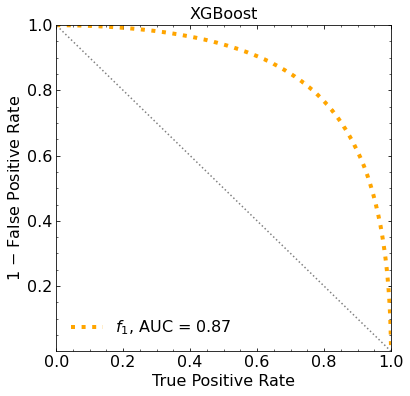

ML iteration  1


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.66975	validation_1-logloss:0.67063
[1]	validation_0-logloss:0.64929	validation_1-logloss:0.65086
[2]	validation_0-logloss:0.63155	validation_1-logloss:0.63364
[3]	validation_0-logloss:0.61577	validation_1-logloss:0.61846
[4]	validation_0-logloss:0.60184	validation_1-logloss:0.60519
[5]	validation_0-logloss:0.58922	validation_1-logloss:0.59314
[6]	validation_0-logloss:0.57791	validation_1-logloss:0.58240
[7]	validation_0-logloss:0.56762	validation_1-logloss:0.57263
[8]	validation_0-logloss:0.55844	validation_1-logloss:0.56401
[9]	validation_0-logloss:0.55010	validation_1-logloss:0.55614
[10]	validation_0-logloss:0.54239	validation_1-logloss:0.54886
[11]	validation_0-logloss:0.53539	validation_1-logloss:0.54231
[12]	validation_0-logloss:0.52899	validation_1-logloss:0.53635
[13]	validation_0-logloss:0.52304	validation_1-logloss:0.53084
[14]	validation_0-logloss:0.51768	validation_1-logloss:0.52583
[15]	validation_0-logloss:0.51271	validation_1-logloss:0.52126
[1

[130]	validation_0-logloss:0.42896	validation_1-logloss:0.45709
[131]	validation_0-logloss:0.42887	validation_1-logloss:0.45708
[132]	validation_0-logloss:0.42882	validation_1-logloss:0.45708
[133]	validation_0-logloss:0.42873	validation_1-logloss:0.45708
[134]	validation_0-logloss:0.42862	validation_1-logloss:0.45708
[135]	validation_0-logloss:0.42857	validation_1-logloss:0.45709
[136]	validation_0-logloss:0.42846	validation_1-logloss:0.45709
[137]	validation_0-logloss:0.42829	validation_1-logloss:0.45710
[138]	validation_0-logloss:0.42821	validation_1-logloss:0.45710
[139]	validation_0-logloss:0.42814	validation_1-logloss:0.45711
[140]	validation_0-logloss:0.42808	validation_1-logloss:0.45711
[141]	validation_0-logloss:0.42798	validation_1-logloss:0.45711
[142]	validation_0-logloss:0.42786	validation_1-logloss:0.45712
[143]	validation_0-logloss:0.42773	validation_1-logloss:0.45713
[144]	validation_0-logloss:0.42771	validation_1-logloss:0.45713
[145]	validation_0-logloss:0.42766	valid

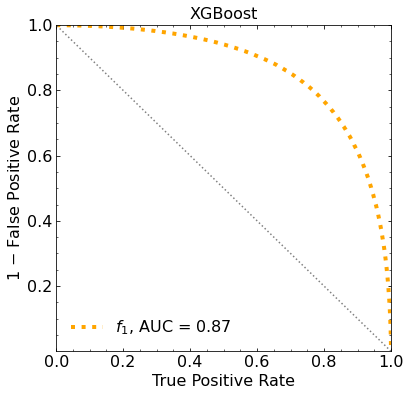

ML iteration  2


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.66990	validation_1-logloss:0.67063
[1]	validation_0-logloss:0.64969	validation_1-logloss:0.65121
[2]	validation_0-logloss:0.63200	validation_1-logloss:0.63409
[3]	validation_0-logloss:0.61644	validation_1-logloss:0.61898
[4]	validation_0-logloss:0.60268	validation_1-logloss:0.60567
[5]	validation_0-logloss:0.59029	validation_1-logloss:0.59362
[6]	validation_0-logloss:0.57927	validation_1-logloss:0.58296
[7]	validation_0-logloss:0.56925	validation_1-logloss:0.57336
[8]	validation_0-logloss:0.56023	validation_1-logloss:0.56475
[9]	validation_0-logloss:0.55205	validation_1-logloss:0.55691
[10]	validation_0-logloss:0.54450	validation_1-logloss:0.54981
[11]	validation_0-logloss:0.53759	validation_1-logloss:0.54325
[12]	validation_0-logloss:0.53125	validation_1-logloss:0.53721
[13]	validation_0-logloss:0.52538	validation_1-logloss:0.53171
[14]	validation_0-logloss:0.52008	validation_1-logloss:0.52670
[15]	validation_0-logloss:0.51518	validation_1-logloss:0.52213
[1

[130]	validation_0-logloss:0.43190	validation_1-logloss:0.45688
[131]	validation_0-logloss:0.43181	validation_1-logloss:0.45688
[132]	validation_0-logloss:0.43176	validation_1-logloss:0.45687
[133]	validation_0-logloss:0.43168	validation_1-logloss:0.45688
[134]	validation_0-logloss:0.43161	validation_1-logloss:0.45687
[135]	validation_0-logloss:0.43157	validation_1-logloss:0.45687
[136]	validation_0-logloss:0.43151	validation_1-logloss:0.45688
[137]	validation_0-logloss:0.43143	validation_1-logloss:0.45687
[138]	validation_0-logloss:0.43133	validation_1-logloss:0.45687
[139]	validation_0-logloss:0.43131	validation_1-logloss:0.45687
[140]	validation_0-logloss:0.43124	validation_1-logloss:0.45687
[141]	validation_0-logloss:0.43114	validation_1-logloss:0.45687
[142]	validation_0-logloss:0.43107	validation_1-logloss:0.45687
[143]	validation_0-logloss:0.43097	validation_1-logloss:0.45687
[144]	validation_0-logloss:0.43092	validation_1-logloss:0.45687
[145]	validation_0-logloss:0.43090	valid

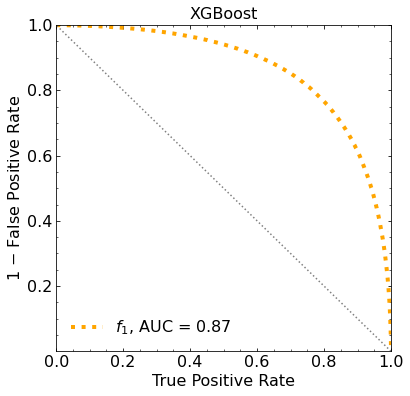

ML iteration  3


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.66960	validation_1-logloss:0.67058
[1]	validation_0-logloss:0.64921	validation_1-logloss:0.65101
[2]	validation_0-logloss:0.63125	validation_1-logloss:0.63370
[3]	validation_0-logloss:0.61532	validation_1-logloss:0.61866
[4]	validation_0-logloss:0.60117	validation_1-logloss:0.60516
[5]	validation_0-logloss:0.58866	validation_1-logloss:0.59328
[6]	validation_0-logloss:0.57724	validation_1-logloss:0.58245
[7]	validation_0-logloss:0.56708	validation_1-logloss:0.57283
[8]	validation_0-logloss:0.55774	validation_1-logloss:0.56405
[9]	validation_0-logloss:0.54928	validation_1-logloss:0.55612
[10]	validation_0-logloss:0.54169	validation_1-logloss:0.54898
[11]	validation_0-logloss:0.53461	validation_1-logloss:0.54239
[12]	validation_0-logloss:0.52824	validation_1-logloss:0.53647
[13]	validation_0-logloss:0.52235	validation_1-logloss:0.53100
[14]	validation_0-logloss:0.51694	validation_1-logloss:0.52607
[15]	validation_0-logloss:0.51191	validation_1-logloss:0.52144
[1

[130]	validation_0-logloss:0.42837	validation_1-logloss:0.45693
[131]	validation_0-logloss:0.42822	validation_1-logloss:0.45693
[132]	validation_0-logloss:0.42812	validation_1-logloss:0.45694
[133]	validation_0-logloss:0.42801	validation_1-logloss:0.45694
[134]	validation_0-logloss:0.42790	validation_1-logloss:0.45694
[135]	validation_0-logloss:0.42780	validation_1-logloss:0.45695
[136]	validation_0-logloss:0.42777	validation_1-logloss:0.45695
[137]	validation_0-logloss:0.42771	validation_1-logloss:0.45695
[138]	validation_0-logloss:0.42764	validation_1-logloss:0.45694
[139]	validation_0-logloss:0.42752	validation_1-logloss:0.45695
[140]	validation_0-logloss:0.42743	validation_1-logloss:0.45695
[141]	validation_0-logloss:0.42735	validation_1-logloss:0.45695
[142]	validation_0-logloss:0.42724	validation_1-logloss:0.45696
[143]	validation_0-logloss:0.42715	validation_1-logloss:0.45696
[144]	validation_0-logloss:0.42713	validation_1-logloss:0.45697
[145]	validation_0-logloss:0.42707	valid

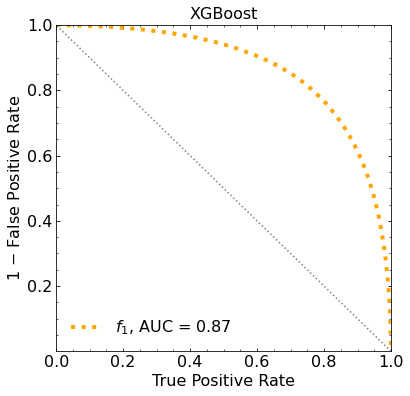

ML iteration  4


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.67007	validation_1-logloss:0.67085
[1]	validation_0-logloss:0.64994	validation_1-logloss:0.65115
[2]	validation_0-logloss:0.63220	validation_1-logloss:0.63396
[3]	validation_0-logloss:0.61665	validation_1-logloss:0.61888
[4]	validation_0-logloss:0.60265	validation_1-logloss:0.60544
[5]	validation_0-logloss:0.59019	validation_1-logloss:0.59342
[6]	validation_0-logloss:0.57913	validation_1-logloss:0.58273
[7]	validation_0-logloss:0.56911	validation_1-logloss:0.57315
[8]	validation_0-logloss:0.55998	validation_1-logloss:0.56443
[9]	validation_0-logloss:0.55177	validation_1-logloss:0.55664
[10]	validation_0-logloss:0.54430	validation_1-logloss:0.54948
[11]	validation_0-logloss:0.53726	validation_1-logloss:0.54284
[12]	validation_0-logloss:0.53096	validation_1-logloss:0.53690
[13]	validation_0-logloss:0.52522	validation_1-logloss:0.53147
[14]	validation_0-logloss:0.51983	validation_1-logloss:0.52647
[15]	validation_0-logloss:0.51498	validation_1-logloss:0.52195
[1

[130]	validation_0-logloss:0.43259	validation_1-logloss:0.45659
[131]	validation_0-logloss:0.43254	validation_1-logloss:0.45658
[132]	validation_0-logloss:0.43247	validation_1-logloss:0.45658
[133]	validation_0-logloss:0.43241	validation_1-logloss:0.45658
[134]	validation_0-logloss:0.43230	validation_1-logloss:0.45658
[135]	validation_0-logloss:0.43225	validation_1-logloss:0.45658
[136]	validation_0-logloss:0.43219	validation_1-logloss:0.45658
[137]	validation_0-logloss:0.43207	validation_1-logloss:0.45658
[138]	validation_0-logloss:0.43196	validation_1-logloss:0.45658
[139]	validation_0-logloss:0.43182	validation_1-logloss:0.45658
[140]	validation_0-logloss:0.43176	validation_1-logloss:0.45658
[141]	validation_0-logloss:0.43172	validation_1-logloss:0.45658
[142]	validation_0-logloss:0.43159	validation_1-logloss:0.45658
[143]	validation_0-logloss:0.43155	validation_1-logloss:0.45658
[144]	validation_0-logloss:0.43152	validation_1-logloss:0.45658
[145]	validation_0-logloss:0.43146	valid

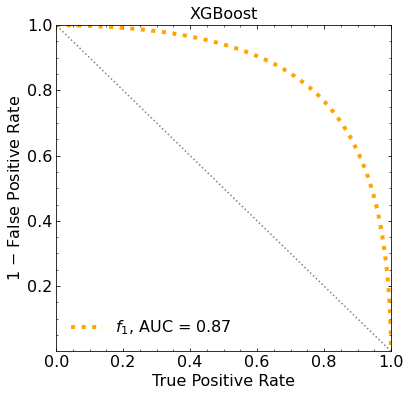

ML iteration  5


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.66996	validation_1-logloss:0.67060
[1]	validation_0-logloss:0.64994	validation_1-logloss:0.65128
[2]	validation_0-logloss:0.63230	validation_1-logloss:0.63404
[3]	validation_0-logloss:0.61682	validation_1-logloss:0.61906
[4]	validation_0-logloss:0.60310	validation_1-logloss:0.60581
[5]	validation_0-logloss:0.59072	validation_1-logloss:0.59395
[6]	validation_0-logloss:0.57971	validation_1-logloss:0.58335
[7]	validation_0-logloss:0.56968	validation_1-logloss:0.57366
[8]	validation_0-logloss:0.56068	validation_1-logloss:0.56502
[9]	validation_0-logloss:0.55238	validation_1-logloss:0.55720
[10]	validation_0-logloss:0.54491	validation_1-logloss:0.55010
[11]	validation_0-logloss:0.53797	validation_1-logloss:0.54340
[12]	validation_0-logloss:0.53172	validation_1-logloss:0.53746
[13]	validation_0-logloss:0.52591	validation_1-logloss:0.53199
[14]	validation_0-logloss:0.52062	validation_1-logloss:0.52701
[15]	validation_0-logloss:0.51569	validation_1-logloss:0.52246
[1

[130]	validation_0-logloss:0.43268	validation_1-logloss:0.45688
[131]	validation_0-logloss:0.43250	validation_1-logloss:0.45689
[132]	validation_0-logloss:0.43241	validation_1-logloss:0.45689
[133]	validation_0-logloss:0.43233	validation_1-logloss:0.45691
[134]	validation_0-logloss:0.43227	validation_1-logloss:0.45691
[135]	validation_0-logloss:0.43216	validation_1-logloss:0.45691
[136]	validation_0-logloss:0.43208	validation_1-logloss:0.45691
[137]	validation_0-logloss:0.43196	validation_1-logloss:0.45690
[138]	validation_0-logloss:0.43190	validation_1-logloss:0.45690
[139]	validation_0-logloss:0.43184	validation_1-logloss:0.45690
[140]	validation_0-logloss:0.43178	validation_1-logloss:0.45690
[141]	validation_0-logloss:0.43171	validation_1-logloss:0.45691
[142]	validation_0-logloss:0.43166	validation_1-logloss:0.45691
[143]	validation_0-logloss:0.43164	validation_1-logloss:0.45690
[144]	validation_0-logloss:0.43154	validation_1-logloss:0.45691
[145]	validation_0-logloss:0.43146	valid

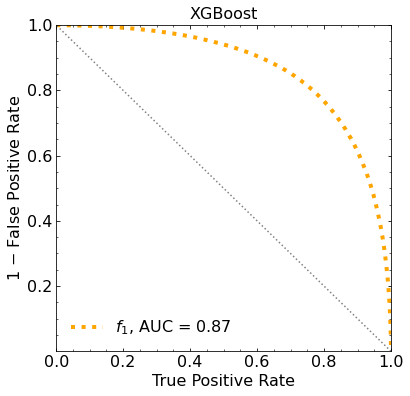

ML iteration  6


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.66958	validation_1-logloss:0.67054
[1]	validation_0-logloss:0.64918	validation_1-logloss:0.65096
[2]	validation_0-logloss:0.63128	validation_1-logloss:0.63374
[3]	validation_0-logloss:0.61552	validation_1-logloss:0.61865
[4]	validation_0-logloss:0.60149	validation_1-logloss:0.60525
[5]	validation_0-logloss:0.58887	validation_1-logloss:0.59314
[6]	validation_0-logloss:0.57753	validation_1-logloss:0.58237
[7]	validation_0-logloss:0.56745	validation_1-logloss:0.57277
[8]	validation_0-logloss:0.55831	validation_1-logloss:0.56417
[9]	validation_0-logloss:0.54992	validation_1-logloss:0.55617
[10]	validation_0-logloss:0.54234	validation_1-logloss:0.54905
[11]	validation_0-logloss:0.53531	validation_1-logloss:0.54253
[12]	validation_0-logloss:0.52899	validation_1-logloss:0.53656
[13]	validation_0-logloss:0.52308	validation_1-logloss:0.53100
[14]	validation_0-logloss:0.51769	validation_1-logloss:0.52612
[15]	validation_0-logloss:0.51276	validation_1-logloss:0.52160
[1

[130]	validation_0-logloss:0.42924	validation_1-logloss:0.45694
[131]	validation_0-logloss:0.42916	validation_1-logloss:0.45694
[132]	validation_0-logloss:0.42901	validation_1-logloss:0.45694
[133]	validation_0-logloss:0.42895	validation_1-logloss:0.45694
[134]	validation_0-logloss:0.42883	validation_1-logloss:0.45694
[135]	validation_0-logloss:0.42871	validation_1-logloss:0.45695
[136]	validation_0-logloss:0.42865	validation_1-logloss:0.45694
[137]	validation_0-logloss:0.42858	validation_1-logloss:0.45695
[138]	validation_0-logloss:0.42851	validation_1-logloss:0.45696
[139]	validation_0-logloss:0.42845	validation_1-logloss:0.45696
[140]	validation_0-logloss:0.42835	validation_1-logloss:0.45695
[141]	validation_0-logloss:0.42825	validation_1-logloss:0.45696
[142]	validation_0-logloss:0.42814	validation_1-logloss:0.45696
[143]	validation_0-logloss:0.42807	validation_1-logloss:0.45696
[144]	validation_0-logloss:0.42801	validation_1-logloss:0.45696
[145]	validation_0-logloss:0.42792	valid

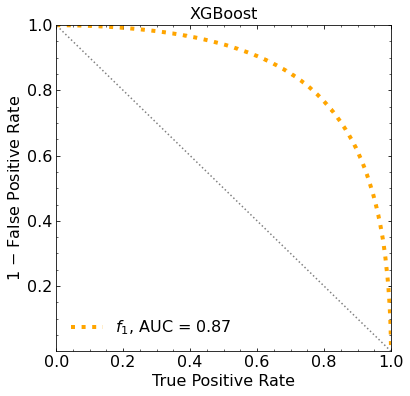

ML iteration  7


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.66975	validation_1-logloss:0.67068
[1]	validation_0-logloss:0.64930	validation_1-logloss:0.65085
[2]	validation_0-logloss:0.63143	validation_1-logloss:0.63382
[3]	validation_0-logloss:0.61562	validation_1-logloss:0.61868
[4]	validation_0-logloss:0.60158	validation_1-logloss:0.60535
[5]	validation_0-logloss:0.58894	validation_1-logloss:0.59329
[6]	validation_0-logloss:0.57768	validation_1-logloss:0.58239
[7]	validation_0-logloss:0.56746	validation_1-logloss:0.57271
[8]	validation_0-logloss:0.55810	validation_1-logloss:0.56396
[9]	validation_0-logloss:0.54967	validation_1-logloss:0.55605
[10]	validation_0-logloss:0.54199	validation_1-logloss:0.54888
[11]	validation_0-logloss:0.53492	validation_1-logloss:0.54231
[12]	validation_0-logloss:0.52855	validation_1-logloss:0.53637
[13]	validation_0-logloss:0.52264	validation_1-logloss:0.53100
[14]	validation_0-logloss:0.51717	validation_1-logloss:0.52593
[15]	validation_0-logloss:0.51225	validation_1-logloss:0.52138
[1

[130]	validation_0-logloss:0.42870	validation_1-logloss:0.45659
[131]	validation_0-logloss:0.42859	validation_1-logloss:0.45659
[132]	validation_0-logloss:0.42855	validation_1-logloss:0.45659
[133]	validation_0-logloss:0.42845	validation_1-logloss:0.45660
[134]	validation_0-logloss:0.42835	validation_1-logloss:0.45660
[135]	validation_0-logloss:0.42827	validation_1-logloss:0.45659
[136]	validation_0-logloss:0.42815	validation_1-logloss:0.45659
[137]	validation_0-logloss:0.42805	validation_1-logloss:0.45659
[138]	validation_0-logloss:0.42797	validation_1-logloss:0.45661
[139]	validation_0-logloss:0.42787	validation_1-logloss:0.45661
[140]	validation_0-logloss:0.42770	validation_1-logloss:0.45664
[141]	validation_0-logloss:0.42766	validation_1-logloss:0.45664
[142]	validation_0-logloss:0.42758	validation_1-logloss:0.45665
[143]	validation_0-logloss:0.42751	validation_1-logloss:0.45665
[144]	validation_0-logloss:0.42743	validation_1-logloss:0.45665
[145]	validation_0-logloss:0.42735	valid

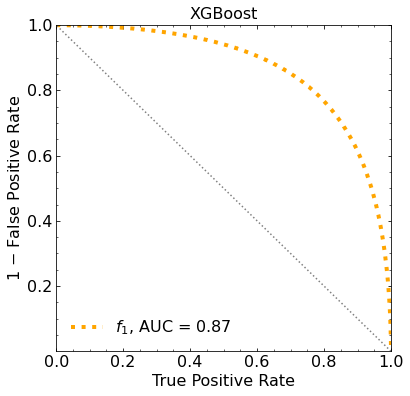

ML iteration  8


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.66968	validation_1-logloss:0.67062
[1]	validation_0-logloss:0.64939	validation_1-logloss:0.65107
[2]	validation_0-logloss:0.63153	validation_1-logloss:0.63383
[3]	validation_0-logloss:0.61579	validation_1-logloss:0.61877
[4]	validation_0-logloss:0.60163	validation_1-logloss:0.60527
[5]	validation_0-logloss:0.58901	validation_1-logloss:0.59325
[6]	validation_0-logloss:0.57770	validation_1-logloss:0.58252
[7]	validation_0-logloss:0.56752	validation_1-logloss:0.57281
[8]	validation_0-logloss:0.55819	validation_1-logloss:0.56396
[9]	validation_0-logloss:0.54984	validation_1-logloss:0.55603
[10]	validation_0-logloss:0.54219	validation_1-logloss:0.54883
[11]	validation_0-logloss:0.53526	validation_1-logloss:0.54227
[12]	validation_0-logloss:0.52890	validation_1-logloss:0.53637
[13]	validation_0-logloss:0.52302	validation_1-logloss:0.53092
[14]	validation_0-logloss:0.51768	validation_1-logloss:0.52599
[15]	validation_0-logloss:0.51268	validation_1-logloss:0.52135
[1

[130]	validation_0-logloss:0.42979	validation_1-logloss:0.45664
[131]	validation_0-logloss:0.42968	validation_1-logloss:0.45664
[132]	validation_0-logloss:0.42959	validation_1-logloss:0.45664
[133]	validation_0-logloss:0.42953	validation_1-logloss:0.45664
[134]	validation_0-logloss:0.42948	validation_1-logloss:0.45663
[135]	validation_0-logloss:0.42940	validation_1-logloss:0.45664
[136]	validation_0-logloss:0.42928	validation_1-logloss:0.45664
[137]	validation_0-logloss:0.42917	validation_1-logloss:0.45664
[138]	validation_0-logloss:0.42903	validation_1-logloss:0.45665
[139]	validation_0-logloss:0.42893	validation_1-logloss:0.45665
[140]	validation_0-logloss:0.42888	validation_1-logloss:0.45665
[141]	validation_0-logloss:0.42875	validation_1-logloss:0.45665
[142]	validation_0-logloss:0.42871	validation_1-logloss:0.45666
[143]	validation_0-logloss:0.42863	validation_1-logloss:0.45667
[144]	validation_0-logloss:0.42853	validation_1-logloss:0.45667
[145]	validation_0-logloss:0.42843	valid

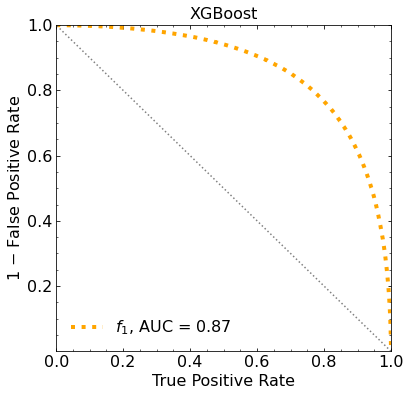

ML iteration  9


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.67003	validation_1-logloss:0.67082
[1]	validation_0-logloss:0.64982	validation_1-logloss:0.65118
[2]	validation_0-logloss:0.63222	validation_1-logloss:0.63400
[3]	validation_0-logloss:0.61667	validation_1-logloss:0.61908
[4]	validation_0-logloss:0.60295	validation_1-logloss:0.60579
[5]	validation_0-logloss:0.59046	validation_1-logloss:0.59376
[6]	validation_0-logloss:0.57939	validation_1-logloss:0.58313
[7]	validation_0-logloss:0.56937	validation_1-logloss:0.57357
[8]	validation_0-logloss:0.56041	validation_1-logloss:0.56501
[9]	validation_0-logloss:0.55222	validation_1-logloss:0.55721
[10]	validation_0-logloss:0.54470	validation_1-logloss:0.55003
[11]	validation_0-logloss:0.53785	validation_1-logloss:0.54354
[12]	validation_0-logloss:0.53151	validation_1-logloss:0.53754
[13]	validation_0-logloss:0.52579	validation_1-logloss:0.53219
[14]	validation_0-logloss:0.52041	validation_1-logloss:0.52714
[15]	validation_0-logloss:0.51554	validation_1-logloss:0.52257
[1

[130]	validation_0-logloss:0.43407	validation_1-logloss:0.45715
[131]	validation_0-logloss:0.43395	validation_1-logloss:0.45714
[132]	validation_0-logloss:0.43380	validation_1-logloss:0.45713
[133]	validation_0-logloss:0.43376	validation_1-logloss:0.45713
[134]	validation_0-logloss:0.43367	validation_1-logloss:0.45715
[135]	validation_0-logloss:0.43356	validation_1-logloss:0.45715
[136]	validation_0-logloss:0.43350	validation_1-logloss:0.45715
[137]	validation_0-logloss:0.43347	validation_1-logloss:0.45715
[138]	validation_0-logloss:0.43342	validation_1-logloss:0.45715
[139]	validation_0-logloss:0.43335	validation_1-logloss:0.45715
[140]	validation_0-logloss:0.43330	validation_1-logloss:0.45716
[141]	validation_0-logloss:0.43321	validation_1-logloss:0.45715
[142]	validation_0-logloss:0.43316	validation_1-logloss:0.45714
[143]	validation_0-logloss:0.43309	validation_1-logloss:0.45714
[144]	validation_0-logloss:0.43298	validation_1-logloss:0.45714
[145]	validation_0-logloss:0.43296	valid

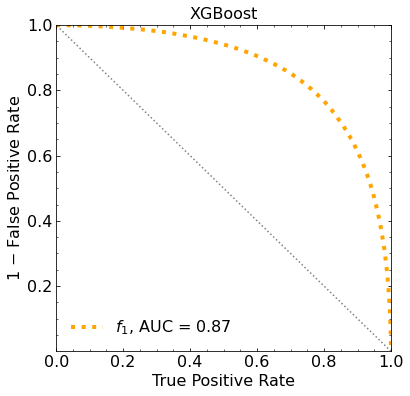

Classification score (1 ML):


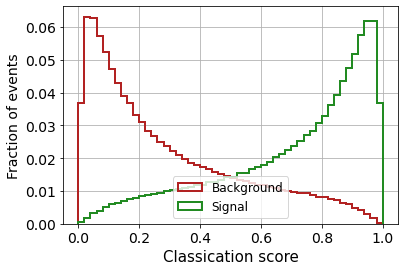

Classification score (10 ML):


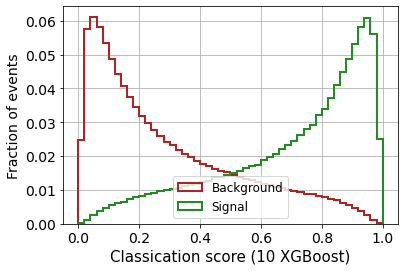

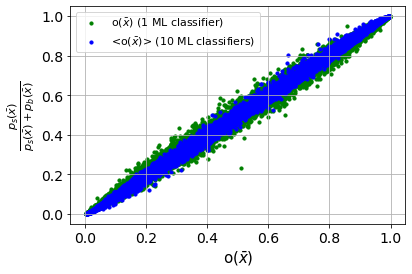


 ----------------------------------------- 

B_expected:  50000
S_expected:  500
S/$\sqrt{B}$:  2.23606797749979
 BINNED CLASSIFIER OUTPUT
  BL lineal bins, 1 ML
Z_XG 10 bins_1ML:  5.656744093485991
Z_XG 25 bins_1ML:  6.260730445762053
Z_XG 50 bins_1ML:  6.451226239213228
Z_XG 100 bins_1ML:  6.496526434042713

 BL non-lineal bins, 1 ML
Z_XG 10 bins_eq_1ML:  4.471454611860138
Z_XG 25 bins_eq_1ML:  5.123215266980122
Z_XG 50 bins_eq_1ML:  5.509418117456146
Z_XG 100 bins_eq_1ML:  5.821994387329506

 BL lineal bins, 10 ML
Z_XG 10 bins:  5.719965127659056
Z_XG 25 bins:  6.316902290416277
Z_XG 50 bins:  6.4909933776390485
Z_XG 100 bins:  6.550144117547985

 BL non-lineal bins, 10 ML
Z_XG 10 bins_eq:  4.483933560497661
Z_XG 25 bins_eq:  5.136396386930267
Z_XG 50 bins_eq:  5.530719804474754
Z_XG 100 bins_eq:  5.834560782395992

 ----------------------------------------- 


 If  20200  =  1101    then the proposed range has to be extended
n_ensembles (actual):  9863
TRUE PDF LIKELIHOOD (GAUSSIA

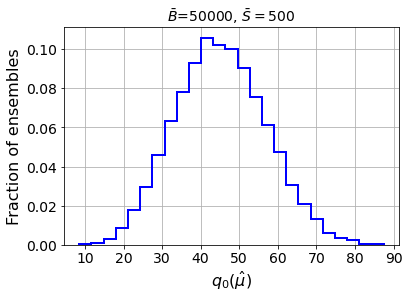

muhat mean:  0.06261786474703437
Z_gaussian:  6.699366903373773
Z_gaussian_mu0:  6.69813875898595

 ------------------------------------ 

 MLL + KDE (1ML) 


/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf  1116.38184812
  1121.90826225  1127.0659468   1127.26528579  1125.0428727
  1116.62672054  1098.95680617  1068.112767    1016.45496248
   934.60206234   809.80216621   625.15345113   358.28588025
    -5.45472085  -475.97542405 -1095.92199544 -2033.73471255]
  warnings.warn(
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:929: RuntimeWarning: invalid value encountered in subtract
  array_stds = np.sqrt(np.average((array -
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf  1093.14140429  1088.11823878
  1079.63883016  1063.73525908  1034.47054249   984.33564796
   90

KDE Kernel:  epanechnikov
Background bandwidth:  0.0091866653175426
Signal bandwidth:  0.0091866653175426


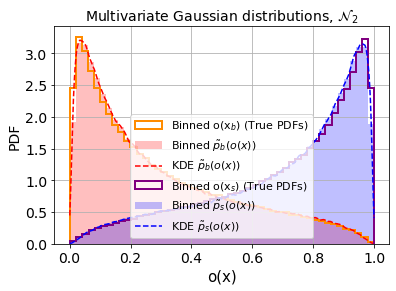

 MLL + KDE (10ML) 


/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf  1122.1520309
  1129.63921898  1133.21343807  1135.23343285  1132.46774
  1125.86182863  1111.28523238  1084.85436958  1038.77376078
   962.34668837   843.47825843   663.83078747   401.61359084
    41.86222041  -427.34938412 -1057.51309453 -2016.94700647]
  warnings.warn(
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:929: RuntimeWarning: invalid value encountered in subtract
  array_stds = np.sqrt(np.average((array -
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf           -inf  1100.33845448  1098.13122349
  1091.54499946  1078.31030611  1052.93905437  1009.07459645
   935.5

KDE Kernel:  epanechnikov
Background bandwidth:  0.0091866653175426
Signal bandwidth:  0.0091866653175426


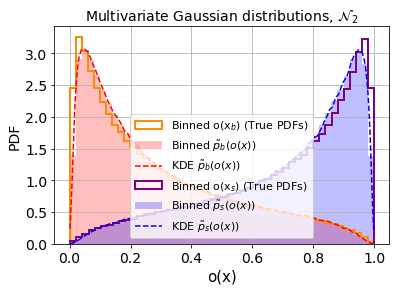

 Z MLL+KDE (1ML) 


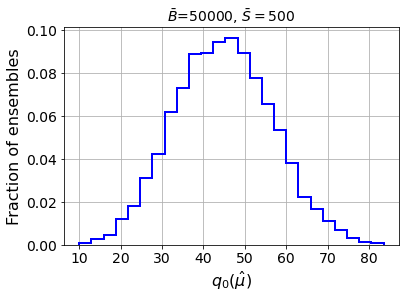

muhat mean_1ML:  0.04782013586129981
Z_KDE_1ML:  6.683856066034372
Z_KDE mu=0_1ML:  6.684411213058231

 Z MLL+KDE (10ML) 


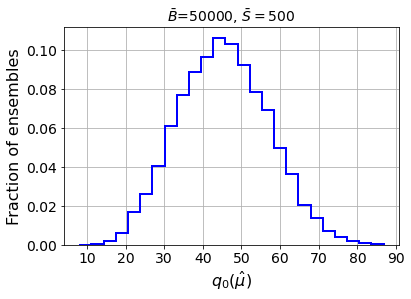

muhat mean:  0.04702930142958532
Z_KDE:  6.723939741751156
Z_KDE mu=0:  6.723939741751156

 ------------------------------------ 



In [123]:
dim=7

#######################
# generate the events #
#######################
    
mean_sig = epsilon*np.ones(dim)
mean_bkg = -1*mean_sig

#cov_sig = np.identity(dim)
cov_sig = np.identity(dim) + (0. * ( np.ones((dim,dim)) - np.identity(dim) ))
cov_bkg = cov_sig

signal_X_1, signal_X_2, signal_X_3, signal_X_4, signal_X_5, signal_X_6, signal_X_7 = np.random.multivariate_normal(mean_sig, cov_sig, N).T
background_X_1, background_X_2, background_X_3, background_X_4, background_X_5, background_X_6, background_X_7 = np.random.multivariate_normal(mean_bkg, cov_bkg, N).T


dim1 = np.concatenate((background_X_1,signal_X_1))
dim2 = np.concatenate((background_X_2,signal_X_2))
dim3 = np.concatenate((background_X_3,signal_X_3))
dim4 = np.concatenate((background_X_4,signal_X_4))
dim5 = np.concatenate((background_X_5,signal_X_5))
dim6 = np.concatenate((background_X_6,signal_X_6))
dim7 = np.concatenate((background_X_7,signal_X_7))

# labels
background_Y = np.zeros(N)
signal_Y = np.ones(N)

# DATA in a single matrix (features + labels)
df = pd.DataFrame()
df['dim1'] = dim1.reshape(-1)
df['dim2'] = dim2.reshape(-1)
df['dim3'] = dim3.reshape(-1)
df['dim4'] = dim4.reshape(-1)
df['dim5'] = dim5.reshape(-1)
df['dim6'] = dim6.reshape(-1)
df['dim7'] = dim7.reshape(-1)
df['Y'] = np.concatenate((background_Y.astype('int'),signal_Y.astype('int')))

X_gauss = df[['dim1','dim2','dim3','dim4','dim5','dim6','dim7']].values 
Y_gauss = df[['Y']].values

# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.5

X_gauss_aux, X_gauss_test, Y_gauss_aux, Y_gauss_test = train_test_split(X_gauss,
                                                                Y_gauss,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_gauss,
                                                                shuffle=True)


X_gauss_train, X_gauss_val, Y_gauss_train, Y_gauss_val = train_test_split(X_gauss_aux,
                                                                  Y_gauss_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_gauss_aux,
                                                                  shuffle=True)

print('')
print('X_gauss_train : ', X_gauss_train.shape)
print('y_gauss_train : ', Y_gauss_train.shape)
print('X_gauss_val : ', X_gauss_val.shape)
print('y_gauss_val : ', Y_gauss_val.shape)
print('X_gauss_test : ', X_gauss_test.shape)
print('y_gauss_test : ', Y_gauss_test.shape)
print('')


# PLOT (only 1st feature) to visualize the data
X_gauss_test_SM = []
X_gauss_test_NP = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] ==0:
        X_gauss_test_SM.append(X_gauss_test[i].tolist())
    else:
        X_gauss_test_NP.append(X_gauss_test[i].tolist())    


X_gauss_test_SM = np.array(X_gauss_test_SM)
X_gauss_test_NP = np.array(X_gauss_test_NP)


weights = np.ones_like(X_gauss_test_SM[:,0])/float(len(X_gauss_test_SM[:,0]))
plt.hist(X_gauss_test_SM[:,0], 20, histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(X_gauss_test_NP[:,0])/float(len(X_gauss_test_NP[:,0]))
plt.hist(X_gauss_test_NP[:,0], 20, histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$x_1$",fontsize=16)
plt.ylabel("Fraction of events",fontsize=16)
plt.grid()
plt.legend(fontsize=14)
plt.title(r"Gaussian (dim=%0.2d)" % dim,fontsize=14)
plt.show()  






################################
# the true pdfs (useful later) #
################################

sig_multi = multivariate_normal(mean_sig, cov_sig)
bkg_multi = multivariate_normal(mean_bkg, cov_bkg) 




#######################
# CLASSIFIER: XGBoost #
#######################

# only 1 ML
roc_auc_XG, y_pred_xg_1ML = XG(X_gauss_train, X_gauss_test, X_gauss_val, Y_gauss_train, Y_gauss_test, Y_gauss_val)

store_AUC.append(roc_auc_XG)


# Bagging

print('ML iteration 0')
roc_auc_XG, y_pred_xg_aux = XG(X_gauss_train[:100000], X_gauss_test, X_gauss_val, Y_gauss_train[:100000], Y_gauss_test, Y_gauss_val)
y_pred_xg_auxRE = np.reshape(y_pred_xg_aux, (1,len(y_pred_xg_aux)))

for it in range(1,iterations_ML):

    print('ML iteration ', it)
    roc_auc_XG, y_pred_xg_aux_it = XG(X_gauss_train[(100000*it):(100000*it)+100000], X_gauss_test, X_gauss_val, Y_gauss_train[(100000*it):(100000*it)+100000], Y_gauss_test, Y_gauss_val)
    
    y_pred_xg_auxRE_it = np.reshape(y_pred_xg_aux_it, (1,len(y_pred_xg_aux_it)))
    
    y_pred_xg_auxRE = np.concatenate([y_pred_xg_auxRE,y_pred_xg_auxRE_it])

# to smooth, mean of 10 predictions
y_pred_xg = np.mean(y_pred_xg_auxRE, axis=0)




########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

# 1 ML
pred_XG_SM_1ML = []
pred_XG_NP_1ML = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] == 0:
        pred_XG_SM_1ML.append(y_pred_xg_1ML[i])
    else:
        pred_XG_NP_1ML.append(y_pred_xg_1ML[i])
        
# Bagging  
pred_XG_SM = []
pred_XG_NP = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score (1 ML):')
        
weights = np.ones_like(pred_XG_SM_1ML)/float(len(pred_XG_SM_1ML))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM_1ML, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP_1ML)/float(len(pred_XG_NP_1ML))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP_1ML, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12, loc="lower center")
plt.show()


print('Classification score (10 ML):')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (10 XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12, loc="lower center")
plt.show()




ratio_ps_pb_true = sig_multi.pdf(X_gauss_test) / ( sig_multi.pdf(X_gauss_test) + bkg_multi.pdf(X_gauss_test) )
ratio_ps_pb_true_B = sig_multi.pdf(X_gauss_test_SM) / ( sig_multi.pdf(X_gauss_test_SM) + bkg_multi.pdf(X_gauss_test_SM) )
ratio_ps_pb_true_S = sig_multi.pdf(X_gauss_test_NP) / ( sig_multi.pdf(X_gauss_test_NP) + bkg_multi.pdf(X_gauss_test_NP) )

plt.scatter(y_pred_xg_1ML[:10000], ratio_ps_pb_true[:10000], color='green', label=r'o($\bar{x}$) (1 ML classifier)', s=10)
plt.scatter(y_pred_xg[:10000], ratio_ps_pb_true[:10000], color='blue', label=r'<o($\bar{x}$)> (10 ML classifiers)', s=10)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r"o($\bar{x}$)",fontsize=15)
plt.ylabel(r"$\frac{p_s(\bar{x})}{p_s(\bar{x})+p_b(\bar{x})}$",fontsize=16)
plt.grid()
plt.legend(fontsize=11)
#plt.savefig('images/' + 'optimalclass-vs-ox.pdf', format="pdf", bbox_inches="tight")
plt.show()

print('\n ----------------------------------------- \n')






###########
# METHODS #
###########

print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)



############################
# BINNED CLASSIFIER OUTPUT #
############################

print(' BINNED CLASSIFIER OUTPUT')

print('  BL lineal bins, 1 ML')

# 10 BINS
Z_bins_XG_10bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 10, [[0,1]], linear_bins=True)
store_Z_bins_XG_10bins_1ML.append(Z_bins_XG_10bins_1ML)
print('Z_XG 10 bins_1ML: ', Z_bins_XG_10bins_1ML)

# 25 BINS
Z_bins_XG_25bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 25, [[0,1]], linear_bins=True)
store_Z_bins_XG_25bins_1ML.append(Z_bins_XG_25bins_1ML)
print('Z_XG 25 bins_1ML: ', Z_bins_XG_25bins_1ML)

# 50 BINS
Z_bins_XG_50bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 50, [[0,1]], linear_bins=True)
store_Z_bins_XG_50bins_1ML.append(Z_bins_XG_50bins_1ML)
print('Z_XG 50 bins_1ML: ', Z_bins_XG_50bins_1ML)

# 100 BINS
Z_bins_XG_100bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 100, [[0,1]], linear_bins=True)
store_Z_bins_XG_100bins_1ML.append(Z_bins_XG_100bins_1ML)
print('Z_XG 100 bins_1ML: ', Z_bins_XG_100bins_1ML)


print('\n BL non-lineal bins, 1 ML')

# 10 BINS
Z_bins_XG_10bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 10, [[0,1]], linear_bins=False)
store_Z_bins_XG_10bins_eq_1ML.append(Z_bins_XG_10bins_eq_1ML)
print('Z_XG 10 bins_eq_1ML: ', Z_bins_XG_10bins_eq_1ML)

# 25 BINS
Z_bins_XG_25bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 25, [[0,1]], linear_bins=False)
store_Z_bins_XG_25bins_eq_1ML.append(Z_bins_XG_25bins_eq_1ML)
print('Z_XG 25 bins_eq_1ML: ', Z_bins_XG_25bins_eq_1ML)

# 50 BINS
Z_bins_XG_50bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 50, [[0,1]], linear_bins=False)
store_Z_bins_XG_50bins_eq_1ML.append(Z_bins_XG_50bins_eq_1ML)
print('Z_XG 50 bins_eq_1ML: ', Z_bins_XG_50bins_eq_1ML)

# 100 BINS
Z_bins_XG_100bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 100, [[0,1]], linear_bins=False)
store_Z_bins_XG_100bins_eq_1ML.append(Z_bins_XG_100bins_eq_1ML)
print('Z_XG 100 bins_eq_1ML: ', Z_bins_XG_100bins_eq_1ML)


print('\n BL lineal bins, 10 ML')

# 10 BINS
Z_bins_XG_10bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 10, [[0,1]], linear_bins=True)
store_Z_bins_XG_10bins.append(Z_bins_XG_10bins)
print('Z_XG 10 bins: ', Z_bins_XG_10bins)

# 25 BINS
Z_bins_XG_25bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 25, [[0,1]], linear_bins=True)
store_Z_bins_XG_25bins.append(Z_bins_XG_25bins)
print('Z_XG 25 bins: ', Z_bins_XG_25bins)

# 50 BINS
Z_bins_XG_50bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 50, [[0,1]], linear_bins=True)
store_Z_bins_XG_50bins.append(Z_bins_XG_50bins)
print('Z_XG 50 bins: ', Z_bins_XG_50bins)

# 100 BINS
Z_bins_XG_100bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 100, [[0,1]], linear_bins=True)
store_Z_bins_XG_100bins.append(Z_bins_XG_100bins)
print('Z_XG 100 bins: ', Z_bins_XG_100bins)


print('\n BL non-lineal bins, 10 ML')

# 10 BINS
Z_bins_XG_10bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 10, [[0,1]], linear_bins=False)
store_Z_bins_XG_10bins_eq.append(Z_bins_XG_10bins_eq)
print('Z_XG 10 bins_eq: ', Z_bins_XG_10bins_eq)

# 25 BINS
Z_bins_XG_25bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 25, [[0,1]], linear_bins=False)
store_Z_bins_XG_25bins_eq.append(Z_bins_XG_25bins_eq)
print('Z_XG 25 bins_eq: ', Z_bins_XG_25bins_eq)

# 50 BINS
Z_bins_XG_50bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 50, [[0,1]], linear_bins=False)
store_Z_bins_XG_50bins_eq.append(Z_bins_XG_50bins_eq)
print('Z_XG 50 bins_eq: ', Z_bins_XG_50bins_eq)

# 100 BINS
Z_bins_XG_100bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 100, [[0,1]], linear_bins=False)
store_Z_bins_XG_100bins_eq.append(Z_bins_XG_100bins_eq)
print('Z_XG 100 bins_eq: ', Z_bins_XG_100bins_eq)


print('\n ----------------------------------------- \n')






###########################
# SET THE TOY EXPERIMENTS #
###########################

list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles = ensembler(B_expected, S_expected, n_ensembles)






###################################
# TRUE PDF LIKELIHOOD (GAUSSIANS) #
###################################

indices = [i for i in range(len(X_gauss_test_SM))]

prob_B_given_B = bkg_multi.pdf(X_gauss_test_SM)
prob_B_given_S = sig_multi.pdf(X_gauss_test_SM)



print('TRUE PDF LIKELIHOOD (GAUSSIANS):')

print('n_ensembles (initial): ', n_ensembles)

Z_gaussian, muhat_mean_gaussian, Z_gaussian_mu0, muhat_selected_list, q_muhat, q_muhat_mu0 = Z_MLL(B_expected, S_expected, prob_B_given_B, prob_B_given_S, list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles)

# Histogram of q_muhats

weights = np.ones_like(q_muhat)/float(len(q_muhat))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()

store_muhat_mean_gaussian.append(muhat_mean_gaussian)
store_Z_gaussian.append(Z_gaussian)

store_Z_gaussian_mu0.append(Z_gaussian_mu0)

print('muhat mean: ', muhat_mean_gaussian)
print('Z_gaussian: ', Z_gaussian)
print('Z_gaussian_mu0: ', Z_gaussian_mu0)


print('\n ------------------------------------ \n')







#########
#  KDE  #
#########  

print(' MLL + KDE (1ML) ')

kde_bkg_1ML, kde_sig_1ML, B_bandwidth_1ML, S_bandwidth_1ML = KDE_finder(pred_XG_SM_1ML, pred_XG_NP_1ML)


# range (~between 0 and 1)
min_val_1ML = np.min([np.min(pred_XG_SM_1ML),np.min(pred_XG_NP_1ML)])
max_val_1ML = np.max([np.max(pred_XG_SM_1ML),np.max(pred_XG_NP_1ML)])

s_vals_1ML = np.linspace(min_val_1ML,max_val_1ML,1000)



# evaluate the densities for each value of s (~bins)
dens_bkg_1ML = np.exp(kde_bkg_1ML.score_samples(np.c_[s_vals_1ML, np.zeros(len(s_vals_1ML)) ]) )
dens_sig_1ML = np.exp(kde_sig_1ML.score_samples(np.c_[s_vals_1ML, np.ones(len(s_vals_1ML)) ]) )



# Normalize to 1
# Area
factor_aux_SM_1ML = sum(dens_bkg_1ML*(s_vals_1ML[1]-s_vals_1ML[0]))
factor_aux_NP_1ML = sum(dens_sig_1ML*(s_vals_1ML[1]-s_vals_1ML[0]))

# normalize
dens_bkg_1ML = dens_bkg_1ML / factor_aux_SM_1ML
dens_sig_1ML = dens_sig_1ML / factor_aux_NP_1ML





# plot to check the estimation

plt.figure()

plt.hist(ratio_ps_pb_true_B,density=True,bins=50,lw=2,histtype='step',color='darkorange',alpha=1,label=r'Binned o(x$_b$) (True PDFs)')
plt.hist(pred_XG_SM_1ML,density=True,bins=50,color='red',alpha=0.25,label=r'Binned $\tilde{p}_{b}(o(x))$');
plt.plot(s_vals_1ML,dens_bkg_1ML,color='red',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');

plt.hist(ratio_ps_pb_true_S,density=True,bins=50,lw=2,histtype='step',color='purple',alpha=1,label=r'Binned o(x$_s$) (True PDFs)');
plt.hist(pred_XG_NP_1ML,density=True,bins=50,color='blue',alpha=0.25,label=r'Binned $\tilde{p}_{s}(o(x))$');
plt.plot(s_vals_1ML,dens_sig_1ML,color='blue',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("o(x)",fontsize=15)
plt.ylabel("PDF",fontsize=14)
plt.grid()
plt.legend(loc="lower center", fontsize=11, handlelength=2.5)
plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{2}$', fontsize=14)
#plt.savefig('images/' + '2gaussian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()





print(' MLL + KDE (10ML) ')

kde_bkg, kde_sig, B_bandwidth, S_bandwidth = KDE_finder(pred_XG_SM, pred_XG_NP)


# range (~between 0 and 1)
min_val = np.min([np.min(pred_XG_SM),np.min(pred_XG_NP)])
max_val = np.max([np.max(pred_XG_SM),np.max(pred_XG_NP)])

s_vals = np.linspace(min_val,max_val,1000)



# evaluate the densities for each value of s (~bins)
dens_bkg = np.exp(kde_bkg.score_samples(np.c_[s_vals, np.zeros(len(s_vals)) ]) )
dens_sig = np.exp(kde_sig.score_samples(np.c_[s_vals, np.ones(len(s_vals)) ]) )



# Normalize to 1
# Area
factor_aux_SM = sum(dens_bkg*(s_vals[1]-s_vals[0]))
factor_aux_NP = sum(dens_sig*(s_vals[1]-s_vals[0]))

# normalize
dens_bkg = dens_bkg / factor_aux_SM
dens_sig = dens_sig / factor_aux_NP





# plot to check the estimation

plt.figure()

plt.hist(ratio_ps_pb_true_B,density=True,bins=50,lw=2,histtype='step',color='darkorange',alpha=1,label=r'Binned o(x$_b$) (True PDFs)')
plt.hist(pred_XG_SM,density=True,bins=50,color='red',alpha=0.25,label=r'Binned $\tilde{p}_{b}(o(x))$');
plt.plot(s_vals,dens_bkg,color='red',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');

plt.hist(ratio_ps_pb_true_S,density=True,bins=50,lw=2,histtype='step',color='purple',alpha=1,label=r'Binned o(x$_s$) (True PDFs)');
plt.hist(pred_XG_NP,density=True,bins=50,color='blue',alpha=0.25,label=r'Binned $\tilde{p}_{s}(o(x))$');
plt.plot(s_vals,dens_sig,color='blue',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("o(x)",fontsize=15)
plt.ylabel("PDF",fontsize=14)
plt.grid()
plt.legend(loc="lower center", fontsize=11, handlelength=2.5)
plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{2}$', fontsize=14)
#plt.savefig('images/' + '2gaussian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()






#############
# MLL + KDE #
#############

print(' Z MLL+KDE (1ML) ')
# FOR EXCLUSION:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

KDE_SM_pred_SM_1ML = np.exp(kde_bkg_1ML.score_samples(np.c_[pred_XG_SM_1ML, np.zeros(len(pred_XG_SM_1ML)) ]) )
KDE_NP_pred_SM_1ML = np.exp(kde_sig_1ML.score_samples(np.c_[pred_XG_SM_1ML, np.ones(len(pred_XG_SM_1ML)) ]) )

# Normalize

KDE_SM_pred_SM_1ML = KDE_SM_pred_SM_1ML / factor_aux_SM_1ML
KDE_NP_pred_SM_1ML = KDE_NP_pred_SM_1ML / factor_aux_NP_1ML


indices_1ML = [i for i in range(len(KDE_NP_pred_SM_1ML))]

prob_B_given_B_1ML = KDE_SM_pred_SM_1ML
prob_B_given_S_1ML = KDE_NP_pred_SM_1ML

Z_KDE_1ML, muhat_mean_MLL_KDE_1ML, Z_KDE_mu0_1ML, muhat_selected_list_1ML, q_muhat_1ML, q_muhat_mu0_1ML = Z_MLL(B_expected, S_expected, prob_B_given_B_1ML, prob_B_given_S_1ML, list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles)
    
    
# Histogram of q_muhats

weights = np.ones_like(q_muhat_1ML)/float(len(q_muhat_1ML))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat_1ML, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()


store_muhat_mean_MLL_KDE_1ML.append(muhat_mean_MLL_KDE_1ML)
store_Z_MLL_KDE_1ML.append(Z_KDE_1ML)

store_Z_MLL_KDE_mu0_1ML.append(Z_KDE_mu0_1ML)

print('muhat mean_1ML: ', muhat_mean_MLL_KDE_1ML)
print('Z_KDE_1ML: ', Z_KDE_1ML)
print('Z_KDE mu=0_1ML: ', Z_KDE_mu0_1ML)



print('\n Z MLL+KDE (10ML) ')
# FOR EXCLUSION:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

KDE_SM_pred_SM = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
KDE_NP_pred_SM = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )

# Normalize

KDE_SM_pred_SM = KDE_SM_pred_SM / factor_aux_SM
KDE_NP_pred_SM = KDE_NP_pred_SM / factor_aux_NP


indices = [i for i in range(len(KDE_NP_pred_SM))]

prob_B_given_B = KDE_SM_pred_SM
prob_B_given_S = KDE_NP_pred_SM

Z_KDE, muhat_mean_MLL_KDE, Z_KDE_mu0, muhat_selected_list, q_muhat, q_muhat_mu0 = Z_MLL(B_expected, S_expected, prob_B_given_B, prob_B_given_S, list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles)
    
    
# Histogram of q_muhats

weights = np.ones_like(q_muhat)/float(len(q_muhat))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()


store_muhat_mean_MLL_KDE.append(muhat_mean_MLL_KDE)
store_Z_MLL_KDE.append(Z_KDE)

store_Z_MLL_KDE_mu0.append(Z_KDE_mu0)

print('muhat mean: ', muhat_mean_MLL_KDE)
print('Z_KDE: ', Z_KDE)
print('Z_KDE mu=0: ', Z_KDE_mu0)

print('\n ------------------------------------ \n')

In [ ]:
print(roc_auc_XG)

print(Z_bins_XG_10bins_1ML)
print(Z_bins_XG_25bins_1ML)
print(Z_bins_XG_50bins_1ML)
print(Z_bins_XG_100bins_1ML)

print(Z_bins_XG_10bins_eq_1ML)
print(Z_bins_XG_25bins_eq_1ML)
print(Z_bins_XG_50bins_eq_1ML)
print(Z_bins_XG_100bins_eq_1ML)

print(Z_bins_XG_10bins)
print(Z_bins_XG_25bins)
print(Z_bins_XG_50bins)
print(Z_bins_XG_100bins)

print(Z_bins_XG_10bins_eq)
print(Z_bins_XG_25bins_eq)
print(Z_bins_XG_50bins_eq)
print(Z_bins_XG_100bins_eq)

print(muhat_mean_gaussian)
print(Z_gaussian)
print(Z_gaussian_mu0)

print(muhat_mean_MLL_KDE)
print(Z_KDE)
print(Z_KDE_mu0)

print(muhat_mean_MLL_KDE_1ML)
print(Z_KDE_1ML)
print(Z_KDE_mu0_1ML)

In [ ]:
store_AUC.append()

store_Z_bins_XG_10bins_1ML.append()
store_Z_bins_XG_25bins_1ML.append()
store_Z_bins_XG_50bins_1ML.append()
store_Z_bins_XG_100bins_1ML.append()

store_Z_bins_XG_10bins_eq_1ML.append()
store_Z_bins_XG_25bins_eq_1ML.append()
store_Z_bins_XG_50bins_eq_1ML.append()
store_Z_bins_XG_100bins_eq_1ML.append()

store_Z_bins_XG_10bins.append()
store_Z_bins_XG_25bins.append()
store_Z_bins_XG_50bins.append()
store_Z_bins_XG_100bins.append()

store_Z_bins_XG_10bins_eq.append()
store_Z_bins_XG_25bins_eq.append()
store_Z_bins_XG_50bins_eq.append()
store_Z_bins_XG_100bins_eq.append()

store_muhat_mean_gaussian.append()
store_Z_gaussian.append()
store_Z_gaussian_mu0.append()

store_muhat_mean_MLL_KDE.append()
store_Z_MLL_KDE.append()
store_Z_MLL_KDE_mu0.append()

store_muhat_mean_MLL_KDE_1ML.append()
store_Z_MLL_KDE_1ML.append()
store_Z_MLL_KDE_mu0_1ML.append()


X_gauss_train :  (1000000, 8)
y_gauss_train :  (1000000, 1)
X_gauss_val :  (1000000, 8)
y_gauss_val :  (1000000, 1)
X_gauss_test :  (1000000, 8)
y_gauss_test :  (1000000, 1)



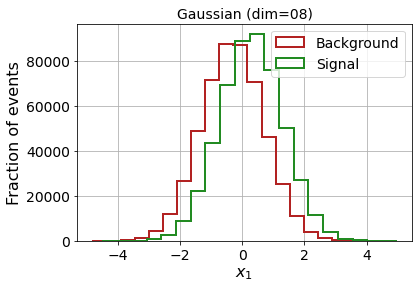

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.67074	validation_1-logloss:0.67098
[1]	validation_0-logloss:0.65088	validation_1-logloss:0.65118
[2]	validation_0-logloss:0.63328	validation_1-logloss:0.63376
[3]	validation_0-logloss:0.61751	validation_1-logloss:0.61812
[4]	validation_0-logloss:0.60346	validation_1-logloss:0.60422
[5]	validation_0-logloss:0.59080	validation_1-logloss:0.59166
[6]	validation_0-logloss:0.57943	validation_1-logloss:0.58041
[7]	validation_0-logloss:0.56905	validation_1-logloss:0.57016
[8]	validation_0-logloss:0.55959	validation_1-logloss:0.56080
[9]	validation_0-logloss:0.55096	validation_1-logloss:0.55223
[10]	validation_0-logloss:0.54304	validation_1-logloss:0.54440
[11]	validation_0-logloss:0.53583	validation_1-logloss:0.53728
[12]	validation_0-logloss:0.52914	validation_1-logloss:0.53064
[13]	validation_0-logloss:0.52302	validation_1-logloss:0.52460
[14]	validation_0-logloss:0.51735	validation_1-logloss:0.51899
[15]	validation_0-logloss:0.51212	validation_1-logloss:0.51380
[1

[130]	validation_0-logloss:0.42352	validation_1-logloss:0.42841
[131]	validation_0-logloss:0.42347	validation_1-logloss:0.42839
[132]	validation_0-logloss:0.42343	validation_1-logloss:0.42837
[133]	validation_0-logloss:0.42340	validation_1-logloss:0.42835
[134]	validation_0-logloss:0.42336	validation_1-logloss:0.42834
[135]	validation_0-logloss:0.42333	validation_1-logloss:0.42832
[136]	validation_0-logloss:0.42329	validation_1-logloss:0.42830
[137]	validation_0-logloss:0.42326	validation_1-logloss:0.42828
[138]	validation_0-logloss:0.42323	validation_1-logloss:0.42827
[139]	validation_0-logloss:0.42319	validation_1-logloss:0.42825
[140]	validation_0-logloss:0.42316	validation_1-logloss:0.42824
[141]	validation_0-logloss:0.42313	validation_1-logloss:0.42823
[142]	validation_0-logloss:0.42310	validation_1-logloss:0.42822
[143]	validation_0-logloss:0.42307	validation_1-logloss:0.42820
[144]	validation_0-logloss:0.42304	validation_1-logloss:0.42819
[145]	validation_0-logloss:0.42301	valid

[259]	validation_0-logloss:0.42137	validation_1-logloss:0.42796
[260]	validation_0-logloss:0.42136	validation_1-logloss:0.42796
[261]	validation_0-logloss:0.42135	validation_1-logloss:0.42796
[262]	validation_0-logloss:0.42133	validation_1-logloss:0.42796
[263]	validation_0-logloss:0.42132	validation_1-logloss:0.42796
[264]	validation_0-logloss:0.42131	validation_1-logloss:0.42796
[265]	validation_0-logloss:0.42130	validation_1-logloss:0.42796
[266]	validation_0-logloss:0.42130	validation_1-logloss:0.42796
[267]	validation_0-logloss:0.42128	validation_1-logloss:0.42796
[268]	validation_0-logloss:0.42127	validation_1-logloss:0.42796
[269]	validation_0-logloss:0.42126	validation_1-logloss:0.42796
[270]	validation_0-logloss:0.42124	validation_1-logloss:0.42796
[271]	validation_0-logloss:0.42124	validation_1-logloss:0.42796
[272]	validation_0-logloss:0.42123	validation_1-logloss:0.42796
[273]	validation_0-logloss:0.42122	validation_1-logloss:0.42796
[274]	validation_0-logloss:0.42121	valid

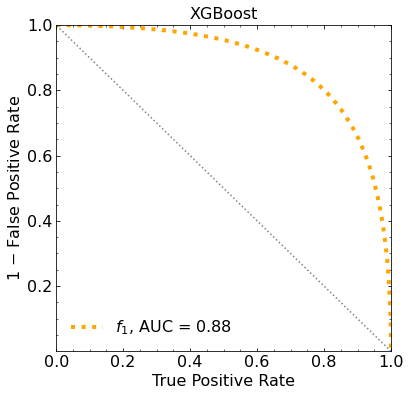

ML iteration 0
[0]	validation_0-logloss:0.66923	validation_1-logloss:0.67048


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	validation_0-logloss:0.64821	validation_1-logloss:0.65037
[2]	validation_0-logloss:0.62955	validation_1-logloss:0.63267
[3]	validation_0-logloss:0.61301	validation_1-logloss:0.61689
[4]	validation_0-logloss:0.59808	validation_1-logloss:0.60277
[5]	validation_0-logloss:0.58466	validation_1-logloss:0.59010
[6]	validation_0-logloss:0.57254	validation_1-logloss:0.57862
[7]	validation_0-logloss:0.56150	validation_1-logloss:0.56830
[8]	validation_0-logloss:0.55142	validation_1-logloss:0.55883
[9]	validation_0-logloss:0.54221	validation_1-logloss:0.55012
[10]	validation_0-logloss:0.53378	validation_1-logloss:0.54226
[11]	validation_0-logloss:0.52614	validation_1-logloss:0.53510
[12]	validation_0-logloss:0.51909	validation_1-logloss:0.52853
[13]	validation_0-logloss:0.51268	validation_1-logloss:0.52258
[14]	validation_0-logloss:0.50670	validation_1-logloss:0.51698
[15]	validation_0-logloss:0.50105	validation_1-logloss:0.51175
[16]	validation_0-logloss:0.49583	validation_1-logloss:0.50699
[

[131]	validation_0-logloss:0.40112	validation_1-logloss:0.43154
[132]	validation_0-logloss:0.40098	validation_1-logloss:0.43154
[133]	validation_0-logloss:0.40085	validation_1-logloss:0.43152
[134]	validation_0-logloss:0.40078	validation_1-logloss:0.43151
[135]	validation_0-logloss:0.40073	validation_1-logloss:0.43151
[136]	validation_0-logloss:0.40064	validation_1-logloss:0.43150
[137]	validation_0-logloss:0.40051	validation_1-logloss:0.43150
[138]	validation_0-logloss:0.40039	validation_1-logloss:0.43150
[139]	validation_0-logloss:0.40029	validation_1-logloss:0.43150
[140]	validation_0-logloss:0.40023	validation_1-logloss:0.43150
[141]	validation_0-logloss:0.40017	validation_1-logloss:0.43150
[142]	validation_0-logloss:0.40003	validation_1-logloss:0.43151
[143]	validation_0-logloss:0.39992	validation_1-logloss:0.43150
[144]	validation_0-logloss:0.39981	validation_1-logloss:0.43151
[145]	validation_0-logloss:0.39973	validation_1-logloss:0.43150
[146]	validation_0-logloss:0.39968	valid

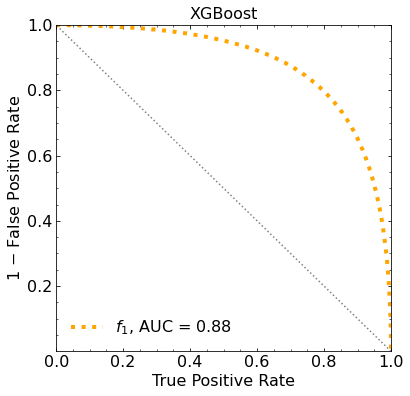

ML iteration  1


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.66961	validation_1-logloss:0.67061
[1]	validation_0-logloss:0.64875	validation_1-logloss:0.65066
[2]	validation_0-logloss:0.63031	validation_1-logloss:0.63301
[3]	validation_0-logloss:0.61394	validation_1-logloss:0.61731
[4]	validation_0-logloss:0.59933	validation_1-logloss:0.60330
[5]	validation_0-logloss:0.58614	validation_1-logloss:0.59074
[6]	validation_0-logloss:0.57412	validation_1-logloss:0.57930
[7]	validation_0-logloss:0.56329	validation_1-logloss:0.56894
[8]	validation_0-logloss:0.55348	validation_1-logloss:0.55957
[9]	validation_0-logloss:0.54443	validation_1-logloss:0.55101
[10]	validation_0-logloss:0.53609	validation_1-logloss:0.54325
[11]	validation_0-logloss:0.52844	validation_1-logloss:0.53601
[12]	validation_0-logloss:0.52144	validation_1-logloss:0.52940
[13]	validation_0-logloss:0.51498	validation_1-logloss:0.52340
[14]	validation_0-logloss:0.50897	validation_1-logloss:0.51777
[15]	validation_0-logloss:0.50338	validation_1-logloss:0.51246
[1

[130]	validation_0-logloss:0.40310	validation_1-logloss:0.43152
[131]	validation_0-logloss:0.40302	validation_1-logloss:0.43151
[132]	validation_0-logloss:0.40289	validation_1-logloss:0.43150
[133]	validation_0-logloss:0.40275	validation_1-logloss:0.43150
[134]	validation_0-logloss:0.40263	validation_1-logloss:0.43149
[135]	validation_0-logloss:0.40256	validation_1-logloss:0.43149
[136]	validation_0-logloss:0.40245	validation_1-logloss:0.43148
[137]	validation_0-logloss:0.40237	validation_1-logloss:0.43148
[138]	validation_0-logloss:0.40226	validation_1-logloss:0.43147
[139]	validation_0-logloss:0.40216	validation_1-logloss:0.43147
[140]	validation_0-logloss:0.40212	validation_1-logloss:0.43147
[141]	validation_0-logloss:0.40199	validation_1-logloss:0.43147
[142]	validation_0-logloss:0.40193	validation_1-logloss:0.43147
[143]	validation_0-logloss:0.40186	validation_1-logloss:0.43146
[144]	validation_0-logloss:0.40172	validation_1-logloss:0.43146
[145]	validation_0-logloss:0.40160	valid

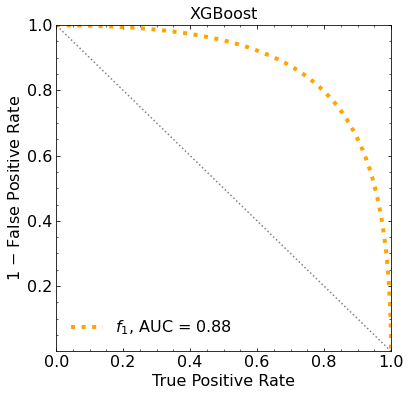

ML iteration  2


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.66947	validation_1-logloss:0.67054
[1]	validation_0-logloss:0.64857	validation_1-logloss:0.65045
[2]	validation_0-logloss:0.63013	validation_1-logloss:0.63277
[3]	validation_0-logloss:0.61355	validation_1-logloss:0.61699
[4]	validation_0-logloss:0.59880	validation_1-logloss:0.60283
[5]	validation_0-logloss:0.58551	validation_1-logloss:0.59015
[6]	validation_0-logloss:0.57334	validation_1-logloss:0.57873
[7]	validation_0-logloss:0.56224	validation_1-logloss:0.56826
[8]	validation_0-logloss:0.55221	validation_1-logloss:0.55886
[9]	validation_0-logloss:0.54309	validation_1-logloss:0.55019
[10]	validation_0-logloss:0.53462	validation_1-logloss:0.54232
[11]	validation_0-logloss:0.52690	validation_1-logloss:0.53509
[12]	validation_0-logloss:0.51987	validation_1-logloss:0.52859
[13]	validation_0-logloss:0.51329	validation_1-logloss:0.52242
[14]	validation_0-logloss:0.50727	validation_1-logloss:0.51681
[15]	validation_0-logloss:0.50163	validation_1-logloss:0.51162
[1

[130]	validation_0-logloss:0.40043	validation_1-logloss:0.43150
[131]	validation_0-logloss:0.40037	validation_1-logloss:0.43149
[132]	validation_0-logloss:0.40027	validation_1-logloss:0.43149
[133]	validation_0-logloss:0.40016	validation_1-logloss:0.43149
[134]	validation_0-logloss:0.40000	validation_1-logloss:0.43148
[135]	validation_0-logloss:0.39994	validation_1-logloss:0.43148
[136]	validation_0-logloss:0.39989	validation_1-logloss:0.43147
[137]	validation_0-logloss:0.39981	validation_1-logloss:0.43147
[138]	validation_0-logloss:0.39968	validation_1-logloss:0.43148
[139]	validation_0-logloss:0.39958	validation_1-logloss:0.43148
[140]	validation_0-logloss:0.39947	validation_1-logloss:0.43149
[141]	validation_0-logloss:0.39941	validation_1-logloss:0.43149
[142]	validation_0-logloss:0.39930	validation_1-logloss:0.43149
[143]	validation_0-logloss:0.39926	validation_1-logloss:0.43149
[144]	validation_0-logloss:0.39919	validation_1-logloss:0.43149
[145]	validation_0-logloss:0.39914	valid

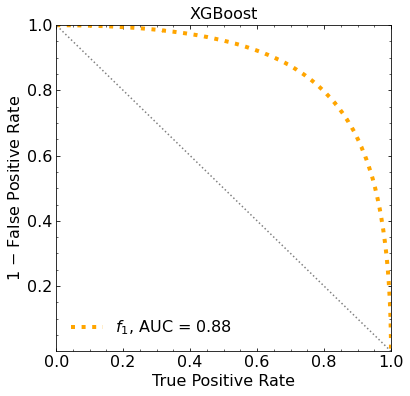

ML iteration  3


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.66962	validation_1-logloss:0.67067
[1]	validation_0-logloss:0.64892	validation_1-logloss:0.65066
[2]	validation_0-logloss:0.63051	validation_1-logloss:0.63304
[3]	validation_0-logloss:0.61397	validation_1-logloss:0.61715
[4]	validation_0-logloss:0.59927	validation_1-logloss:0.60315
[5]	validation_0-logloss:0.58588	validation_1-logloss:0.59055
[6]	validation_0-logloss:0.57394	validation_1-logloss:0.57912
[7]	validation_0-logloss:0.56288	validation_1-logloss:0.56870
[8]	validation_0-logloss:0.55297	validation_1-logloss:0.55932
[9]	validation_0-logloss:0.54375	validation_1-logloss:0.55062
[10]	validation_0-logloss:0.53529	validation_1-logloss:0.54278
[11]	validation_0-logloss:0.52766	validation_1-logloss:0.53551
[12]	validation_0-logloss:0.52054	validation_1-logloss:0.52888
[13]	validation_0-logloss:0.51404	validation_1-logloss:0.52283
[14]	validation_0-logloss:0.50806	validation_1-logloss:0.51723
[15]	validation_0-logloss:0.50247	validation_1-logloss:0.51207
[1

[130]	validation_0-logloss:0.40341	validation_1-logloss:0.43163
[131]	validation_0-logloss:0.40334	validation_1-logloss:0.43162
[132]	validation_0-logloss:0.40325	validation_1-logloss:0.43161
[133]	validation_0-logloss:0.40318	validation_1-logloss:0.43161
[134]	validation_0-logloss:0.40311	validation_1-logloss:0.43161
[135]	validation_0-logloss:0.40304	validation_1-logloss:0.43160
[136]	validation_0-logloss:0.40292	validation_1-logloss:0.43160
[137]	validation_0-logloss:0.40281	validation_1-logloss:0.43159
[138]	validation_0-logloss:0.40268	validation_1-logloss:0.43159
[139]	validation_0-logloss:0.40256	validation_1-logloss:0.43160
[140]	validation_0-logloss:0.40246	validation_1-logloss:0.43160
[141]	validation_0-logloss:0.40241	validation_1-logloss:0.43160
[142]	validation_0-logloss:0.40228	validation_1-logloss:0.43161
[143]	validation_0-logloss:0.40220	validation_1-logloss:0.43161
[144]	validation_0-logloss:0.40214	validation_1-logloss:0.43160
[145]	validation_0-logloss:0.40203	valid

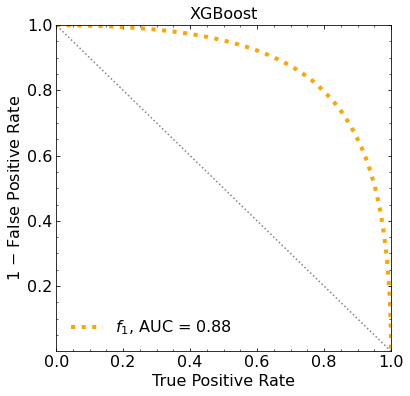

ML iteration  4


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.66981	validation_1-logloss:0.67057
[1]	validation_0-logloss:0.64960	validation_1-logloss:0.65105
[2]	validation_0-logloss:0.63124	validation_1-logloss:0.63331
[3]	validation_0-logloss:0.61508	validation_1-logloss:0.61765
[4]	validation_0-logloss:0.60050	validation_1-logloss:0.60357
[5]	validation_0-logloss:0.58737	validation_1-logloss:0.59103
[6]	validation_0-logloss:0.57555	validation_1-logloss:0.57971
[7]	validation_0-logloss:0.56479	validation_1-logloss:0.56937
[8]	validation_0-logloss:0.55500	validation_1-logloss:0.55993
[9]	validation_0-logloss:0.54609	validation_1-logloss:0.55144
[10]	validation_0-logloss:0.53788	validation_1-logloss:0.54367
[11]	validation_0-logloss:0.53030	validation_1-logloss:0.53654
[12]	validation_0-logloss:0.52330	validation_1-logloss:0.52989
[13]	validation_0-logloss:0.51684	validation_1-logloss:0.52385
[14]	validation_0-logloss:0.51083	validation_1-logloss:0.51816
[15]	validation_0-logloss:0.50534	validation_1-logloss:0.51300
[1

[130]	validation_0-logloss:0.40546	validation_1-logloss:0.43146
[131]	validation_0-logloss:0.40538	validation_1-logloss:0.43145
[132]	validation_0-logloss:0.40524	validation_1-logloss:0.43145
[133]	validation_0-logloss:0.40511	validation_1-logloss:0.43144
[134]	validation_0-logloss:0.40497	validation_1-logloss:0.43144
[135]	validation_0-logloss:0.40482	validation_1-logloss:0.43143
[136]	validation_0-logloss:0.40472	validation_1-logloss:0.43144
[137]	validation_0-logloss:0.40464	validation_1-logloss:0.43144
[138]	validation_0-logloss:0.40450	validation_1-logloss:0.43143
[139]	validation_0-logloss:0.40443	validation_1-logloss:0.43144
[140]	validation_0-logloss:0.40432	validation_1-logloss:0.43143
[141]	validation_0-logloss:0.40420	validation_1-logloss:0.43143
[142]	validation_0-logloss:0.40409	validation_1-logloss:0.43143
[143]	validation_0-logloss:0.40401	validation_1-logloss:0.43142
[144]	validation_0-logloss:0.40394	validation_1-logloss:0.43142
[145]	validation_0-logloss:0.40384	valid

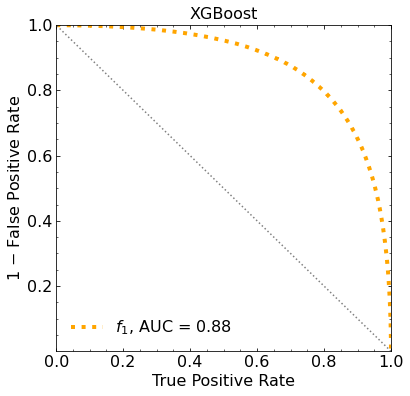

ML iteration  5


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.66951	validation_1-logloss:0.67045
[1]	validation_0-logloss:0.64883	validation_1-logloss:0.65063
[2]	validation_0-logloss:0.63053	validation_1-logloss:0.63300
[3]	validation_0-logloss:0.61429	validation_1-logloss:0.61741
[4]	validation_0-logloss:0.59966	validation_1-logloss:0.60338
[5]	validation_0-logloss:0.58643	validation_1-logloss:0.59075
[6]	validation_0-logloss:0.57451	validation_1-logloss:0.57939
[7]	validation_0-logloss:0.56377	validation_1-logloss:0.56918
[8]	validation_0-logloss:0.55389	validation_1-logloss:0.55980
[9]	validation_0-logloss:0.54478	validation_1-logloss:0.55117
[10]	validation_0-logloss:0.53646	validation_1-logloss:0.54332
[11]	validation_0-logloss:0.52883	validation_1-logloss:0.53608
[12]	validation_0-logloss:0.52181	validation_1-logloss:0.52951
[13]	validation_0-logloss:0.51536	validation_1-logloss:0.52342
[14]	validation_0-logloss:0.50938	validation_1-logloss:0.51789
[15]	validation_0-logloss:0.50386	validation_1-logloss:0.51271
[1

[130]	validation_0-logloss:0.40458	validation_1-logloss:0.43170
[131]	validation_0-logloss:0.40450	validation_1-logloss:0.43168
[132]	validation_0-logloss:0.40439	validation_1-logloss:0.43169
[133]	validation_0-logloss:0.40432	validation_1-logloss:0.43168
[134]	validation_0-logloss:0.40426	validation_1-logloss:0.43167
[135]	validation_0-logloss:0.40419	validation_1-logloss:0.43167
[136]	validation_0-logloss:0.40413	validation_1-logloss:0.43167
[137]	validation_0-logloss:0.40406	validation_1-logloss:0.43167
[138]	validation_0-logloss:0.40395	validation_1-logloss:0.43166
[139]	validation_0-logloss:0.40382	validation_1-logloss:0.43167
[140]	validation_0-logloss:0.40370	validation_1-logloss:0.43166
[141]	validation_0-logloss:0.40358	validation_1-logloss:0.43166
[142]	validation_0-logloss:0.40347	validation_1-logloss:0.43166
[143]	validation_0-logloss:0.40336	validation_1-logloss:0.43165
[144]	validation_0-logloss:0.40327	validation_1-logloss:0.43165
[145]	validation_0-logloss:0.40316	valid

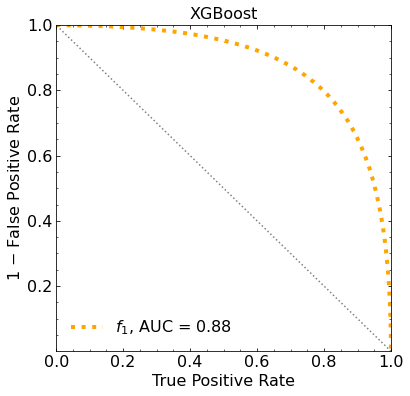

ML iteration  6


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.66965	validation_1-logloss:0.67047
[1]	validation_0-logloss:0.64893	validation_1-logloss:0.65056
[2]	validation_0-logloss:0.63062	validation_1-logloss:0.63300
[3]	validation_0-logloss:0.61443	validation_1-logloss:0.61736
[4]	validation_0-logloss:0.59976	validation_1-logloss:0.60332
[5]	validation_0-logloss:0.58659	validation_1-logloss:0.59076
[6]	validation_0-logloss:0.57464	validation_1-logloss:0.57934
[7]	validation_0-logloss:0.56379	validation_1-logloss:0.56897
[8]	validation_0-logloss:0.55388	validation_1-logloss:0.55962
[9]	validation_0-logloss:0.54480	validation_1-logloss:0.55100
[10]	validation_0-logloss:0.53648	validation_1-logloss:0.54306
[11]	validation_0-logloss:0.52889	validation_1-logloss:0.53584
[12]	validation_0-logloss:0.52189	validation_1-logloss:0.52922
[13]	validation_0-logloss:0.51545	validation_1-logloss:0.52320
[14]	validation_0-logloss:0.50937	validation_1-logloss:0.51753
[15]	validation_0-logloss:0.50384	validation_1-logloss:0.51237
[1

[130]	validation_0-logloss:0.40284	validation_1-logloss:0.43144
[131]	validation_0-logloss:0.40268	validation_1-logloss:0.43143
[132]	validation_0-logloss:0.40254	validation_1-logloss:0.43142
[133]	validation_0-logloss:0.40246	validation_1-logloss:0.43142
[134]	validation_0-logloss:0.40232	validation_1-logloss:0.43142
[135]	validation_0-logloss:0.40227	validation_1-logloss:0.43142
[136]	validation_0-logloss:0.40221	validation_1-logloss:0.43142
[137]	validation_0-logloss:0.40213	validation_1-logloss:0.43142
[138]	validation_0-logloss:0.40205	validation_1-logloss:0.43143
[139]	validation_0-logloss:0.40191	validation_1-logloss:0.43143
[140]	validation_0-logloss:0.40182	validation_1-logloss:0.43143
[141]	validation_0-logloss:0.40173	validation_1-logloss:0.43143
[142]	validation_0-logloss:0.40158	validation_1-logloss:0.43144
[143]	validation_0-logloss:0.40146	validation_1-logloss:0.43144
[144]	validation_0-logloss:0.40138	validation_1-logloss:0.43144
[145]	validation_0-logloss:0.40122	valid

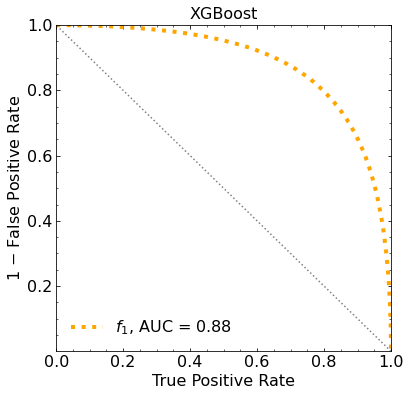

ML iteration  7


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.66971	validation_1-logloss:0.67061
[1]	validation_0-logloss:0.64908	validation_1-logloss:0.65083
[2]	validation_0-logloss:0.63077	validation_1-logloss:0.63323
[3]	validation_0-logloss:0.61432	validation_1-logloss:0.61735
[4]	validation_0-logloss:0.59965	validation_1-logloss:0.60333
[5]	validation_0-logloss:0.58641	validation_1-logloss:0.59054
[6]	validation_0-logloss:0.57452	validation_1-logloss:0.57921
[7]	validation_0-logloss:0.56353	validation_1-logloss:0.56873
[8]	validation_0-logloss:0.55365	validation_1-logloss:0.55928
[9]	validation_0-logloss:0.54471	validation_1-logloss:0.55088
[10]	validation_0-logloss:0.53645	validation_1-logloss:0.54301
[11]	validation_0-logloss:0.52881	validation_1-logloss:0.53583
[12]	validation_0-logloss:0.52176	validation_1-logloss:0.52925
[13]	validation_0-logloss:0.51520	validation_1-logloss:0.52305
[14]	validation_0-logloss:0.50920	validation_1-logloss:0.51751
[15]	validation_0-logloss:0.50366	validation_1-logloss:0.51236
[1

[130]	validation_0-logloss:0.40310	validation_1-logloss:0.43131
[131]	validation_0-logloss:0.40302	validation_1-logloss:0.43132
[132]	validation_0-logloss:0.40294	validation_1-logloss:0.43132
[133]	validation_0-logloss:0.40282	validation_1-logloss:0.43130
[134]	validation_0-logloss:0.40269	validation_1-logloss:0.43129
[135]	validation_0-logloss:0.40263	validation_1-logloss:0.43129
[136]	validation_0-logloss:0.40256	validation_1-logloss:0.43128
[137]	validation_0-logloss:0.40246	validation_1-logloss:0.43129
[138]	validation_0-logloss:0.40238	validation_1-logloss:0.43128
[139]	validation_0-logloss:0.40224	validation_1-logloss:0.43129
[140]	validation_0-logloss:0.40214	validation_1-logloss:0.43129
[141]	validation_0-logloss:0.40202	validation_1-logloss:0.43128
[142]	validation_0-logloss:0.40194	validation_1-logloss:0.43128
[143]	validation_0-logloss:0.40184	validation_1-logloss:0.43128
[144]	validation_0-logloss:0.40177	validation_1-logloss:0.43129
[145]	validation_0-logloss:0.40171	valid

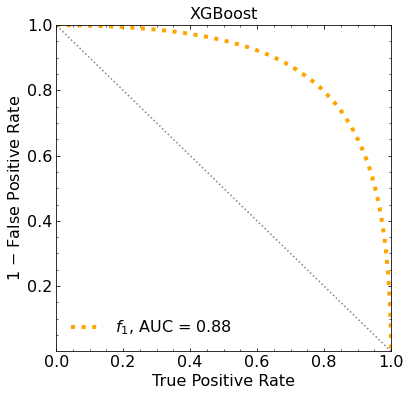

ML iteration  8


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.66939	validation_1-logloss:0.67052
[1]	validation_0-logloss:0.64851	validation_1-logloss:0.65051
[2]	validation_0-logloss:0.63012	validation_1-logloss:0.63282
[3]	validation_0-logloss:0.61352	validation_1-logloss:0.61711
[4]	validation_0-logloss:0.59876	validation_1-logloss:0.60306
[5]	validation_0-logloss:0.58555	validation_1-logloss:0.59049
[6]	validation_0-logloss:0.57358	validation_1-logloss:0.57906
[7]	validation_0-logloss:0.56275	validation_1-logloss:0.56876
[8]	validation_0-logloss:0.55274	validation_1-logloss:0.55919
[9]	validation_0-logloss:0.54360	validation_1-logloss:0.55058
[10]	validation_0-logloss:0.53533	validation_1-logloss:0.54277
[11]	validation_0-logloss:0.52771	validation_1-logloss:0.53562
[12]	validation_0-logloss:0.52055	validation_1-logloss:0.52893
[13]	validation_0-logloss:0.51398	validation_1-logloss:0.52282
[14]	validation_0-logloss:0.50797	validation_1-logloss:0.51720
[15]	validation_0-logloss:0.50240	validation_1-logloss:0.51204
[1

[130]	validation_0-logloss:0.40107	validation_1-logloss:0.43155
[131]	validation_0-logloss:0.40099	validation_1-logloss:0.43154
[132]	validation_0-logloss:0.40092	validation_1-logloss:0.43154
[133]	validation_0-logloss:0.40076	validation_1-logloss:0.43152
[134]	validation_0-logloss:0.40067	validation_1-logloss:0.43152
[135]	validation_0-logloss:0.40050	validation_1-logloss:0.43151
[136]	validation_0-logloss:0.40044	validation_1-logloss:0.43151
[137]	validation_0-logloss:0.40038	validation_1-logloss:0.43151
[138]	validation_0-logloss:0.40028	validation_1-logloss:0.43152
[139]	validation_0-logloss:0.40020	validation_1-logloss:0.43152
[140]	validation_0-logloss:0.40011	validation_1-logloss:0.43151
[141]	validation_0-logloss:0.39999	validation_1-logloss:0.43151
[142]	validation_0-logloss:0.39991	validation_1-logloss:0.43152
[143]	validation_0-logloss:0.39984	validation_1-logloss:0.43152
[144]	validation_0-logloss:0.39971	validation_1-logloss:0.43153
[145]	validation_0-logloss:0.39959	valid

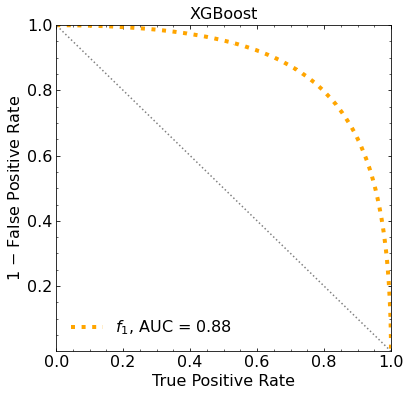

ML iteration  9


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.66970	validation_1-logloss:0.67080
[1]	validation_0-logloss:0.64906	validation_1-logloss:0.65087
[2]	validation_0-logloss:0.63069	validation_1-logloss:0.63319
[3]	validation_0-logloss:0.61440	validation_1-logloss:0.61751
[4]	validation_0-logloss:0.59981	validation_1-logloss:0.60363
[5]	validation_0-logloss:0.58670	validation_1-logloss:0.59095
[6]	validation_0-logloss:0.57470	validation_1-logloss:0.57945
[7]	validation_0-logloss:0.56373	validation_1-logloss:0.56903
[8]	validation_0-logloss:0.55380	validation_1-logloss:0.55965
[9]	validation_0-logloss:0.54466	validation_1-logloss:0.55103
[10]	validation_0-logloss:0.53629	validation_1-logloss:0.54317
[11]	validation_0-logloss:0.52867	validation_1-logloss:0.53596
[12]	validation_0-logloss:0.52160	validation_1-logloss:0.52924
[13]	validation_0-logloss:0.51508	validation_1-logloss:0.52311
[14]	validation_0-logloss:0.50906	validation_1-logloss:0.51751
[15]	validation_0-logloss:0.50349	validation_1-logloss:0.51239
[1

[130]	validation_0-logloss:0.40312	validation_1-logloss:0.43141
[131]	validation_0-logloss:0.40301	validation_1-logloss:0.43140
[132]	validation_0-logloss:0.40294	validation_1-logloss:0.43139
[133]	validation_0-logloss:0.40284	validation_1-logloss:0.43139
[134]	validation_0-logloss:0.40275	validation_1-logloss:0.43138
[135]	validation_0-logloss:0.40260	validation_1-logloss:0.43138
[136]	validation_0-logloss:0.40250	validation_1-logloss:0.43138
[137]	validation_0-logloss:0.40244	validation_1-logloss:0.43138
[138]	validation_0-logloss:0.40235	validation_1-logloss:0.43136
[139]	validation_0-logloss:0.40225	validation_1-logloss:0.43136
[140]	validation_0-logloss:0.40217	validation_1-logloss:0.43136
[141]	validation_0-logloss:0.40206	validation_1-logloss:0.43136
[142]	validation_0-logloss:0.40199	validation_1-logloss:0.43135
[143]	validation_0-logloss:0.40189	validation_1-logloss:0.43134
[144]	validation_0-logloss:0.40177	validation_1-logloss:0.43133
[145]	validation_0-logloss:0.40172	valid

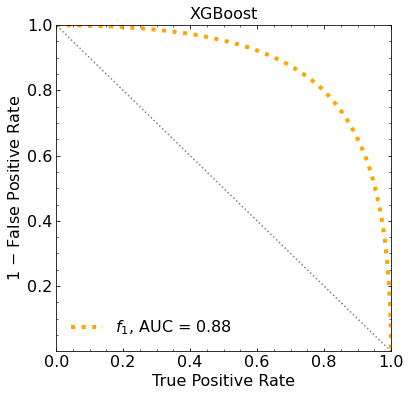

Classification score (1 ML):


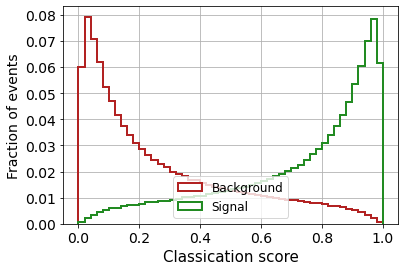

Classification score (10 ML):


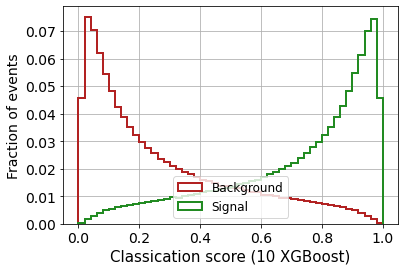

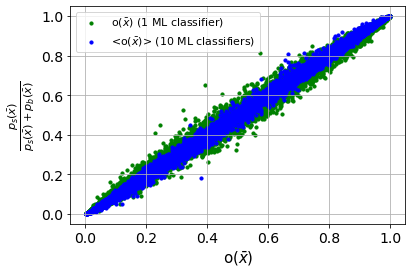


 ----------------------------------------- 

B_expected:  50000
S_expected:  500
S/$\sqrt{B}$:  2.23606797749979
 BINNED CLASSIFIER OUTPUT
  BL lineal bins, 1 ML
Z_XG 10 bins_1ML:  6.155894288660288
Z_XG 25 bins_1ML:  6.901790709822784
Z_XG 50 bins_1ML:  7.166756016270591
Z_XG 100 bins_1ML:  7.2381028465781885

 BL non-lineal bins, 1 ML
Z_XG 10 bins_eq_1ML:  4.703552239297094
Z_XG 25 bins_eq_1ML:  5.512247681875036
Z_XG 50 bins_eq_1ML:  6.013131112185583
Z_XG 100 bins_eq_1ML:  6.4058030613640815

 BL lineal bins, 10 ML
Z_XG 10 bins:  6.248488073992465
Z_XG 25 bins:  6.976191014078722
Z_XG 50 bins:  7.213159740698417
Z_XG 100 bins:  7.305117083546187

 BL non-lineal bins, 10 ML
Z_XG 10 bins_eq:  4.714398815095263
Z_XG 25 bins_eq:  5.527651195590223
Z_XG 50 bins_eq:  6.029743792953416
Z_XG 100 bins_eq:  6.4250881549127445

 ----------------------------------------- 


 If  20200  =  1101    then the proposed range has to be extended
n_ensembles (actual):  9863
TRUE PDF LIKELIHOOD (GAUSS

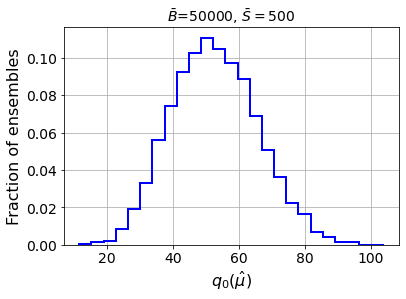

muhat mean:  0.0794687214843354
Z_gaussian:  7.222255752230113
Z_gaussian_mu0:  7.217424636946165

 ------------------------------------ 

 MLL + KDE (1ML) 


/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf  1350.25116373
  1356.43988061  1359.64847843  1358.01615308  1350.26651985
  1336.14755661  1311.03303634  1266.23110985  1195.89876519
  1088.27337423   932.22639977   714.48987755   417.1066457
    27.89316849  -472.19140667 -1110.08679643 -2039.15692219]
  warnings.warn(
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:929: RuntimeWarning: invalid value encountered in subtract
  array_stds = np.sqrt(np.average((array -
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf  1374.23243202
  1379.93559843  1384.01640034  1381.89821796  1372.88433285
  1353.97454921  1324.06491743  1277.18831234  1205.86574757
  109

KDE Kernel:  epanechnikov
Background bandwidth:  0.0063479219593504735
Signal bandwidth:  0.0063479219593504735


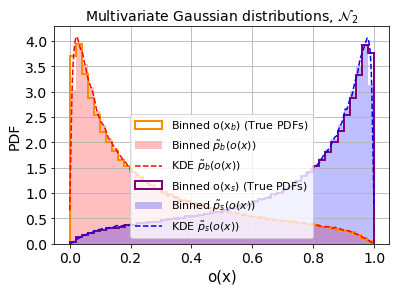

 MLL + KDE (10ML) 


/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
  1322.05429031  1325.27352552  1325.58121907  1321.61160668
  1311.14968699  1288.90772002  1248.44788501  1185.37883093
  1086.75445572   939.06117681   729.82099824   444.33425139
    64.69455113  -428.69166052 -1073.17187858 -2023.0411041 ]
  warnings.warn(
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:929: RuntimeWarning: invalid value encountered in subtract
  array_stds = np.sqrt(np.average((array -
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf  1347.39574457
  1351.89498849  1354.67128366  1354.16816753  1348.52968114
  1334.58176542  1309.79292746  1268.99956934  1203.80130502
  11

KDE Kernel:  epanechnikov
Background bandwidth:  0.0091866653175426
Signal bandwidth:  0.0063479219593504735


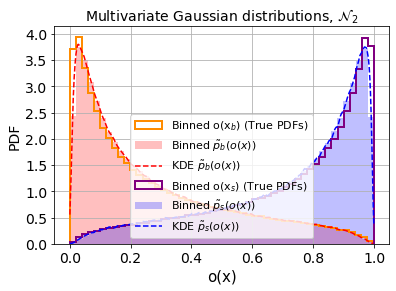

 Z MLL+KDE (1ML) 


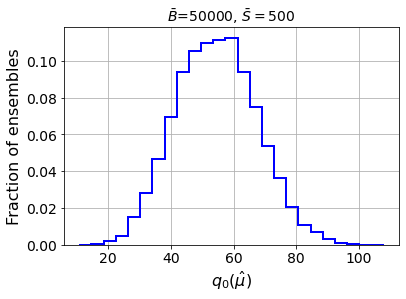

muhat mean_1ML:  0.04504714589881375
Z_KDE_1ML:  7.367425661749616
Z_KDE mu=0_1ML:  7.368134241132425

 Z MLL+KDE (10ML) 


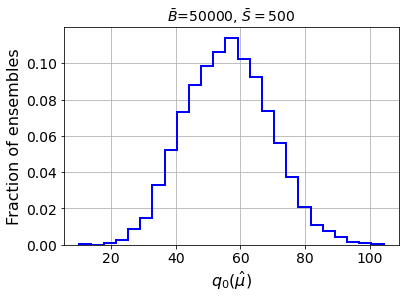

muhat mean:  0.03972422183919701
Z_KDE:  7.489616001001936
Z_KDE mu=0:  7.489616001001936

 ------------------------------------ 



In [124]:
dim=8

#######################
# generate the events #
#######################
    
mean_sig = epsilon*np.ones(dim)
mean_bkg = -1*mean_sig

#cov_sig = np.identity(dim)
cov_sig = np.identity(dim) + (0. * ( np.ones((dim,dim)) - np.identity(dim) ))
cov_bkg = cov_sig

signal_X_1, signal_X_2, signal_X_3, signal_X_4, signal_X_5, signal_X_6, signal_X_7, signal_X_8 = np.random.multivariate_normal(mean_sig, cov_sig, N).T
background_X_1, background_X_2, background_X_3, background_X_4, background_X_5, background_X_6, background_X_7, background_X_8 = np.random.multivariate_normal(mean_bkg, cov_bkg, N).T


dim1 = np.concatenate((background_X_1,signal_X_1))
dim2 = np.concatenate((background_X_2,signal_X_2))
dim3 = np.concatenate((background_X_3,signal_X_3))
dim4 = np.concatenate((background_X_4,signal_X_4))
dim5 = np.concatenate((background_X_5,signal_X_5))
dim6 = np.concatenate((background_X_6,signal_X_6))
dim7 = np.concatenate((background_X_7,signal_X_7))
dim8 = np.concatenate((background_X_8,signal_X_8))

# labels
background_Y = np.zeros(N)
signal_Y = np.ones(N)

# DATA in a single matrix (features + labels)
df = pd.DataFrame()
df['dim1'] = dim1.reshape(-1)
df['dim2'] = dim2.reshape(-1)
df['dim3'] = dim3.reshape(-1)
df['dim4'] = dim4.reshape(-1)
df['dim5'] = dim5.reshape(-1)
df['dim6'] = dim6.reshape(-1)
df['dim7'] = dim7.reshape(-1)
df['dim8'] = dim8.reshape(-1)
df['Y'] = np.concatenate((background_Y.astype('int'),signal_Y.astype('int')))

X_gauss = df[['dim1','dim2','dim3','dim4','dim5','dim6','dim7','dim8']].values 
Y_gauss = df[['Y']].values

# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.5

X_gauss_aux, X_gauss_test, Y_gauss_aux, Y_gauss_test = train_test_split(X_gauss,
                                                                Y_gauss,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_gauss,
                                                                shuffle=True)


X_gauss_train, X_gauss_val, Y_gauss_train, Y_gauss_val = train_test_split(X_gauss_aux,
                                                                  Y_gauss_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_gauss_aux,
                                                                  shuffle=True)

print('')
print('X_gauss_train : ', X_gauss_train.shape)
print('y_gauss_train : ', Y_gauss_train.shape)
print('X_gauss_val : ', X_gauss_val.shape)
print('y_gauss_val : ', Y_gauss_val.shape)
print('X_gauss_test : ', X_gauss_test.shape)
print('y_gauss_test : ', Y_gauss_test.shape)
print('')


# PLOT (only 1st feature) to visualize the data
X_gauss_test_SM = []
X_gauss_test_NP = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] ==0:
        X_gauss_test_SM.append(X_gauss_test[i].tolist())
    else:
        X_gauss_test_NP.append(X_gauss_test[i].tolist())    


X_gauss_test_SM = np.array(X_gauss_test_SM)
X_gauss_test_NP = np.array(X_gauss_test_NP)


weights = np.ones_like(X_gauss_test_SM[:,0])/float(len(X_gauss_test_SM[:,0]))
plt.hist(X_gauss_test_SM[:,0], 20, histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(X_gauss_test_NP[:,0])/float(len(X_gauss_test_NP[:,0]))
plt.hist(X_gauss_test_NP[:,0], 20, histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$x_1$",fontsize=16)
plt.ylabel("Fraction of events",fontsize=16)
plt.grid()
plt.legend(fontsize=14)
plt.title(r"Gaussian (dim=%0.2d)" % dim,fontsize=14)
plt.show()  






################################
# the true pdfs (useful later) #
################################

sig_multi = multivariate_normal(mean_sig, cov_sig)
bkg_multi = multivariate_normal(mean_bkg, cov_bkg) 




#######################
# CLASSIFIER: XGBoost #
#######################

# only 1 ML
roc_auc_XG, y_pred_xg_1ML = XG(X_gauss_train, X_gauss_test, X_gauss_val, Y_gauss_train, Y_gauss_test, Y_gauss_val)

store_AUC.append(roc_auc_XG)


# Bagging

print('ML iteration 0')
roc_auc_XG, y_pred_xg_aux = XG(X_gauss_train[:100000], X_gauss_test, X_gauss_val, Y_gauss_train[:100000], Y_gauss_test, Y_gauss_val)
y_pred_xg_auxRE = np.reshape(y_pred_xg_aux, (1,len(y_pred_xg_aux)))

for it in range(1,iterations_ML):

    print('ML iteration ', it)
    roc_auc_XG, y_pred_xg_aux_it = XG(X_gauss_train[(100000*it):(100000*it)+100000], X_gauss_test, X_gauss_val, Y_gauss_train[(100000*it):(100000*it)+100000], Y_gauss_test, Y_gauss_val)
    
    y_pred_xg_auxRE_it = np.reshape(y_pred_xg_aux_it, (1,len(y_pred_xg_aux_it)))
    
    y_pred_xg_auxRE = np.concatenate([y_pred_xg_auxRE,y_pred_xg_auxRE_it])

# to smooth, mean of 10 predictions
y_pred_xg = np.mean(y_pred_xg_auxRE, axis=0)




########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

# 1 ML
pred_XG_SM_1ML = []
pred_XG_NP_1ML = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] == 0:
        pred_XG_SM_1ML.append(y_pred_xg_1ML[i])
    else:
        pred_XG_NP_1ML.append(y_pred_xg_1ML[i])
        
# Bagging  
pred_XG_SM = []
pred_XG_NP = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score (1 ML):')
        
weights = np.ones_like(pred_XG_SM_1ML)/float(len(pred_XG_SM_1ML))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM_1ML, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP_1ML)/float(len(pred_XG_NP_1ML))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP_1ML, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12, loc="lower center")
plt.show()


print('Classification score (10 ML):')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (10 XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12, loc="lower center")
plt.show()




ratio_ps_pb_true = sig_multi.pdf(X_gauss_test) / ( sig_multi.pdf(X_gauss_test) + bkg_multi.pdf(X_gauss_test) )
ratio_ps_pb_true_B = sig_multi.pdf(X_gauss_test_SM) / ( sig_multi.pdf(X_gauss_test_SM) + bkg_multi.pdf(X_gauss_test_SM) )
ratio_ps_pb_true_S = sig_multi.pdf(X_gauss_test_NP) / ( sig_multi.pdf(X_gauss_test_NP) + bkg_multi.pdf(X_gauss_test_NP) )

plt.scatter(y_pred_xg_1ML[:10000], ratio_ps_pb_true[:10000], color='green', label=r'o($\bar{x}$) (1 ML classifier)', s=10)
plt.scatter(y_pred_xg[:10000], ratio_ps_pb_true[:10000], color='blue', label=r'<o($\bar{x}$)> (10 ML classifiers)', s=10)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r"o($\bar{x}$)",fontsize=15)
plt.ylabel(r"$\frac{p_s(\bar{x})}{p_s(\bar{x})+p_b(\bar{x})}$",fontsize=16)
plt.grid()
plt.legend(fontsize=11)
#plt.savefig('images/' + 'optimalclass-vs-ox.pdf', format="pdf", bbox_inches="tight")
plt.show()

print('\n ----------------------------------------- \n')






###########
# METHODS #
###########

print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)



############################
# BINNED CLASSIFIER OUTPUT #
############################

print(' BINNED CLASSIFIER OUTPUT')

print('  BL lineal bins, 1 ML')

# 10 BINS
Z_bins_XG_10bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 10, [[0,1]], linear_bins=True)
store_Z_bins_XG_10bins_1ML.append(Z_bins_XG_10bins_1ML)
print('Z_XG 10 bins_1ML: ', Z_bins_XG_10bins_1ML)

# 25 BINS
Z_bins_XG_25bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 25, [[0,1]], linear_bins=True)
store_Z_bins_XG_25bins_1ML.append(Z_bins_XG_25bins_1ML)
print('Z_XG 25 bins_1ML: ', Z_bins_XG_25bins_1ML)

# 50 BINS
Z_bins_XG_50bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 50, [[0,1]], linear_bins=True)
store_Z_bins_XG_50bins_1ML.append(Z_bins_XG_50bins_1ML)
print('Z_XG 50 bins_1ML: ', Z_bins_XG_50bins_1ML)

# 100 BINS
Z_bins_XG_100bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 100, [[0,1]], linear_bins=True)
store_Z_bins_XG_100bins_1ML.append(Z_bins_XG_100bins_1ML)
print('Z_XG 100 bins_1ML: ', Z_bins_XG_100bins_1ML)


print('\n BL non-lineal bins, 1 ML')

# 10 BINS
Z_bins_XG_10bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 10, [[0,1]], linear_bins=False)
store_Z_bins_XG_10bins_eq_1ML.append(Z_bins_XG_10bins_eq_1ML)
print('Z_XG 10 bins_eq_1ML: ', Z_bins_XG_10bins_eq_1ML)

# 25 BINS
Z_bins_XG_25bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 25, [[0,1]], linear_bins=False)
store_Z_bins_XG_25bins_eq_1ML.append(Z_bins_XG_25bins_eq_1ML)
print('Z_XG 25 bins_eq_1ML: ', Z_bins_XG_25bins_eq_1ML)

# 50 BINS
Z_bins_XG_50bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 50, [[0,1]], linear_bins=False)
store_Z_bins_XG_50bins_eq_1ML.append(Z_bins_XG_50bins_eq_1ML)
print('Z_XG 50 bins_eq_1ML: ', Z_bins_XG_50bins_eq_1ML)

# 100 BINS
Z_bins_XG_100bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 100, [[0,1]], linear_bins=False)
store_Z_bins_XG_100bins_eq_1ML.append(Z_bins_XG_100bins_eq_1ML)
print('Z_XG 100 bins_eq_1ML: ', Z_bins_XG_100bins_eq_1ML)


print('\n BL lineal bins, 10 ML')

# 10 BINS
Z_bins_XG_10bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 10, [[0,1]], linear_bins=True)
store_Z_bins_XG_10bins.append(Z_bins_XG_10bins)
print('Z_XG 10 bins: ', Z_bins_XG_10bins)

# 25 BINS
Z_bins_XG_25bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 25, [[0,1]], linear_bins=True)
store_Z_bins_XG_25bins.append(Z_bins_XG_25bins)
print('Z_XG 25 bins: ', Z_bins_XG_25bins)

# 50 BINS
Z_bins_XG_50bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 50, [[0,1]], linear_bins=True)
store_Z_bins_XG_50bins.append(Z_bins_XG_50bins)
print('Z_XG 50 bins: ', Z_bins_XG_50bins)

# 100 BINS
Z_bins_XG_100bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 100, [[0,1]], linear_bins=True)
store_Z_bins_XG_100bins.append(Z_bins_XG_100bins)
print('Z_XG 100 bins: ', Z_bins_XG_100bins)


print('\n BL non-lineal bins, 10 ML')

# 10 BINS
Z_bins_XG_10bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 10, [[0,1]], linear_bins=False)
store_Z_bins_XG_10bins_eq.append(Z_bins_XG_10bins_eq)
print('Z_XG 10 bins_eq: ', Z_bins_XG_10bins_eq)

# 25 BINS
Z_bins_XG_25bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 25, [[0,1]], linear_bins=False)
store_Z_bins_XG_25bins_eq.append(Z_bins_XG_25bins_eq)
print('Z_XG 25 bins_eq: ', Z_bins_XG_25bins_eq)

# 50 BINS
Z_bins_XG_50bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 50, [[0,1]], linear_bins=False)
store_Z_bins_XG_50bins_eq.append(Z_bins_XG_50bins_eq)
print('Z_XG 50 bins_eq: ', Z_bins_XG_50bins_eq)

# 100 BINS
Z_bins_XG_100bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 100, [[0,1]], linear_bins=False)
store_Z_bins_XG_100bins_eq.append(Z_bins_XG_100bins_eq)
print('Z_XG 100 bins_eq: ', Z_bins_XG_100bins_eq)


print('\n ----------------------------------------- \n')






###########################
# SET THE TOY EXPERIMENTS #
###########################

list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles = ensembler(B_expected, S_expected, n_ensembles)






###################################
# TRUE PDF LIKELIHOOD (GAUSSIANS) #
###################################

indices = [i for i in range(len(X_gauss_test_SM))]

prob_B_given_B = bkg_multi.pdf(X_gauss_test_SM)
prob_B_given_S = sig_multi.pdf(X_gauss_test_SM)



print('TRUE PDF LIKELIHOOD (GAUSSIANS):')

print('n_ensembles (initial): ', n_ensembles)

Z_gaussian, muhat_mean_gaussian, Z_gaussian_mu0, muhat_selected_list, q_muhat, q_muhat_mu0 = Z_MLL(B_expected, S_expected, prob_B_given_B, prob_B_given_S, list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles)

# Histogram of q_muhats

weights = np.ones_like(q_muhat)/float(len(q_muhat))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()

store_muhat_mean_gaussian.append(muhat_mean_gaussian)
store_Z_gaussian.append(Z_gaussian)

store_Z_gaussian_mu0.append(Z_gaussian_mu0)

print('muhat mean: ', muhat_mean_gaussian)
print('Z_gaussian: ', Z_gaussian)
print('Z_gaussian_mu0: ', Z_gaussian_mu0)


print('\n ------------------------------------ \n')







#########
#  KDE  #
#########  

print(' MLL + KDE (1ML) ')

kde_bkg_1ML, kde_sig_1ML, B_bandwidth_1ML, S_bandwidth_1ML = KDE_finder(pred_XG_SM_1ML, pred_XG_NP_1ML)


# range (~between 0 and 1)
min_val_1ML = np.min([np.min(pred_XG_SM_1ML),np.min(pred_XG_NP_1ML)])
max_val_1ML = np.max([np.max(pred_XG_SM_1ML),np.max(pred_XG_NP_1ML)])

s_vals_1ML = np.linspace(min_val_1ML,max_val_1ML,1000)



# evaluate the densities for each value of s (~bins)
dens_bkg_1ML = np.exp(kde_bkg_1ML.score_samples(np.c_[s_vals_1ML, np.zeros(len(s_vals_1ML)) ]) )
dens_sig_1ML = np.exp(kde_sig_1ML.score_samples(np.c_[s_vals_1ML, np.ones(len(s_vals_1ML)) ]) )



# Normalize to 1
# Area
factor_aux_SM_1ML = sum(dens_bkg_1ML*(s_vals_1ML[1]-s_vals_1ML[0]))
factor_aux_NP_1ML = sum(dens_sig_1ML*(s_vals_1ML[1]-s_vals_1ML[0]))

# normalize
dens_bkg_1ML = dens_bkg_1ML / factor_aux_SM_1ML
dens_sig_1ML = dens_sig_1ML / factor_aux_NP_1ML





# plot to check the estimation

plt.figure()

plt.hist(ratio_ps_pb_true_B,density=True,bins=50,lw=2,histtype='step',color='darkorange',alpha=1,label=r'Binned o(x$_b$) (True PDFs)')
plt.hist(pred_XG_SM_1ML,density=True,bins=50,color='red',alpha=0.25,label=r'Binned $\tilde{p}_{b}(o(x))$');
plt.plot(s_vals_1ML,dens_bkg_1ML,color='red',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');

plt.hist(ratio_ps_pb_true_S,density=True,bins=50,lw=2,histtype='step',color='purple',alpha=1,label=r'Binned o(x$_s$) (True PDFs)');
plt.hist(pred_XG_NP_1ML,density=True,bins=50,color='blue',alpha=0.25,label=r'Binned $\tilde{p}_{s}(o(x))$');
plt.plot(s_vals_1ML,dens_sig_1ML,color='blue',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("o(x)",fontsize=15)
plt.ylabel("PDF",fontsize=14)
plt.grid()
plt.legend(loc="lower center", fontsize=11, handlelength=2.5)
plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{2}$', fontsize=14)
#plt.savefig('images/' + '2gaussian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()





print(' MLL + KDE (10ML) ')

kde_bkg, kde_sig, B_bandwidth, S_bandwidth = KDE_finder(pred_XG_SM, pred_XG_NP)


# range (~between 0 and 1)
min_val = np.min([np.min(pred_XG_SM),np.min(pred_XG_NP)])
max_val = np.max([np.max(pred_XG_SM),np.max(pred_XG_NP)])

s_vals = np.linspace(min_val,max_val,1000)



# evaluate the densities for each value of s (~bins)
dens_bkg = np.exp(kde_bkg.score_samples(np.c_[s_vals, np.zeros(len(s_vals)) ]) )
dens_sig = np.exp(kde_sig.score_samples(np.c_[s_vals, np.ones(len(s_vals)) ]) )



# Normalize to 1
# Area
factor_aux_SM = sum(dens_bkg*(s_vals[1]-s_vals[0]))
factor_aux_NP = sum(dens_sig*(s_vals[1]-s_vals[0]))

# normalize
dens_bkg = dens_bkg / factor_aux_SM
dens_sig = dens_sig / factor_aux_NP





# plot to check the estimation

plt.figure()

plt.hist(ratio_ps_pb_true_B,density=True,bins=50,lw=2,histtype='step',color='darkorange',alpha=1,label=r'Binned o(x$_b$) (True PDFs)')
plt.hist(pred_XG_SM,density=True,bins=50,color='red',alpha=0.25,label=r'Binned $\tilde{p}_{b}(o(x))$');
plt.plot(s_vals,dens_bkg,color='red',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');

plt.hist(ratio_ps_pb_true_S,density=True,bins=50,lw=2,histtype='step',color='purple',alpha=1,label=r'Binned o(x$_s$) (True PDFs)');
plt.hist(pred_XG_NP,density=True,bins=50,color='blue',alpha=0.25,label=r'Binned $\tilde{p}_{s}(o(x))$');
plt.plot(s_vals,dens_sig,color='blue',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("o(x)",fontsize=15)
plt.ylabel("PDF",fontsize=14)
plt.grid()
plt.legend(loc="lower center", fontsize=11, handlelength=2.5)
plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{2}$', fontsize=14)
#plt.savefig('images/' + '2gaussian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()






#############
# MLL + KDE #
#############

print(' Z MLL+KDE (1ML) ')
# FOR EXCLUSION:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

KDE_SM_pred_SM_1ML = np.exp(kde_bkg_1ML.score_samples(np.c_[pred_XG_SM_1ML, np.zeros(len(pred_XG_SM_1ML)) ]) )
KDE_NP_pred_SM_1ML = np.exp(kde_sig_1ML.score_samples(np.c_[pred_XG_SM_1ML, np.ones(len(pred_XG_SM_1ML)) ]) )

# Normalize

KDE_SM_pred_SM_1ML = KDE_SM_pred_SM_1ML / factor_aux_SM_1ML
KDE_NP_pred_SM_1ML = KDE_NP_pred_SM_1ML / factor_aux_NP_1ML


indices_1ML = [i for i in range(len(KDE_NP_pred_SM_1ML))]

prob_B_given_B_1ML = KDE_SM_pred_SM_1ML
prob_B_given_S_1ML = KDE_NP_pred_SM_1ML

Z_KDE_1ML, muhat_mean_MLL_KDE_1ML, Z_KDE_mu0_1ML, muhat_selected_list_1ML, q_muhat_1ML, q_muhat_mu0_1ML = Z_MLL(B_expected, S_expected, prob_B_given_B_1ML, prob_B_given_S_1ML, list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles)
    
    
# Histogram of q_muhats

weights = np.ones_like(q_muhat_1ML)/float(len(q_muhat_1ML))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat_1ML, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()


store_muhat_mean_MLL_KDE_1ML.append(muhat_mean_MLL_KDE_1ML)
store_Z_MLL_KDE_1ML.append(Z_KDE_1ML)

store_Z_MLL_KDE_mu0_1ML.append(Z_KDE_mu0_1ML)

print('muhat mean_1ML: ', muhat_mean_MLL_KDE_1ML)
print('Z_KDE_1ML: ', Z_KDE_1ML)
print('Z_KDE mu=0_1ML: ', Z_KDE_mu0_1ML)



print('\n Z MLL+KDE (10ML) ')
# FOR EXCLUSION:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

KDE_SM_pred_SM = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
KDE_NP_pred_SM = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )

# Normalize

KDE_SM_pred_SM = KDE_SM_pred_SM / factor_aux_SM
KDE_NP_pred_SM = KDE_NP_pred_SM / factor_aux_NP


indices = [i for i in range(len(KDE_NP_pred_SM))]

prob_B_given_B = KDE_SM_pred_SM
prob_B_given_S = KDE_NP_pred_SM

Z_KDE, muhat_mean_MLL_KDE, Z_KDE_mu0, muhat_selected_list, q_muhat, q_muhat_mu0 = Z_MLL(B_expected, S_expected, prob_B_given_B, prob_B_given_S, list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles)
    
    
# Histogram of q_muhats

weights = np.ones_like(q_muhat)/float(len(q_muhat))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()


store_muhat_mean_MLL_KDE.append(muhat_mean_MLL_KDE)
store_Z_MLL_KDE.append(Z_KDE)

store_Z_MLL_KDE_mu0.append(Z_KDE_mu0)

print('muhat mean: ', muhat_mean_MLL_KDE)
print('Z_KDE: ', Z_KDE)
print('Z_KDE mu=0: ', Z_KDE_mu0)

print('\n ------------------------------------ \n')

In [ ]:
print(roc_auc_XG)

print(Z_bins_XG_10bins_1ML)
print(Z_bins_XG_25bins_1ML)
print(Z_bins_XG_50bins_1ML)
print(Z_bins_XG_100bins_1ML)

print(Z_bins_XG_10bins_eq_1ML)
print(Z_bins_XG_25bins_eq_1ML)
print(Z_bins_XG_50bins_eq_1ML)
print(Z_bins_XG_100bins_eq_1ML)

print(Z_bins_XG_10bins)
print(Z_bins_XG_25bins)
print(Z_bins_XG_50bins)
print(Z_bins_XG_100bins)

print(Z_bins_XG_10bins_eq)
print(Z_bins_XG_25bins_eq)
print(Z_bins_XG_50bins_eq)
print(Z_bins_XG_100bins_eq)

print(muhat_mean_gaussian)
print(Z_gaussian)
print(Z_gaussian_mu0)

print(muhat_mean_MLL_KDE)
print(Z_KDE)
print(Z_KDE_mu0)

print(muhat_mean_MLL_KDE_1ML)
print(Z_KDE_1ML)
print(Z_KDE_mu0_1ML)

In [ ]:
store_AUC.append()

store_Z_bins_XG_10bins_1ML.append()
store_Z_bins_XG_25bins_1ML.append()
store_Z_bins_XG_50bins_1ML.append()
store_Z_bins_XG_100bins_1ML.append()

store_Z_bins_XG_10bins_eq_1ML.append()
store_Z_bins_XG_25bins_eq_1ML.append()
store_Z_bins_XG_50bins_eq_1ML.append()
store_Z_bins_XG_100bins_eq_1ML.append()

store_Z_bins_XG_10bins.append()
store_Z_bins_XG_25bins.append()
store_Z_bins_XG_50bins.append()
store_Z_bins_XG_100bins.append()

store_Z_bins_XG_10bins_eq.append()
store_Z_bins_XG_25bins_eq.append()
store_Z_bins_XG_50bins_eq.append()
store_Z_bins_XG_100bins_eq.append()

store_muhat_mean_gaussian.append()
store_Z_gaussian.append()
store_Z_gaussian_mu0.append()

store_muhat_mean_MLL_KDE.append()
store_Z_MLL_KDE.append()
store_Z_MLL_KDE_mu0.append()

store_muhat_mean_MLL_KDE_1ML.append()
store_Z_MLL_KDE_1ML.append()
store_Z_MLL_KDE_mu0_1ML.append()


X_gauss_train :  (1000000, 9)
y_gauss_train :  (1000000, 1)
X_gauss_val :  (1000000, 9)
y_gauss_val :  (1000000, 1)
X_gauss_test :  (1000000, 9)
y_gauss_test :  (1000000, 1)



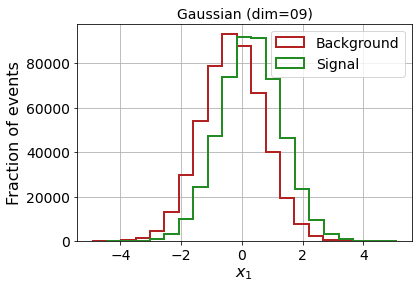

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.67060	validation_1-logloss:0.67096
[1]	validation_0-logloss:0.65038	validation_1-logloss:0.65102
[2]	validation_0-logloss:0.63240	validation_1-logloss:0.63326
[3]	validation_0-logloss:0.61628	validation_1-logloss:0.61733
[4]	validation_0-logloss:0.60172	validation_1-logloss:0.60296
[5]	validation_0-logloss:0.58853	validation_1-logloss:0.58996
[6]	validation_0-logloss:0.57653	validation_1-logloss:0.57811
[7]	validation_0-logloss:0.56560	validation_1-logloss:0.56734
[8]	validation_0-logloss:0.55553	validation_1-logloss:0.55744
[9]	validation_0-logloss:0.54635	validation_1-logloss:0.54835
[10]	validation_0-logloss:0.53784	validation_1-logloss:0.53998
[11]	validation_0-logloss:0.52995	validation_1-logloss:0.53219
[12]	validation_0-logloss:0.52270	validation_1-logloss:0.52510
[13]	validation_0-logloss:0.51607	validation_1-logloss:0.51859
[14]	validation_0-logloss:0.50982	validation_1-logloss:0.51250
[15]	validation_0-logloss:0.50403	validation_1-logloss:0.50683
[1

[130]	validation_0-logloss:0.39950	validation_1-logloss:0.40648
[131]	validation_0-logloss:0.39944	validation_1-logloss:0.40645
[132]	validation_0-logloss:0.39940	validation_1-logloss:0.40640
[133]	validation_0-logloss:0.39934	validation_1-logloss:0.40637
[134]	validation_0-logloss:0.39929	validation_1-logloss:0.40634
[135]	validation_0-logloss:0.39924	validation_1-logloss:0.40631
[136]	validation_0-logloss:0.39920	validation_1-logloss:0.40628
[137]	validation_0-logloss:0.39914	validation_1-logloss:0.40625
[138]	validation_0-logloss:0.39910	validation_1-logloss:0.40622
[139]	validation_0-logloss:0.39906	validation_1-logloss:0.40620
[140]	validation_0-logloss:0.39902	validation_1-logloss:0.40617
[141]	validation_0-logloss:0.39897	validation_1-logloss:0.40615
[142]	validation_0-logloss:0.39893	validation_1-logloss:0.40612
[143]	validation_0-logloss:0.39888	validation_1-logloss:0.40609
[144]	validation_0-logloss:0.39883	validation_1-logloss:0.40607
[145]	validation_0-logloss:0.39880	valid

[259]	validation_0-logloss:0.39661	validation_1-logloss:0.40553
[260]	validation_0-logloss:0.39659	validation_1-logloss:0.40552
[261]	validation_0-logloss:0.39658	validation_1-logloss:0.40553
[262]	validation_0-logloss:0.39656	validation_1-logloss:0.40553
[263]	validation_0-logloss:0.39655	validation_1-logloss:0.40553
[264]	validation_0-logloss:0.39654	validation_1-logloss:0.40553
[265]	validation_0-logloss:0.39654	validation_1-logloss:0.40553
[266]	validation_0-logloss:0.39653	validation_1-logloss:0.40553
[267]	validation_0-logloss:0.39652	validation_1-logloss:0.40553
[268]	validation_0-logloss:0.39650	validation_1-logloss:0.40553
[269]	validation_0-logloss:0.39650	validation_1-logloss:0.40553
[270]	validation_0-logloss:0.39649	validation_1-logloss:0.40553
[271]	validation_0-logloss:0.39648	validation_1-logloss:0.40553
[272]	validation_0-logloss:0.39647	validation_1-logloss:0.40553
[273]	validation_0-logloss:0.39647	validation_1-logloss:0.40553
[274]	validation_0-logloss:0.39646	valid

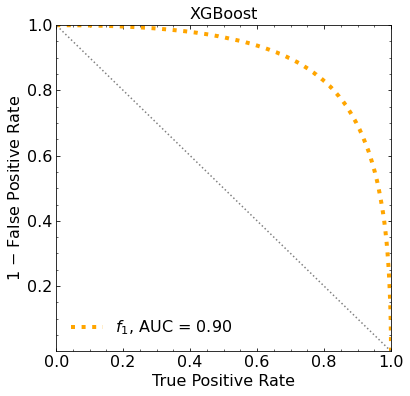

ML iteration 0


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.66970	validation_1-logloss:0.67067
[1]	validation_0-logloss:0.64887	validation_1-logloss:0.65062
[2]	validation_0-logloss:0.63027	validation_1-logloss:0.63266
[3]	validation_0-logloss:0.61356	validation_1-logloss:0.61665
[4]	validation_0-logloss:0.59848	validation_1-logloss:0.60213
[5]	validation_0-logloss:0.58484	validation_1-logloss:0.58901
[6]	validation_0-logloss:0.57240	validation_1-logloss:0.57715
[7]	validation_0-logloss:0.56101	validation_1-logloss:0.56632
[8]	validation_0-logloss:0.55035	validation_1-logloss:0.55620
[9]	validation_0-logloss:0.54078	validation_1-logloss:0.54704
[10]	validation_0-logloss:0.53196	validation_1-logloss:0.53878
[11]	validation_0-logloss:0.52376	validation_1-logloss:0.53102
[12]	validation_0-logloss:0.51610	validation_1-logloss:0.52392
[13]	validation_0-logloss:0.50904	validation_1-logloss:0.51732
[14]	validation_0-logloss:0.50249	validation_1-logloss:0.51120
[15]	validation_0-logloss:0.49651	validation_1-logloss:0.50557
[1

[130]	validation_0-logloss:0.37964	validation_1-logloss:0.40960
[131]	validation_0-logloss:0.37950	validation_1-logloss:0.40958
[132]	validation_0-logloss:0.37939	validation_1-logloss:0.40957
[133]	validation_0-logloss:0.37922	validation_1-logloss:0.40956
[134]	validation_0-logloss:0.37913	validation_1-logloss:0.40953
[135]	validation_0-logloss:0.37900	validation_1-logloss:0.40952
[136]	validation_0-logloss:0.37891	validation_1-logloss:0.40951
[137]	validation_0-logloss:0.37882	validation_1-logloss:0.40951
[138]	validation_0-logloss:0.37867	validation_1-logloss:0.40949
[139]	validation_0-logloss:0.37857	validation_1-logloss:0.40949
[140]	validation_0-logloss:0.37849	validation_1-logloss:0.40949
[141]	validation_0-logloss:0.37843	validation_1-logloss:0.40948
[142]	validation_0-logloss:0.37829	validation_1-logloss:0.40947
[143]	validation_0-logloss:0.37816	validation_1-logloss:0.40947
[144]	validation_0-logloss:0.37807	validation_1-logloss:0.40945
[145]	validation_0-logloss:0.37801	valid

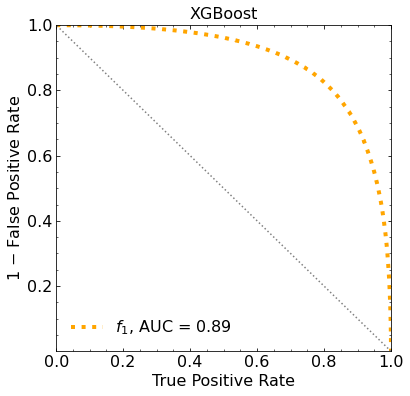

ML iteration  1


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.66934	validation_1-logloss:0.67059
[1]	validation_0-logloss:0.64795	validation_1-logloss:0.65038
[2]	validation_0-logloss:0.62903	validation_1-logloss:0.63240
[3]	validation_0-logloss:0.61186	validation_1-logloss:0.61622
[4]	validation_0-logloss:0.59639	validation_1-logloss:0.60169
[5]	validation_0-logloss:0.58240	validation_1-logloss:0.58843
[6]	validation_0-logloss:0.56971	validation_1-logloss:0.57633
[7]	validation_0-logloss:0.55807	validation_1-logloss:0.56536
[8]	validation_0-logloss:0.54739	validation_1-logloss:0.55527
[9]	validation_0-logloss:0.53766	validation_1-logloss:0.54621
[10]	validation_0-logloss:0.52868	validation_1-logloss:0.53778
[11]	validation_0-logloss:0.52043	validation_1-logloss:0.53012
[12]	validation_0-logloss:0.51276	validation_1-logloss:0.52298
[13]	validation_0-logloss:0.50564	validation_1-logloss:0.51639
[14]	validation_0-logloss:0.49905	validation_1-logloss:0.51030
[15]	validation_0-logloss:0.49295	validation_1-logloss:0.50461
[1

[130]	validation_0-logloss:0.37583	validation_1-logloss:0.40937
[131]	validation_0-logloss:0.37569	validation_1-logloss:0.40935
[132]	validation_0-logloss:0.37555	validation_1-logloss:0.40932
[133]	validation_0-logloss:0.37544	validation_1-logloss:0.40931
[134]	validation_0-logloss:0.37531	validation_1-logloss:0.40931
[135]	validation_0-logloss:0.37516	validation_1-logloss:0.40931
[136]	validation_0-logloss:0.37498	validation_1-logloss:0.40931
[137]	validation_0-logloss:0.37484	validation_1-logloss:0.40930
[138]	validation_0-logloss:0.37474	validation_1-logloss:0.40928
[139]	validation_0-logloss:0.37468	validation_1-logloss:0.40927
[140]	validation_0-logloss:0.37452	validation_1-logloss:0.40925
[141]	validation_0-logloss:0.37436	validation_1-logloss:0.40923
[142]	validation_0-logloss:0.37423	validation_1-logloss:0.40922
[143]	validation_0-logloss:0.37414	validation_1-logloss:0.40921
[144]	validation_0-logloss:0.37404	validation_1-logloss:0.40921
[145]	validation_0-logloss:0.37397	valid

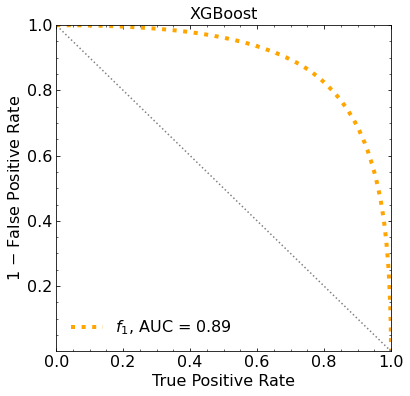

ML iteration  2


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.66938	validation_1-logloss:0.67052
[1]	validation_0-logloss:0.64824	validation_1-logloss:0.65038
[2]	validation_0-logloss:0.62949	validation_1-logloss:0.63249
[3]	validation_0-logloss:0.61265	validation_1-logloss:0.61641
[4]	validation_0-logloss:0.59745	validation_1-logloss:0.60201
[5]	validation_0-logloss:0.58363	validation_1-logloss:0.58886
[6]	validation_0-logloss:0.57113	validation_1-logloss:0.57686
[7]	validation_0-logloss:0.55976	validation_1-logloss:0.56601
[8]	validation_0-logloss:0.54919	validation_1-logloss:0.55599
[9]	validation_0-logloss:0.53951	validation_1-logloss:0.54685
[10]	validation_0-logloss:0.53067	validation_1-logloss:0.53863
[11]	validation_0-logloss:0.52241	validation_1-logloss:0.53082
[12]	validation_0-logloss:0.51484	validation_1-logloss:0.52368
[13]	validation_0-logloss:0.50774	validation_1-logloss:0.51703
[14]	validation_0-logloss:0.50123	validation_1-logloss:0.51098
[15]	validation_0-logloss:0.49514	validation_1-logloss:0.50533
[1

[130]	validation_0-logloss:0.37793	validation_1-logloss:0.40973
[131]	validation_0-logloss:0.37785	validation_1-logloss:0.40971
[132]	validation_0-logloss:0.37771	validation_1-logloss:0.40970
[133]	validation_0-logloss:0.37758	validation_1-logloss:0.40969
[134]	validation_0-logloss:0.37743	validation_1-logloss:0.40966
[135]	validation_0-logloss:0.37737	validation_1-logloss:0.40966
[136]	validation_0-logloss:0.37723	validation_1-logloss:0.40965
[137]	validation_0-logloss:0.37709	validation_1-logloss:0.40963
[138]	validation_0-logloss:0.37697	validation_1-logloss:0.40963
[139]	validation_0-logloss:0.37688	validation_1-logloss:0.40961
[140]	validation_0-logloss:0.37675	validation_1-logloss:0.40961
[141]	validation_0-logloss:0.37667	validation_1-logloss:0.40961
[142]	validation_0-logloss:0.37663	validation_1-logloss:0.40961
[143]	validation_0-logloss:0.37646	validation_1-logloss:0.40960
[144]	validation_0-logloss:0.37640	validation_1-logloss:0.40960
[145]	validation_0-logloss:0.37625	valid

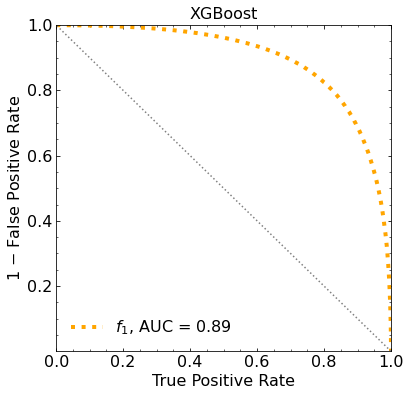

ML iteration  3


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.66927	validation_1-logloss:0.67058
[1]	validation_0-logloss:0.64805	validation_1-logloss:0.65046
[2]	validation_0-logloss:0.62926	validation_1-logloss:0.63237
[3]	validation_0-logloss:0.61232	validation_1-logloss:0.61622
[4]	validation_0-logloss:0.59715	validation_1-logloss:0.60180
[5]	validation_0-logloss:0.58330	validation_1-logloss:0.58865
[6]	validation_0-logloss:0.57080	validation_1-logloss:0.57674
[7]	validation_0-logloss:0.55945	validation_1-logloss:0.56591
[8]	validation_0-logloss:0.54891	validation_1-logloss:0.55591
[9]	validation_0-logloss:0.53924	validation_1-logloss:0.54677
[10]	validation_0-logloss:0.53034	validation_1-logloss:0.53848
[11]	validation_0-logloss:0.52211	validation_1-logloss:0.53075
[12]	validation_0-logloss:0.51461	validation_1-logloss:0.52360
[13]	validation_0-logloss:0.50756	validation_1-logloss:0.51699
[14]	validation_0-logloss:0.50096	validation_1-logloss:0.51078
[15]	validation_0-logloss:0.49490	validation_1-logloss:0.50510
[1

[130]	validation_0-logloss:0.37850	validation_1-logloss:0.40976
[131]	validation_0-logloss:0.37835	validation_1-logloss:0.40975
[132]	validation_0-logloss:0.37824	validation_1-logloss:0.40973
[133]	validation_0-logloss:0.37807	validation_1-logloss:0.40972
[134]	validation_0-logloss:0.37796	validation_1-logloss:0.40970
[135]	validation_0-logloss:0.37783	validation_1-logloss:0.40968
[136]	validation_0-logloss:0.37773	validation_1-logloss:0.40967
[137]	validation_0-logloss:0.37759	validation_1-logloss:0.40964
[138]	validation_0-logloss:0.37747	validation_1-logloss:0.40964
[139]	validation_0-logloss:0.37734	validation_1-logloss:0.40962
[140]	validation_0-logloss:0.37724	validation_1-logloss:0.40962
[141]	validation_0-logloss:0.37708	validation_1-logloss:0.40962
[142]	validation_0-logloss:0.37696	validation_1-logloss:0.40961
[143]	validation_0-logloss:0.37686	validation_1-logloss:0.40960
[144]	validation_0-logloss:0.37669	validation_1-logloss:0.40958
[145]	validation_0-logloss:0.37659	valid

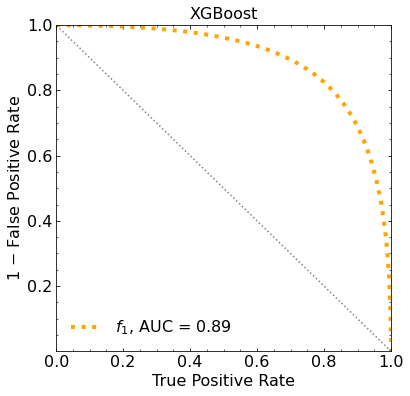

ML iteration  4


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.66948	validation_1-logloss:0.67063
[1]	validation_0-logloss:0.64851	validation_1-logloss:0.65040
[2]	validation_0-logloss:0.62981	validation_1-logloss:0.63255
[3]	validation_0-logloss:0.61282	validation_1-logloss:0.61643
[4]	validation_0-logloss:0.59744	validation_1-logloss:0.60180
[5]	validation_0-logloss:0.58369	validation_1-logloss:0.58874
[6]	validation_0-logloss:0.57120	validation_1-logloss:0.57680
[7]	validation_0-logloss:0.55970	validation_1-logloss:0.56600
[8]	validation_0-logloss:0.54912	validation_1-logloss:0.55601
[9]	validation_0-logloss:0.53940	validation_1-logloss:0.54685
[10]	validation_0-logloss:0.53051	validation_1-logloss:0.53847
[11]	validation_0-logloss:0.52227	validation_1-logloss:0.53087
[12]	validation_0-logloss:0.51460	validation_1-logloss:0.52366
[13]	validation_0-logloss:0.50746	validation_1-logloss:0.51706
[14]	validation_0-logloss:0.50084	validation_1-logloss:0.51092
[15]	validation_0-logloss:0.49462	validation_1-logloss:0.50516
[1

[130]	validation_0-logloss:0.37660	validation_1-logloss:0.40956
[131]	validation_0-logloss:0.37652	validation_1-logloss:0.40955
[132]	validation_0-logloss:0.37640	validation_1-logloss:0.40953
[133]	validation_0-logloss:0.37624	validation_1-logloss:0.40951
[134]	validation_0-logloss:0.37616	validation_1-logloss:0.40950
[135]	validation_0-logloss:0.37603	validation_1-logloss:0.40949
[136]	validation_0-logloss:0.37594	validation_1-logloss:0.40947
[137]	validation_0-logloss:0.37584	validation_1-logloss:0.40947
[138]	validation_0-logloss:0.37573	validation_1-logloss:0.40946
[139]	validation_0-logloss:0.37565	validation_1-logloss:0.40946
[140]	validation_0-logloss:0.37551	validation_1-logloss:0.40943
[141]	validation_0-logloss:0.37544	validation_1-logloss:0.40941
[142]	validation_0-logloss:0.37537	validation_1-logloss:0.40941
[143]	validation_0-logloss:0.37530	validation_1-logloss:0.40940
[144]	validation_0-logloss:0.37517	validation_1-logloss:0.40940
[145]	validation_0-logloss:0.37510	valid

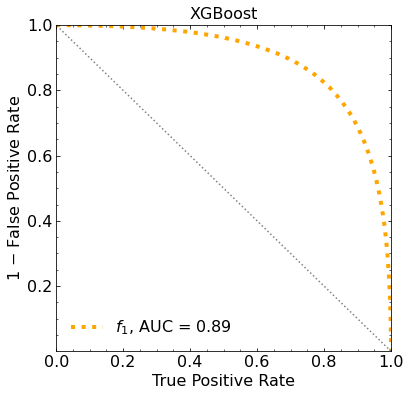

ML iteration  5


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.66910	validation_1-logloss:0.67044
[1]	validation_0-logloss:0.64779	validation_1-logloss:0.65028
[2]	validation_0-logloss:0.62878	validation_1-logloss:0.63224
[3]	validation_0-logloss:0.61185	validation_1-logloss:0.61606
[4]	validation_0-logloss:0.59648	validation_1-logloss:0.60155
[5]	validation_0-logloss:0.58267	validation_1-logloss:0.58852
[6]	validation_0-logloss:0.56998	validation_1-logloss:0.57656
[7]	validation_0-logloss:0.55839	validation_1-logloss:0.56577
[8]	validation_0-logloss:0.54782	validation_1-logloss:0.55594
[9]	validation_0-logloss:0.53809	validation_1-logloss:0.54676
[10]	validation_0-logloss:0.52923	validation_1-logloss:0.53844
[11]	validation_0-logloss:0.52091	validation_1-logloss:0.53073
[12]	validation_0-logloss:0.51326	validation_1-logloss:0.52366
[13]	validation_0-logloss:0.50613	validation_1-logloss:0.51702
[14]	validation_0-logloss:0.49948	validation_1-logloss:0.51095
[15]	validation_0-logloss:0.49336	validation_1-logloss:0.50531
[1

[130]	validation_0-logloss:0.37613	validation_1-logloss:0.40987
[131]	validation_0-logloss:0.37597	validation_1-logloss:0.40985
[132]	validation_0-logloss:0.37579	validation_1-logloss:0.40983
[133]	validation_0-logloss:0.37563	validation_1-logloss:0.40980
[134]	validation_0-logloss:0.37551	validation_1-logloss:0.40978
[135]	validation_0-logloss:0.37542	validation_1-logloss:0.40976
[136]	validation_0-logloss:0.37534	validation_1-logloss:0.40975
[137]	validation_0-logloss:0.37527	validation_1-logloss:0.40974
[138]	validation_0-logloss:0.37517	validation_1-logloss:0.40974
[139]	validation_0-logloss:0.37504	validation_1-logloss:0.40972
[140]	validation_0-logloss:0.37491	validation_1-logloss:0.40971
[141]	validation_0-logloss:0.37480	validation_1-logloss:0.40970
[142]	validation_0-logloss:0.37472	validation_1-logloss:0.40971
[143]	validation_0-logloss:0.37459	validation_1-logloss:0.40970
[144]	validation_0-logloss:0.37452	validation_1-logloss:0.40969
[145]	validation_0-logloss:0.37442	valid

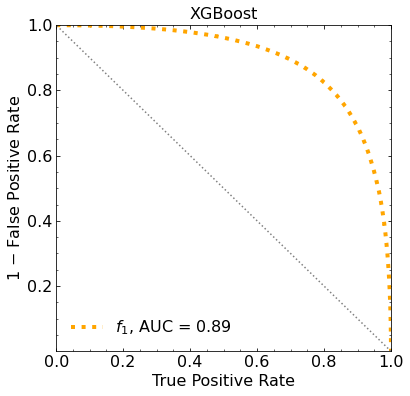

ML iteration  6


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.66936	validation_1-logloss:0.67053
[1]	validation_0-logloss:0.64818	validation_1-logloss:0.65033
[2]	validation_0-logloss:0.62933	validation_1-logloss:0.63237
[3]	validation_0-logloss:0.61241	validation_1-logloss:0.61619
[4]	validation_0-logloss:0.59703	validation_1-logloss:0.60162
[5]	validation_0-logloss:0.58308	validation_1-logloss:0.58851
[6]	validation_0-logloss:0.57051	validation_1-logloss:0.57661
[7]	validation_0-logloss:0.55909	validation_1-logloss:0.56581
[8]	validation_0-logloss:0.54839	validation_1-logloss:0.55574
[9]	validation_0-logloss:0.53862	validation_1-logloss:0.54651
[10]	validation_0-logloss:0.52974	validation_1-logloss:0.53822
[11]	validation_0-logloss:0.52150	validation_1-logloss:0.53049
[12]	validation_0-logloss:0.51394	validation_1-logloss:0.52340
[13]	validation_0-logloss:0.50682	validation_1-logloss:0.51675
[14]	validation_0-logloss:0.50023	validation_1-logloss:0.51059
[15]	validation_0-logloss:0.49408	validation_1-logloss:0.50491
[1

[130]	validation_0-logloss:0.37602	validation_1-logloss:0.40953
[131]	validation_0-logloss:0.37591	validation_1-logloss:0.40952
[132]	validation_0-logloss:0.37581	validation_1-logloss:0.40951
[133]	validation_0-logloss:0.37568	validation_1-logloss:0.40949
[134]	validation_0-logloss:0.37554	validation_1-logloss:0.40948
[135]	validation_0-logloss:0.37542	validation_1-logloss:0.40948
[136]	validation_0-logloss:0.37532	validation_1-logloss:0.40948
[137]	validation_0-logloss:0.37522	validation_1-logloss:0.40947
[138]	validation_0-logloss:0.37508	validation_1-logloss:0.40947
[139]	validation_0-logloss:0.37502	validation_1-logloss:0.40946
[140]	validation_0-logloss:0.37486	validation_1-logloss:0.40945
[141]	validation_0-logloss:0.37477	validation_1-logloss:0.40943
[142]	validation_0-logloss:0.37463	validation_1-logloss:0.40945
[143]	validation_0-logloss:0.37454	validation_1-logloss:0.40943
[144]	validation_0-logloss:0.37441	validation_1-logloss:0.40943
[145]	validation_0-logloss:0.37433	valid

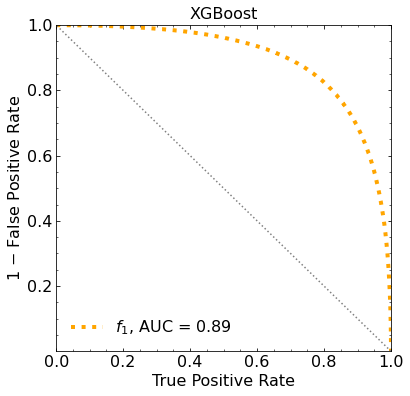

ML iteration  7


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.66936	validation_1-logloss:0.67049
[1]	validation_0-logloss:0.64832	validation_1-logloss:0.65038
[2]	validation_0-logloss:0.62944	validation_1-logloss:0.63242
[3]	validation_0-logloss:0.61241	validation_1-logloss:0.61635
[4]	validation_0-logloss:0.59719	validation_1-logloss:0.60177
[5]	validation_0-logloss:0.58351	validation_1-logloss:0.58880
[6]	validation_0-logloss:0.57082	validation_1-logloss:0.57674
[7]	validation_0-logloss:0.55935	validation_1-logloss:0.56591
[8]	validation_0-logloss:0.54885	validation_1-logloss:0.55603
[9]	validation_0-logloss:0.53908	validation_1-logloss:0.54683
[10]	validation_0-logloss:0.53008	validation_1-logloss:0.53847
[11]	validation_0-logloss:0.52185	validation_1-logloss:0.53082
[12]	validation_0-logloss:0.51419	validation_1-logloss:0.52360
[13]	validation_0-logloss:0.50715	validation_1-logloss:0.51701
[14]	validation_0-logloss:0.50053	validation_1-logloss:0.51085
[15]	validation_0-logloss:0.49439	validation_1-logloss:0.50522
[1

[130]	validation_0-logloss:0.37680	validation_1-logloss:0.40940
[131]	validation_0-logloss:0.37665	validation_1-logloss:0.40937
[132]	validation_0-logloss:0.37655	validation_1-logloss:0.40936
[133]	validation_0-logloss:0.37639	validation_1-logloss:0.40935
[134]	validation_0-logloss:0.37624	validation_1-logloss:0.40933
[135]	validation_0-logloss:0.37615	validation_1-logloss:0.40932
[136]	validation_0-logloss:0.37599	validation_1-logloss:0.40931
[137]	validation_0-logloss:0.37584	validation_1-logloss:0.40929
[138]	validation_0-logloss:0.37571	validation_1-logloss:0.40929
[139]	validation_0-logloss:0.37558	validation_1-logloss:0.40929
[140]	validation_0-logloss:0.37543	validation_1-logloss:0.40927
[141]	validation_0-logloss:0.37532	validation_1-logloss:0.40926
[142]	validation_0-logloss:0.37515	validation_1-logloss:0.40924
[143]	validation_0-logloss:0.37507	validation_1-logloss:0.40923
[144]	validation_0-logloss:0.37494	validation_1-logloss:0.40922
[145]	validation_0-logloss:0.37485	valid

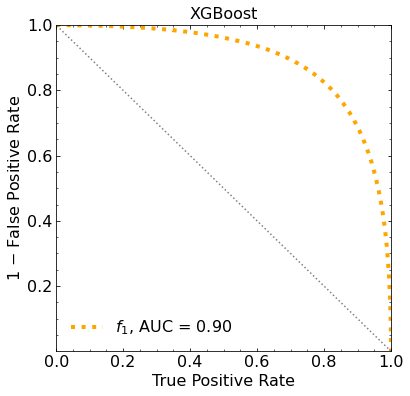

ML iteration  8


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.66935	validation_1-logloss:0.67058
[1]	validation_0-logloss:0.64855	validation_1-logloss:0.65046
[2]	validation_0-logloss:0.62968	validation_1-logloss:0.63256
[3]	validation_0-logloss:0.61293	validation_1-logloss:0.61651
[4]	validation_0-logloss:0.59774	validation_1-logloss:0.60189
[5]	validation_0-logloss:0.58397	validation_1-logloss:0.58882
[6]	validation_0-logloss:0.57138	validation_1-logloss:0.57677
[7]	validation_0-logloss:0.55994	validation_1-logloss:0.56598
[8]	validation_0-logloss:0.54939	validation_1-logloss:0.55610
[9]	validation_0-logloss:0.53978	validation_1-logloss:0.54693
[10]	validation_0-logloss:0.53084	validation_1-logloss:0.53851
[11]	validation_0-logloss:0.52274	validation_1-logloss:0.53083
[12]	validation_0-logloss:0.51513	validation_1-logloss:0.52370
[13]	validation_0-logloss:0.50805	validation_1-logloss:0.51710
[14]	validation_0-logloss:0.50158	validation_1-logloss:0.51106
[15]	validation_0-logloss:0.49550	validation_1-logloss:0.50531
[1

[130]	validation_0-logloss:0.37876	validation_1-logloss:0.40946
[131]	validation_0-logloss:0.37866	validation_1-logloss:0.40945
[132]	validation_0-logloss:0.37849	validation_1-logloss:0.40944
[133]	validation_0-logloss:0.37838	validation_1-logloss:0.40942
[134]	validation_0-logloss:0.37825	validation_1-logloss:0.40940
[135]	validation_0-logloss:0.37808	validation_1-logloss:0.40938
[136]	validation_0-logloss:0.37798	validation_1-logloss:0.40937
[137]	validation_0-logloss:0.37790	validation_1-logloss:0.40936
[138]	validation_0-logloss:0.37779	validation_1-logloss:0.40936
[139]	validation_0-logloss:0.37770	validation_1-logloss:0.40936
[140]	validation_0-logloss:0.37754	validation_1-logloss:0.40934
[141]	validation_0-logloss:0.37745	validation_1-logloss:0.40933
[142]	validation_0-logloss:0.37735	validation_1-logloss:0.40933
[143]	validation_0-logloss:0.37718	validation_1-logloss:0.40931
[144]	validation_0-logloss:0.37703	validation_1-logloss:0.40931
[145]	validation_0-logloss:0.37688	valid

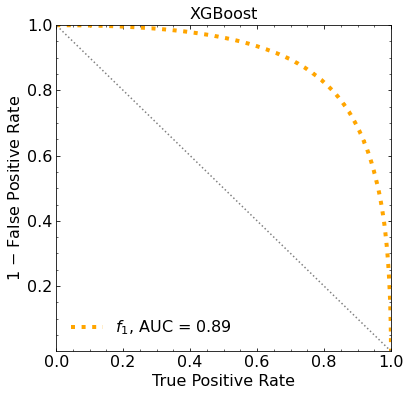

ML iteration  9
[0]	validation_0-logloss:0.66953	validation_1-logloss:0.67070


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[1]	validation_0-logloss:0.64832	validation_1-logloss:0.65043
[2]	validation_0-logloss:0.62950	validation_1-logloss:0.63255
[3]	validation_0-logloss:0.61256	validation_1-logloss:0.61642
[4]	validation_0-logloss:0.59725	validation_1-logloss:0.60188
[5]	validation_0-logloss:0.58347	validation_1-logloss:0.58881
[6]	validation_0-logloss:0.57082	validation_1-logloss:0.57686
[7]	validation_0-logloss:0.55931	validation_1-logloss:0.56609
[8]	validation_0-logloss:0.54874	validation_1-logloss:0.55612
[9]	validation_0-logloss:0.53904	validation_1-logloss:0.54696
[10]	validation_0-logloss:0.53009	validation_1-logloss:0.53854
[11]	validation_0-logloss:0.52175	validation_1-logloss:0.53065
[12]	validation_0-logloss:0.51406	validation_1-logloss:0.52346
[13]	validation_0-logloss:0.50686	validation_1-logloss:0.51696
[14]	validation_0-logloss:0.50019	validation_1-logloss:0.51087
[15]	validation_0-logloss:0.49408	validation_1-logloss:0.50515
[16]	validation_0-logloss:0.48829	validation_1-logloss:0.49978
[

[131]	validation_0-logloss:0.37662	validation_1-logloss:0.40970
[132]	validation_0-logloss:0.37646	validation_1-logloss:0.40967
[133]	validation_0-logloss:0.37636	validation_1-logloss:0.40965
[134]	validation_0-logloss:0.37626	validation_1-logloss:0.40965
[135]	validation_0-logloss:0.37613	validation_1-logloss:0.40965
[136]	validation_0-logloss:0.37602	validation_1-logloss:0.40963
[137]	validation_0-logloss:0.37591	validation_1-logloss:0.40962
[138]	validation_0-logloss:0.37586	validation_1-logloss:0.40961
[139]	validation_0-logloss:0.37579	validation_1-logloss:0.40959
[140]	validation_0-logloss:0.37571	validation_1-logloss:0.40958
[141]	validation_0-logloss:0.37563	validation_1-logloss:0.40957
[142]	validation_0-logloss:0.37550	validation_1-logloss:0.40956
[143]	validation_0-logloss:0.37541	validation_1-logloss:0.40956
[144]	validation_0-logloss:0.37533	validation_1-logloss:0.40954
[145]	validation_0-logloss:0.37522	validation_1-logloss:0.40954
[146]	validation_0-logloss:0.37511	valid

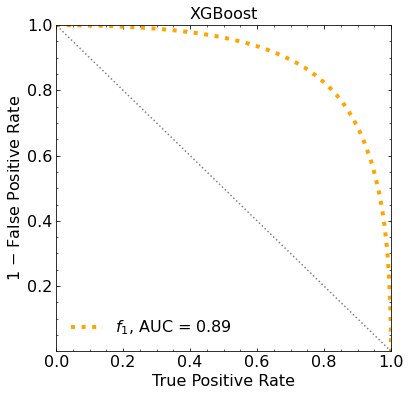

Classification score (1 ML):


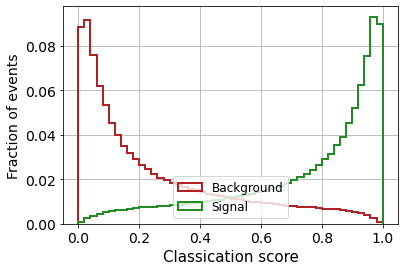

Classification score (10 ML):


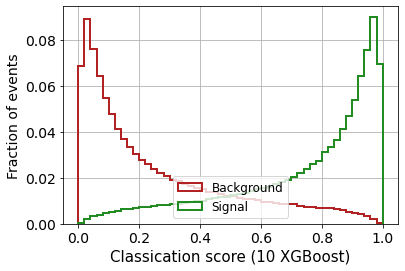

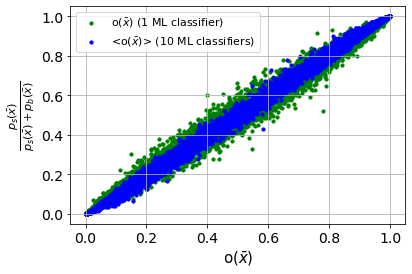


 ----------------------------------------- 

B_expected:  50000
S_expected:  500
S/$\sqrt{B}$:  2.23606797749979
 BINNED CLASSIFIER OUTPUT
  BL lineal bins, 1 ML
Z_XG 10 bins_1ML:  6.577314070013948
Z_XG 25 bins_1ML:  7.487959882792887
Z_XG 50 bins_1ML:  7.865538528542508
Z_XG 100 bins_1ML:  8.04426528480163

 BL non-lineal bins, 1 ML
Z_XG 10 bins_eq_1ML:  4.922943019439316
Z_XG 25 bins_eq_1ML:  5.850060909543849
Z_XG 50 bins_eq_1ML:  6.465190376995463
Z_XG 100 bins_eq_1ML:  6.9679169214863315

 BL lineal bins, 10 ML
Z_XG 10 bins:  6.715341074739137
Z_XG 25 bins:  7.6707271873012255
Z_XG 50 bins:  8.01022631993649
Z_XG 100 bins:  8.114553494350798

 BL non-lineal bins, 10 ML
Z_XG 10 bins_eq:  4.939326526387225
Z_XG 25 bins_eq:  5.8792566071349865
Z_XG 50 bins_eq:  6.503868061366378
Z_XG 100 bins_eq:  7.006269884769962

 ----------------------------------------- 


 If  20200  =  1101    then the proposed range has to be extended
n_ensembles (actual):  9863
TRUE PDF LIKELIHOOD (GAUSSIA

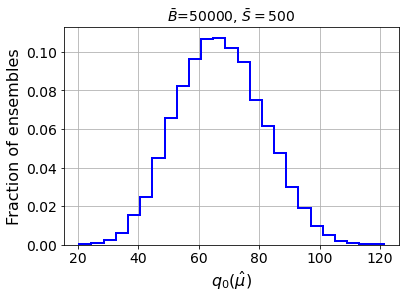

muhat mean:  0.06007300010138903
Z_gaussian:  8.170962937022681
Z_gaussian_mu0:  8.169352905208163

 ------------------------------------ 

 MLL + KDE (1ML) 


/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
  1646.13718988  1650.18867325  1645.22730774  1631.18080093
  1605.6025783   1562.88873846  1499.57425722  1408.06245236
  1273.23647737  1085.89228428   833.04421866   503.10924224
    85.38962993  -439.80341773 -1100.21053534 -2034.63147239]
  warnings.warn(
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:929: RuntimeWarning: invalid value encountered in subtract
  array_stds = np.sqrt(np.average((array -
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf  1637.72871576
  1642.15171369  1639.95053681  1633.00524172  1619.84302175
  1595.96749982  1555.89760625  1491.77719045  1399.2455561
  127

KDE Kernel:  epanechnikov
Background bandwidth:  0.0063479219593504735
Signal bandwidth:  0.004386370005779536


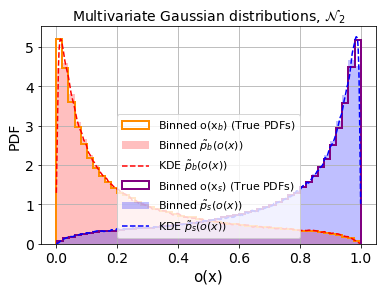

 MLL + KDE (10ML) 


/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
           -inf  1586.37973976  1582.53766364  1573.33774697
  1555.0203903   1521.97748448  1467.20836678  1383.95495929
  1263.24192515  1090.43546892   851.59662485   533.38442911
   125.55293612  -391.80576419 -1059.41155206 -2016.56637361]
  warnings.warn(
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:929: RuntimeWarning: invalid value encountered in subtract
  array_stds = np.sqrt(np.average((array -
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf           -inf
  1575.82474437  1577.90356256  1574.78053165  1565.90546654
  1548.04841295  1515.3306577   1460.25329193  1378.22432725
  12

KDE Kernel:  epanechnikov
Background bandwidth:  0.0063479219593504735
Signal bandwidth:  0.0063479219593504735


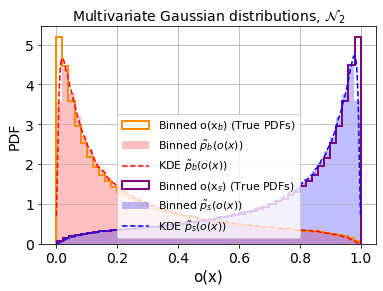

 Z MLL+KDE (1ML) 


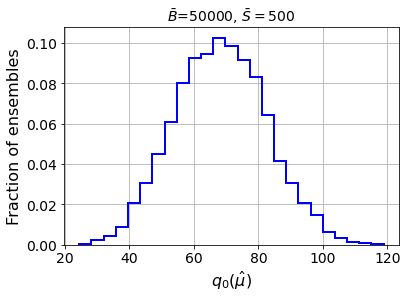

muhat mean_1ML:  0.038999290276792054
Z_KDE_1ML:  8.264951509111475
Z_KDE mu=0_1ML:  8.265340059208611

 Z MLL+KDE (10ML) 


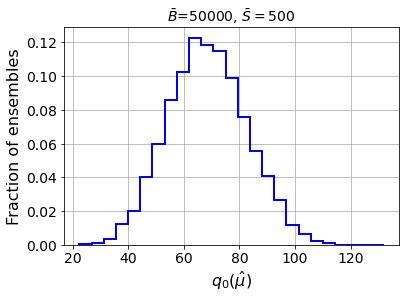

muhat mean:  0.039156443272837876
Z_KDE:  8.253426003616976
Z_KDE mu=0:  8.253664767252355

 ------------------------------------ 



In [125]:
dim=9

#######################
# generate the events #
#######################
    
mean_sig = epsilon*np.ones(dim)
mean_bkg = -1*mean_sig

#cov_sig = np.identity(dim)
cov_sig = np.identity(dim) + (0. * ( np.ones((dim,dim)) - np.identity(dim) ))
cov_bkg = cov_sig

signal_X_1, signal_X_2, signal_X_3, signal_X_4, signal_X_5, signal_X_6, signal_X_7, signal_X_8, signal_X_9 = np.random.multivariate_normal(mean_sig, cov_sig, N).T
background_X_1, background_X_2, background_X_3, background_X_4, background_X_5, background_X_6, background_X_7, background_X_8, background_X_9 = np.random.multivariate_normal(mean_bkg, cov_bkg, N).T


dim1 = np.concatenate((background_X_1,signal_X_1))
dim2 = np.concatenate((background_X_2,signal_X_2))
dim3 = np.concatenate((background_X_3,signal_X_3))
dim4 = np.concatenate((background_X_4,signal_X_4))
dim5 = np.concatenate((background_X_5,signal_X_5))
dim6 = np.concatenate((background_X_6,signal_X_6))
dim7 = np.concatenate((background_X_7,signal_X_7))
dim8 = np.concatenate((background_X_8,signal_X_8))
dim9 = np.concatenate((background_X_9,signal_X_9))

# labels
background_Y = np.zeros(N)
signal_Y = np.ones(N)

# DATA in a single matrix (features + labels)
df = pd.DataFrame()
df['dim1'] = dim1.reshape(-1)
df['dim2'] = dim2.reshape(-1)
df['dim3'] = dim3.reshape(-1)
df['dim4'] = dim4.reshape(-1)
df['dim5'] = dim5.reshape(-1)
df['dim6'] = dim6.reshape(-1)
df['dim7'] = dim7.reshape(-1)
df['dim8'] = dim8.reshape(-1)
df['dim9'] = dim9.reshape(-1)
df['Y'] = np.concatenate((background_Y.astype('int'),signal_Y.astype('int')))

X_gauss = df[['dim1','dim2','dim3','dim4','dim5','dim6','dim7','dim8','dim9']].values 
Y_gauss = df[['Y']].values

# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.5

X_gauss_aux, X_gauss_test, Y_gauss_aux, Y_gauss_test = train_test_split(X_gauss,
                                                                Y_gauss,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_gauss,
                                                                shuffle=True)


X_gauss_train, X_gauss_val, Y_gauss_train, Y_gauss_val = train_test_split(X_gauss_aux,
                                                                  Y_gauss_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_gauss_aux,
                                                                  shuffle=True)

print('')
print('X_gauss_train : ', X_gauss_train.shape)
print('y_gauss_train : ', Y_gauss_train.shape)
print('X_gauss_val : ', X_gauss_val.shape)
print('y_gauss_val : ', Y_gauss_val.shape)
print('X_gauss_test : ', X_gauss_test.shape)
print('y_gauss_test : ', Y_gauss_test.shape)
print('')


# PLOT (only 1st feature) to visualize the data
X_gauss_test_SM = []
X_gauss_test_NP = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] ==0:
        X_gauss_test_SM.append(X_gauss_test[i].tolist())
    else:
        X_gauss_test_NP.append(X_gauss_test[i].tolist())    


X_gauss_test_SM = np.array(X_gauss_test_SM)
X_gauss_test_NP = np.array(X_gauss_test_NP)


weights = np.ones_like(X_gauss_test_SM[:,0])/float(len(X_gauss_test_SM[:,0]))
plt.hist(X_gauss_test_SM[:,0], 20, histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(X_gauss_test_NP[:,0])/float(len(X_gauss_test_NP[:,0]))
plt.hist(X_gauss_test_NP[:,0], 20, histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$x_1$",fontsize=16)
plt.ylabel("Fraction of events",fontsize=16)
plt.grid()
plt.legend(fontsize=14)
plt.title(r"Gaussian (dim=%0.2d)" % dim,fontsize=14)
plt.show()  






################################
# the true pdfs (useful later) #
################################

sig_multi = multivariate_normal(mean_sig, cov_sig)
bkg_multi = multivariate_normal(mean_bkg, cov_bkg) 




#######################
# CLASSIFIER: XGBoost #
#######################

# only 1 ML
roc_auc_XG, y_pred_xg_1ML = XG(X_gauss_train, X_gauss_test, X_gauss_val, Y_gauss_train, Y_gauss_test, Y_gauss_val)

store_AUC.append(roc_auc_XG)


# Bagging

print('ML iteration 0')
roc_auc_XG, y_pred_xg_aux = XG(X_gauss_train[:100000], X_gauss_test, X_gauss_val, Y_gauss_train[:100000], Y_gauss_test, Y_gauss_val)
y_pred_xg_auxRE = np.reshape(y_pred_xg_aux, (1,len(y_pred_xg_aux)))

for it in range(1,iterations_ML):

    print('ML iteration ', it)
    roc_auc_XG, y_pred_xg_aux_it = XG(X_gauss_train[(100000*it):(100000*it)+100000], X_gauss_test, X_gauss_val, Y_gauss_train[(100000*it):(100000*it)+100000], Y_gauss_test, Y_gauss_val)
    
    y_pred_xg_auxRE_it = np.reshape(y_pred_xg_aux_it, (1,len(y_pred_xg_aux_it)))
    
    y_pred_xg_auxRE = np.concatenate([y_pred_xg_auxRE,y_pred_xg_auxRE_it])

# to smooth, mean of 10 predictions
y_pred_xg = np.mean(y_pred_xg_auxRE, axis=0)




########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

# 1 ML
pred_XG_SM_1ML = []
pred_XG_NP_1ML = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] == 0:
        pred_XG_SM_1ML.append(y_pred_xg_1ML[i])
    else:
        pred_XG_NP_1ML.append(y_pred_xg_1ML[i])
        
# Bagging  
pred_XG_SM = []
pred_XG_NP = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score (1 ML):')
        
weights = np.ones_like(pred_XG_SM_1ML)/float(len(pred_XG_SM_1ML))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM_1ML, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP_1ML)/float(len(pred_XG_NP_1ML))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP_1ML, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12, loc="lower center")
plt.show()


print('Classification score (10 ML):')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (10 XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12, loc="lower center")
plt.show()




ratio_ps_pb_true = sig_multi.pdf(X_gauss_test) / ( sig_multi.pdf(X_gauss_test) + bkg_multi.pdf(X_gauss_test) )
ratio_ps_pb_true_B = sig_multi.pdf(X_gauss_test_SM) / ( sig_multi.pdf(X_gauss_test_SM) + bkg_multi.pdf(X_gauss_test_SM) )
ratio_ps_pb_true_S = sig_multi.pdf(X_gauss_test_NP) / ( sig_multi.pdf(X_gauss_test_NP) + bkg_multi.pdf(X_gauss_test_NP) )

plt.scatter(y_pred_xg_1ML[:10000], ratio_ps_pb_true[:10000], color='green', label=r'o($\bar{x}$) (1 ML classifier)', s=10)
plt.scatter(y_pred_xg[:10000], ratio_ps_pb_true[:10000], color='blue', label=r'<o($\bar{x}$)> (10 ML classifiers)', s=10)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r"o($\bar{x}$)",fontsize=15)
plt.ylabel(r"$\frac{p_s(\bar{x})}{p_s(\bar{x})+p_b(\bar{x})}$",fontsize=16)
plt.grid()
plt.legend(fontsize=11)
#plt.savefig('images/' + 'optimalclass-vs-ox.pdf', format="pdf", bbox_inches="tight")
plt.show()

print('\n ----------------------------------------- \n')






###########
# METHODS #
###########

print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)



############################
# BINNED CLASSIFIER OUTPUT #
############################

print(' BINNED CLASSIFIER OUTPUT')

print('  BL lineal bins, 1 ML')

# 10 BINS
Z_bins_XG_10bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 10, [[0,1]], linear_bins=True)
store_Z_bins_XG_10bins_1ML.append(Z_bins_XG_10bins_1ML)
print('Z_XG 10 bins_1ML: ', Z_bins_XG_10bins_1ML)

# 25 BINS
Z_bins_XG_25bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 25, [[0,1]], linear_bins=True)
store_Z_bins_XG_25bins_1ML.append(Z_bins_XG_25bins_1ML)
print('Z_XG 25 bins_1ML: ', Z_bins_XG_25bins_1ML)

# 50 BINS
Z_bins_XG_50bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 50, [[0,1]], linear_bins=True)
store_Z_bins_XG_50bins_1ML.append(Z_bins_XG_50bins_1ML)
print('Z_XG 50 bins_1ML: ', Z_bins_XG_50bins_1ML)

# 100 BINS
Z_bins_XG_100bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 100, [[0,1]], linear_bins=True)
store_Z_bins_XG_100bins_1ML.append(Z_bins_XG_100bins_1ML)
print('Z_XG 100 bins_1ML: ', Z_bins_XG_100bins_1ML)


print('\n BL non-lineal bins, 1 ML')

# 10 BINS
Z_bins_XG_10bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 10, [[0,1]], linear_bins=False)
store_Z_bins_XG_10bins_eq_1ML.append(Z_bins_XG_10bins_eq_1ML)
print('Z_XG 10 bins_eq_1ML: ', Z_bins_XG_10bins_eq_1ML)

# 25 BINS
Z_bins_XG_25bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 25, [[0,1]], linear_bins=False)
store_Z_bins_XG_25bins_eq_1ML.append(Z_bins_XG_25bins_eq_1ML)
print('Z_XG 25 bins_eq_1ML: ', Z_bins_XG_25bins_eq_1ML)

# 50 BINS
Z_bins_XG_50bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 50, [[0,1]], linear_bins=False)
store_Z_bins_XG_50bins_eq_1ML.append(Z_bins_XG_50bins_eq_1ML)
print('Z_XG 50 bins_eq_1ML: ', Z_bins_XG_50bins_eq_1ML)

# 100 BINS
Z_bins_XG_100bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 100, [[0,1]], linear_bins=False)
store_Z_bins_XG_100bins_eq_1ML.append(Z_bins_XG_100bins_eq_1ML)
print('Z_XG 100 bins_eq_1ML: ', Z_bins_XG_100bins_eq_1ML)


print('\n BL lineal bins, 10 ML')

# 10 BINS
Z_bins_XG_10bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 10, [[0,1]], linear_bins=True)
store_Z_bins_XG_10bins.append(Z_bins_XG_10bins)
print('Z_XG 10 bins: ', Z_bins_XG_10bins)

# 25 BINS
Z_bins_XG_25bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 25, [[0,1]], linear_bins=True)
store_Z_bins_XG_25bins.append(Z_bins_XG_25bins)
print('Z_XG 25 bins: ', Z_bins_XG_25bins)

# 50 BINS
Z_bins_XG_50bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 50, [[0,1]], linear_bins=True)
store_Z_bins_XG_50bins.append(Z_bins_XG_50bins)
print('Z_XG 50 bins: ', Z_bins_XG_50bins)

# 100 BINS
Z_bins_XG_100bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 100, [[0,1]], linear_bins=True)
store_Z_bins_XG_100bins.append(Z_bins_XG_100bins)
print('Z_XG 100 bins: ', Z_bins_XG_100bins)


print('\n BL non-lineal bins, 10 ML')

# 10 BINS
Z_bins_XG_10bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 10, [[0,1]], linear_bins=False)
store_Z_bins_XG_10bins_eq.append(Z_bins_XG_10bins_eq)
print('Z_XG 10 bins_eq: ', Z_bins_XG_10bins_eq)

# 25 BINS
Z_bins_XG_25bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 25, [[0,1]], linear_bins=False)
store_Z_bins_XG_25bins_eq.append(Z_bins_XG_25bins_eq)
print('Z_XG 25 bins_eq: ', Z_bins_XG_25bins_eq)

# 50 BINS
Z_bins_XG_50bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 50, [[0,1]], linear_bins=False)
store_Z_bins_XG_50bins_eq.append(Z_bins_XG_50bins_eq)
print('Z_XG 50 bins_eq: ', Z_bins_XG_50bins_eq)

# 100 BINS
Z_bins_XG_100bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 100, [[0,1]], linear_bins=False)
store_Z_bins_XG_100bins_eq.append(Z_bins_XG_100bins_eq)
print('Z_XG 100 bins_eq: ', Z_bins_XG_100bins_eq)


print('\n ----------------------------------------- \n')






###########################
# SET THE TOY EXPERIMENTS #
###########################

list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles = ensembler(B_expected, S_expected, n_ensembles)






###################################
# TRUE PDF LIKELIHOOD (GAUSSIANS) #
###################################

indices = [i for i in range(len(X_gauss_test_SM))]

prob_B_given_B = bkg_multi.pdf(X_gauss_test_SM)
prob_B_given_S = sig_multi.pdf(X_gauss_test_SM)



print('TRUE PDF LIKELIHOOD (GAUSSIANS):')

print('n_ensembles (initial): ', n_ensembles)

Z_gaussian, muhat_mean_gaussian, Z_gaussian_mu0, muhat_selected_list, q_muhat, q_muhat_mu0 = Z_MLL(B_expected, S_expected, prob_B_given_B, prob_B_given_S, list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles)

# Histogram of q_muhats

weights = np.ones_like(q_muhat)/float(len(q_muhat))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()

store_muhat_mean_gaussian.append(muhat_mean_gaussian)
store_Z_gaussian.append(Z_gaussian)

store_Z_gaussian_mu0.append(Z_gaussian_mu0)

print('muhat mean: ', muhat_mean_gaussian)
print('Z_gaussian: ', Z_gaussian)
print('Z_gaussian_mu0: ', Z_gaussian_mu0)


print('\n ------------------------------------ \n')







#########
#  KDE  #
#########  

print(' MLL + KDE (1ML) ')

kde_bkg_1ML, kde_sig_1ML, B_bandwidth_1ML, S_bandwidth_1ML = KDE_finder(pred_XG_SM_1ML, pred_XG_NP_1ML)


# range (~between 0 and 1)
min_val_1ML = np.min([np.min(pred_XG_SM_1ML),np.min(pred_XG_NP_1ML)])
max_val_1ML = np.max([np.max(pred_XG_SM_1ML),np.max(pred_XG_NP_1ML)])

s_vals_1ML = np.linspace(min_val_1ML,max_val_1ML,1000)



# evaluate the densities for each value of s (~bins)
dens_bkg_1ML = np.exp(kde_bkg_1ML.score_samples(np.c_[s_vals_1ML, np.zeros(len(s_vals_1ML)) ]) )
dens_sig_1ML = np.exp(kde_sig_1ML.score_samples(np.c_[s_vals_1ML, np.ones(len(s_vals_1ML)) ]) )



# Normalize to 1
# Area
factor_aux_SM_1ML = sum(dens_bkg_1ML*(s_vals_1ML[1]-s_vals_1ML[0]))
factor_aux_NP_1ML = sum(dens_sig_1ML*(s_vals_1ML[1]-s_vals_1ML[0]))

# normalize
dens_bkg_1ML = dens_bkg_1ML / factor_aux_SM_1ML
dens_sig_1ML = dens_sig_1ML / factor_aux_NP_1ML





# plot to check the estimation

plt.figure()

plt.hist(ratio_ps_pb_true_B,density=True,bins=50,lw=2,histtype='step',color='darkorange',alpha=1,label=r'Binned o(x$_b$) (True PDFs)')
plt.hist(pred_XG_SM_1ML,density=True,bins=50,color='red',alpha=0.25,label=r'Binned $\tilde{p}_{b}(o(x))$');
plt.plot(s_vals_1ML,dens_bkg_1ML,color='red',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');

plt.hist(ratio_ps_pb_true_S,density=True,bins=50,lw=2,histtype='step',color='purple',alpha=1,label=r'Binned o(x$_s$) (True PDFs)');
plt.hist(pred_XG_NP_1ML,density=True,bins=50,color='blue',alpha=0.25,label=r'Binned $\tilde{p}_{s}(o(x))$');
plt.plot(s_vals_1ML,dens_sig_1ML,color='blue',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("o(x)",fontsize=15)
plt.ylabel("PDF",fontsize=14)
plt.grid()
plt.legend(loc="lower center", fontsize=11, handlelength=2.5)
plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{2}$', fontsize=14)
#plt.savefig('images/' + '2gaussian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()





print(' MLL + KDE (10ML) ')

kde_bkg, kde_sig, B_bandwidth, S_bandwidth = KDE_finder(pred_XG_SM, pred_XG_NP)


# range (~between 0 and 1)
min_val = np.min([np.min(pred_XG_SM),np.min(pred_XG_NP)])
max_val = np.max([np.max(pred_XG_SM),np.max(pred_XG_NP)])

s_vals = np.linspace(min_val,max_val,1000)



# evaluate the densities for each value of s (~bins)
dens_bkg = np.exp(kde_bkg.score_samples(np.c_[s_vals, np.zeros(len(s_vals)) ]) )
dens_sig = np.exp(kde_sig.score_samples(np.c_[s_vals, np.ones(len(s_vals)) ]) )



# Normalize to 1
# Area
factor_aux_SM = sum(dens_bkg*(s_vals[1]-s_vals[0]))
factor_aux_NP = sum(dens_sig*(s_vals[1]-s_vals[0]))

# normalize
dens_bkg = dens_bkg / factor_aux_SM
dens_sig = dens_sig / factor_aux_NP





# plot to check the estimation

plt.figure()

plt.hist(ratio_ps_pb_true_B,density=True,bins=50,lw=2,histtype='step',color='darkorange',alpha=1,label=r'Binned o(x$_b$) (True PDFs)')
plt.hist(pred_XG_SM,density=True,bins=50,color='red',alpha=0.25,label=r'Binned $\tilde{p}_{b}(o(x))$');
plt.plot(s_vals,dens_bkg,color='red',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');

plt.hist(ratio_ps_pb_true_S,density=True,bins=50,lw=2,histtype='step',color='purple',alpha=1,label=r'Binned o(x$_s$) (True PDFs)');
plt.hist(pred_XG_NP,density=True,bins=50,color='blue',alpha=0.25,label=r'Binned $\tilde{p}_{s}(o(x))$');
plt.plot(s_vals,dens_sig,color='blue',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("o(x)",fontsize=15)
plt.ylabel("PDF",fontsize=14)
plt.grid()
plt.legend(loc="lower center", fontsize=11, handlelength=2.5)
plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{2}$', fontsize=14)
#plt.savefig('images/' + '2gaussian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()






#############
# MLL + KDE #
#############

print(' Z MLL+KDE (1ML) ')
# FOR EXCLUSION:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

KDE_SM_pred_SM_1ML = np.exp(kde_bkg_1ML.score_samples(np.c_[pred_XG_SM_1ML, np.zeros(len(pred_XG_SM_1ML)) ]) )
KDE_NP_pred_SM_1ML = np.exp(kde_sig_1ML.score_samples(np.c_[pred_XG_SM_1ML, np.ones(len(pred_XG_SM_1ML)) ]) )

# Normalize

KDE_SM_pred_SM_1ML = KDE_SM_pred_SM_1ML / factor_aux_SM_1ML
KDE_NP_pred_SM_1ML = KDE_NP_pred_SM_1ML / factor_aux_NP_1ML


indices_1ML = [i for i in range(len(KDE_NP_pred_SM_1ML))]

prob_B_given_B_1ML = KDE_SM_pred_SM_1ML
prob_B_given_S_1ML = KDE_NP_pred_SM_1ML

Z_KDE_1ML, muhat_mean_MLL_KDE_1ML, Z_KDE_mu0_1ML, muhat_selected_list_1ML, q_muhat_1ML, q_muhat_mu0_1ML = Z_MLL(B_expected, S_expected, prob_B_given_B_1ML, prob_B_given_S_1ML, list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles)
    
    
# Histogram of q_muhats

weights = np.ones_like(q_muhat_1ML)/float(len(q_muhat_1ML))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat_1ML, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()


store_muhat_mean_MLL_KDE_1ML.append(muhat_mean_MLL_KDE_1ML)
store_Z_MLL_KDE_1ML.append(Z_KDE_1ML)

store_Z_MLL_KDE_mu0_1ML.append(Z_KDE_mu0_1ML)

print('muhat mean_1ML: ', muhat_mean_MLL_KDE_1ML)
print('Z_KDE_1ML: ', Z_KDE_1ML)
print('Z_KDE mu=0_1ML: ', Z_KDE_mu0_1ML)



print('\n Z MLL+KDE (10ML) ')
# FOR EXCLUSION:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

KDE_SM_pred_SM = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
KDE_NP_pred_SM = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )

# Normalize

KDE_SM_pred_SM = KDE_SM_pred_SM / factor_aux_SM
KDE_NP_pred_SM = KDE_NP_pred_SM / factor_aux_NP


indices = [i for i in range(len(KDE_NP_pred_SM))]

prob_B_given_B = KDE_SM_pred_SM
prob_B_given_S = KDE_NP_pred_SM

Z_KDE, muhat_mean_MLL_KDE, Z_KDE_mu0, muhat_selected_list, q_muhat, q_muhat_mu0 = Z_MLL(B_expected, S_expected, prob_B_given_B, prob_B_given_S, list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles)
    
    
# Histogram of q_muhats

weights = np.ones_like(q_muhat)/float(len(q_muhat))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()


store_muhat_mean_MLL_KDE.append(muhat_mean_MLL_KDE)
store_Z_MLL_KDE.append(Z_KDE)

store_Z_MLL_KDE_mu0.append(Z_KDE_mu0)

print('muhat mean: ', muhat_mean_MLL_KDE)
print('Z_KDE: ', Z_KDE)
print('Z_KDE mu=0: ', Z_KDE_mu0)

print('\n ------------------------------------ \n')

In [ ]:
print(roc_auc_XG)

print(Z_bins_XG_10bins_1ML)
print(Z_bins_XG_25bins_1ML)
print(Z_bins_XG_50bins_1ML)
print(Z_bins_XG_100bins_1ML)

print(Z_bins_XG_10bins_eq_1ML)
print(Z_bins_XG_25bins_eq_1ML)
print(Z_bins_XG_50bins_eq_1ML)
print(Z_bins_XG_100bins_eq_1ML)

print(Z_bins_XG_10bins)
print(Z_bins_XG_25bins)
print(Z_bins_XG_50bins)
print(Z_bins_XG_100bins)

print(Z_bins_XG_10bins_eq)
print(Z_bins_XG_25bins_eq)
print(Z_bins_XG_50bins_eq)
print(Z_bins_XG_100bins_eq)

print(muhat_mean_gaussian)
print(Z_gaussian)
print(Z_gaussian_mu0)

print(muhat_mean_MLL_KDE)
print(Z_KDE)
print(Z_KDE_mu0)

print(muhat_mean_MLL_KDE_1ML)
print(Z_KDE_1ML)
print(Z_KDE_mu0_1ML)

In [ ]:
store_AUC.append()

store_Z_bins_XG_10bins_1ML.append()
store_Z_bins_XG_25bins_1ML.append()
store_Z_bins_XG_50bins_1ML.append()
store_Z_bins_XG_100bins_1ML.append()

store_Z_bins_XG_10bins_eq_1ML.append()
store_Z_bins_XG_25bins_eq_1ML.append()
store_Z_bins_XG_50bins_eq_1ML.append()
store_Z_bins_XG_100bins_eq_1ML.append()

store_Z_bins_XG_10bins.append()
store_Z_bins_XG_25bins.append()
store_Z_bins_XG_50bins.append()
store_Z_bins_XG_100bins.append()

store_Z_bins_XG_10bins_eq.append()
store_Z_bins_XG_25bins_eq.append()
store_Z_bins_XG_50bins_eq.append()
store_Z_bins_XG_100bins_eq.append()

store_muhat_mean_gaussian.append()
store_Z_gaussian.append()
store_Z_gaussian_mu0.append()

store_muhat_mean_MLL_KDE.append()
store_Z_MLL_KDE.append()
store_Z_MLL_KDE_mu0.append()

store_muhat_mean_MLL_KDE_1ML.append()
store_Z_MLL_KDE_1ML.append()
store_Z_MLL_KDE_mu0_1ML.append()


X_gauss_train :  (1000000, 10)
y_gauss_train :  (1000000, 1)
X_gauss_val :  (1000000, 10)
y_gauss_val :  (1000000, 1)
X_gauss_test :  (1000000, 10)
y_gauss_test :  (1000000, 1)



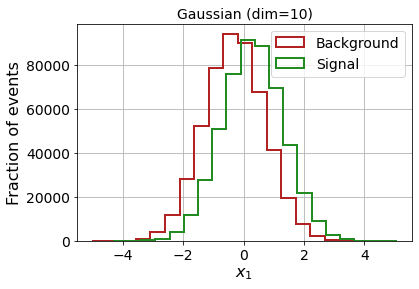

/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.67048	validation_1-logloss:0.67088
[1]	validation_0-logloss:0.64981	validation_1-logloss:0.65051
[2]	validation_0-logloss:0.63142	validation_1-logloss:0.63234
[3]	validation_0-logloss:0.61487	validation_1-logloss:0.61604
[4]	validation_0-logloss:0.59976	validation_1-logloss:0.60118
[5]	validation_0-logloss:0.58604	validation_1-logloss:0.58765
[6]	validation_0-logloss:0.57356	validation_1-logloss:0.57537
[7]	validation_0-logloss:0.56208	validation_1-logloss:0.56404
[8]	validation_0-logloss:0.55150	validation_1-logloss:0.55362
[9]	validation_0-logloss:0.54168	validation_1-logloss:0.54400
[10]	validation_0-logloss:0.53270	validation_1-logloss:0.53517
[11]	validation_0-logloss:0.52437	validation_1-logloss:0.52697
[12]	validation_0-logloss:0.51657	validation_1-logloss:0.51928
[13]	validation_0-logloss:0.50939	validation_1-logloss:0.51222
[14]	validation_0-logloss:0.50270	validation_1-logloss:0.50568
[15]	validation_0-logloss:0.49644	validation_1-logloss:0.49956
[1

[130]	validation_0-logloss:0.37685	validation_1-logloss:0.38452
[131]	validation_0-logloss:0.37677	validation_1-logloss:0.38447
[132]	validation_0-logloss:0.37669	validation_1-logloss:0.38442
[133]	validation_0-logloss:0.37661	validation_1-logloss:0.38436
[134]	validation_0-logloss:0.37654	validation_1-logloss:0.38431
[135]	validation_0-logloss:0.37647	validation_1-logloss:0.38426
[136]	validation_0-logloss:0.37639	validation_1-logloss:0.38421
[137]	validation_0-logloss:0.37631	validation_1-logloss:0.38416
[138]	validation_0-logloss:0.37625	validation_1-logloss:0.38411
[139]	validation_0-logloss:0.37618	validation_1-logloss:0.38407
[140]	validation_0-logloss:0.37611	validation_1-logloss:0.38403
[141]	validation_0-logloss:0.37606	validation_1-logloss:0.38399
[142]	validation_0-logloss:0.37600	validation_1-logloss:0.38394
[143]	validation_0-logloss:0.37594	validation_1-logloss:0.38390
[144]	validation_0-logloss:0.37587	validation_1-logloss:0.38386
[145]	validation_0-logloss:0.37581	valid

[259]	validation_0-logloss:0.37293	validation_1-logloss:0.38283
[260]	validation_0-logloss:0.37292	validation_1-logloss:0.38283
[261]	validation_0-logloss:0.37290	validation_1-logloss:0.38283
[262]	validation_0-logloss:0.37289	validation_1-logloss:0.38283
[263]	validation_0-logloss:0.37289	validation_1-logloss:0.38283
[264]	validation_0-logloss:0.37288	validation_1-logloss:0.38283
[265]	validation_0-logloss:0.37286	validation_1-logloss:0.38283
[266]	validation_0-logloss:0.37285	validation_1-logloss:0.38283
[267]	validation_0-logloss:0.37284	validation_1-logloss:0.38283
[268]	validation_0-logloss:0.37283	validation_1-logloss:0.38283
[269]	validation_0-logloss:0.37282	validation_1-logloss:0.38284
[270]	validation_0-logloss:0.37281	validation_1-logloss:0.38284
[271]	validation_0-logloss:0.37279	validation_1-logloss:0.38284
[272]	validation_0-logloss:0.37278	validation_1-logloss:0.38284
[273]	validation_0-logloss:0.37277	validation_1-logloss:0.38283
[274]	validation_0-logloss:0.37276	valid

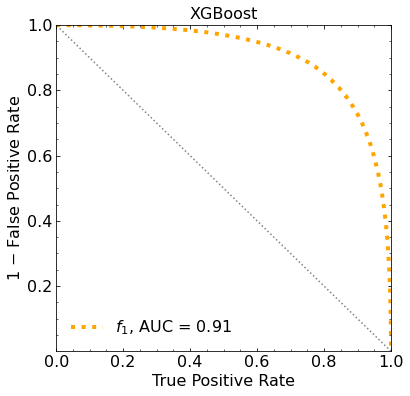

ML iteration 0


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.66910	validation_1-logloss:0.67048
[1]	validation_0-logloss:0.64777	validation_1-logloss:0.65018
[2]	validation_0-logloss:0.62844	validation_1-logloss:0.63150
[3]	validation_0-logloss:0.61113	validation_1-logloss:0.61505
[4]	validation_0-logloss:0.59538	validation_1-logloss:0.59997
[5]	validation_0-logloss:0.58094	validation_1-logloss:0.58634
[6]	validation_0-logloss:0.56782	validation_1-logloss:0.57386
[7]	validation_0-logloss:0.55584	validation_1-logloss:0.56256
[8]	validation_0-logloss:0.54478	validation_1-logloss:0.55198
[9]	validation_0-logloss:0.53461	validation_1-logloss:0.54244
[10]	validation_0-logloss:0.52514	validation_1-logloss:0.53347
[11]	validation_0-logloss:0.51642	validation_1-logloss:0.52529
[12]	validation_0-logloss:0.50823	validation_1-logloss:0.51753
[13]	validation_0-logloss:0.50067	validation_1-logloss:0.51057
[14]	validation_0-logloss:0.49365	validation_1-logloss:0.50401
[15]	validation_0-logloss:0.48716	validation_1-logloss:0.49800
[1

[130]	validation_0-logloss:0.35501	validation_1-logloss:0.38788
[131]	validation_0-logloss:0.35487	validation_1-logloss:0.38783
[132]	validation_0-logloss:0.35472	validation_1-logloss:0.38777
[133]	validation_0-logloss:0.35457	validation_1-logloss:0.38774
[134]	validation_0-logloss:0.35441	validation_1-logloss:0.38772
[135]	validation_0-logloss:0.35423	validation_1-logloss:0.38770
[136]	validation_0-logloss:0.35406	validation_1-logloss:0.38767
[137]	validation_0-logloss:0.35395	validation_1-logloss:0.38765
[138]	validation_0-logloss:0.35380	validation_1-logloss:0.38763
[139]	validation_0-logloss:0.35368	validation_1-logloss:0.38761
[140]	validation_0-logloss:0.35355	validation_1-logloss:0.38759
[141]	validation_0-logloss:0.35338	validation_1-logloss:0.38756
[142]	validation_0-logloss:0.35319	validation_1-logloss:0.38754
[143]	validation_0-logloss:0.35309	validation_1-logloss:0.38752
[144]	validation_0-logloss:0.35304	validation_1-logloss:0.38751
[145]	validation_0-logloss:0.35293	valid

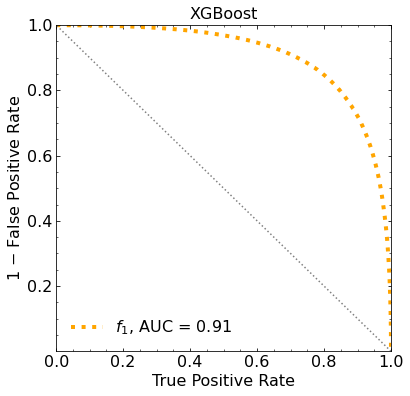

ML iteration  1


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.66898	validation_1-logloss:0.67025
[1]	validation_0-logloss:0.64740	validation_1-logloss:0.64956
[2]	validation_0-logloss:0.62789	validation_1-logloss:0.63118
[3]	validation_0-logloss:0.61030	validation_1-logloss:0.61447
[4]	validation_0-logloss:0.59444	validation_1-logloss:0.59951
[5]	validation_0-logloss:0.57989	validation_1-logloss:0.58583
[6]	validation_0-logloss:0.56666	validation_1-logloss:0.57337
[7]	validation_0-logloss:0.55444	validation_1-logloss:0.56190
[8]	validation_0-logloss:0.54323	validation_1-logloss:0.55149
[9]	validation_0-logloss:0.53279	validation_1-logloss:0.54177
[10]	validation_0-logloss:0.52318	validation_1-logloss:0.53284
[11]	validation_0-logloss:0.51426	validation_1-logloss:0.52460
[12]	validation_0-logloss:0.50591	validation_1-logloss:0.51686
[13]	validation_0-logloss:0.49816	validation_1-logloss:0.50969
[14]	validation_0-logloss:0.49099	validation_1-logloss:0.50315
[15]	validation_0-logloss:0.48422	validation_1-logloss:0.49691
[1

[130]	validation_0-logloss:0.34987	validation_1-logloss:0.38762
[131]	validation_0-logloss:0.34973	validation_1-logloss:0.38758
[132]	validation_0-logloss:0.34957	validation_1-logloss:0.38754
[133]	validation_0-logloss:0.34938	validation_1-logloss:0.38750
[134]	validation_0-logloss:0.34926	validation_1-logloss:0.38747
[135]	validation_0-logloss:0.34910	validation_1-logloss:0.38743
[136]	validation_0-logloss:0.34894	validation_1-logloss:0.38741
[137]	validation_0-logloss:0.34877	validation_1-logloss:0.38739
[138]	validation_0-logloss:0.34861	validation_1-logloss:0.38737
[139]	validation_0-logloss:0.34841	validation_1-logloss:0.38733
[140]	validation_0-logloss:0.34823	validation_1-logloss:0.38730
[141]	validation_0-logloss:0.34810	validation_1-logloss:0.38728
[142]	validation_0-logloss:0.34793	validation_1-logloss:0.38727
[143]	validation_0-logloss:0.34776	validation_1-logloss:0.38725
[144]	validation_0-logloss:0.34768	validation_1-logloss:0.38723
[145]	validation_0-logloss:0.34756	valid

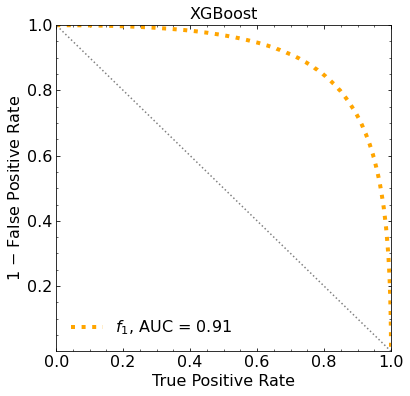

ML iteration  2


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.66919	validation_1-logloss:0.67044
[1]	validation_0-logloss:0.64784	validation_1-logloss:0.64994
[2]	validation_0-logloss:0.62850	validation_1-logloss:0.63165
[3]	validation_0-logloss:0.61128	validation_1-logloss:0.61530
[4]	validation_0-logloss:0.59543	validation_1-logloss:0.60024
[5]	validation_0-logloss:0.58095	validation_1-logloss:0.58647
[6]	validation_0-logloss:0.56766	validation_1-logloss:0.57387
[7]	validation_0-logloss:0.55552	validation_1-logloss:0.56245
[8]	validation_0-logloss:0.54443	validation_1-logloss:0.55201
[9]	validation_0-logloss:0.53421	validation_1-logloss:0.54238
[10]	validation_0-logloss:0.52467	validation_1-logloss:0.53347
[11]	validation_0-logloss:0.51589	validation_1-logloss:0.52524
[12]	validation_0-logloss:0.50772	validation_1-logloss:0.51761
[13]	validation_0-logloss:0.50008	validation_1-logloss:0.51048
[14]	validation_0-logloss:0.49299	validation_1-logloss:0.50394
[15]	validation_0-logloss:0.48638	validation_1-logloss:0.49780
[1

[130]	validation_0-logloss:0.35313	validation_1-logloss:0.38782
[131]	validation_0-logloss:0.35295	validation_1-logloss:0.38778
[132]	validation_0-logloss:0.35281	validation_1-logloss:0.38775
[133]	validation_0-logloss:0.35268	validation_1-logloss:0.38771
[134]	validation_0-logloss:0.35251	validation_1-logloss:0.38769
[135]	validation_0-logloss:0.35232	validation_1-logloss:0.38767
[136]	validation_0-logloss:0.35214	validation_1-logloss:0.38764
[137]	validation_0-logloss:0.35200	validation_1-logloss:0.38761
[138]	validation_0-logloss:0.35187	validation_1-logloss:0.38758
[139]	validation_0-logloss:0.35173	validation_1-logloss:0.38756
[140]	validation_0-logloss:0.35154	validation_1-logloss:0.38754
[141]	validation_0-logloss:0.35140	validation_1-logloss:0.38751
[142]	validation_0-logloss:0.35130	validation_1-logloss:0.38749
[143]	validation_0-logloss:0.35117	validation_1-logloss:0.38750
[144]	validation_0-logloss:0.35104	validation_1-logloss:0.38749
[145]	validation_0-logloss:0.35096	valid

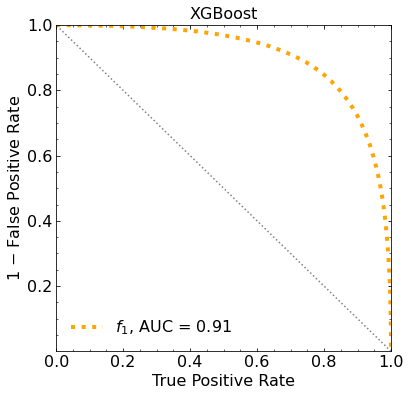

ML iteration  3


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.66929	validation_1-logloss:0.67045
[1]	validation_0-logloss:0.64782	validation_1-logloss:0.64999
[2]	validation_0-logloss:0.62868	validation_1-logloss:0.63158
[3]	validation_0-logloss:0.61138	validation_1-logloss:0.61516
[4]	validation_0-logloss:0.59562	validation_1-logloss:0.60015
[5]	validation_0-logloss:0.58130	validation_1-logloss:0.58645
[6]	validation_0-logloss:0.56815	validation_1-logloss:0.57391
[7]	validation_0-logloss:0.55610	validation_1-logloss:0.56258
[8]	validation_0-logloss:0.54498	validation_1-logloss:0.55202
[9]	validation_0-logloss:0.53480	validation_1-logloss:0.54245
[10]	validation_0-logloss:0.52534	validation_1-logloss:0.53362
[11]	validation_0-logloss:0.51652	validation_1-logloss:0.52538
[12]	validation_0-logloss:0.50848	validation_1-logloss:0.51783
[13]	validation_0-logloss:0.50094	validation_1-logloss:0.51079
[14]	validation_0-logloss:0.49381	validation_1-logloss:0.50418
[15]	validation_0-logloss:0.48718	validation_1-logloss:0.49800
[1

[130]	validation_0-logloss:0.35332	validation_1-logloss:0.38753
[131]	validation_0-logloss:0.35319	validation_1-logloss:0.38751
[132]	validation_0-logloss:0.35306	validation_1-logloss:0.38748
[133]	validation_0-logloss:0.35291	validation_1-logloss:0.38746
[134]	validation_0-logloss:0.35270	validation_1-logloss:0.38743
[135]	validation_0-logloss:0.35253	validation_1-logloss:0.38742
[136]	validation_0-logloss:0.35240	validation_1-logloss:0.38739
[137]	validation_0-logloss:0.35227	validation_1-logloss:0.38737
[138]	validation_0-logloss:0.35213	validation_1-logloss:0.38733
[139]	validation_0-logloss:0.35201	validation_1-logloss:0.38732
[140]	validation_0-logloss:0.35186	validation_1-logloss:0.38730
[141]	validation_0-logloss:0.35176	validation_1-logloss:0.38728
[142]	validation_0-logloss:0.35164	validation_1-logloss:0.38725
[143]	validation_0-logloss:0.35157	validation_1-logloss:0.38723
[144]	validation_0-logloss:0.35141	validation_1-logloss:0.38722
[145]	validation_0-logloss:0.35122	valid

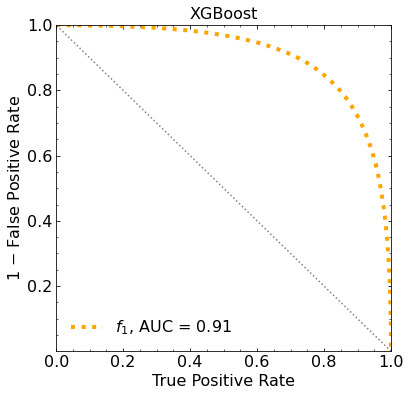

ML iteration  4


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.66912	validation_1-logloss:0.67037
[1]	validation_0-logloss:0.64764	validation_1-logloss:0.65000
[2]	validation_0-logloss:0.62838	validation_1-logloss:0.63168
[3]	validation_0-logloss:0.61094	validation_1-logloss:0.61497
[4]	validation_0-logloss:0.59516	validation_1-logloss:0.60003
[5]	validation_0-logloss:0.58078	validation_1-logloss:0.58639
[6]	validation_0-logloss:0.56758	validation_1-logloss:0.57400
[7]	validation_0-logloss:0.55557	validation_1-logloss:0.56256
[8]	validation_0-logloss:0.54447	validation_1-logloss:0.55211
[9]	validation_0-logloss:0.53423	validation_1-logloss:0.54248
[10]	validation_0-logloss:0.52468	validation_1-logloss:0.53355
[11]	validation_0-logloss:0.51584	validation_1-logloss:0.52527
[12]	validation_0-logloss:0.50771	validation_1-logloss:0.51762
[13]	validation_0-logloss:0.50003	validation_1-logloss:0.51053
[14]	validation_0-logloss:0.49296	validation_1-logloss:0.50399
[15]	validation_0-logloss:0.48629	validation_1-logloss:0.49784
[1

[130]	validation_0-logloss:0.35456	validation_1-logloss:0.38757
[131]	validation_0-logloss:0.35438	validation_1-logloss:0.38751
[132]	validation_0-logloss:0.35424	validation_1-logloss:0.38748
[133]	validation_0-logloss:0.35410	validation_1-logloss:0.38744
[134]	validation_0-logloss:0.35394	validation_1-logloss:0.38739
[135]	validation_0-logloss:0.35377	validation_1-logloss:0.38735
[136]	validation_0-logloss:0.35358	validation_1-logloss:0.38732
[137]	validation_0-logloss:0.35342	validation_1-logloss:0.38729
[138]	validation_0-logloss:0.35327	validation_1-logloss:0.38726
[139]	validation_0-logloss:0.35314	validation_1-logloss:0.38723
[140]	validation_0-logloss:0.35297	validation_1-logloss:0.38721
[141]	validation_0-logloss:0.35287	validation_1-logloss:0.38720
[142]	validation_0-logloss:0.35267	validation_1-logloss:0.38716
[143]	validation_0-logloss:0.35257	validation_1-logloss:0.38715
[144]	validation_0-logloss:0.35245	validation_1-logloss:0.38712
[145]	validation_0-logloss:0.35236	valid

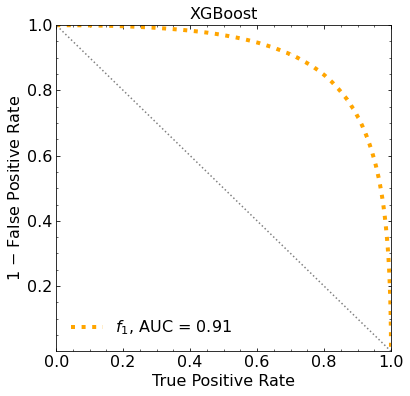

ML iteration  5


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.66889	validation_1-logloss:0.67028
[1]	validation_0-logloss:0.64731	validation_1-logloss:0.64969
[2]	validation_0-logloss:0.62802	validation_1-logloss:0.63150
[3]	validation_0-logloss:0.61066	validation_1-logloss:0.61497
[4]	validation_0-logloss:0.59472	validation_1-logloss:0.59998
[5]	validation_0-logloss:0.58027	validation_1-logloss:0.58626
[6]	validation_0-logloss:0.56707	validation_1-logloss:0.57375
[7]	validation_0-logloss:0.55492	validation_1-logloss:0.56230
[8]	validation_0-logloss:0.54382	validation_1-logloss:0.55183
[9]	validation_0-logloss:0.53355	validation_1-logloss:0.54223
[10]	validation_0-logloss:0.52411	validation_1-logloss:0.53330
[11]	validation_0-logloss:0.51538	validation_1-logloss:0.52513
[12]	validation_0-logloss:0.50727	validation_1-logloss:0.51751
[13]	validation_0-logloss:0.49971	validation_1-logloss:0.51047
[14]	validation_0-logloss:0.49259	validation_1-logloss:0.50385
[15]	validation_0-logloss:0.48603	validation_1-logloss:0.49775
[1

[130]	validation_0-logloss:0.35330	validation_1-logloss:0.38761
[131]	validation_0-logloss:0.35319	validation_1-logloss:0.38759
[132]	validation_0-logloss:0.35299	validation_1-logloss:0.38754
[133]	validation_0-logloss:0.35281	validation_1-logloss:0.38751
[134]	validation_0-logloss:0.35267	validation_1-logloss:0.38748
[135]	validation_0-logloss:0.35253	validation_1-logloss:0.38746
[136]	validation_0-logloss:0.35236	validation_1-logloss:0.38742
[137]	validation_0-logloss:0.35225	validation_1-logloss:0.38739
[138]	validation_0-logloss:0.35208	validation_1-logloss:0.38736
[139]	validation_0-logloss:0.35197	validation_1-logloss:0.38733
[140]	validation_0-logloss:0.35181	validation_1-logloss:0.38732
[141]	validation_0-logloss:0.35170	validation_1-logloss:0.38729
[142]	validation_0-logloss:0.35160	validation_1-logloss:0.38727
[143]	validation_0-logloss:0.35151	validation_1-logloss:0.38725
[144]	validation_0-logloss:0.35137	validation_1-logloss:0.38723
[145]	validation_0-logloss:0.35129	valid

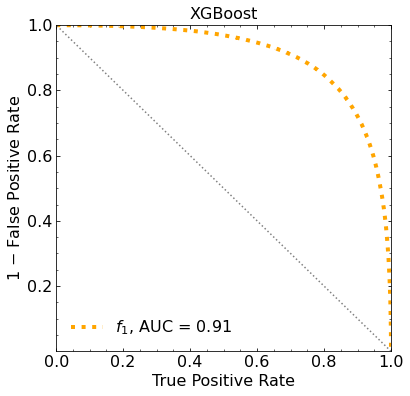

ML iteration  6


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.66895	validation_1-logloss:0.67027
[1]	validation_0-logloss:0.64754	validation_1-logloss:0.64991
[2]	validation_0-logloss:0.62838	validation_1-logloss:0.63155
[3]	validation_0-logloss:0.61114	validation_1-logloss:0.61515
[4]	validation_0-logloss:0.59523	validation_1-logloss:0.60006
[5]	validation_0-logloss:0.58076	validation_1-logloss:0.58637
[6]	validation_0-logloss:0.56751	validation_1-logloss:0.57388
[7]	validation_0-logloss:0.55539	validation_1-logloss:0.56247
[8]	validation_0-logloss:0.54413	validation_1-logloss:0.55198
[9]	validation_0-logloss:0.53403	validation_1-logloss:0.54245
[10]	validation_0-logloss:0.52441	validation_1-logloss:0.53354
[11]	validation_0-logloss:0.51565	validation_1-logloss:0.52529
[12]	validation_0-logloss:0.50742	validation_1-logloss:0.51758
[13]	validation_0-logloss:0.49981	validation_1-logloss:0.51059
[14]	validation_0-logloss:0.49273	validation_1-logloss:0.50399
[15]	validation_0-logloss:0.48621	validation_1-logloss:0.49790
[1

[130]	validation_0-logloss:0.35298	validation_1-logloss:0.38777
[131]	validation_0-logloss:0.35283	validation_1-logloss:0.38777
[132]	validation_0-logloss:0.35267	validation_1-logloss:0.38773
[133]	validation_0-logloss:0.35250	validation_1-logloss:0.38771
[134]	validation_0-logloss:0.35237	validation_1-logloss:0.38768
[135]	validation_0-logloss:0.35221	validation_1-logloss:0.38766
[136]	validation_0-logloss:0.35206	validation_1-logloss:0.38763
[137]	validation_0-logloss:0.35193	validation_1-logloss:0.38760
[138]	validation_0-logloss:0.35179	validation_1-logloss:0.38758
[139]	validation_0-logloss:0.35166	validation_1-logloss:0.38756
[140]	validation_0-logloss:0.35152	validation_1-logloss:0.38754
[141]	validation_0-logloss:0.35143	validation_1-logloss:0.38752
[142]	validation_0-logloss:0.35125	validation_1-logloss:0.38750
[143]	validation_0-logloss:0.35110	validation_1-logloss:0.38747
[144]	validation_0-logloss:0.35098	validation_1-logloss:0.38745
[145]	validation_0-logloss:0.35085	valid

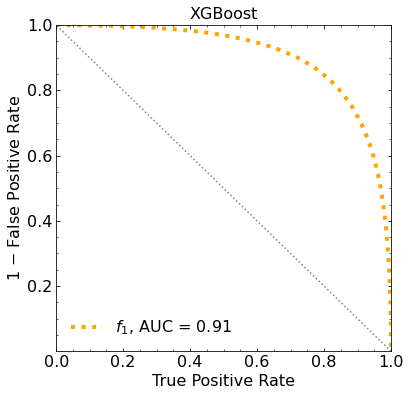

ML iteration  7


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.66943	validation_1-logloss:0.67046
[1]	validation_0-logloss:0.64806	validation_1-logloss:0.65001
[2]	validation_0-logloss:0.62865	validation_1-logloss:0.63173
[3]	validation_0-logloss:0.61135	validation_1-logloss:0.61520
[4]	validation_0-logloss:0.59560	validation_1-logloss:0.60016
[5]	validation_0-logloss:0.58105	validation_1-logloss:0.58647
[6]	validation_0-logloss:0.56785	validation_1-logloss:0.57393
[7]	validation_0-logloss:0.55575	validation_1-logloss:0.56247
[8]	validation_0-logloss:0.54457	validation_1-logloss:0.55188
[9]	validation_0-logloss:0.53440	validation_1-logloss:0.54233
[10]	validation_0-logloss:0.52492	validation_1-logloss:0.53339
[11]	validation_0-logloss:0.51610	validation_1-logloss:0.52521
[12]	validation_0-logloss:0.50788	validation_1-logloss:0.51752
[13]	validation_0-logloss:0.50028	validation_1-logloss:0.51038
[14]	validation_0-logloss:0.49317	validation_1-logloss:0.50379
[15]	validation_0-logloss:0.48656	validation_1-logloss:0.49761
[1

[130]	validation_0-logloss:0.35215	validation_1-logloss:0.38746
[131]	validation_0-logloss:0.35202	validation_1-logloss:0.38741
[132]	validation_0-logloss:0.35180	validation_1-logloss:0.38737
[133]	validation_0-logloss:0.35167	validation_1-logloss:0.38734
[134]	validation_0-logloss:0.35153	validation_1-logloss:0.38730
[135]	validation_0-logloss:0.35135	validation_1-logloss:0.38727
[136]	validation_0-logloss:0.35117	validation_1-logloss:0.38726
[137]	validation_0-logloss:0.35099	validation_1-logloss:0.38723
[138]	validation_0-logloss:0.35082	validation_1-logloss:0.38721
[139]	validation_0-logloss:0.35070	validation_1-logloss:0.38719
[140]	validation_0-logloss:0.35051	validation_1-logloss:0.38716
[141]	validation_0-logloss:0.35037	validation_1-logloss:0.38714
[142]	validation_0-logloss:0.35017	validation_1-logloss:0.38710
[143]	validation_0-logloss:0.35005	validation_1-logloss:0.38709
[144]	validation_0-logloss:0.34996	validation_1-logloss:0.38708
[145]	validation_0-logloss:0.34983	valid

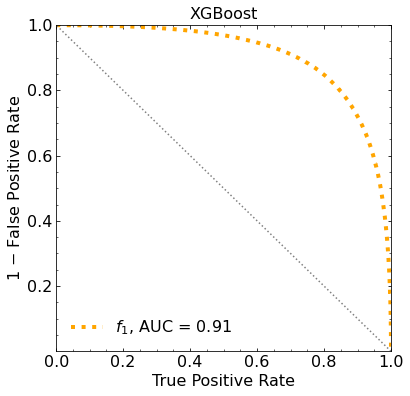

ML iteration  8


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.66937	validation_1-logloss:0.67045
[1]	validation_0-logloss:0.64789	validation_1-logloss:0.64992
[2]	validation_0-logloss:0.62863	validation_1-logloss:0.63147
[3]	validation_0-logloss:0.61123	validation_1-logloss:0.61489
[4]	validation_0-logloss:0.59547	validation_1-logloss:0.60000
[5]	validation_0-logloss:0.58100	validation_1-logloss:0.58638
[6]	validation_0-logloss:0.56788	validation_1-logloss:0.57390
[7]	validation_0-logloss:0.55585	validation_1-logloss:0.56253
[8]	validation_0-logloss:0.54464	validation_1-logloss:0.55210
[9]	validation_0-logloss:0.53429	validation_1-logloss:0.54242
[10]	validation_0-logloss:0.52489	validation_1-logloss:0.53353
[11]	validation_0-logloss:0.51610	validation_1-logloss:0.52526
[12]	validation_0-logloss:0.50798	validation_1-logloss:0.51770
[13]	validation_0-logloss:0.50036	validation_1-logloss:0.51061
[14]	validation_0-logloss:0.49323	validation_1-logloss:0.50401
[15]	validation_0-logloss:0.48648	validation_1-logloss:0.49775
[1

[130]	validation_0-logloss:0.35214	validation_1-logloss:0.38757
[131]	validation_0-logloss:0.35192	validation_1-logloss:0.38754
[132]	validation_0-logloss:0.35175	validation_1-logloss:0.38751
[133]	validation_0-logloss:0.35161	validation_1-logloss:0.38748
[134]	validation_0-logloss:0.35147	validation_1-logloss:0.38745
[135]	validation_0-logloss:0.35132	validation_1-logloss:0.38742
[136]	validation_0-logloss:0.35123	validation_1-logloss:0.38742
[137]	validation_0-logloss:0.35108	validation_1-logloss:0.38740
[138]	validation_0-logloss:0.35095	validation_1-logloss:0.38738
[139]	validation_0-logloss:0.35083	validation_1-logloss:0.38737
[140]	validation_0-logloss:0.35067	validation_1-logloss:0.38735
[141]	validation_0-logloss:0.35057	validation_1-logloss:0.38733
[142]	validation_0-logloss:0.35040	validation_1-logloss:0.38731
[143]	validation_0-logloss:0.35022	validation_1-logloss:0.38729
[144]	validation_0-logloss:0.35012	validation_1-logloss:0.38728
[145]	validation_0-logloss:0.35002	valid

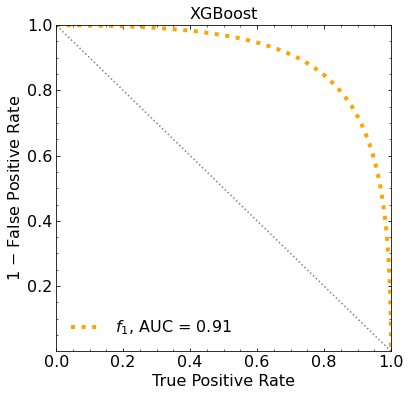

ML iteration  9


/home/andres/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[0]	validation_0-logloss:0.66922	validation_1-logloss:0.67043
[1]	validation_0-logloss:0.64772	validation_1-logloss:0.64990
[2]	validation_0-logloss:0.62861	validation_1-logloss:0.63170
[3]	validation_0-logloss:0.61135	validation_1-logloss:0.61522
[4]	validation_0-logloss:0.59567	validation_1-logloss:0.60037
[5]	validation_0-logloss:0.58147	validation_1-logloss:0.58679
[6]	validation_0-logloss:0.56820	validation_1-logloss:0.57426
[7]	validation_0-logloss:0.55625	validation_1-logloss:0.56284
[8]	validation_0-logloss:0.54531	validation_1-logloss:0.55248
[9]	validation_0-logloss:0.53501	validation_1-logloss:0.54270
[10]	validation_0-logloss:0.52562	validation_1-logloss:0.53387
[11]	validation_0-logloss:0.51696	validation_1-logloss:0.52563
[12]	validation_0-logloss:0.50886	validation_1-logloss:0.51797
[13]	validation_0-logloss:0.50131	validation_1-logloss:0.51096
[14]	validation_0-logloss:0.49425	validation_1-logloss:0.50435
[15]	validation_0-logloss:0.48770	validation_1-logloss:0.49831
[1

[130]	validation_0-logloss:0.35536	validation_1-logloss:0.38754
[131]	validation_0-logloss:0.35524	validation_1-logloss:0.38751
[132]	validation_0-logloss:0.35506	validation_1-logloss:0.38747
[133]	validation_0-logloss:0.35494	validation_1-logloss:0.38744
[134]	validation_0-logloss:0.35478	validation_1-logloss:0.38740
[135]	validation_0-logloss:0.35464	validation_1-logloss:0.38738
[136]	validation_0-logloss:0.35447	validation_1-logloss:0.38735
[137]	validation_0-logloss:0.35433	validation_1-logloss:0.38732
[138]	validation_0-logloss:0.35421	validation_1-logloss:0.38730
[139]	validation_0-logloss:0.35411	validation_1-logloss:0.38728
[140]	validation_0-logloss:0.35398	validation_1-logloss:0.38726
[141]	validation_0-logloss:0.35382	validation_1-logloss:0.38723
[142]	validation_0-logloss:0.35370	validation_1-logloss:0.38724
[143]	validation_0-logloss:0.35351	validation_1-logloss:0.38723
[144]	validation_0-logloss:0.35339	validation_1-logloss:0.38721
[145]	validation_0-logloss:0.35326	valid

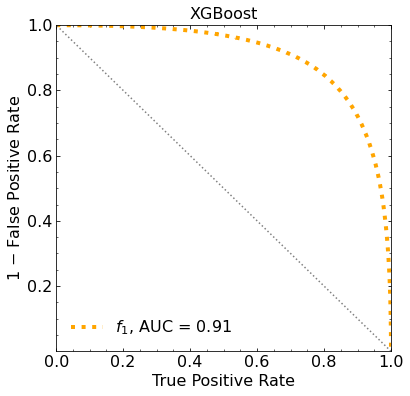

Classification score (1 ML):


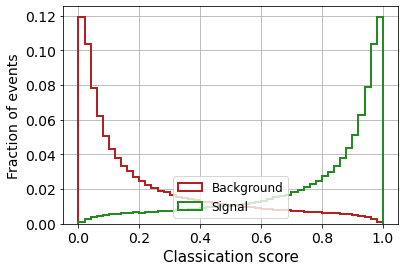

Classification score (10 ML):


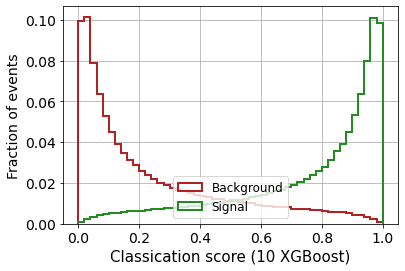

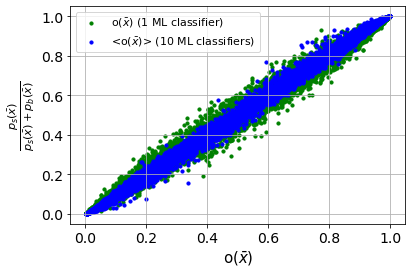


 ----------------------------------------- 

B_expected:  50000
S_expected:  500
S/$\sqrt{B}$:  2.23606797749979
 BINNED CLASSIFIER OUTPUT
  BL lineal bins, 1 ML
Z_XG 10 bins_1ML:  7.0478325252342815
Z_XG 25 bins_1ML:  8.13882096560863
Z_XG 50 bins_1ML:  8.576076919390607
Z_XG 100 bins_1ML:  8.744154511004437

 BL non-lineal bins, 1 ML
Z_XG 10 bins_eq_1ML:  5.092982887212296
Z_XG 25 bins_eq_1ML:  6.1663884711430015
Z_XG 50 bins_eq_1ML:  6.884977872735692
Z_XG 100 bins_eq_1ML:  7.464884764890919

 BL lineal bins, 10 ML
Z_XG 10 bins:  7.236744771544328
Z_XG 25 bins:  8.297640995519123
Z_XG 50 bins:  8.657340754003434
Z_XG 100 bins:  8.844926191014832

 BL non-lineal bins, 10 ML
Z_XG 10 bins_eq:  5.103352962789307
Z_XG 25 bins_eq:  6.194574320963936
Z_XG 50 bins_eq:  6.910951113601046
Z_XG 100 bins_eq:  7.484061173391551

 ----------------------------------------- 


 If  20200  =  1101    then the proposed range has to be extended
n_ensembles (actual):  9863
TRUE PDF LIKELIHOOD (GAUSSIA

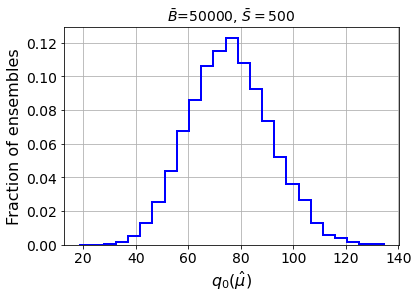

muhat mean:  0.07789719152387714
Z_gaussian:  8.692737396440467
Z_gaussian_mu0:  8.67809824192856

 ------------------------------------ 

 MLL + KDE (1ML) 


/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf  1909.45990486  1926.41385933  1933.96663593
  1934.84581365  1929.61079777  1918.10887556  1896.38490814
  1858.8598405   1802.94768391  1719.97641907  1605.55421237
  1446.33607869  1224.21997543   938.17868093   572.50597095
   110.08918535  -453.55734989 -1128.71154128 -2045.94431945]
  warnings.warn(
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:929: RuntimeWarning: invalid value encountered in subtract
  array_stds = np.sqrt(np.average((array -
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf           -inf  1954.86396441
  1957.91378805  1956.44088324  1945.8435392   1923.58721657
  1888.31040285  1833.90970064  1751.54997831  1631.24560644
  14

KDE Kernel:  epanechnikov
Background bandwidth:  0.004386370005779536
Signal bandwidth:  0.004386370005779536


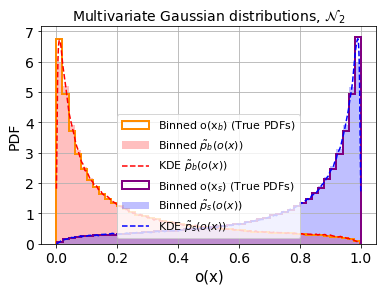

 MLL + KDE (10ML) 


/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf  1826.64876126  1834.80067378
  1837.3458696   1837.25564636  1829.11636999  1812.12307376
  1781.91238998  1733.83007184  1661.00479494  1556.81423528
  1413.07296479  1208.47606344   934.04208767   586.85441496
   141.87524649  -413.41706008 -1090.40054651 -2028.89912754]
  warnings.warn(
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:929: RuntimeWarning: invalid value encountered in subtract
  array_stds = np.sqrt(np.average((array -
/home/andres/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [          -inf           -inf  1841.13460116  1850.93022894
  1857.05615442  1856.8824268   1849.48731171  1834.0624009
  1805.86285145  1759.16154334  1687.14491046  1580.8312699
  1423

KDE Kernel:  epanechnikov
Background bandwidth:  0.004386370005779536
Signal bandwidth:  0.004386370005779536


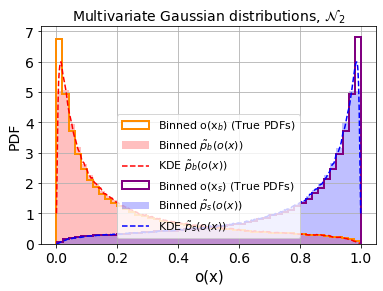

 Z MLL+KDE (1ML) 


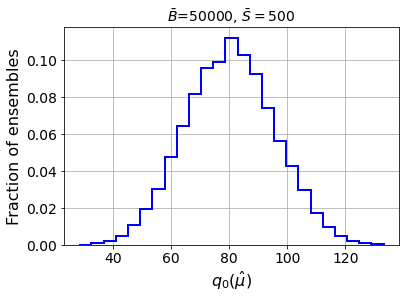

muhat mean_1ML:  0.03555206326675454
Z_KDE_1ML:  8.96485510346065
Z_KDE mu=0_1ML:  8.965974294372547

 Z MLL+KDE (10ML) 


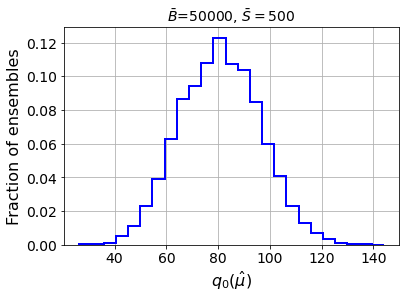

muhat mean:  0.03738720470445098
Z_KDE:  8.99131317398871
Z_KDE mu=0:  8.992592426446693

 ------------------------------------ 



In [126]:
dim=10

#######################
# generate the events #
#######################
    
mean_sig = epsilon*np.ones(dim)
mean_bkg = -1*mean_sig

#cov_sig = np.identity(dim)
cov_sig = np.identity(dim) + (0. * ( np.ones((dim,dim)) - np.identity(dim) ))
cov_bkg = cov_sig

signal_X_1, signal_X_2, signal_X_3, signal_X_4, signal_X_5, signal_X_6, signal_X_7, signal_X_8, signal_X_9, signal_X_10 = np.random.multivariate_normal(mean_sig, cov_sig, N).T
background_X_1, background_X_2, background_X_3, background_X_4, background_X_5, background_X_6, background_X_7, background_X_8, background_X_9, background_X_10 = np.random.multivariate_normal(mean_bkg, cov_bkg, N).T


dim1 = np.concatenate((background_X_1,signal_X_1))
dim2 = np.concatenate((background_X_2,signal_X_2))
dim3 = np.concatenate((background_X_3,signal_X_3))
dim4 = np.concatenate((background_X_4,signal_X_4))
dim5 = np.concatenate((background_X_5,signal_X_5))
dim6 = np.concatenate((background_X_6,signal_X_6))
dim7 = np.concatenate((background_X_7,signal_X_7))
dim8 = np.concatenate((background_X_8,signal_X_8))
dim9 = np.concatenate((background_X_9,signal_X_9))
dim10 = np.concatenate((background_X_10,signal_X_10))

# labels
background_Y = np.zeros(N)
signal_Y = np.ones(N)

# DATA in a single matrix (features + labels)
df = pd.DataFrame()
df['dim1'] = dim1.reshape(-1)
df['dim2'] = dim2.reshape(-1)
df['dim3'] = dim3.reshape(-1)
df['dim4'] = dim4.reshape(-1)
df['dim5'] = dim5.reshape(-1)
df['dim6'] = dim6.reshape(-1)
df['dim7'] = dim7.reshape(-1)
df['dim8'] = dim8.reshape(-1)
df['dim9'] = dim9.reshape(-1)
df['dim10'] = dim10.reshape(-1)
df['Y'] = np.concatenate((background_Y.astype('int'),signal_Y.astype('int')))

X_gauss = df[['dim1','dim2','dim3','dim4','dim5','dim6','dim7','dim8','dim9','dim10']].values 
Y_gauss = df[['Y']].values

# divide into train-val and test data samples
test_ratio = 1./3
val_ratio = 0.5

X_gauss_aux, X_gauss_test, Y_gauss_aux, Y_gauss_test = train_test_split(X_gauss,
                                                                Y_gauss,
                                                                test_size=test_ratio,
                                                                random_state=42,
                                                                #stratify = y_gauss,
                                                                shuffle=True)


X_gauss_train, X_gauss_val, Y_gauss_train, Y_gauss_val = train_test_split(X_gauss_aux,
                                                                  Y_gauss_aux,
                                                                  test_size=val_ratio,
                                                                  random_state=42,
                                                                  #stratify = y_gauss_aux,
                                                                  shuffle=True)

print('')
print('X_gauss_train : ', X_gauss_train.shape)
print('y_gauss_train : ', Y_gauss_train.shape)
print('X_gauss_val : ', X_gauss_val.shape)
print('y_gauss_val : ', Y_gauss_val.shape)
print('X_gauss_test : ', X_gauss_test.shape)
print('y_gauss_test : ', Y_gauss_test.shape)
print('')


# PLOT (only 1st feature) to visualize the data
X_gauss_test_SM = []
X_gauss_test_NP = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] ==0:
        X_gauss_test_SM.append(X_gauss_test[i].tolist())
    else:
        X_gauss_test_NP.append(X_gauss_test[i].tolist())    


X_gauss_test_SM = np.array(X_gauss_test_SM)
X_gauss_test_NP = np.array(X_gauss_test_NP)


weights = np.ones_like(X_gauss_test_SM[:,0])/float(len(X_gauss_test_SM[:,0]))
plt.hist(X_gauss_test_SM[:,0], 20, histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(X_gauss_test_NP[:,0])/float(len(X_gauss_test_NP[:,0]))
plt.hist(X_gauss_test_NP[:,0], 20, histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$x_1$",fontsize=16)
plt.ylabel("Fraction of events",fontsize=16)
plt.grid()
plt.legend(fontsize=14)
plt.title(r"Gaussian (dim=%0.2d)" % dim,fontsize=14)
plt.show()  






################################
# the true pdfs (useful later) #
################################

sig_multi = multivariate_normal(mean_sig, cov_sig)
bkg_multi = multivariate_normal(mean_bkg, cov_bkg) 




#######################
# CLASSIFIER: XGBoost #
#######################

# only 1 ML
roc_auc_XG, y_pred_xg_1ML = XG(X_gauss_train, X_gauss_test, X_gauss_val, Y_gauss_train, Y_gauss_test, Y_gauss_val)

store_AUC.append(roc_auc_XG)


# Bagging

print('ML iteration 0')
roc_auc_XG, y_pred_xg_aux = XG(X_gauss_train[:100000], X_gauss_test, X_gauss_val, Y_gauss_train[:100000], Y_gauss_test, Y_gauss_val)
y_pred_xg_auxRE = np.reshape(y_pred_xg_aux, (1,len(y_pred_xg_aux)))

for it in range(1,iterations_ML):

    print('ML iteration ', it)
    roc_auc_XG, y_pred_xg_aux_it = XG(X_gauss_train[(100000*it):(100000*it)+100000], X_gauss_test, X_gauss_val, Y_gauss_train[(100000*it):(100000*it)+100000], Y_gauss_test, Y_gauss_val)
    
    y_pred_xg_auxRE_it = np.reshape(y_pred_xg_aux_it, (1,len(y_pred_xg_aux_it)))
    
    y_pred_xg_auxRE = np.concatenate([y_pred_xg_auxRE,y_pred_xg_auxRE_it])

# to smooth, mean of 10 predictions
y_pred_xg = np.mean(y_pred_xg_auxRE, axis=0)




########################
# CLASSIFICATION SCORE #
########################

# Outputs for validation data set

# 1 ML
pred_XG_SM_1ML = []
pred_XG_NP_1ML = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] == 0:
        pred_XG_SM_1ML.append(y_pred_xg_1ML[i])
    else:
        pred_XG_NP_1ML.append(y_pred_xg_1ML[i])
        
# Bagging  
pred_XG_SM = []
pred_XG_NP = []

for i in range(len(Y_gauss_test)):
    if Y_gauss_test[i] == 0:
        pred_XG_SM.append(y_pred_xg[i])
    else:
        pred_XG_NP.append(y_pred_xg[i])
        
        
print('Classification score (1 ML):')
        
weights = np.ones_like(pred_XG_SM_1ML)/float(len(pred_XG_SM_1ML))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM_1ML, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP_1ML)/float(len(pred_XG_NP_1ML))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP_1ML, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12, loc="lower center")
plt.show()


print('Classification score (10 ML):')
        
weights = np.ones_like(pred_XG_SM)/float(len(pred_XG_SM))
nSM, binsSM, patchesSM = plt.hist(pred_XG_SM, 50, weights=weights, range=[0,1], histtype='step', color='firebrick', linewidth=2, label='Background')

weights = np.ones_like(pred_XG_NP)/float(len(pred_XG_NP))
nNP, binsNP, patchesNP = plt.hist(pred_XG_NP, 50, weights=weights, range=[0,1], histtype='step', color='forestgreen', linewidth=2, label='Signal')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("Classication score (10 XGBoost)",fontsize=15)
plt.ylabel("Fraction of events",fontsize=14)
plt.grid()
plt.legend(fontsize=12, loc="lower center")
plt.show()




ratio_ps_pb_true = sig_multi.pdf(X_gauss_test) / ( sig_multi.pdf(X_gauss_test) + bkg_multi.pdf(X_gauss_test) )
ratio_ps_pb_true_B = sig_multi.pdf(X_gauss_test_SM) / ( sig_multi.pdf(X_gauss_test_SM) + bkg_multi.pdf(X_gauss_test_SM) )
ratio_ps_pb_true_S = sig_multi.pdf(X_gauss_test_NP) / ( sig_multi.pdf(X_gauss_test_NP) + bkg_multi.pdf(X_gauss_test_NP) )

plt.scatter(y_pred_xg_1ML[:10000], ratio_ps_pb_true[:10000], color='green', label=r'o($\bar{x}$) (1 ML classifier)', s=10)
plt.scatter(y_pred_xg[:10000], ratio_ps_pb_true[:10000], color='blue', label=r'<o($\bar{x}$)> (10 ML classifiers)', s=10)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r"o($\bar{x}$)",fontsize=15)
plt.ylabel(r"$\frac{p_s(\bar{x})}{p_s(\bar{x})+p_b(\bar{x})}$",fontsize=16)
plt.grid()
plt.legend(fontsize=11)
#plt.savefig('images/' + 'optimalclass-vs-ox.pdf', format="pdf", bbox_inches="tight")
plt.show()

print('\n ----------------------------------------- \n')






###########
# METHODS #
###########

print('B_expected: ', B_expected)
print('S_expected: ', S_expected)
print(r'S/$\sqrt{B}$: ', SsqrtB)



############################
# BINNED CLASSIFIER OUTPUT #
############################

print(' BINNED CLASSIFIER OUTPUT')

print('  BL lineal bins, 1 ML')

# 10 BINS
Z_bins_XG_10bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 10, [[0,1]], linear_bins=True)
store_Z_bins_XG_10bins_1ML.append(Z_bins_XG_10bins_1ML)
print('Z_XG 10 bins_1ML: ', Z_bins_XG_10bins_1ML)

# 25 BINS
Z_bins_XG_25bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 25, [[0,1]], linear_bins=True)
store_Z_bins_XG_25bins_1ML.append(Z_bins_XG_25bins_1ML)
print('Z_XG 25 bins_1ML: ', Z_bins_XG_25bins_1ML)

# 50 BINS
Z_bins_XG_50bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 50, [[0,1]], linear_bins=True)
store_Z_bins_XG_50bins_1ML.append(Z_bins_XG_50bins_1ML)
print('Z_XG 50 bins_1ML: ', Z_bins_XG_50bins_1ML)

# 100 BINS
Z_bins_XG_100bins_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 100, [[0,1]], linear_bins=True)
store_Z_bins_XG_100bins_1ML.append(Z_bins_XG_100bins_1ML)
print('Z_XG 100 bins_1ML: ', Z_bins_XG_100bins_1ML)


print('\n BL non-lineal bins, 1 ML')

# 10 BINS
Z_bins_XG_10bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 10, [[0,1]], linear_bins=False)
store_Z_bins_XG_10bins_eq_1ML.append(Z_bins_XG_10bins_eq_1ML)
print('Z_XG 10 bins_eq_1ML: ', Z_bins_XG_10bins_eq_1ML)

# 25 BINS
Z_bins_XG_25bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 25, [[0,1]], linear_bins=False)
store_Z_bins_XG_25bins_eq_1ML.append(Z_bins_XG_25bins_eq_1ML)
print('Z_XG 25 bins_eq_1ML: ', Z_bins_XG_25bins_eq_1ML)

# 50 BINS
Z_bins_XG_50bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 50, [[0,1]], linear_bins=False)
store_Z_bins_XG_50bins_eq_1ML.append(Z_bins_XG_50bins_eq_1ML)
print('Z_XG 50 bins_eq_1ML: ', Z_bins_XG_50bins_eq_1ML)

# 100 BINS
Z_bins_XG_100bins_eq_1ML = Z_BL_full(pred_XG_SM_1ML, pred_XG_NP_1ML, B_expected, S_expected, 100, [[0,1]], linear_bins=False)
store_Z_bins_XG_100bins_eq_1ML.append(Z_bins_XG_100bins_eq_1ML)
print('Z_XG 100 bins_eq_1ML: ', Z_bins_XG_100bins_eq_1ML)


print('\n BL lineal bins, 10 ML')

# 10 BINS
Z_bins_XG_10bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 10, [[0,1]], linear_bins=True)
store_Z_bins_XG_10bins.append(Z_bins_XG_10bins)
print('Z_XG 10 bins: ', Z_bins_XG_10bins)

# 25 BINS
Z_bins_XG_25bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 25, [[0,1]], linear_bins=True)
store_Z_bins_XG_25bins.append(Z_bins_XG_25bins)
print('Z_XG 25 bins: ', Z_bins_XG_25bins)

# 50 BINS
Z_bins_XG_50bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 50, [[0,1]], linear_bins=True)
store_Z_bins_XG_50bins.append(Z_bins_XG_50bins)
print('Z_XG 50 bins: ', Z_bins_XG_50bins)

# 100 BINS
Z_bins_XG_100bins = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 100, [[0,1]], linear_bins=True)
store_Z_bins_XG_100bins.append(Z_bins_XG_100bins)
print('Z_XG 100 bins: ', Z_bins_XG_100bins)


print('\n BL non-lineal bins, 10 ML')

# 10 BINS
Z_bins_XG_10bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 10, [[0,1]], linear_bins=False)
store_Z_bins_XG_10bins_eq.append(Z_bins_XG_10bins_eq)
print('Z_XG 10 bins_eq: ', Z_bins_XG_10bins_eq)

# 25 BINS
Z_bins_XG_25bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 25, [[0,1]], linear_bins=False)
store_Z_bins_XG_25bins_eq.append(Z_bins_XG_25bins_eq)
print('Z_XG 25 bins_eq: ', Z_bins_XG_25bins_eq)

# 50 BINS
Z_bins_XG_50bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 50, [[0,1]], linear_bins=False)
store_Z_bins_XG_50bins_eq.append(Z_bins_XG_50bins_eq)
print('Z_XG 50 bins_eq: ', Z_bins_XG_50bins_eq)

# 100 BINS
Z_bins_XG_100bins_eq = Z_BL_full(pred_XG_SM, pred_XG_NP, B_expected, S_expected, 100, [[0,1]], linear_bins=False)
store_Z_bins_XG_100bins_eq.append(Z_bins_XG_100bins_eq)
print('Z_XG 100 bins_eq: ', Z_bins_XG_100bins_eq)


print('\n ----------------------------------------- \n')






###########################
# SET THE TOY EXPERIMENTS #
###########################

list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles = ensembler(B_expected, S_expected, n_ensembles)






###################################
# TRUE PDF LIKELIHOOD (GAUSSIANS) #
###################################

indices = [i for i in range(len(X_gauss_test_SM))]

prob_B_given_B = bkg_multi.pdf(X_gauss_test_SM)
prob_B_given_S = sig_multi.pdf(X_gauss_test_SM)



print('TRUE PDF LIKELIHOOD (GAUSSIANS):')

print('n_ensembles (initial): ', n_ensembles)

Z_gaussian, muhat_mean_gaussian, Z_gaussian_mu0, muhat_selected_list, q_muhat, q_muhat_mu0 = Z_MLL(B_expected, S_expected, prob_B_given_B, prob_B_given_S, list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles)

# Histogram of q_muhats

weights = np.ones_like(q_muhat)/float(len(q_muhat))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()

store_muhat_mean_gaussian.append(muhat_mean_gaussian)
store_Z_gaussian.append(Z_gaussian)

store_Z_gaussian_mu0.append(Z_gaussian_mu0)

print('muhat mean: ', muhat_mean_gaussian)
print('Z_gaussian: ', Z_gaussian)
print('Z_gaussian_mu0: ', Z_gaussian_mu0)


print('\n ------------------------------------ \n')







#########
#  KDE  #
#########  

print(' MLL + KDE (1ML) ')

kde_bkg_1ML, kde_sig_1ML, B_bandwidth_1ML, S_bandwidth_1ML = KDE_finder(pred_XG_SM_1ML, pred_XG_NP_1ML)


# range (~between 0 and 1)
min_val_1ML = np.min([np.min(pred_XG_SM_1ML),np.min(pred_XG_NP_1ML)])
max_val_1ML = np.max([np.max(pred_XG_SM_1ML),np.max(pred_XG_NP_1ML)])

s_vals_1ML = np.linspace(min_val_1ML,max_val_1ML,1000)



# evaluate the densities for each value of s (~bins)
dens_bkg_1ML = np.exp(kde_bkg_1ML.score_samples(np.c_[s_vals_1ML, np.zeros(len(s_vals_1ML)) ]) )
dens_sig_1ML = np.exp(kde_sig_1ML.score_samples(np.c_[s_vals_1ML, np.ones(len(s_vals_1ML)) ]) )



# Normalize to 1
# Area
factor_aux_SM_1ML = sum(dens_bkg_1ML*(s_vals_1ML[1]-s_vals_1ML[0]))
factor_aux_NP_1ML = sum(dens_sig_1ML*(s_vals_1ML[1]-s_vals_1ML[0]))

# normalize
dens_bkg_1ML = dens_bkg_1ML / factor_aux_SM_1ML
dens_sig_1ML = dens_sig_1ML / factor_aux_NP_1ML





# plot to check the estimation

plt.figure()

plt.hist(ratio_ps_pb_true_B,density=True,bins=50,lw=2,histtype='step',color='darkorange',alpha=1,label=r'Binned o(x$_b$) (True PDFs)')
plt.hist(pred_XG_SM_1ML,density=True,bins=50,color='red',alpha=0.25,label=r'Binned $\tilde{p}_{b}(o(x))$');
plt.plot(s_vals_1ML,dens_bkg_1ML,color='red',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');

plt.hist(ratio_ps_pb_true_S,density=True,bins=50,lw=2,histtype='step',color='purple',alpha=1,label=r'Binned o(x$_s$) (True PDFs)');
plt.hist(pred_XG_NP_1ML,density=True,bins=50,color='blue',alpha=0.25,label=r'Binned $\tilde{p}_{s}(o(x))$');
plt.plot(s_vals_1ML,dens_sig_1ML,color='blue',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("o(x)",fontsize=15)
plt.ylabel("PDF",fontsize=14)
plt.grid()
plt.legend(loc="lower center", fontsize=11, handlelength=2.5)
plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{2}$', fontsize=14)
#plt.savefig('images/' + '2gaussian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()





print(' MLL + KDE (10ML) ')

kde_bkg, kde_sig, B_bandwidth, S_bandwidth = KDE_finder(pred_XG_SM, pred_XG_NP)


# range (~between 0 and 1)
min_val = np.min([np.min(pred_XG_SM),np.min(pred_XG_NP)])
max_val = np.max([np.max(pred_XG_SM),np.max(pred_XG_NP)])

s_vals = np.linspace(min_val,max_val,1000)



# evaluate the densities for each value of s (~bins)
dens_bkg = np.exp(kde_bkg.score_samples(np.c_[s_vals, np.zeros(len(s_vals)) ]) )
dens_sig = np.exp(kde_sig.score_samples(np.c_[s_vals, np.ones(len(s_vals)) ]) )



# Normalize to 1
# Area
factor_aux_SM = sum(dens_bkg*(s_vals[1]-s_vals[0]))
factor_aux_NP = sum(dens_sig*(s_vals[1]-s_vals[0]))

# normalize
dens_bkg = dens_bkg / factor_aux_SM
dens_sig = dens_sig / factor_aux_NP





# plot to check the estimation

plt.figure()

plt.hist(ratio_ps_pb_true_B,density=True,bins=50,lw=2,histtype='step',color='darkorange',alpha=1,label=r'Binned o(x$_b$) (True PDFs)')
plt.hist(pred_XG_SM,density=True,bins=50,color='red',alpha=0.25,label=r'Binned $\tilde{p}_{b}(o(x))$');
plt.plot(s_vals,dens_bkg,color='red',label=r'KDE $\tilde{p}_{b}(o(x))$',linestyle='dashed');

plt.hist(ratio_ps_pb_true_S,density=True,bins=50,lw=2,histtype='step',color='purple',alpha=1,label=r'Binned o(x$_s$) (True PDFs)');
plt.hist(pred_XG_NP,density=True,bins=50,color='blue',alpha=0.25,label=r'Binned $\tilde{p}_{s}(o(x))$');
plt.plot(s_vals,dens_sig,color='blue',label=r'KDE $\tilde{p}_{s}(o(x))$',linestyle='dashed');

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("o(x)",fontsize=15)
plt.ylabel("PDF",fontsize=14)
plt.grid()
plt.legend(loc="lower center", fontsize=11, handlelength=2.5)
plt.title(r'Multivariate Gaussian distributions, $\mathcal{N}_{2}$', fontsize=14)
#plt.savefig('images/' + '2gaussian-output.pdf', format="pdf", bbox_inches="tight")
plt.show()






#############
# MLL + KDE #
#############

print(' Z MLL+KDE (1ML) ')
# FOR EXCLUSION:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

KDE_SM_pred_SM_1ML = np.exp(kde_bkg_1ML.score_samples(np.c_[pred_XG_SM_1ML, np.zeros(len(pred_XG_SM_1ML)) ]) )
KDE_NP_pred_SM_1ML = np.exp(kde_sig_1ML.score_samples(np.c_[pred_XG_SM_1ML, np.ones(len(pred_XG_SM_1ML)) ]) )

# Normalize

KDE_SM_pred_SM_1ML = KDE_SM_pred_SM_1ML / factor_aux_SM_1ML
KDE_NP_pred_SM_1ML = KDE_NP_pred_SM_1ML / factor_aux_NP_1ML


indices_1ML = [i for i in range(len(KDE_NP_pred_SM_1ML))]

prob_B_given_B_1ML = KDE_SM_pred_SM_1ML
prob_B_given_S_1ML = KDE_NP_pred_SM_1ML

Z_KDE_1ML, muhat_mean_MLL_KDE_1ML, Z_KDE_mu0_1ML, muhat_selected_list_1ML, q_muhat_1ML, q_muhat_mu0_1ML = Z_MLL(B_expected, S_expected, prob_B_given_B_1ML, prob_B_given_S_1ML, list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles)
    
    
# Histogram of q_muhats

weights = np.ones_like(q_muhat_1ML)/float(len(q_muhat_1ML))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat_1ML, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()


store_muhat_mean_MLL_KDE_1ML.append(muhat_mean_MLL_KDE_1ML)
store_Z_MLL_KDE_1ML.append(Z_KDE_1ML)

store_Z_MLL_KDE_mu0_1ML.append(Z_KDE_mu0_1ML)

print('muhat mean_1ML: ', muhat_mean_MLL_KDE_1ML)
print('Z_KDE_1ML: ', Z_KDE_1ML)
print('Z_KDE mu=0_1ML: ', Z_KDE_mu0_1ML)



print('\n Z MLL+KDE (10ML) ')
# FOR EXCLUSION:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND EVENTS

# FOR DISCOVERY:
# we need to evaluate the KDE densities with the classifier output of BACKGROUND and SIGNAL EVENTS

KDE_SM_pred_SM = np.exp(kde_bkg.score_samples(np.c_[pred_XG_SM, np.zeros(len(pred_XG_SM)) ]) )
KDE_NP_pred_SM = np.exp(kde_sig.score_samples(np.c_[pred_XG_SM, np.ones(len(pred_XG_SM)) ]) )

# Normalize

KDE_SM_pred_SM = KDE_SM_pred_SM / factor_aux_SM
KDE_NP_pred_SM = KDE_NP_pred_SM / factor_aux_NP


indices = [i for i in range(len(KDE_NP_pred_SM))]

prob_B_given_B = KDE_SM_pred_SM
prob_B_given_S = KDE_NP_pred_SM

Z_KDE, muhat_mean_MLL_KDE, Z_KDE_mu0, muhat_selected_list, q_muhat, q_muhat_mu0 = Z_MLL(B_expected, S_expected, prob_B_given_B, prob_B_given_S, list_events_per_ensembles, list_nums_ensembles, list_B_per_ensembles, list_S_per_ensembles)
    
    
# Histogram of q_muhats

weights = np.ones_like(q_muhat)/float(len(q_muhat))
nMIX, binsMIX, patchesMIX = plt.hist(q_muhat, 25, weights=weights, histtype='step', color='blue', linewidth=2)
#plt.xlim(0,1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("$q_0(\hat{\mu})$",fontsize=16)
plt.ylabel("Fraction of ensembles",fontsize=16)
plt.title(r"$\bar{B}$=%0.2i, $\bar{S}=$%0.2i" % (B_expected,S_expected),fontsize=14)
plt.grid()
#plt.legend(fontsize=14)
plt.show()


store_muhat_mean_MLL_KDE.append(muhat_mean_MLL_KDE)
store_Z_MLL_KDE.append(Z_KDE)

store_Z_MLL_KDE_mu0.append(Z_KDE_mu0)

print('muhat mean: ', muhat_mean_MLL_KDE)
print('Z_KDE: ', Z_KDE)
print('Z_KDE mu=0: ', Z_KDE_mu0)

print('\n ------------------------------------ \n')

In [ ]:
print(roc_auc_XG)

print(Z_bins_XG_10bins_1ML)
print(Z_bins_XG_25bins_1ML)
print(Z_bins_XG_50bins_1ML)
print(Z_bins_XG_100bins_1ML)

print(Z_bins_XG_10bins_eq_1ML)
print(Z_bins_XG_25bins_eq_1ML)
print(Z_bins_XG_50bins_eq_1ML)
print(Z_bins_XG_100bins_eq_1ML)

print(Z_bins_XG_10bins)
print(Z_bins_XG_25bins)
print(Z_bins_XG_50bins)
print(Z_bins_XG_100bins)

print(Z_bins_XG_10bins_eq)
print(Z_bins_XG_25bins_eq)
print(Z_bins_XG_50bins_eq)
print(Z_bins_XG_100bins_eq)

print(muhat_mean_gaussian)
print(Z_gaussian)
print(Z_gaussian_mu0)

print(muhat_mean_MLL_KDE)
print(Z_KDE)
print(Z_KDE_mu0)

print(muhat_mean_MLL_KDE_1ML)
print(Z_KDE_1ML)
print(Z_KDE_mu0_1ML)

In [ ]:
store_AUC.append()

store_Z_bins_XG_10bins_1ML.append()
store_Z_bins_XG_25bins_1ML.append()
store_Z_bins_XG_50bins_1ML.append()
store_Z_bins_XG_100bins_1ML.append()

store_Z_bins_XG_10bins_eq_1ML.append()
store_Z_bins_XG_25bins_eq_1ML.append()
store_Z_bins_XG_50bins_eq_1ML.append()
store_Z_bins_XG_100bins_eq_1ML.append()

store_Z_bins_XG_10bins.append()
store_Z_bins_XG_25bins.append()
store_Z_bins_XG_50bins.append()
store_Z_bins_XG_100bins.append()

store_Z_bins_XG_10bins_eq.append()
store_Z_bins_XG_25bins_eq.append()
store_Z_bins_XG_50bins_eq.append()
store_Z_bins_XG_100bins_eq.append()

store_muhat_mean_gaussian.append()
store_Z_gaussian.append()
store_Z_gaussian_mu0.append()

store_muhat_mean_MLL_KDE.append()
store_Z_MLL_KDE.append()
store_Z_MLL_KDE_mu0.append()

store_muhat_mean_MLL_KDE_1ML.append()
store_Z_MLL_KDE_1ML.append()
store_Z_MLL_KDE_mu0_1ML.append()

In [127]:
print(store_AUC)

print(store_Z_bins_XG_10bins_1ML)
print(store_Z_bins_XG_25bins_1ML)
print(store_Z_bins_XG_50bins_1ML)
print(store_Z_bins_XG_100bins_1ML)

print(store_Z_bins_XG_10bins_eq_1ML)
print(store_Z_bins_XG_25bins_eq_1ML)
print(store_Z_bins_XG_50bins_eq_1ML)
print(store_Z_bins_XG_100bins_eq_1ML)

print(store_Z_bins_XG_10bins)
print(store_Z_bins_XG_25bins)
print(store_Z_bins_XG_50bins)
print(store_Z_bins_XG_100bins)

print(store_Z_bins_XG_10bins_eq)
print(store_Z_bins_XG_25bins_eq)
print(store_Z_bins_XG_50bins_eq)
print(store_Z_bins_XG_100bins_eq)

print(store_muhat_mean_gaussian)
print(store_Z_gaussian)
print(store_Z_gaussian_mu0)

print(store_muhat_mean_MLL_KDE)
print(store_Z_MLL_KDE)
print(store_Z_MLL_KDE_mu0)

print(store_muhat_mean_MLL_KDE_1ML)
print(store_Z_MLL_KDE_1ML)
print(store_Z_MLL_KDE_mu0_1ML)

[0.6640547895769904, 0.7267974345373993, 0.7683512105938551, 0.8013857933952694, 0.8277878191595984, 0.849035239955999, 0.8679384856919206, 0.8836243193140713, 0.8969270754428155, 0.9086737604844592]
[2.6417266096507976, 3.127256173861559, 3.6186182377219027, 4.176035162741282, 4.660390826388115, 5.1704153512498685, 5.656744093485991, 6.155894288660288, 6.577314070013948, 7.0478325252342815]
[2.6602534832103997, 3.1603969647572003, 3.684451018207055, 4.339277741551528, 4.899357656695719, 5.5621327739289095, 6.260730445762053, 6.901790709822784, 7.487959882792887, 8.13882096560863]
[2.6633391507956055, 3.1665998078382493, 3.699278919634694, 4.36880691412018, 4.968508071289059, 5.65027343509079, 6.451226239213228, 7.166756016270591, 7.865538528542508, 8.576076919390607]
[2.665271432503644, 3.169263004226458, 3.704341377272036, 4.381895194220259, 5.010463484741467, 5.711426014439749, 6.496526434042713, 7.2381028465781885, 8.04426528480163, 8.744154511004437]
[2.608668051279477, 2.97861466

In [192]:
store_AUC = [0.6640547895769904, 0.7267974345373993, 0.7683512105938551, 0.8013857933952694, 0.8277878191595984, 0.849035239955999, 0.8679384856919206, 0.8836243193140713, 0.8969270754428155, 0.9086737604844592]

store_Z_bins_XG_10bins_1ML = [2.6417266096507976, 3.127256173861559, 3.6186182377219027, 4.176035162741282, 4.660390826388115, 5.1704153512498685, 5.656744093485991, 6.155894288660288, 6.577314070013948, 7.0478325252342815]
store_Z_bins_XG_25bins_1ML = [2.6602534832103997, 3.1603969647572003, 3.684451018207055, 4.339277741551528, 4.899357656695719, 5.5621327739289095, 6.260730445762053, 6.901790709822784, 7.487959882792887, 8.13882096560863]
store_Z_bins_XG_50bins_1ML = [2.6633391507956055, 3.1665998078382493, 3.699278919634694, 4.36880691412018, 4.968508071289059, 5.65027343509079, 6.451226239213228, 7.166756016270591, 7.865538528542508, 8.576076919390607]
store_Z_bins_XG_100bins_1ML = [2.665271432503644, 3.169263004226458, 3.704341377272036, 4.381895194220259, 5.010463484741467, 5.711426014439749, 6.496526434042713, 7.2381028465781885, 8.04426528480163, 8.744154511004437]

store_Z_bins_XG_10bins_eq_1ML = [2.608668051279477, 2.9786146625898646, 3.315274204014894, 3.645525516962761, 3.9370617003304536, 4.194668380290204, 4.471454611860138, 4.703552239297094, 4.922943019439316, 5.092982887212296]
store_Z_bins_XG_25bins_eq_1ML = [2.6381664605115014, 3.0723570930912936, 3.481771392644934, 3.921266619805339, 4.327588186033238, 4.713263097397533, 5.123215266980122, 5.512247681875036, 5.850060909543849, 6.1663884711430015]
store_Z_bins_XG_50bins_eq_1ML = [2.649306912232729, 3.111430197890423, 3.564518119983484, 4.067548014015153, 4.552883445339372, 5.012206197927772, 5.509418117456146, 6.013131112185583, 6.465190376995463, 6.884977872735692]
store_Z_bins_XG_100bins_eq_1ML = [2.656631213297154, 3.1344187813492432, 3.6226621975719664, 4.178055444088994, 4.701700116407922, 5.230392686568209, 5.821994387329506, 6.4058030613640815, 6.9679169214863315, 7.464884764890919]

store_Z_bins_XG_10bins = [2.641394226772603, 3.127008761301311, 3.6317971790738617, 4.194509764415176, 4.696246349720171, 5.232634363914122, 5.719965127659056, 6.248488073992465, 6.715341074739137, 7.236744771544328]
store_Z_bins_XG_25bins = [2.6598978017151262, 3.1632042727504666, 3.6909200773652944, 4.36463446148186, 4.949552822596091, 5.628817420871836, 6.316902290416277, 6.976191014078722, 7.6707271873012255, 8.297640995519123]
store_Z_bins_XG_50bins = [2.6629668350440068, 3.1698087291809154, 3.7101433606390652, 4.394428972391493, 5.007025259384875, 5.720516203289839, 6.4909933776390485, 7.213159740698417, 8.01022631993649, 8.657340754003434]
store_Z_bins_XG_100bins = [2.6645211766212955, 3.1729035462054873, 3.7157498288285735, 4.403647069609455, 5.029011051718, 5.678670560417235, 6.550144117547985, 7.305117083546187, 8.114553494350798, 8.844926191014832]

store_Z_bins_XG_10bins_eq = [2.608333098992056, 2.979540076824839, 3.3161193903381267, 3.6473957170376563, 3.941220069775295, 4.205160368301365, 4.483933560497661, 4.714398815095263, 4.939326526387225, 5.103352962789307]
store_Z_bins_XG_25bins_eq = [2.6378995922620216, 3.072683903955418, 3.4865936421504546, 3.9277289183792576, 4.3333976183059635, 4.734760326749989, 5.136396386930267, 5.527651195590223, 5.8792566071349865, 6.194574320963936]
store_Z_bins_XG_50bins_eq = [2.649364663042598, 3.111430249737402, 3.5690364251625515, 4.074225398966449, 4.567425361557609, 5.034351837444014, 5.530719804474754, 6.029743792953416, 6.503868061366378, 6.910951113601046]
store_Z_bins_XG_100bins_eq = [2.6564592406713112, 3.136040746726077, 3.6296237076865596, 4.183677737750608, 4.714365409482607, 5.25209294633809, 5.834560782395992, 6.4250881549127445, 7.006269884769962, 7.484061173391551]

#store_muhat_mean_gaussian = [0.11685085673730103, 0.07904288755956607, 0.12176822467808983, 0.07981344418533914, 0.11790023319476832, 0.09449457568691068, 0.06261786474703437, 0.0794687214843354, 0.06007300010138903, 0.07789719152387714]
#store_Z_gaussian = [2.8716479207266135, 3.5228059607744817, 3.7125694172592456, 4.52905318279023, 4.883007366491196, 5.617478777958667, 6.699366903373773, 7.222255752230113, 8.170962937022681, 8.692737396440467]
store_muhat_mean_gaussian = [0.15927650817719052, 0.13918553016354382, 0.08512942705512835, 0.11429654500162463, 0.06862341600779812, 0.03633705187912921, 0.12573378100292432, 0.058529188779378315, 0.054391855301635435, 0.08919094552149898]
store_Z_gaussian = [2.6836838149656628, 3.428059607744817, 3.9028886837608395, 4.605175812917423, 5.313856565917145, 6.102777827440886, 6.70604278494062, 7.560929593753468, 8.307278071205841, 9.120797567762677]
store_Z_gaussian_mu0 = [2.8716479207266135, 3.428059607744817, 3.7140944816905868, 4.52905318279023, 4.87101483319213, 5.615171031059931, 6.69813875898595, 7.217424636946165, 8.169352905208163, 8.67809824192856]

store_muhat_mean_MLL_KDE = [0.14761735780188584, 0.10365000506945149, 0.0609855013687519, 0.05823278921220725, 0.06136064077866775, 0.0556879245665619, 0.04702930142958532, 0.03972422183919701, 0.039156443272837876, 0.03738720470445098]
store_Z_MLL_KDE = [2.6949144608956317, 3.356690481027089, 4.002493383384613, 4.693621023338206, 5.209005219310739, 5.939953278097014, 6.723939741751156, 7.489616001001936, 8.253426003616976, 8.99131317398871]
store_Z_MLL_KDE_mu0 = [2.6949144608956317, 3.356690481027089, 4.02493383384613, 4.693621023338206, 5.209076263291725, 5.939953278097014, 6.723939741751156, 7.489616001001936, 8.253664767252355, 8.992592426446693]

store_muhat_mean_MLL_KDE_1ML = [0.04029706985704147, 0.4598093886241509, 0.08256108689039847, 0.06009834735881578, 0.059277096218189204, 0.05575382743587145, 0.04782013586129981, 0.04504714589881375, 0.038999290276792054, 0.03555206326675454]
store_Z_MLL_KDE_1ML = [2.657584445428654, 3.356690481027089, 3.934037231597511, 4.67065113279329, 5.216105483108124, 5.907676420716397, 6.683856066034372, 7.367425661749616, 8.264951509111475, 8.96485510346065]
store_Z_MLL_KDE_mu0_1ML = [2.6543357702550173, 3.356690481027089, 3.934037231597511, 4.67065113279329, 5.216105483108124, 5.907676420716397, 6.684411213058231, 7.368134241132425, 8.265340059208611, 8.965974294372547]

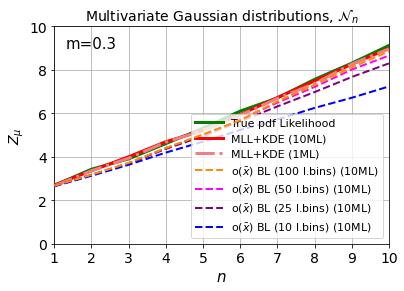

In [193]:
#########
# PLOTS #
#########

dim = [1,2,3,4,5,6,7,8,9,10]

plt.figure()
lw = 2

plt.plot(dim, store_Z_gaussian, '-', color='green', lw=3, label=r'True pdf Likelihood' ,zorder=5)
plt.plot(dim, store_Z_MLL_KDE, '-', color='red', lw=3, label=r'MLL+KDE (10ML)', zorder=5 )
plt.plot(dim, store_Z_MLL_KDE_1ML, '-.', color='lightcoral', lw=3, label=r'MLL+KDE (1ML)', zorder=5 )
#plt.plot(dim, store_Z_MLL_KDE_mu0, ':', color='gray', lw=3, label=r'KDE (MLL) mu=0', zorder=5 )
plt.plot(dim, store_Z_bins_XG_100bins, '--', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 l.bins) (10ML)' ,zorder=10)
plt.plot(dim, store_Z_bins_XG_50bins, '--', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 l.bins) (10ML)' ,zorder=5)
plt.plot(dim, store_Z_bins_XG_25bins, '--', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 l.bins) (10ML)' ,zorder=5)
plt.plot(dim, store_Z_bins_XG_10bins, '--', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 l.bins) (10ML)' ,zorder=5)

# plt.plot(dim, store_Z_bins_XG_100bins_eq, ':', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 n.l.bins) (10ML)' ,zorder=10)
# plt.plot(dim, store_Z_bins_XG_50bins_eq, ':', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 n.l.bins) (10ML)' ,zorder=5)
# plt.plot(dim, store_Z_bins_XG_25bins_eq, ':', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 n.l.bins) (10ML)' ,zorder=5)
# plt.plot(dim, store_Z_bins_XG_10bins_eq, ':', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 n.l.bins) (10ML)' ,zorder=5)

plt.xlim([1, 10])
plt.ylim([0., 10])
#plt.yscale('log')
plt.text(1.3, 9, 'm=0.3', fontsize = 15)
plt.xlabel('$n$', fontsize=15)
plt.ylabel('$Z_{\mu}$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.axhline(y=SsqrtB, color='black', linestyle=':')#, label=r'$S/\sqrt{B}$, WP=0')
plt.grid()
plt.title('Multivariate Gaussian distributions, $\mathcal{N}_{n}$', fontsize=14)
plt.legend(loc="lower right", fontsize=11, handlelength=2.5)
#plt.savefig('images/' + '2gaussian-Z-dims-m03.pdf', format="pdf", bbox_inches="tight")
plt.show()

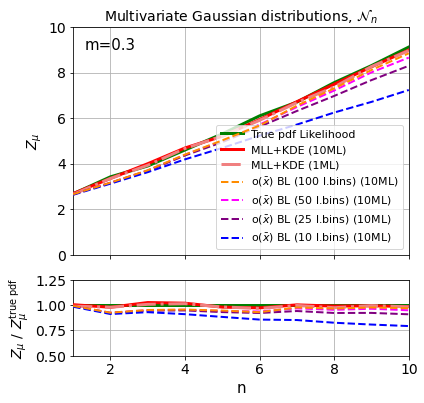

In [194]:
fig, axs = plt.subplots(2,1,figsize=(6,5.7), gridspec_kw={'height_ratios': [3, 1]})

lw = 2

axs[0].plot(dim, store_Z_gaussian, '-', color='green', lw=3, label=r'True pdf Likelihood' ,zorder=5)
axs[0].plot(dim, store_Z_MLL_KDE, '-', color='red', lw=3, label=r'MLL+KDE (10ML)', zorder=5 )
axs[0].plot(dim, store_Z_MLL_KDE_1ML, '-.', color='lightcoral', lw=3, label=r'MLL+KDE (1ML)', zorder=5 )
axs[0].plot(dim, store_Z_bins_XG_100bins, '--', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 l.bins) (10ML)' ,zorder=10)
axs[0].plot(dim, store_Z_bins_XG_50bins, '--', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 l.bins) (10ML)' ,zorder=5)
axs[0].plot(dim, store_Z_bins_XG_25bins, '--', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 l.bins) (10ML)' ,zorder=5)
axs[0].plot(dim, store_Z_bins_XG_10bins, '--', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 l.bins) (10ML)' ,zorder=5)
# axs[0].plot(dim, store_Z_bins_XG_100bins_eq, ':', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 n.l.bins) (10ML)' ,zorder=10)
# axs[0].plot(dim, store_Z_bins_XG_50bins_eq, ':', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 n.l.bins) (10ML)' ,zorder=5)
# axs[0].plot(dim, store_Z_bins_XG_25bins_eq, ':', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 n.l.bins) (10ML)' ,zorder=5)
# axs[0].plot(dim, store_Z_bins_XG_10bins_eq, ':', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 n.l.bins) (10ML)' ,zorder=5)
# axs[0].plot(dim, store_Z_bins_XG_100bins_1ML, '--', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 l.bins) (1ML)' ,zorder=10)
# axs[0].plot(dim, store_Z_bins_XG_50bins_1ML, '--', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 l.bins) (1ML)' ,zorder=5)
# axs[0].plot(dim, store_Z_bins_XG_25bins_1ML, '--', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 l.bins) (1ML)' ,zorder=5)
# axs[0].plot(dim, store_Z_bins_XG_10bins_1ML, '--', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 l.bins) (1ML)' ,zorder=5)
# axs[0].plot(dim, store_Z_bins_XG_100bins_eq_1ML, ':', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 n.l.bins) (1ML)' ,zorder=10)
# axs[0].plot(dim, store_Z_bins_XG_50bins_eq_1ML, ':', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 n.l.bins) (1ML)' ,zorder=5)
# axs[0].plot(dim, store_Z_bins_XG_25bins_eq_1ML, ':', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 n.l.bins) (1ML)' ,zorder=5)
# axs[0].plot(dim, store_Z_bins_XG_10bins_eq_1ML, ':', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 n.l.bins) (1ML)' ,zorder=5)


store_Z_gaussian_norm = [ a/b for a, b in zip(store_Z_gaussian,store_Z_gaussian)]
store_Z_MLL_KDE_norm = [ a/b for a, b in zip(store_Z_MLL_KDE,store_Z_gaussian)]
store_Z_MLL_KDE_1ML_norm = [ a/b for a, b in zip(store_Z_MLL_KDE_1ML,store_Z_gaussian)]
store_Z_bins_XG_100bins_norm = [ a/b for a, b in zip(store_Z_bins_XG_100bins,store_Z_gaussian)]
store_Z_bins_XG_50bins_norm = [ a/b for a, b in zip(store_Z_bins_XG_50bins,store_Z_gaussian)]
store_Z_bins_XG_25bins_norm = [ a/b for a, b in zip(store_Z_bins_XG_25bins,store_Z_gaussian)]
store_Z_bins_XG_10bins_norm = [ a/b for a, b in zip(store_Z_bins_XG_10bins,store_Z_gaussian)]
store_Z_bins_XG_100bins_eq_norm = [ a/b for a, b in zip(store_Z_bins_XG_100bins_eq,store_Z_gaussian)]
store_Z_bins_XG_50bins_eq_norm = [ a/b for a, b in zip(store_Z_bins_XG_50bins_eq,store_Z_gaussian)]
store_Z_bins_XG_25bins_eq_norm = [ a/b for a, b in zip(store_Z_bins_XG_25bins_eq,store_Z_gaussian)]
store_Z_bins_XG_10bins_eq_norm = [ a/b for a, b in zip(store_Z_bins_XG_10bins_eq,store_Z_gaussian)]
store_Z_bins_XG_100bins_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_100bins_1ML,store_Z_gaussian)]
store_Z_bins_XG_50bins_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_50bins_1ML,store_Z_gaussian)]
store_Z_bins_XG_25bins_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_25bins_1ML,store_Z_gaussian)]
store_Z_bins_XG_10bins_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_10bins_1ML,store_Z_gaussian)]
store_Z_bins_XG_100bins_eq_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_100bins_eq_1ML,store_Z_gaussian)]
store_Z_bins_XG_50bins_eq_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_50bins_eq_1ML,store_Z_gaussian)]
store_Z_bins_XG_25bins_eq_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_25bins_eq_1ML,store_Z_gaussian)]
store_Z_bins_XG_10bins_eq_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_10bins_eq_1ML,store_Z_gaussian)]
dim_norm = [ a/b for a, b in zip(dim,store_Z_gaussian)]


axs[1].plot(dim, store_Z_gaussian_norm, '-', color='green', lw=3, label=r'True pdf Likelihood' ,zorder=5)
axs[1].plot(dim, store_Z_MLL_KDE_norm, '-', color='red', lw=3, label=r'MLL+KDE (10ML)', zorder=5 )
axs[1].plot(dim, store_Z_MLL_KDE_1ML_norm, '-.', color='lightcoral', lw=3, label=r'MLL+KDE (1ML)', zorder=5 )
axs[1].plot(dim, store_Z_bins_XG_100bins_norm, '--', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 l.bins) (10ML)' ,zorder=10)
axs[1].plot(dim, store_Z_bins_XG_50bins_norm, '--', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 l.bins) (10ML)' ,zorder=5)
axs[1].plot(dim, store_Z_bins_XG_25bins_norm, '--', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 l.bins) (10ML)' ,zorder=5)
axs[1].plot(dim, store_Z_bins_XG_10bins_norm, '--', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 l.bins) (10ML)' ,zorder=5)
# axs[1].plot(dim, store_Z_bins_XG_100bins_eq_norm, ':', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 n.l.bins) (10ML)' ,zorder=10)
# axs[1].plot(dim, store_Z_bins_XG_50bins_eq_norm, ':', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 n.l.bins) (10ML)' ,zorder=5)
# axs[1].plot(dim, store_Z_bins_XG_25bins_eq_norm, ':', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 n.l.bins) (10ML)' ,zorder=5)
# axs[1].plot(dim, store_Z_bins_XG_10bins_eq_norm, ':', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 n.l.bins) (10ML)' ,zorder=5)
# axs[1].plot(dim, store_Z_bins_XG_100bins_1ML_norm, '--', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 l.bins) (1ML)' ,zorder=10)
# axs[1].plot(dim, store_Z_bins_XG_50bins_1ML_norm, '--', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 l.bins) (1ML)' ,zorder=5)
# axs[1].plot(dim, store_Z_bins_XG_25bins_1ML_norm, '--', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 l.bins) (1ML)' ,zorder=5)
# axs[1].plot(dim, store_Z_bins_XG_10bins_1ML_norm, '--', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 l.bins) (1ML)' ,zorder=5)
# axs[1].plot(dim, store_Z_bins_XG_100bins_eq_1ML_norm, ':', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 n.l.bins) (1ML)' ,zorder=10)
# axs[1].plot(dim, store_Z_bins_XG_50bins_eq_1ML_norm, ':', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 n.l.bins) (1ML)' ,zorder=5)
# axs[1].plot(dim, store_Z_bins_XG_25bins_eq_1ML_norm, ':', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 n.l.bins) (1ML)' ,zorder=5)
# axs[1].plot(dim, store_Z_bins_XG_10bins_eq_1ML_norm, ':', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 n.l.bins) (1ML)' ,zorder=5)




axs[0].text(1.3, 9, 'm=0.3', fontsize = 15)


axs[0].set_xlim([1, 10])
axs[0].set_ylim([0, 10])
axs[1].set_xlim([1, 10])
axs[1].set_ylim([0.5,1.25])
axs[0].set_ylabel('$Z_{\mu}$', fontsize=14)
axs[1].set_xlabel('n', fontsize=15)
axs[1].set_ylabel(r'$Z_{\mu}$ / $Z_{\mu}^{\mathrm{true \; pdf}}$', fontsize=14)

axs[0].yaxis.set_tick_params(labelsize=14)
axs[0].xaxis.set_tick_params(labelsize=14)
axs[0].xaxis.set_ticklabels([])
axs[1].yaxis.set_ticks([0.5,0.75,1,1.25])
axs[1].xaxis.set_tick_params(labelsize=14)
axs[1].yaxis.set_tick_params(labelsize=14)

axs[0].grid()
axs[1].grid()

axs[0].set_title('Multivariate Gaussian distributions, $\mathcal{N}_{n}$', fontsize=14)
axs[0].legend(loc="lower right", fontsize=11)
plt.tight_layout()
#plt.savefig('images/' + '2gaussian-Z-dims-m03.pdf', format="pdf", bbox_inches="tight")
plt.show()

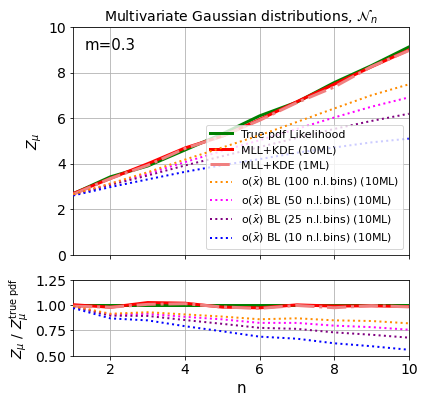

In [195]:
fig, axs = plt.subplots(2,1,figsize=(6,5.7), gridspec_kw={'height_ratios': [3, 1]})

lw = 2

axs[0].plot(dim, store_Z_gaussian, '-', color='green', lw=3, label=r'True pdf Likelihood' ,zorder=5)
axs[0].plot(dim, store_Z_MLL_KDE, '-', color='red', lw=3, label=r'MLL+KDE (10ML)', zorder=5 )
axs[0].plot(dim, store_Z_MLL_KDE_1ML, '-.', color='lightcoral', lw=3, label=r'MLL+KDE (1ML)', zorder=5 )
#axs[0].plot(dim, store_Z_bins_XG_100bins, '--', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 l.bins) (10ML)' ,zorder=10)
#axs[0].plot(dim, store_Z_bins_XG_50bins, '--', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 l.bins) (10ML)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_25bins, '--', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 l.bins) (10ML)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_10bins, '--', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 l.bins) (10ML)' ,zorder=5)
axs[0].plot(dim, store_Z_bins_XG_100bins_eq, ':', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 n.l.bins) (10ML)' ,zorder=10)
axs[0].plot(dim, store_Z_bins_XG_50bins_eq, ':', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 n.l.bins) (10ML)' ,zorder=5)
axs[0].plot(dim, store_Z_bins_XG_25bins_eq, ':', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 n.l.bins) (10ML)' ,zorder=5)
axs[0].plot(dim, store_Z_bins_XG_10bins_eq, ':', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 n.l.bins) (10ML)' ,zorder=5)
# axs[0].plot(dim, store_Z_bins_XG_100bins_1ML, '--', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 l.bins) (1ML)' ,zorder=10)
# axs[0].plot(dim, store_Z_bins_XG_50bins_1ML, '--', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 l.bins) (1ML)' ,zorder=5)
# axs[0].plot(dim, store_Z_bins_XG_25bins_1ML, '--', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 l.bins) (1ML)' ,zorder=5)
# axs[0].plot(dim, store_Z_bins_XG_10bins_1ML, '--', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 l.bins) (1ML)' ,zorder=5)
# axs[0].plot(dim, store_Z_bins_XG_100bins_eq_1ML, ':', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 n.l.bins) (1ML)' ,zorder=10)
# axs[0].plot(dim, store_Z_bins_XG_50bins_eq_1ML, ':', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 n.l.bins) (1ML)' ,zorder=5)
# axs[0].plot(dim, store_Z_bins_XG_25bins_eq_1ML, ':', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 n.l.bins) (1ML)' ,zorder=5)
# axs[0].plot(dim, store_Z_bins_XG_10bins_eq_1ML, ':', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 n.l.bins) (1ML)' ,zorder=5)


store_Z_gaussian_norm = [ a/b for a, b in zip(store_Z_gaussian,store_Z_gaussian)]
store_Z_MLL_KDE_norm = [ a/b for a, b in zip(store_Z_MLL_KDE,store_Z_gaussian)]
store_Z_MLL_KDE_1ML_norm = [ a/b for a, b in zip(store_Z_MLL_KDE_1ML,store_Z_gaussian)]
store_Z_bins_XG_100bins_norm = [ a/b for a, b in zip(store_Z_bins_XG_100bins,store_Z_gaussian)]
store_Z_bins_XG_50bins_norm = [ a/b for a, b in zip(store_Z_bins_XG_50bins,store_Z_gaussian)]
store_Z_bins_XG_25bins_norm = [ a/b for a, b in zip(store_Z_bins_XG_25bins,store_Z_gaussian)]
store_Z_bins_XG_10bins_norm = [ a/b for a, b in zip(store_Z_bins_XG_10bins,store_Z_gaussian)]
store_Z_bins_XG_100bins_eq_norm = [ a/b for a, b in zip(store_Z_bins_XG_100bins_eq,store_Z_gaussian)]
store_Z_bins_XG_50bins_eq_norm = [ a/b for a, b in zip(store_Z_bins_XG_50bins_eq,store_Z_gaussian)]
store_Z_bins_XG_25bins_eq_norm = [ a/b for a, b in zip(store_Z_bins_XG_25bins_eq,store_Z_gaussian)]
store_Z_bins_XG_10bins_eq_norm = [ a/b for a, b in zip(store_Z_bins_XG_10bins_eq,store_Z_gaussian)]
store_Z_bins_XG_100bins_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_100bins_1ML,store_Z_gaussian)]
store_Z_bins_XG_50bins_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_50bins_1ML,store_Z_gaussian)]
store_Z_bins_XG_25bins_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_25bins_1ML,store_Z_gaussian)]
store_Z_bins_XG_10bins_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_10bins_1ML,store_Z_gaussian)]
store_Z_bins_XG_100bins_eq_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_100bins_eq_1ML,store_Z_gaussian)]
store_Z_bins_XG_50bins_eq_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_50bins_eq_1ML,store_Z_gaussian)]
store_Z_bins_XG_25bins_eq_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_25bins_eq_1ML,store_Z_gaussian)]
store_Z_bins_XG_10bins_eq_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_10bins_eq_1ML,store_Z_gaussian)]
dim_norm = [ a/b for a, b in zip(dim,store_Z_gaussian)]


axs[1].plot(dim, store_Z_gaussian_norm, '-', color='green', lw=3, label=r'True pdf Likelihood' ,zorder=5)
axs[1].plot(dim, store_Z_MLL_KDE_norm, '-', color='red', lw=3, label=r'MLL+KDE (10ML)', zorder=5 )
axs[1].plot(dim, store_Z_MLL_KDE_1ML_norm, '-.', color='lightcoral', lw=3, label=r'MLL+KDE (1ML)', zorder=5 )
#axs[1].plot(dim, store_Z_bins_XG_100bins_norm, '--', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 l.bins) (10ML)' ,zorder=10)
#axs[1].plot(dim, store_Z_bins_XG_50bins_norm, '--', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 l.bins) (10ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_25bins_norm, '--', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 l.bins) (10ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_10bins_norm, '--', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 l.bins) (10ML)' ,zorder=5)
axs[1].plot(dim, store_Z_bins_XG_100bins_eq_norm, ':', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 n.l.bins) (10ML)' ,zorder=10)
axs[1].plot(dim, store_Z_bins_XG_50bins_eq_norm, ':', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 n.l.bins) (10ML)' ,zorder=5)
axs[1].plot(dim, store_Z_bins_XG_25bins_eq_norm, ':', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 n.l.bins) (10ML)' ,zorder=5)
axs[1].plot(dim, store_Z_bins_XG_10bins_eq_norm, ':', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 n.l.bins) (10ML)' ,zorder=5)
# axs[1].plot(dim, store_Z_bins_XG_100bins_1ML_norm, '--', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 l.bins) (1ML)' ,zorder=10)
# axs[1].plot(dim, store_Z_bins_XG_50bins_1ML_norm, '--', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 l.bins) (1ML)' ,zorder=5)
# axs[1].plot(dim, store_Z_bins_XG_25bins_1ML_norm, '--', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 l.bins) (1ML)' ,zorder=5)
# axs[1].plot(dim, store_Z_bins_XG_10bins_1ML_norm, '--', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 l.bins) (1ML)' ,zorder=5)
# axs[1].plot(dim, store_Z_bins_XG_100bins_eq_1ML_norm, ':', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 n.l.bins) (1ML)' ,zorder=10)
# axs[1].plot(dim, store_Z_bins_XG_50bins_eq_1ML_norm, ':', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 n.l.bins) (1ML)' ,zorder=5)
# axs[1].plot(dim, store_Z_bins_XG_25bins_eq_1ML_norm, ':', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 n.l.bins) (1ML)' ,zorder=5)
# axs[1].plot(dim, store_Z_bins_XG_10bins_eq_1ML_norm, ':', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 n.l.bins) (1ML)' ,zorder=5)




axs[0].text(1.3, 9, 'm=0.3', fontsize = 15)


axs[0].set_xlim([1, 10])
axs[0].set_ylim([0, 10])
axs[1].set_xlim([1, 10])
axs[1].set_ylim([0.5,1.25])
axs[0].set_ylabel('$Z_{\mu}$', fontsize=14)
axs[1].set_xlabel('n', fontsize=15)
axs[1].set_ylabel(r'$Z_{\mu}$ / $Z_{\mu}^{\mathrm{true \; pdf}}$', fontsize=14)

axs[0].yaxis.set_tick_params(labelsize=14)
axs[0].xaxis.set_tick_params(labelsize=14)
axs[0].xaxis.set_ticklabels([])
axs[1].yaxis.set_ticks([0.5,0.75,1,1.25])
axs[1].xaxis.set_tick_params(labelsize=14)
axs[1].yaxis.set_tick_params(labelsize=14)

axs[0].grid()
axs[1].grid()

axs[0].set_title('Multivariate Gaussian distributions, $\mathcal{N}_{n}$', fontsize=14)
axs[0].legend(loc="lower right", fontsize=11)
plt.tight_layout()
#plt.savefig('images/' + '2gaussian-Z-dims-m03.pdf', format="pdf", bbox_inches="tight")
plt.show()

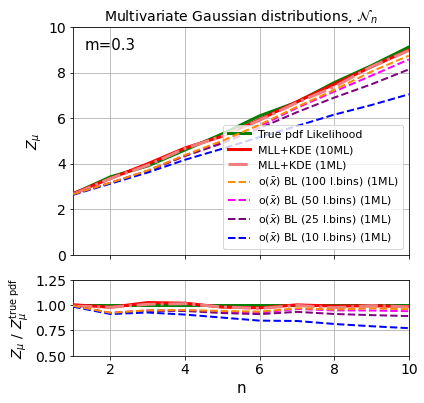

In [196]:
fig, axs = plt.subplots(2,1,figsize=(6,5.7), gridspec_kw={'height_ratios': [3, 1]})

lw = 2

axs[0].plot(dim, store_Z_gaussian, '-', color='green', lw=3, label=r'True pdf Likelihood' ,zorder=5)
axs[0].plot(dim, store_Z_MLL_KDE, '-', color='red', lw=3, label=r'MLL+KDE (10ML)', zorder=5 )
axs[0].plot(dim, store_Z_MLL_KDE_1ML, '-.', color='lightcoral', lw=3, label=r'MLL+KDE (1ML)', zorder=5 )
#axs[0].plot(dim, store_Z_bins_XG_100bins, '--', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 l.bins) (10ML)' ,zorder=10)
#axs[0].plot(dim, store_Z_bins_XG_50bins, '--', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 l.bins) (10ML)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_25bins, '--', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 l.bins) (10ML)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_10bins, '--', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 l.bins) (10ML)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_100bins_eq, ':', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 n.l.bins) (10ML)' ,zorder=10)
#axs[0].plot(dim, store_Z_bins_XG_50bins_eq, ':', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 n.l.bins) (10ML)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_25bins_eq, ':', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 n.l.bins) (10ML)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_10bins_eq, ':', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 n.l.bins) (10ML)' ,zorder=5)
axs[0].plot(dim, store_Z_bins_XG_100bins_1ML, '--', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 l.bins) (1ML)' ,zorder=10)
axs[0].plot(dim, store_Z_bins_XG_50bins_1ML, '--', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 l.bins) (1ML)' ,zorder=5)
axs[0].plot(dim, store_Z_bins_XG_25bins_1ML, '--', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 l.bins) (1ML)' ,zorder=5)
axs[0].plot(dim, store_Z_bins_XG_10bins_1ML, '--', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 l.bins) (1ML)' ,zorder=5)
# axs[0].plot(dim, store_Z_bins_XG_100bins_eq_1ML, ':', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 n.l.bins) (1ML)' ,zorder=10)
# axs[0].plot(dim, store_Z_bins_XG_50bins_eq_1ML, ':', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 n.l.bins) (1ML)' ,zorder=5)
# axs[0].plot(dim, store_Z_bins_XG_25bins_eq_1ML, ':', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 n.l.bins) (1ML)' ,zorder=5)
# axs[0].plot(dim, store_Z_bins_XG_10bins_eq_1ML, ':', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 n.l.bins) (1ML)' ,zorder=5)


store_Z_gaussian_norm = [ a/b for a, b in zip(store_Z_gaussian,store_Z_gaussian)]
store_Z_MLL_KDE_norm = [ a/b for a, b in zip(store_Z_MLL_KDE,store_Z_gaussian)]
store_Z_MLL_KDE_1ML_norm = [ a/b for a, b in zip(store_Z_MLL_KDE_1ML,store_Z_gaussian)]
store_Z_bins_XG_100bins_norm = [ a/b for a, b in zip(store_Z_bins_XG_100bins,store_Z_gaussian)]
store_Z_bins_XG_50bins_norm = [ a/b for a, b in zip(store_Z_bins_XG_50bins,store_Z_gaussian)]
store_Z_bins_XG_25bins_norm = [ a/b for a, b in zip(store_Z_bins_XG_25bins,store_Z_gaussian)]
store_Z_bins_XG_10bins_norm = [ a/b for a, b in zip(store_Z_bins_XG_10bins,store_Z_gaussian)]
store_Z_bins_XG_100bins_eq_norm = [ a/b for a, b in zip(store_Z_bins_XG_100bins_eq,store_Z_gaussian)]
store_Z_bins_XG_50bins_eq_norm = [ a/b for a, b in zip(store_Z_bins_XG_50bins_eq,store_Z_gaussian)]
store_Z_bins_XG_25bins_eq_norm = [ a/b for a, b in zip(store_Z_bins_XG_25bins_eq,store_Z_gaussian)]
store_Z_bins_XG_10bins_eq_norm = [ a/b for a, b in zip(store_Z_bins_XG_10bins_eq,store_Z_gaussian)]
store_Z_bins_XG_100bins_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_100bins_1ML,store_Z_gaussian)]
store_Z_bins_XG_50bins_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_50bins_1ML,store_Z_gaussian)]
store_Z_bins_XG_25bins_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_25bins_1ML,store_Z_gaussian)]
store_Z_bins_XG_10bins_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_10bins_1ML,store_Z_gaussian)]
store_Z_bins_XG_100bins_eq_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_100bins_eq_1ML,store_Z_gaussian)]
store_Z_bins_XG_50bins_eq_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_50bins_eq_1ML,store_Z_gaussian)]
store_Z_bins_XG_25bins_eq_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_25bins_eq_1ML,store_Z_gaussian)]
store_Z_bins_XG_10bins_eq_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_10bins_eq_1ML,store_Z_gaussian)]
dim_norm = [ a/b for a, b in zip(dim,store_Z_gaussian)]


axs[1].plot(dim, store_Z_gaussian_norm, '-', color='green', lw=3, label=r'True pdf Likelihood' ,zorder=5)
axs[1].plot(dim, store_Z_MLL_KDE_norm, '-', color='red', lw=3, label=r'MLL+KDE (10ML)', zorder=5 )
axs[1].plot(dim, store_Z_MLL_KDE_1ML_norm, '-.', color='lightcoral', lw=3, label=r'MLL+KDE (1ML)', zorder=5 )
#axs[1].plot(dim, store_Z_bins_XG_100bins_norm, '--', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 l.bins) (10ML)' ,zorder=10)
#axs[1].plot(dim, store_Z_bins_XG_50bins_norm, '--', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 l.bins) (10ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_25bins_norm, '--', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 l.bins) (10ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_10bins_norm, '--', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 l.bins) (10ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_100bins_eq_norm, ':', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 n.l.bins) (10ML)' ,zorder=10)
#axs[1].plot(dim, store_Z_bins_XG_50bins_eq_norm, ':', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 n.l.bins) (10ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_25bins_eq_norm, ':', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 n.l.bins) (10ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_10bins_eq_norm, ':', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 n.l.bins) (10ML)' ,zorder=5)
axs[1].plot(dim, store_Z_bins_XG_100bins_1ML_norm, '--', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 l.bins) (1ML)' ,zorder=10)
axs[1].plot(dim, store_Z_bins_XG_50bins_1ML_norm, '--', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 l.bins) (1ML)' ,zorder=5)
axs[1].plot(dim, store_Z_bins_XG_25bins_1ML_norm, '--', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 l.bins) (1ML)' ,zorder=5)
axs[1].plot(dim, store_Z_bins_XG_10bins_1ML_norm, '--', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 l.bins) (1ML)' ,zorder=5)
# axs[1].plot(dim, store_Z_bins_XG_100bins_eq_1ML_norm, ':', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 n.l.bins) (1ML)' ,zorder=10)
# axs[1].plot(dim, store_Z_bins_XG_50bins_eq_1ML_norm, ':', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 n.l.bins) (1ML)' ,zorder=5)
# axs[1].plot(dim, store_Z_bins_XG_25bins_eq_1ML_norm, ':', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 n.l.bins) (1ML)' ,zorder=5)
# axs[1].plot(dim, store_Z_bins_XG_10bins_eq_1ML_norm, ':', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 n.l.bins) (1ML)' ,zorder=5)




axs[0].text(1.3, 9, 'm=0.3', fontsize = 15)


axs[0].set_xlim([1, 10])
axs[0].set_ylim([0, 10])
axs[1].set_xlim([1, 10])
axs[1].set_ylim([0.5,1.25])
axs[0].set_ylabel('$Z_{\mu}$', fontsize=14)
axs[1].set_xlabel('n', fontsize=15)
axs[1].set_ylabel(r'$Z_{\mu}$ / $Z_{\mu}^{\mathrm{true \; pdf}}$', fontsize=14)

axs[0].yaxis.set_tick_params(labelsize=14)
axs[0].xaxis.set_tick_params(labelsize=14)
axs[0].xaxis.set_ticklabels([])
axs[1].yaxis.set_ticks([0.5,0.75,1,1.25])
axs[1].xaxis.set_tick_params(labelsize=14)
axs[1].yaxis.set_tick_params(labelsize=14)

axs[0].grid()
axs[1].grid()

axs[0].set_title('Multivariate Gaussian distributions, $\mathcal{N}_{n}$', fontsize=14)
axs[0].legend(loc="lower right", fontsize=11)
plt.tight_layout()
#plt.savefig('images/' + '2gaussian-Z-dims-m03.pdf', format="pdf", bbox_inches="tight")
plt.show()

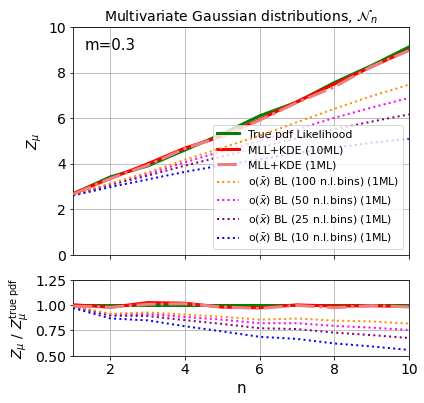

In [197]:
fig, axs = plt.subplots(2,1,figsize=(6,5.7), gridspec_kw={'height_ratios': [3, 1]})

lw = 2

axs[0].plot(dim, store_Z_gaussian, '-', color='green', lw=3, label=r'True pdf Likelihood' ,zorder=5)
axs[0].plot(dim, store_Z_MLL_KDE, '-', color='red', lw=3, label=r'MLL+KDE (10ML)', zorder=5 )
axs[0].plot(dim, store_Z_MLL_KDE_1ML, '-.', color='lightcoral', lw=3, label=r'MLL+KDE (1ML)', zorder=5 )
#axs[0].plot(dim, store_Z_bins_XG_100bins, '--', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 l.bins) (10ML)' ,zorder=10)
#axs[0].plot(dim, store_Z_bins_XG_50bins, '--', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 l.bins) (10ML)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_25bins, '--', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 l.bins) (10ML)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_10bins, '--', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 l.bins) (10ML)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_100bins_eq, ':', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 n.l.bins) (10ML)' ,zorder=10)
#axs[0].plot(dim, store_Z_bins_XG_50bins_eq, ':', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 n.l.bins) (10ML)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_25bins_eq, ':', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 n.l.bins) (10ML)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_10bins_eq, ':', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 n.l.bins) (10ML)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_100bins_1ML, '--', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 l.bins) (1ML)' ,zorder=10)
#axs[0].plot(dim, store_Z_bins_XG_50bins_1ML, '--', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 l.bins) (1ML)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_25bins_1ML, '--', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 l.bins) (1ML)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_10bins_1ML, '--', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 l.bins) (1ML)' ,zorder=5)
axs[0].plot(dim, store_Z_bins_XG_100bins_eq_1ML, ':', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 n.l.bins) (1ML)' ,zorder=10)
axs[0].plot(dim, store_Z_bins_XG_50bins_eq_1ML, ':', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 n.l.bins) (1ML)' ,zorder=5)
axs[0].plot(dim, store_Z_bins_XG_25bins_eq_1ML, ':', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 n.l.bins) (1ML)' ,zorder=5)
axs[0].plot(dim, store_Z_bins_XG_10bins_eq_1ML, ':', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 n.l.bins) (1ML)' ,zorder=5)


store_Z_gaussian_norm = [ a/b for a, b in zip(store_Z_gaussian,store_Z_gaussian)]
store_Z_MLL_KDE_norm = [ a/b for a, b in zip(store_Z_MLL_KDE,store_Z_gaussian)]
store_Z_MLL_KDE_1ML_norm = [ a/b for a, b in zip(store_Z_MLL_KDE_1ML,store_Z_gaussian)]
store_Z_bins_XG_100bins_norm = [ a/b for a, b in zip(store_Z_bins_XG_100bins,store_Z_gaussian)]
store_Z_bins_XG_50bins_norm = [ a/b for a, b in zip(store_Z_bins_XG_50bins,store_Z_gaussian)]
store_Z_bins_XG_25bins_norm = [ a/b for a, b in zip(store_Z_bins_XG_25bins,store_Z_gaussian)]
store_Z_bins_XG_10bins_norm = [ a/b for a, b in zip(store_Z_bins_XG_10bins,store_Z_gaussian)]
store_Z_bins_XG_100bins_eq_norm = [ a/b for a, b in zip(store_Z_bins_XG_100bins_eq,store_Z_gaussian)]
store_Z_bins_XG_50bins_eq_norm = [ a/b for a, b in zip(store_Z_bins_XG_50bins_eq,store_Z_gaussian)]
store_Z_bins_XG_25bins_eq_norm = [ a/b for a, b in zip(store_Z_bins_XG_25bins_eq,store_Z_gaussian)]
store_Z_bins_XG_10bins_eq_norm = [ a/b for a, b in zip(store_Z_bins_XG_10bins_eq,store_Z_gaussian)]
store_Z_bins_XG_100bins_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_100bins_1ML,store_Z_gaussian)]
store_Z_bins_XG_50bins_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_50bins_1ML,store_Z_gaussian)]
store_Z_bins_XG_25bins_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_25bins_1ML,store_Z_gaussian)]
store_Z_bins_XG_10bins_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_10bins_1ML,store_Z_gaussian)]
store_Z_bins_XG_100bins_eq_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_100bins_eq_1ML,store_Z_gaussian)]
store_Z_bins_XG_50bins_eq_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_50bins_eq_1ML,store_Z_gaussian)]
store_Z_bins_XG_25bins_eq_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_25bins_eq_1ML,store_Z_gaussian)]
store_Z_bins_XG_10bins_eq_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_10bins_eq_1ML,store_Z_gaussian)]
dim_norm = [ a/b for a, b in zip(dim,store_Z_gaussian)]


axs[1].plot(dim, store_Z_gaussian_norm, '-', color='green', lw=3, label=r'True pdf Likelihood' ,zorder=5)
axs[1].plot(dim, store_Z_MLL_KDE_norm, '-', color='red', lw=3, label=r'MLL+KDE (10ML)', zorder=5 )
axs[1].plot(dim, store_Z_MLL_KDE_1ML_norm, '-.', color='lightcoral', lw=3, label=r'MLL+KDE (1ML)', zorder=5 )
#axs[1].plot(dim, store_Z_bins_XG_100bins_norm, '--', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 l.bins) (10ML)' ,zorder=10)
#axs[1].plot(dim, store_Z_bins_XG_50bins_norm, '--', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 l.bins) (10ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_25bins_norm, '--', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 l.bins) (10ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_10bins_norm, '--', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 l.bins) (10ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_100bins_eq_norm, ':', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 n.l.bins) (10ML)' ,zorder=10)
#axs[1].plot(dim, store_Z_bins_XG_50bins_eq_norm, ':', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 n.l.bins) (10ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_25bins_eq_norm, ':', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 n.l.bins) (10ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_10bins_eq_norm, ':', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 n.l.bins) (10ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_100bins_1ML_norm, '--', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 l.bins) (1ML)' ,zorder=10)
#axs[1].plot(dim, store_Z_bins_XG_50bins_1ML_norm, '--', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 l.bins) (1ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_25bins_1ML_norm, '--', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 l.bins) (1ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_10bins_1ML_norm, '--', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 l.bins) (1ML)' ,zorder=5)
axs[1].plot(dim, store_Z_bins_XG_100bins_eq_1ML_norm, ':', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 n.l.bins) (1ML)' ,zorder=10)
axs[1].plot(dim, store_Z_bins_XG_50bins_eq_1ML_norm, ':', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 n.l.bins) (1ML)' ,zorder=5)
axs[1].plot(dim, store_Z_bins_XG_25bins_eq_1ML_norm, ':', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 n.l.bins) (1ML)' ,zorder=5)
axs[1].plot(dim, store_Z_bins_XG_10bins_eq_1ML_norm, ':', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 n.l.bins) (1ML)' ,zorder=5)




axs[0].text(1.3, 9, 'm=0.3', fontsize = 15)


axs[0].set_xlim([1, 10])
axs[0].set_ylim([0, 10])
axs[1].set_xlim([1, 10])
axs[1].set_ylim([0.5,1.25])
axs[0].set_ylabel('$Z_{\mu}$', fontsize=14)
axs[1].set_xlabel('n', fontsize=15)
axs[1].set_ylabel(r'$Z_{\mu}$ / $Z_{\mu}^{\mathrm{true \; pdf}}$', fontsize=14)

axs[0].yaxis.set_tick_params(labelsize=14)
axs[0].xaxis.set_tick_params(labelsize=14)
axs[0].xaxis.set_ticklabels([])
axs[1].yaxis.set_ticks([0.5,0.75,1,1.25])
axs[1].xaxis.set_tick_params(labelsize=14)
axs[1].yaxis.set_tick_params(labelsize=14)

axs[0].grid()
axs[1].grid()

axs[0].set_title('Multivariate Gaussian distributions, $\mathcal{N}_{n}$', fontsize=14)
axs[0].legend(loc="lower right", fontsize=11)
plt.tight_layout()
#plt.savefig('images/' + '2gaussian-Z-dims-m03.pdf', format="pdf", bbox_inches="tight")
plt.show()

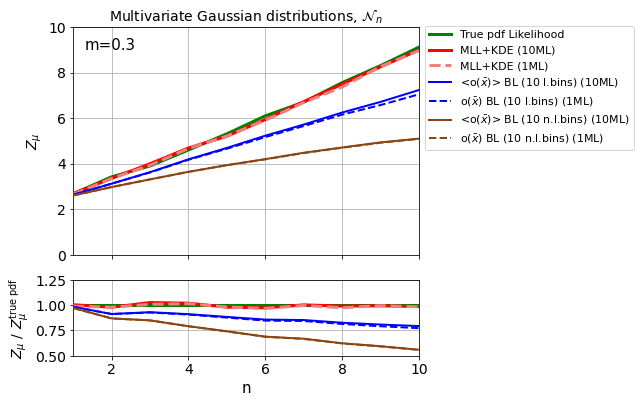

In [198]:
fig, axs = plt.subplots(2,1,figsize=(9,5.7), gridspec_kw={'height_ratios': [3, 1]})

lw = 2

axs[0].plot(dim, store_Z_gaussian, '-', color='green', lw=3, label=r'True pdf Likelihood' ,zorder=5)
axs[0].plot(dim, store_Z_MLL_KDE, '-', color='red', lw=3, label=r'MLL+KDE (10ML)', zorder=5 )
axs[0].plot(dim, store_Z_MLL_KDE_1ML, '--', color='lightcoral', lw=3, label=r'MLL+KDE (1ML)', zorder=5 )
#axs[0].plot(dim, store_Z_bins_XG_100bins, '--', color='dodgerblue', lw=2, label=r'o$(\bar{x})$ BL (100 l.bins) (10ML)' ,zorder=10)
#axs[0].plot(dim, store_Z_bins_XG_50bins, '--', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (50 l.bins) (10ML)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_25bins, '--', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (25 l.bins) (10ML)' ,zorder=5)
axs[0].plot(dim, store_Z_bins_XG_10bins, '-', color='blue', lw=2, label=r'<o$(\bar{x})$> BL (10 l.bins) (10ML)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_100bins_1ML, '--', color='dodgerblue', lw=2, label=r'o$(\bar{x})$ BL (100 l.bins) (1ML)' ,zorder=10)
#axs[0].plot(dim, store_Z_bins_XG_50bins_1ML, '--', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (50 l.bins) (1ML)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_25bins_1ML, '--', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (25 l.bins) (1ML)' ,zorder=5)
axs[0].plot(dim, store_Z_bins_XG_10bins_1ML, '--', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 l.bins) (1ML)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_100bins_eq, ':', color='dodgerblue', lw=2, label=r'o$(\bar{x})$ BL (100 n.l.bins) (10ML)' ,zorder=10)
#axs[0].plot(dim, store_Z_bins_XG_50bins_eq, ':', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (50 n.l.bins) (10ML)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_25bins_eq, ':', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (25 n.l.bins) (10ML)' ,zorder=5)
axs[0].plot(dim, store_Z_bins_XG_10bins_eq, '-', color='saddlebrown', lw=2, label=r'<o$(\bar{x})$> BL (10 n.l.bins) (10ML)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_100bins_eq_1ML, ':', color='dodgerblue', lw=2, label=r'o$(\bar{x})$ BL (100 n.l.bins) (1ML)' ,zorder=10)
#axs[0].plot(dim, store_Z_bins_XG_50bins_eq_1ML, ':', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (50 n.l.bins) (1ML)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_25bins_eq_1ML, ':', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (25 n.l.bins) (1ML)' ,zorder=5)
axs[0].plot(dim, store_Z_bins_XG_10bins_eq_1ML, '--', color='saddlebrown', lw=2, label=r'o$(\bar{x})$ BL (10 n.l.bins) (1ML)' ,zorder=5)


store_Z_gaussian_norm = [ a/b for a, b in zip(store_Z_gaussian,store_Z_gaussian)]
store_Z_MLL_KDE_norm = [ a/b for a, b in zip(store_Z_MLL_KDE,store_Z_gaussian)]
store_Z_MLL_KDE_1ML_norm = [ a/b for a, b in zip(store_Z_MLL_KDE_1ML,store_Z_gaussian)]
store_Z_bins_XG_100bins_norm = [ a/b for a, b in zip(store_Z_bins_XG_100bins,store_Z_gaussian)]
store_Z_bins_XG_50bins_norm = [ a/b for a, b in zip(store_Z_bins_XG_50bins,store_Z_gaussian)]
store_Z_bins_XG_25bins_norm = [ a/b for a, b in zip(store_Z_bins_XG_25bins,store_Z_gaussian)]
store_Z_bins_XG_10bins_norm = [ a/b for a, b in zip(store_Z_bins_XG_10bins,store_Z_gaussian)]
store_Z_bins_XG_100bins_eq_norm = [ a/b for a, b in zip(store_Z_bins_XG_100bins_eq,store_Z_gaussian)]
store_Z_bins_XG_50bins_eq_norm = [ a/b for a, b in zip(store_Z_bins_XG_50bins_eq,store_Z_gaussian)]
store_Z_bins_XG_25bins_eq_norm = [ a/b for a, b in zip(store_Z_bins_XG_25bins_eq,store_Z_gaussian)]
store_Z_bins_XG_10bins_eq_norm = [ a/b for a, b in zip(store_Z_bins_XG_10bins_eq,store_Z_gaussian)]
store_Z_bins_XG_100bins_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_100bins_1ML,store_Z_gaussian)]
store_Z_bins_XG_50bins_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_50bins_1ML,store_Z_gaussian)]
store_Z_bins_XG_25bins_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_25bins_1ML,store_Z_gaussian)]
store_Z_bins_XG_10bins_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_10bins_1ML,store_Z_gaussian)]
store_Z_bins_XG_100bins_eq_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_100bins_eq_1ML,store_Z_gaussian)]
store_Z_bins_XG_50bins_eq_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_50bins_eq_1ML,store_Z_gaussian)]
store_Z_bins_XG_25bins_eq_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_25bins_eq_1ML,store_Z_gaussian)]
store_Z_bins_XG_10bins_eq_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_10bins_eq_1ML,store_Z_gaussian)]
dim_norm = [ a/b for a, b in zip(dim,store_Z_gaussian)]


axs[1].plot(dim, store_Z_gaussian_norm, '-', color='green', lw=3, label=r'True pdf Likelihood' ,zorder=5)
axs[1].plot(dim, store_Z_MLL_KDE_norm, '-', color='red', lw=3, label=r'MLL+KDE (10ML)', zorder=5 )
axs[1].plot(dim, store_Z_MLL_KDE_1ML_norm, '--', color='lightcoral', lw=3, label=r'MLL+KDE (1ML)', zorder=5 )
#axs[1].plot(dim, store_Z_bins_XG_100bins_norm, '--', color='dodgerblue', lw=2, label=r'o$(\bar{x})$ BL (100 l.bins) (10ML)' ,zorder=10)
#axs[1].plot(dim, store_Z_bins_XG_50bins_norm, '--', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (50 l.bins) (10ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_25bins_norm, '--', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (25 l.bins) (10ML)' ,zorder=5)
axs[1].plot(dim, store_Z_bins_XG_10bins_norm, '-', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 l.bins) (10ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_100bins_1ML_norm, '--', color='dodgerblue', lw=2, label=r'o$(\bar{x})$ BL (100 l.bins) (1ML)' ,zorder=10)
#axs[1].plot(dim, store_Z_bins_XG_50bins_1ML_norm, '--', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (50 l.bins) (1ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_25bins_1ML_norm, '--', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (25 l.bins) (1ML)' ,zorder=5)
axs[1].plot(dim, store_Z_bins_XG_10bins_1ML_norm, '--', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 l.bins) (1ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_100bins_eq_norm, ':', color='dodgerblue', lw=2, label=r'o$(\bar{x})$ BL (100 n.l.bins) (10ML)' ,zorder=10)
#axs[1].plot(dim, store_Z_bins_XG_50bins_eq_norm, ':', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (50 n.l.bins) (10ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_25bins_eq_norm, ':', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (25 n.l.bins) (10ML)' ,zorder=5)
axs[1].plot(dim, store_Z_bins_XG_10bins_eq_norm, '-', color='saddlebrown', lw=2, label=r'o$(\bar{x})$ BL (10 n.l.bins) (10ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_100bins_eq_1ML_norm, ':', color='dodgerblue', lw=2, label=r'o$(\bar{x})$ BL (100 n.l.bins) (1ML)' ,zorder=10)
#axs[1].plot(dim, store_Z_bins_XG_50bins_eq_1ML_norm, ':', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (50 n.l.bins) (1ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_25bins_eq_1ML_norm, ':', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (25 n.l.bins) (1ML)' ,zorder=5)
axs[1].plot(dim, store_Z_bins_XG_10bins_eq_1ML_norm, '--', color='saddlebrown', lw=2, label=r'o$(\bar{x})$ BL (10 n.l.bins) (1ML)' ,zorder=5)




axs[0].text(1.3, 9, 'm=0.3', fontsize = 15)


axs[0].set_xlim([1, 10])
axs[0].set_ylim([0, 10])
axs[1].set_xlim([1, 10])
axs[1].set_ylim([0.5,1.25])
axs[0].set_ylabel('$Z_{\mu}$', fontsize=14)
axs[1].set_xlabel('n', fontsize=15)
axs[1].set_ylabel(r'$Z_{\mu}$ / $Z_{\mu}^{\mathrm{true \; pdf}}$', fontsize=14)

axs[0].yaxis.set_tick_params(labelsize=14)
axs[0].xaxis.set_tick_params(labelsize=14)
axs[0].xaxis.set_ticklabels([])
axs[1].yaxis.set_ticks([0.5,0.75,1,1.25])
axs[1].xaxis.set_tick_params(labelsize=14)
axs[1].yaxis.set_tick_params(labelsize=14)

axs[0].grid()
axs[1].grid()

axs[0].set_title('Multivariate Gaussian distributions, $\mathcal{N}_{n}$', fontsize=14)
axs[0].legend(bbox_to_anchor=(1,1.03), fontsize=11)
plt.tight_layout()
plt.savefig('images/' + '2gaussian-Z-dims-m03-A.pdf', format="pdf", bbox_inches="tight")
plt.show()

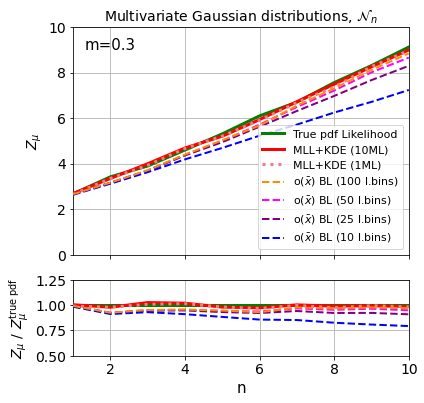

In [199]:
fig, axs = plt.subplots(2,1,figsize=(6,5.7), gridspec_kw={'height_ratios': [3, 1]})

lw = 2

axs[0].plot(dim, store_Z_gaussian, '-', color='green', lw=3, label=r'True pdf Likelihood' ,zorder=5)
axs[0].plot(dim, store_Z_MLL_KDE, '-', color='red', lw=3, label=r'MLL+KDE (10ML)', zorder=5 )
axs[0].plot(dim, store_Z_MLL_KDE_1ML, ':', color='lightcoral', lw=3, label=r'MLL+KDE (1ML)', zorder=5 )
axs[0].plot(dim, store_Z_bins_XG_100bins, '--', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 l.bins)' ,zorder=10)
axs[0].plot(dim, store_Z_bins_XG_50bins, '--', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 l.bins)' ,zorder=5)
axs[0].plot(dim, store_Z_bins_XG_25bins, '--', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 l.bins)' ,zorder=5)
axs[0].plot(dim, store_Z_bins_XG_10bins, '--', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 l.bins)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_100bins_eq, ':', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 n.l.bins) (10ML)' ,zorder=10)
#axs[0].plot(dim, store_Z_bins_XG_50bins_eq, ':', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 n.l.bins) (10ML)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_25bins_eq, ':', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 n.l.bins) (10ML)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_10bins_eq, ':', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 n.l.bins) (10ML)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_100bins_1ML, '--', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 l.bins) (1ML)' ,zorder=10)
#axs[0].plot(dim, store_Z_bins_XG_50bins_1ML, '--', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 l.bins) (1ML)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_25bins_1ML, '--', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 l.bins) (1ML)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_10bins_1ML, '--', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 l.bins) (1ML)' ,zorder=5)
# axs[0].plot(dim, store_Z_bins_XG_100bins_eq_1ML, ':', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 n.l.bins) (1ML)' ,zorder=10)
# axs[0].plot(dim, store_Z_bins_XG_50bins_eq_1ML, ':', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 n.l.bins) (1ML)' ,zorder=5)
# axs[0].plot(dim, store_Z_bins_XG_25bins_eq_1ML, ':', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 n.l.bins) (1ML)' ,zorder=5)
# axs[0].plot(dim, store_Z_bins_XG_10bins_eq_1ML, ':', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 n.l.bins) (1ML)' ,zorder=5)


store_Z_gaussian_norm = [ a/b for a, b in zip(store_Z_gaussian,store_Z_gaussian)]
store_Z_MLL_KDE_norm = [ a/b for a, b in zip(store_Z_MLL_KDE,store_Z_gaussian)]
store_Z_MLL_KDE_1ML_norm = [ a/b for a, b in zip(store_Z_MLL_KDE_1ML,store_Z_gaussian)]
store_Z_bins_XG_100bins_norm = [ a/b for a, b in zip(store_Z_bins_XG_100bins,store_Z_gaussian)]
store_Z_bins_XG_50bins_norm = [ a/b for a, b in zip(store_Z_bins_XG_50bins,store_Z_gaussian)]
store_Z_bins_XG_25bins_norm = [ a/b for a, b in zip(store_Z_bins_XG_25bins,store_Z_gaussian)]
store_Z_bins_XG_10bins_norm = [ a/b for a, b in zip(store_Z_bins_XG_10bins,store_Z_gaussian)]
store_Z_bins_XG_100bins_eq_norm = [ a/b for a, b in zip(store_Z_bins_XG_100bins_eq,store_Z_gaussian)]
store_Z_bins_XG_50bins_eq_norm = [ a/b for a, b in zip(store_Z_bins_XG_50bins_eq,store_Z_gaussian)]
store_Z_bins_XG_25bins_eq_norm = [ a/b for a, b in zip(store_Z_bins_XG_25bins_eq,store_Z_gaussian)]
store_Z_bins_XG_10bins_eq_norm = [ a/b for a, b in zip(store_Z_bins_XG_10bins_eq,store_Z_gaussian)]
store_Z_bins_XG_100bins_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_100bins_1ML,store_Z_gaussian)]
store_Z_bins_XG_50bins_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_50bins_1ML,store_Z_gaussian)]
store_Z_bins_XG_25bins_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_25bins_1ML,store_Z_gaussian)]
store_Z_bins_XG_10bins_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_10bins_1ML,store_Z_gaussian)]
store_Z_bins_XG_100bins_eq_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_100bins_eq_1ML,store_Z_gaussian)]
store_Z_bins_XG_50bins_eq_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_50bins_eq_1ML,store_Z_gaussian)]
store_Z_bins_XG_25bins_eq_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_25bins_eq_1ML,store_Z_gaussian)]
store_Z_bins_XG_10bins_eq_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_10bins_eq_1ML,store_Z_gaussian)]
dim_norm = [ a/b for a, b in zip(dim,store_Z_gaussian)]


axs[1].plot(dim, store_Z_gaussian_norm, '-', color='green', lw=3, label=r'True pdf Likelihood' ,zorder=5)
axs[1].plot(dim, store_Z_MLL_KDE_norm, '-', color='red', lw=3, label=r'MLL+KDE (10ML)', zorder=5 )
axs[1].plot(dim, store_Z_MLL_KDE_1ML_norm, ':', color='lightcoral', lw=3, label=r'MLL+KDE (1ML)', zorder=5 )
axs[1].plot(dim, store_Z_bins_XG_100bins_norm, '--', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 l.bins) (10ML)' ,zorder=10)
axs[1].plot(dim, store_Z_bins_XG_50bins_norm, '--', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 l.bins) (10ML)' ,zorder=5)
axs[1].plot(dim, store_Z_bins_XG_25bins_norm, '--', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 l.bins) (10ML)' ,zorder=5)
axs[1].plot(dim, store_Z_bins_XG_10bins_norm, '--', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 l.bins) (10ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_100bins_eq_norm, ':', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 n.l.bins) (10ML)' ,zorder=10)
#axs[1].plot(dim, store_Z_bins_XG_50bins_eq_norm, ':', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 n.l.bins) (10ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_25bins_eq_norm, ':', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 n.l.bins) (10ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_10bins_eq_norm, ':', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 n.l.bins) (10ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_100bins_1ML_norm, '--', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 l.bins) (1ML)' ,zorder=10)
#axs[1].plot(dim, store_Z_bins_XG_50bins_1ML_norm, '--', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 l.bins) (1ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_25bins_1ML_norm, '--', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 l.bins) (1ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_10bins_1ML_norm, '--', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 l.bins) (1ML)' ,zorder=5)
# axs[1].plot(dim, store_Z_bins_XG_100bins_eq_1ML_norm, ':', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 n.l.bins) (1ML)' ,zorder=10)
# axs[1].plot(dim, store_Z_bins_XG_50bins_eq_1ML_norm, ':', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 n.l.bins) (1ML)' ,zorder=5)
# axs[1].plot(dim, store_Z_bins_XG_25bins_eq_1ML_norm, ':', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 n.l.bins) (1ML)' ,zorder=5)
# axs[1].plot(dim, store_Z_bins_XG_10bins_eq_1ML_norm, ':', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 n.l.bins) (1ML)' ,zorder=5)




axs[0].text(1.3, 9, 'm=0.3', fontsize = 15)


axs[0].set_xlim([1, 10])
axs[0].set_ylim([0, 10])
axs[1].set_xlim([1, 10])
axs[1].set_ylim([0.5,1.25])
axs[0].set_ylabel('$Z_{\mu}$', fontsize=14)
axs[1].set_xlabel('n', fontsize=15)
axs[1].set_ylabel(r'$Z_{\mu}$ / $Z_{\mu}^{\mathrm{true \; pdf}}$', fontsize=14)

axs[0].yaxis.set_tick_params(labelsize=14)
axs[0].xaxis.set_tick_params(labelsize=14)
axs[0].xaxis.set_ticklabels([])
axs[1].yaxis.set_ticks([0.5,0.75,1,1.25])
axs[1].xaxis.set_tick_params(labelsize=14)
axs[1].yaxis.set_tick_params(labelsize=14)

axs[0].grid()
axs[1].grid()

axs[0].set_title('Multivariate Gaussian distributions, $\mathcal{N}_{n}$', fontsize=14)
axs[0].legend(loc="lower right", fontsize=11)
plt.tight_layout()
plt.savefig('images/' + '2gaussian-Z-dims-m03-B.pdf', format="pdf", bbox_inches="tight")
plt.show()

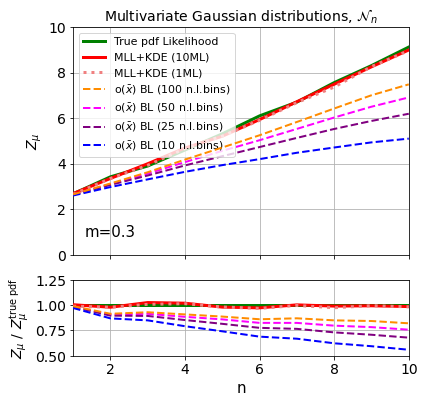

In [200]:
fig, axs = plt.subplots(2,1,figsize=(6,5.7), gridspec_kw={'height_ratios': [3, 1]})

lw = 2

axs[0].plot(dim, store_Z_gaussian, '-', color='green', lw=3, label=r'True pdf Likelihood' ,zorder=5)
axs[0].plot(dim, store_Z_MLL_KDE, '-', color='red', lw=3, label=r'MLL+KDE (10ML)', zorder=5 )
axs[0].plot(dim, store_Z_MLL_KDE_1ML, ':', color='lightcoral', lw=3, label=r'MLL+KDE (1ML)', zorder=5 )
#axs[0].plot(dim, store_Z_bins_XG_100bins, '--', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 l.bins)' ,zorder=10)
#axs[0].plot(dim, store_Z_bins_XG_50bins, '--', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 l.bins)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_25bins, '--', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 l.bins)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_10bins, '--', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 l.bins)' ,zorder=5)
axs[0].plot(dim, store_Z_bins_XG_100bins_eq, '--', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 n.l.bins)' ,zorder=10)
axs[0].plot(dim, store_Z_bins_XG_50bins_eq, '--', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 n.l.bins)' ,zorder=5)
axs[0].plot(dim, store_Z_bins_XG_25bins_eq, '--', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 n.l.bins)' ,zorder=5)
axs[0].plot(dim, store_Z_bins_XG_10bins_eq, '--', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 n.l.bins)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_100bins_1ML, '--', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 l.bins) (1ML)' ,zorder=10)
#axs[0].plot(dim, store_Z_bins_XG_50bins_1ML, '--', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 l.bins) (1ML)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_25bins_1ML, '--', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 l.bins) (1ML)' ,zorder=5)
#axs[0].plot(dim, store_Z_bins_XG_10bins_1ML, '--', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 l.bins) (1ML)' ,zorder=5)
# axs[0].plot(dim, store_Z_bins_XG_100bins_eq_1ML, ':', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 n.l.bins) (1ML)' ,zorder=10)
# axs[0].plot(dim, store_Z_bins_XG_50bins_eq_1ML, ':', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 n.l.bins) (1ML)' ,zorder=5)
# axs[0].plot(dim, store_Z_bins_XG_25bins_eq_1ML, ':', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 n.l.bins) (1ML)' ,zorder=5)
# axs[0].plot(dim, store_Z_bins_XG_10bins_eq_1ML, ':', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 n.l.bins) (1ML)' ,zorder=5)


store_Z_gaussian_norm = [ a/b for a, b in zip(store_Z_gaussian,store_Z_gaussian)]
store_Z_MLL_KDE_norm = [ a/b for a, b in zip(store_Z_MLL_KDE,store_Z_gaussian)]
store_Z_MLL_KDE_1ML_norm = [ a/b for a, b in zip(store_Z_MLL_KDE_1ML,store_Z_gaussian)]
store_Z_bins_XG_100bins_norm = [ a/b for a, b in zip(store_Z_bins_XG_100bins,store_Z_gaussian)]
store_Z_bins_XG_50bins_norm = [ a/b for a, b in zip(store_Z_bins_XG_50bins,store_Z_gaussian)]
store_Z_bins_XG_25bins_norm = [ a/b for a, b in zip(store_Z_bins_XG_25bins,store_Z_gaussian)]
store_Z_bins_XG_10bins_norm = [ a/b for a, b in zip(store_Z_bins_XG_10bins,store_Z_gaussian)]
store_Z_bins_XG_100bins_eq_norm = [ a/b for a, b in zip(store_Z_bins_XG_100bins_eq,store_Z_gaussian)]
store_Z_bins_XG_50bins_eq_norm = [ a/b for a, b in zip(store_Z_bins_XG_50bins_eq,store_Z_gaussian)]
store_Z_bins_XG_25bins_eq_norm = [ a/b for a, b in zip(store_Z_bins_XG_25bins_eq,store_Z_gaussian)]
store_Z_bins_XG_10bins_eq_norm = [ a/b for a, b in zip(store_Z_bins_XG_10bins_eq,store_Z_gaussian)]
store_Z_bins_XG_100bins_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_100bins_1ML,store_Z_gaussian)]
store_Z_bins_XG_50bins_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_50bins_1ML,store_Z_gaussian)]
store_Z_bins_XG_25bins_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_25bins_1ML,store_Z_gaussian)]
store_Z_bins_XG_10bins_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_10bins_1ML,store_Z_gaussian)]
store_Z_bins_XG_100bins_eq_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_100bins_eq_1ML,store_Z_gaussian)]
store_Z_bins_XG_50bins_eq_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_50bins_eq_1ML,store_Z_gaussian)]
store_Z_bins_XG_25bins_eq_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_25bins_eq_1ML,store_Z_gaussian)]
store_Z_bins_XG_10bins_eq_1ML_norm = [ a/b for a, b in zip(store_Z_bins_XG_10bins_eq_1ML,store_Z_gaussian)]
dim_norm = [ a/b for a, b in zip(dim,store_Z_gaussian)]


axs[1].plot(dim, store_Z_gaussian_norm, '-', color='green', lw=3, label=r'True pdf Likelihood' ,zorder=5)
axs[1].plot(dim, store_Z_MLL_KDE_norm, '-', color='red', lw=3, label=r'MLL+KDE (10ML)', zorder=5 )
axs[1].plot(dim, store_Z_MLL_KDE_1ML_norm, ':', color='lightcoral', lw=3, label=r'MLL+KDE (1ML)', zorder=5 )
#axs[1].plot(dim, store_Z_bins_XG_100bins_norm, '--', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 l.bins) (10ML)' ,zorder=10)
#axs[1].plot(dim, store_Z_bins_XG_50bins_norm, '--', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 l.bins) (10ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_25bins_norm, '--', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 l.bins) (10ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_10bins_norm, '--', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 l.bins) (10ML)' ,zorder=5)
axs[1].plot(dim, store_Z_bins_XG_100bins_eq_norm, '--', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 n.l.bins) (10ML)' ,zorder=10)
axs[1].plot(dim, store_Z_bins_XG_50bins_eq_norm, '--', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 n.l.bins) (10ML)' ,zorder=5)
axs[1].plot(dim, store_Z_bins_XG_25bins_eq_norm, '--', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 n.l.bins) (10ML)' ,zorder=5)
axs[1].plot(dim, store_Z_bins_XG_10bins_eq_norm, '--', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 n.l.bins) (10ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_100bins_1ML_norm, '--', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 l.bins) (1ML)' ,zorder=10)
#axs[1].plot(dim, store_Z_bins_XG_50bins_1ML_norm, '--', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 l.bins) (1ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_25bins_1ML_norm, '--', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 l.bins) (1ML)' ,zorder=5)
#axs[1].plot(dim, store_Z_bins_XG_10bins_1ML_norm, '--', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 l.bins) (1ML)' ,zorder=5)
# axs[1].plot(dim, store_Z_bins_XG_100bins_eq_1ML_norm, ':', color='darkorange', lw=2, label=r'o$(\bar{x})$ BL (100 n.l.bins) (1ML)' ,zorder=10)
# axs[1].plot(dim, store_Z_bins_XG_50bins_eq_1ML_norm, ':', color='magenta', lw=2, label=r'o$(\bar{x})$ BL (50 n.l.bins) (1ML)' ,zorder=5)
# axs[1].plot(dim, store_Z_bins_XG_25bins_eq_1ML_norm, ':', color='purple', lw=2, label=r'o$(\bar{x})$ BL (25 n.l.bins) (1ML)' ,zorder=5)
# axs[1].plot(dim, store_Z_bins_XG_10bins_eq_1ML_norm, ':', color='blue', lw=2, label=r'o$(\bar{x})$ BL (10 n.l.bins) (1ML)' ,zorder=5)




axs[0].text(1.3, 0.8, 'm=0.3', fontsize = 15)


axs[0].set_xlim([1, 10])
axs[0].set_ylim([0, 10])
axs[1].set_xlim([1, 10])
axs[1].set_ylim([0.5,1.25])
axs[0].set_ylabel('$Z_{\mu}$', fontsize=14)
axs[1].set_xlabel('n', fontsize=15)
axs[1].set_ylabel(r'$Z_{\mu}$ / $Z_{\mu}^{\mathrm{true \; pdf}}$', fontsize=14)

axs[0].yaxis.set_tick_params(labelsize=14)
axs[0].xaxis.set_tick_params(labelsize=14)
axs[0].xaxis.set_ticklabels([])
axs[1].yaxis.set_ticks([0.5,0.75,1,1.25])
axs[1].xaxis.set_tick_params(labelsize=14)
axs[1].yaxis.set_tick_params(labelsize=14)

axs[0].grid()
axs[1].grid()

axs[0].set_title('Multivariate Gaussian distributions, $\mathcal{N}_{n}$', fontsize=14)
axs[0].legend(loc="upper left", fontsize=11)
plt.tight_layout()
plt.savefig('images/' + '2gaussian-Z-dims-m03-C.pdf', format="pdf", bbox_inches="tight")
plt.show()